In [8]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt
import copy
import scipy

def f(lmd,c):
    # return scipy.special.expit(-lmd*c)
    y = 1 / (1 + np.exp(-lmd*c))
    return y

def h(err):
    y = 1 / (2 * err + 1)
    return y

def errorLp(p,data_pre,data_real):
    dist = np.linalg.norm(data_pre-data_real,ord=p)/(data_pre.shape[0]*data_pre.shape[1])
    return dist
  
#%%
#返回初始化权重参数   NxN 
def initialize_parameters_he(npop,N):
    parameters = np.zeros((npop,N*N))
    for i in range(npop):
        parameter = np.random.randn(N*(N-1)) * np.sqrt(2.0 / (N*(N-1)))
        lmd = np.random.uniform(0,1,N)
        #lmd = np.array([1]*N)
        parameters[i] = parameter.tolist()+lmd.tolist()
    return parameters
    
def rshape(X,N):
    temp = copy.copy(X)
    e = np.zeros((N,N))
    param = temp[:-N]   
    lmd = temp[-N:]
    num = 0
    for i in range(N):
        for j in range(N):
            if i is not j:
                e[i,j] = param[num]
                num = num + 1
    return e,lmd
    
#jaya学习算法训练FCM参数
def jayaTrain(c_data,c_real,time,N,npop=4):
    X = initialize_parameters_he(npop,N)
#    for n in range(npop):
#        for i in range(N*N):
#            X[n,i] = min(X[:,i]) + np.random.random()*(max(X[:,i])-min(X[:,i]))
    fitness = np.zeros(npop)
    error = np.zeros(npop)
    worst= 0
    best = 0
    error_time = []
    c_pre = np.zeros((c_real.shape[0],c_real.shape[1]))
    for num in range(500):
        for n in range(npop):
            e,lmd = rshape(X[n,:],N)
            #print("c_data.shape: %s" % c_data.shape)
            c_pre = fcm(e,lmd,c_data,c_real,time)
            #print("c_pre, c_real: %s ,%s" % c_pre.shape, c_real.shape)
            fitness[n] = h(errorLp(2,c_pre,c_real)) 
            error[n] = errorLp(2,c_pre,c_real)
        worst = fitness.tolist().index(min(fitness))
        best = fitness.tolist().index(max(fitness))
        print(worst,best,fitness)
    
        Xx = np.zeros((npop,N*N))
        for n in range(npop):
            Xx[n,:] = X[n,:] + (X[best,:]-np.abs(X[n,:]))*np.random.random()-(X[worst,:]-np.abs(X[n,:]))*np.random.random()
            for i in range(N*N):
                if Xx[n,i] < min(Xx[:,i]):
                    Xx[n,i] = min(Xx[:,i])
                if Xx[n,i] > max(Xx[:,i]):
                    Xx[n,i] = max(Xx[:,i])
            e,lmd = rshape(Xx[n,:],N)
            c_pre = fcm(e,lmd,c_data,c_real,time)
            error2 = errorLp(2,c_pre,c_real)
            if error2 <= error[n]:
                X[n,:] = Xx[n,:]              
        error_time.append(error[best])
    e,lmd = rshape(X[best,:],N)
    return e,lmd,error_time

#模糊认知图递推过程      
def fcm(e,lmd,data_front,data,time):
    '''
    c_len = len(data)
    data_pre = np.zeros((time+1,c_len))
    data_pre[0] = data_front
    
    for t in range(0,time):
        for i in range(c_len):
            for j in range(c_len):
                if i is not j :
                    data_pre[t+1,i] += e[j,i]*data[t,j]
            data_pre[t+1,i] += data[t,i]
            data_pre[t+1,i] = f(lmd[i],data[t+1,i])
    
    '''
    c_len = len(data_front)
    data_pre = np.zeros((time,c_len))
    data_pre[0] = np.dot(data_front,e)
    for i in range(c_len):
        data_pre[0,i] = f(lmd[i],data_pre[0,i])
    for t in range(0,time-1):
        data_pre[t+1] = np.dot(data[t],e)
        for i in range(c_len):
            data_pre[t+1,i] = f(lmd[i],data_pre[t+1,i])
    return data_pre

#模糊认知图递推过程训练用   
def fcmm(e,lmd,data_front):
    c_len = len(data_front)
    data_pre = np.dot(data_front,e)
    for i in range(c_len):
        data_pre[i] = f(lmd[i],data_pre[i])
    
    return data_pre

In [2]:
#%%
def drawPre(title,preData,realData,dataNum=50):
    plt.title(title)
    plt.plot(range(dataNum), preData, color='green', label='predict');
    plt.plot(range(dataNum), realData, color='red', label='real');
    plt.legend();
    plt.xlabel('time');
    plt.ylabel('value');
    plt.show();        
    
def dataErr(data,label='none'):
    #输出图表
    plt.xlabel('time(day)')
    plt.ylabel('lost')
    plt.plot(data, label=label)
    plt.legend()
    plt.show()


In [9]:
#%% 
if __name__ == "__main__":
    data = pd.read_csv('dataProcess.csv',index_col = 0)
    data = np.array(data)
    train_time = 504               #设置滑动窗口
    start = 1
    hour = 100   
    concept = data.shape[1]
    
    #data_train = data[240:600,:]   #20天做训练
    data_test = data[start+train_time:start+train_time+hour,:]     #3天做测试
    
    
    data_pre = np.zeros((data_test.shape[0],data_test.shape[1]))
    for i in range(0,hour):
        data_train = data[i+start:i+train_time+start,:]
        data_real = data[i+start+train_time-1,:]
        e,lmd,error_time = jayaTrain(data[i+start-1,:],data_train,train_time,concept,npop = 8)
        data_pre[i] = fcmm(e,lmd,data_real)

            
#    e,lmd = jayaTrain(data_train[0,:],data_train,240,6,npop = 8)
#    data_pre = fcm(e,lmd,data_test[0,:],50)
    

3 6 [0.98662521 0.9865528  0.98662779 0.98631312 0.98656758 0.9864982
 0.98692434 0.98682539]
5 2 [0.98662521 0.9865528  0.98738597 0.98703426 0.98659332 0.98652947
 0.98705107 0.98682539]
0 5 [0.98663091 0.9869498  0.98738597 0.98703426 0.98729134 0.98746603
 0.9874181  0.9870911 ]
0 5 [0.98663091 0.98797691 0.98738597 0.98775126 0.98832784 0.98859902
 0.9874181  0.9882672 ]
2 5 [0.98803198 0.98797691 0.98738597 0.98775126 0.98876102 0.98880836
 0.9874181  0.988766  ]
2 7 [0.9889507  0.98797691 0.98738597 0.9892418  0.99033219 0.99011728
 0.99112689 0.99160159]
1 6 [0.98981218 0.98797691 0.98858697 0.9912468  0.99033219 0.99011728
 0.9924555  0.99160159]
2 6 [0.99231106 0.99072726 0.98858697 0.99223843 0.99240445 0.99011728
 0.9924555  0.99226946]
2 4 [0.99237082 0.99095191 0.99072904 0.99265623 0.99322017 0.99227537
 0.99253734 0.9930812 ]
0 3 [0.99248055 0.99305207 0.99259678 0.99379028 0.99338624 0.99260481
 0.99253734 0.9930812 ]
5 1 [0.99378577 0.99393791 0.99272753 0.99382086 0.

6 2 [0.99405748 0.99416303 0.99437021 0.99425621 0.9941376  0.99409677
 0.99402457 0.9940273 ]
6 2 [0.99405748 0.99416303 0.99437021 0.99425621 0.9941376  0.99409677
 0.99402457 0.9940273 ]
7 2 [0.99405748 0.99416303 0.99437021 0.99425621 0.9941376  0.99409677
 0.99411356 0.9940273 ]
7 2 [0.99405748 0.99416303 0.99437021 0.99425621 0.99416882 0.99409677
 0.99433926 0.9940273 ]
7 2 [0.99405748 0.99416303 0.99437021 0.99425621 0.99416882 0.99409677
 0.99433926 0.9940273 ]
7 3 [0.99405748 0.99416303 0.99437021 0.99437068 0.99416882 0.99409677
 0.99433926 0.9940273 ]
7 3 [0.99405748 0.99416303 0.99437021 0.99437068 0.99416882 0.99409677
 0.99433926 0.9940273 ]
7 3 [0.99405748 0.99416303 0.99437021 0.99437068 0.99416882 0.99409677
 0.99433926 0.9940273 ]
7 3 [0.99405748 0.99416303 0.99437021 0.99437068 0.99416882 0.99409677
 0.99433926 0.9940273 ]
7 3 [0.99405748 0.99416303 0.99437021 0.99437068 0.99416882 0.99409677
 0.99433926 0.9940273 ]
7 3 [0.99405748 0.99416303 0.99437021 0.99437068 0

6 3 [0.99492755 0.99489926 0.99480996 0.99495239 0.99482828 0.99489719
 0.99476568 0.99483641]
6 3 [0.99492755 0.99489926 0.99480996 0.99495239 0.99482828 0.99489719
 0.99476568 0.99483641]
6 3 [0.99492755 0.99489926 0.99480996 0.99495239 0.99482828 0.99489719
 0.99476568 0.99483641]
6 3 [0.99492755 0.99489926 0.99480996 0.99495239 0.99482828 0.99489719
 0.99476568 0.99483641]
6 3 [0.99492755 0.99489926 0.99480996 0.99495239 0.99482828 0.99489719
 0.99476568 0.99483641]
6 3 [0.99492755 0.99489926 0.99480996 0.99495239 0.99482828 0.99489719
 0.99476568 0.99483641]
6 3 [0.99492755 0.99489926 0.99480996 0.99495239 0.99482828 0.99489719
 0.99476568 0.99483641]
6 3 [0.99492755 0.99489926 0.99480996 0.99495239 0.99482828 0.99489719
 0.99476568 0.99483641]
6 3 [0.99492755 0.99489926 0.99480996 0.99495239 0.99482828 0.99489719
 0.99476568 0.99483641]
6 3 [0.99492755 0.99489926 0.99480996 0.99495239 0.99482828 0.99489719
 0.99476568 0.99484014]
6 3 [0.99492755 0.99489926 0.99480996 0.99495239 0

6 1 [0.99501716 0.99505392 0.99501691 0.994975   0.99502263 0.99502967
 0.9949724  0.99504171]
6 1 [0.99501716 0.99505392 0.99501691 0.994975   0.99502263 0.99502967
 0.9949724  0.99504171]
6 1 [0.99501716 0.99505392 0.99501691 0.994975   0.99502263 0.99502967
 0.9949724  0.99504171]
6 1 [0.99503022 0.99505392 0.99501691 0.994975   0.99502263 0.99502967
 0.9949724  0.99504171]
6 1 [0.99503022 0.99505392 0.99501691 0.994975   0.99502263 0.99502967
 0.9949724  0.99504171]
6 1 [0.99503022 0.99505392 0.99501691 0.994975   0.99502263 0.99502967
 0.9949724  0.99504171]
6 1 [0.99503022 0.99505392 0.99501691 0.994975   0.99502263 0.99502967
 0.9949724  0.99504171]
6 1 [0.99503022 0.99505392 0.99501691 0.994975   0.99502263 0.99502967
 0.9949724  0.99504171]
6 1 [0.99503022 0.99505392 0.99501691 0.994975   0.99502263 0.99502967
 0.9949724  0.99504171]
6 1 [0.99503022 0.99505392 0.99501691 0.994975   0.99502263 0.99502967
 0.9949724  0.99504171]
6 1 [0.99503022 0.99505392 0.99501691 0.994975   0

4 7 [0.99505281 0.99505392 0.99502442 0.99505203 0.99502263 0.99505916
 0.99504316 0.99505931]
4 1 [0.99505281 0.99506418 0.99502442 0.99505203 0.99502263 0.99505916
 0.99504316 0.99505931]
2 1 [0.99505281 0.99506418 0.99502442 0.99505203 0.99503481 0.99505916
 0.99504316 0.99505931]
2 1 [0.99505281 0.99506418 0.99502442 0.99505203 0.99503481 0.99505916
 0.99504316 0.99505931]
2 1 [0.99505281 0.99506418 0.99502442 0.99505203 0.99503481 0.99505916
 0.99504316 0.99505931]
2 1 [0.99505281 0.99506418 0.99502442 0.99505203 0.99503481 0.99505916
 0.99504316 0.99506166]
2 1 [0.99505281 0.99506418 0.99502442 0.99505203 0.99503481 0.99505916
 0.99504316 0.99506166]
2 1 [0.99505281 0.99506418 0.99502442 0.99505203 0.99503481 0.99505916
 0.99504316 0.99506166]
2 1 [0.99505281 0.99506418 0.99502442 0.99505203 0.99503481 0.99505916
 0.99504316 0.99506166]
2 1 [0.99505281 0.99506418 0.99502442 0.99505203 0.99503481 0.99505916
 0.99504316 0.99506166]
2 5 [0.99505281 0.99506418 0.99502442 0.99505203 0

3 0 [0.99507517 0.99506418 0.99507059 0.99506332 0.99506451 0.99507303
 0.99507497 0.99507068]
3 0 [0.99507517 0.99506418 0.99507059 0.99506332 0.99506451 0.99507303
 0.99507497 0.99507068]
3 0 [0.99507517 0.99506418 0.99507059 0.99506332 0.99506451 0.99507303
 0.99507497 0.99507068]
3 0 [0.99507517 0.99506418 0.99507059 0.99506332 0.99506451 0.99507303
 0.99507497 0.99507068]
3 0 [0.99507517 0.99506418 0.99507059 0.99506332 0.99506451 0.99507303
 0.99507497 0.99507068]
3 0 [0.99507517 0.99506418 0.99507059 0.99506332 0.99506451 0.99507303
 0.99507497 0.99507068]
3 0 [0.99507517 0.99506418 0.99507059 0.99506332 0.99506451 0.99507303
 0.99507497 0.99507068]
3 0 [0.99507517 0.99506418 0.99507059 0.99506332 0.99506451 0.99507303
 0.99507497 0.99507068]
3 0 [0.99507517 0.99506418 0.99507059 0.99506332 0.99506451 0.99507303
 0.99507497 0.99507068]
3 0 [0.99507517 0.99506418 0.99507059 0.99506332 0.99506451 0.99507303
 0.99507497 0.99507068]
3 0 [0.99507517 0.99506418 0.99507059 0.99506332 0

5 0 [0.99415048 0.99392916 0.9940966  0.99408013 0.99408887 0.99392665
 0.99400045 0.99410467]
1 0 [0.99415048 0.99392916 0.9940966  0.99408013 0.99408887 0.99405959
 0.99400045 0.99410467]
1 5 [0.99415048 0.99392916 0.9940966  0.99414661 0.99408887 0.99417499
 0.99400045 0.99410467]
1 5 [0.99415048 0.99392916 0.9940966  0.99414661 0.99408887 0.99417499
 0.99400045 0.99410467]
1 5 [0.99415048 0.99392916 0.9940966  0.99414661 0.99408887 0.99417499
 0.99400045 0.99410467]
1 3 [0.99415048 0.99399899 0.9940966  0.99422453 0.99419293 0.99417504
 0.99404287 0.99410467]
1 2 [0.99415048 0.99399899 0.99423352 0.99422453 0.99419293 0.99417504
 0.99404287 0.99410467]
1 2 [0.99415048 0.99399899 0.99423352 0.99422453 0.99419293 0.99417504
 0.99404287 0.99410467]
1 2 [0.99416964 0.99399899 0.99423352 0.99422453 0.99419293 0.99417504
 0.99404287 0.99410467]
1 5 [0.99416964 0.99399899 0.99423352 0.99422453 0.99419293 0.99423639
 0.99404287 0.99421153]
1 5 [0.99416964 0.99399899 0.99423352 0.99422453 0

6 3 [0.99424863 0.99424953 0.99425114 0.99425131 0.99424221 0.99425018
 0.99424071 0.99425024]
6 3 [0.99424863 0.99424953 0.99425114 0.99425131 0.99424221 0.99425018
 0.99424071 0.99425024]
6 3 [0.99424863 0.99424953 0.99425114 0.99425131 0.99424221 0.99425018
 0.99424071 0.99425024]
6 3 [0.99424863 0.99424953 0.99425114 0.99425131 0.99424221 0.99425018
 0.99424071 0.99425024]
6 3 [0.99424863 0.99424953 0.99425114 0.99425131 0.99424221 0.99425018
 0.99424071 0.99425024]
6 3 [0.99424863 0.99424953 0.99425114 0.99425131 0.99424811 0.99425018
 0.99424071 0.99425024]
6 3 [0.99424863 0.99424953 0.99425114 0.99425131 0.99424811 0.99425018
 0.99424071 0.99425024]
6 1 [0.99424863 0.99425422 0.99425114 0.99425131 0.99424811 0.99425018
 0.99424071 0.99425024]
4 1 [0.99424863 0.99425422 0.99425114 0.99425131 0.99424811 0.99425018
 0.99425061 0.99425024]
4 1 [0.99424863 0.99425422 0.99425114 0.99425305 0.99424811 0.99425018
 0.99425061 0.99425024]
4 1 [0.99424863 0.99425422 0.99425114 0.99425305 0

7 1 [0.99425417 0.99425422 0.99425352 0.99425305 0.99425408 0.99425385
 0.99425274 0.99425044]
7 1 [0.99425417 0.99425422 0.99425352 0.99425305 0.99425408 0.99425385
 0.99425274 0.99425044]
7 1 [0.99425417 0.99425422 0.99425352 0.99425305 0.99425408 0.99425385
 0.99425274 0.99425044]
7 1 [0.99425417 0.99425422 0.99425352 0.99425305 0.99425408 0.99425385
 0.99425274 0.99425044]
7 1 [0.99425417 0.99425422 0.99425352 0.99425305 0.99425408 0.99425385
 0.99425274 0.99425044]
7 1 [0.99425417 0.99425422 0.99425352 0.99425374 0.99425408 0.99425385
 0.99425274 0.99425044]
7 1 [0.99425417 0.99425422 0.99425352 0.99425374 0.99425408 0.99425385
 0.99425274 0.99425044]
7 1 [0.99425417 0.99425422 0.99425352 0.99425374 0.99425408 0.99425385
 0.99425274 0.99425044]
7 1 [0.99425417 0.99425422 0.99425352 0.99425374 0.99425408 0.99425385
 0.99425274 0.99425044]
7 1 [0.99425417 0.99425422 0.99425352 0.99425374 0.99425408 0.99425385
 0.99425274 0.99425044]
7 1 [0.99425417 0.99425422 0.99425352 0.99425374 0

6 1 [0.99425417 0.99425422 0.99425352 0.99425405 0.99425416 0.99425404
 0.99425274 0.99425299]
6 1 [0.99425417 0.99425422 0.99425352 0.99425405 0.99425416 0.99425404
 0.99425274 0.99425299]
6 1 [0.99425417 0.99425422 0.99425352 0.99425405 0.99425416 0.99425404
 0.99425274 0.99425299]
6 1 [0.99425417 0.99425422 0.99425352 0.99425405 0.99425416 0.99425404
 0.99425274 0.99425299]
6 1 [0.99425417 0.99425422 0.99425352 0.99425405 0.99425416 0.99425404
 0.99425274 0.99425299]
6 1 [0.99425417 0.99425422 0.99425352 0.99425405 0.99425416 0.99425404
 0.99425274 0.99425299]
6 1 [0.99425417 0.99425422 0.99425352 0.99425405 0.99425416 0.99425404
 0.99425274 0.99425299]
6 1 [0.99425417 0.99425422 0.99425352 0.99425405 0.99425416 0.99425404
 0.99425274 0.99425299]
6 1 [0.99425417 0.99425422 0.99425352 0.99425405 0.99425416 0.99425404
 0.99425274 0.99425299]
6 1 [0.99425417 0.99425422 0.99425352 0.99425405 0.99425416 0.99425404
 0.99425274 0.99425299]
6 1 [0.99425417 0.99425422 0.99425352 0.99425405 0

6 1 [0.99425417 0.99425422 0.99425352 0.99425405 0.99425416 0.99425404
 0.99425274 0.99425299]
6 1 [0.99425417 0.99425422 0.99425352 0.99425405 0.99425416 0.99425404
 0.99425274 0.99425299]
6 1 [0.99425417 0.99425422 0.99425352 0.99425405 0.99425416 0.99425404
 0.99425274 0.99425299]
6 1 [0.99425417 0.99425422 0.99425352 0.99425405 0.99425416 0.99425404
 0.99425274 0.99425299]
6 1 [0.99425417 0.99425422 0.99425352 0.99425405 0.99425416 0.99425404
 0.99425274 0.99425299]
6 1 [0.99425417 0.99425422 0.99425352 0.99425405 0.99425416 0.99425404
 0.99425274 0.99425299]
6 1 [0.99425417 0.99425422 0.99425352 0.99425405 0.99425416 0.99425404
 0.99425274 0.99425299]
6 1 [0.99425417 0.99425422 0.99425352 0.99425405 0.99425416 0.99425404
 0.99425274 0.99425299]
6 1 [0.99425417 0.99425422 0.99425352 0.99425405 0.99425416 0.99425404
 0.99425274 0.99425299]
6 1 [0.99425417 0.99425422 0.99425352 0.99425405 0.99425416 0.99425404
 0.99425274 0.99425299]
6 1 [0.99425417 0.99425422 0.99425352 0.99425405 0

6 1 [0.99425417 0.99425422 0.99425352 0.99425405 0.99425416 0.99425404
 0.99425274 0.99425299]
6 1 [0.99425417 0.99425422 0.99425352 0.99425405 0.99425416 0.99425404
 0.99425274 0.99425299]
6 1 [0.99425417 0.99425422 0.99425352 0.99425405 0.99425416 0.99425404
 0.99425274 0.99425299]
6 1 [0.99425417 0.99425422 0.99425352 0.99425405 0.99425416 0.99425404
 0.99425274 0.99425299]
6 1 [0.99425417 0.99425422 0.99425352 0.99425405 0.99425416 0.99425404
 0.99425274 0.99425299]
6 1 [0.99425417 0.99425422 0.99425352 0.99425405 0.99425416 0.99425404
 0.99425274 0.99425299]
6 1 [0.99425417 0.99425422 0.99425352 0.99425405 0.99425416 0.99425404
 0.99425274 0.99425299]
6 1 [0.99425417 0.99425422 0.99425352 0.99425405 0.99425416 0.99425404
 0.99425274 0.99425299]
6 1 [0.99425417 0.99425422 0.99425352 0.99425405 0.99425416 0.99425404
 0.99425274 0.99425299]
6 1 [0.99425417 0.99425422 0.99425352 0.99425405 0.99425416 0.99425404
 0.99425274 0.99425299]
6 1 [0.99425417 0.99425422 0.99425352 0.99425405 0

4 7 [0.99650801 0.99649489 0.99646786 0.99650722 0.99642295 0.99646406
 0.9964539  0.99652015]
4 7 [0.99650801 0.99649489 0.99646786 0.99650722 0.99642295 0.99646406
 0.9964539  0.99652015]
6 7 [0.99650801 0.99651453 0.99646786 0.99650722 0.99647647 0.99646406
 0.9964539  0.99652015]
6 7 [0.99650801 0.99651453 0.99646786 0.99650722 0.99647647 0.99646406
 0.9964539  0.99652015]
5 7 [0.99650801 0.99651453 0.99646786 0.99650722 0.99647647 0.99646406
 0.99649671 0.99652015]
5 7 [0.99650801 0.99651453 0.99646786 0.99650722 0.99647647 0.99646406
 0.99649671 0.99652015]
5 7 [0.99650801 0.99651453 0.99646786 0.99650722 0.99647647 0.99646406
 0.99649671 0.99652015]
5 7 [0.99650801 0.99651453 0.99646786 0.99650722 0.99647647 0.99646406
 0.99649671 0.99652015]
5 7 [0.99650801 0.99651453 0.99646786 0.99650722 0.99647647 0.99646406
 0.99649671 0.99652015]
5 1 [0.99650801 0.99655078 0.99650325 0.99650722 0.99647647 0.99646406
 0.99649671 0.99652015]
5 2 [0.99650801 0.99655078 0.99656241 0.99650722 0

0 1 [0.99652385 0.99656954 0.99656241 0.99655715 0.99656926 0.99655102
 0.99655903 0.99654535]
0 1 [0.99652385 0.99656954 0.99656241 0.99655715 0.99656926 0.99655102
 0.99655903 0.99654535]
0 1 [0.99652385 0.99656954 0.99656241 0.99655715 0.99656926 0.99655102
 0.99655903 0.99654535]
0 1 [0.99652385 0.99656954 0.99656241 0.99655715 0.99656926 0.99655102
 0.99655903 0.99654535]
0 1 [0.99652385 0.99656954 0.99656241 0.99655715 0.99656926 0.99655102
 0.99655903 0.99654535]
0 1 [0.99652385 0.99656954 0.99656241 0.99655715 0.99656926 0.99655102
 0.99655903 0.99654535]
0 1 [0.99652385 0.99656954 0.99656241 0.99655715 0.99656926 0.99655102
 0.99655903 0.99654535]
0 1 [0.99652385 0.99656954 0.99656241 0.99655715 0.99656926 0.99655102
 0.99655903 0.99654535]
0 1 [0.99652385 0.99656954 0.99656241 0.99655715 0.99656926 0.99655102
 0.99655903 0.99654535]
0 1 [0.99652385 0.99656954 0.99656241 0.99655715 0.99656926 0.99655102
 0.99655903 0.99654535]
0 1 [0.99652385 0.99656954 0.99656241 0.99655715 0

7 1 [0.99655976 0.99656954 0.9965661  0.99655715 0.99656926 0.99655102
 0.99655903 0.99655019]
7 1 [0.99655976 0.99656954 0.9965661  0.99655715 0.99656926 0.99655102
 0.99655903 0.99655019]
7 1 [0.99655976 0.99656954 0.9965661  0.99655715 0.99656926 0.99655102
 0.99655903 0.99655019]
7 1 [0.99655976 0.99656954 0.9965661  0.99655715 0.99656926 0.99655102
 0.99655903 0.99655019]
7 1 [0.99655976 0.99656954 0.9965661  0.99655715 0.99656926 0.99655102
 0.99655903 0.99655019]
7 1 [0.99655976 0.99656954 0.9965661  0.99655715 0.99656926 0.99655102
 0.99655903 0.99655019]
7 1 [0.99655976 0.99656954 0.9965661  0.99655715 0.99656926 0.99655102
 0.99655903 0.99655019]
7 1 [0.99655976 0.99656954 0.9965661  0.99655715 0.99656926 0.99655102
 0.99655903 0.99655019]
7 1 [0.99655976 0.99656954 0.9965661  0.99655715 0.99656926 0.99655102
 0.99656146 0.99655019]
7 1 [0.99655976 0.99656954 0.9965661  0.99655715 0.99656926 0.99655102
 0.99656146 0.99655019]
7 1 [0.99655976 0.99656954 0.9965661  0.99655715 0

6 5 [0.9965662  0.99656954 0.9965661  0.9965694  0.99656926 0.99657154
 0.99656146 0.99656418]
6 5 [0.9965662  0.99656997 0.9965661  0.9965694  0.99656926 0.99657154
 0.99656146 0.99656418]
6 5 [0.9965662  0.99656997 0.9965661  0.9965694  0.99656926 0.99657154
 0.99656146 0.99656418]
6 5 [0.9965662  0.99656997 0.9965661  0.9965694  0.99656926 0.99657154
 0.99656146 0.99656418]
6 5 [0.9965662  0.99656997 0.9965661  0.9965694  0.99656926 0.99657154
 0.99656146 0.99656418]
6 5 [0.9965662  0.99656997 0.9965661  0.9965694  0.99656926 0.99657154
 0.99656146 0.99656418]
6 5 [0.9965662  0.99656997 0.9965661  0.9965694  0.99656926 0.99657154
 0.99656146 0.99656418]
6 5 [0.9965662  0.99656997 0.9965661  0.9965694  0.99656926 0.99657154
 0.99656146 0.99656418]
6 5 [0.9965662  0.99656997 0.9965661  0.9965694  0.99656926 0.99657154
 0.99656146 0.99656418]
6 5 [0.9965662  0.99656997 0.9965661  0.9965694  0.99656926 0.99657154
 0.99656146 0.99656418]
6 5 [0.9965662  0.99656997 0.9965661  0.9965694  0

2 5 [0.99656769 0.99656997 0.9965661  0.9965694  0.99656926 0.99657154
 0.99656809 0.99657126]
2 5 [0.99656769 0.99656997 0.9965661  0.9965694  0.99656926 0.99657154
 0.99656809 0.99657126]
2 5 [0.99656769 0.99656997 0.9965661  0.9965694  0.99656926 0.99657154
 0.99656809 0.99657126]
2 5 [0.99656769 0.99656997 0.9965661  0.9965694  0.99656926 0.99657154
 0.99656809 0.99657126]
2 5 [0.99656769 0.99656997 0.9965661  0.9965694  0.99656926 0.99657154
 0.99656809 0.99657126]
2 5 [0.99656769 0.99656997 0.9965661  0.9965694  0.99656926 0.99657154
 0.99656809 0.99657126]
2 5 [0.99656769 0.99656997 0.9965661  0.9965694  0.99656926 0.99657154
 0.99656809 0.99657126]
2 5 [0.99656769 0.99656997 0.9965661  0.9965694  0.99656926 0.99657154
 0.99656809 0.99657126]
2 5 [0.99656769 0.99656997 0.9965661  0.9965694  0.99656926 0.99657154
 0.99656809 0.99657126]
2 5 [0.99656769 0.99656997 0.9965661  0.9965694  0.99656926 0.99657154
 0.99656809 0.99657126]
2 5 [0.99656769 0.99656997 0.9965661  0.9965694  0

2 6 [0.99656769 0.99656997 0.9965661  0.9965694  0.99657157 0.99657154
 0.99657193 0.99657126]
2 6 [0.99656769 0.99656997 0.9965661  0.9965694  0.99657157 0.99657154
 0.99657193 0.99657126]
2 6 [0.99656769 0.99656997 0.9965661  0.9965694  0.99657157 0.99657154
 0.99657193 0.99657126]
2 6 [0.99656769 0.99656997 0.9965661  0.9965694  0.99657157 0.99657154
 0.99657193 0.99657126]
2 0 [0.98707218 0.98697542 0.98654515 0.98689661 0.98675874 0.9869728
 0.98667618 0.98681332]
4 1 [0.98727304 0.98770544 0.9867624  0.98764941 0.98675874 0.9869728
 0.98712993 0.98734128]
5 4 [0.98729737 0.98786241 0.98787542 0.98766464 0.98788122 0.9869728
 0.9873211  0.98756012]
6 0 [0.98807031 0.98786241 0.98787542 0.98766464 0.98788122 0.98749171
 0.9873211  0.98756012]
7 5 [0.98807031 0.98786241 0.9878913  0.98766464 0.98788122 0.98898378
 0.98784435 0.98756012]
6 7 [0.98807031 0.98842931 0.98805225 0.98813631 0.98812345 0.98898378
 0.98784435 0.98967036]
2 7 [0.98807031 0.98842931 0.98805225 0.98914446 0.98

5 6 [0.99665865 0.99663627 0.9966249  0.99661314 0.9966486  0.99659913
 0.99666345 0.9966511 ]
5 6 [0.99665865 0.99663627 0.9966249  0.99661314 0.9966486  0.99659913
 0.99666345 0.9966511 ]
5 4 [0.99666996 0.99663627 0.9966249  0.99661314 0.99667152 0.99659913
 0.99666345 0.9966511 ]
5 4 [0.99666996 0.99663627 0.9966249  0.99661314 0.99667152 0.99659913
 0.99666345 0.9966511 ]
5 4 [0.99666996 0.99663627 0.9966249  0.99661314 0.99667152 0.99659913
 0.99666345 0.9966511 ]
5 4 [0.99666996 0.99663627 0.9966249  0.99661314 0.99667152 0.99659913
 0.99666345 0.9966511 ]
3 4 [0.99666996 0.99663627 0.9966249  0.99661314 0.99667152 0.99663961
 0.99666345 0.9966511 ]
2 4 [0.99666996 0.99663627 0.9966249  0.99663101 0.99667152 0.99663961
 0.99666345 0.9966511 ]
2 6 [0.99666996 0.99663627 0.9966249  0.99663101 0.99667152 0.99663961
 0.99668354 0.9966511 ]
2 6 [0.99667138 0.99663627 0.9966249  0.99663101 0.99667152 0.99663961
 0.99668354 0.9966511 ]
2 6 [0.99667138 0.99663627 0.9966249  0.99663101 0

6 3 [0.9967759  0.99676449 0.99677699 0.99678787 0.99675614 0.99677796
 0.99674302 0.99676593]
6 3 [0.9967759  0.99676449 0.99677699 0.99678787 0.99675614 0.99677796
 0.99674302 0.99676593]
6 3 [0.9967759  0.99676449 0.99677699 0.99678787 0.99675614 0.99677796
 0.99674302 0.99676593]
6 3 [0.9967759  0.99676449 0.99678363 0.99678787 0.99675614 0.99677796
 0.99674302 0.99676593]
6 3 [0.9967759  0.99676449 0.99678363 0.99678787 0.99675614 0.99677796
 0.99674302 0.99676593]
6 3 [0.9967759  0.99676449 0.99678363 0.99678787 0.99675614 0.99677796
 0.99674302 0.99676593]
6 5 [0.9967759  0.99676449 0.99678363 0.99678787 0.99675614 0.99679033
 0.99674302 0.99676593]
6 5 [0.9967759  0.99676449 0.99678363 0.99678787 0.99675614 0.99679033
 0.99674302 0.99676593]
6 5 [0.9967759  0.99676449 0.99678363 0.99678787 0.99675614 0.99679033
 0.99674302 0.99676593]
6 5 [0.9967759  0.99676449 0.99678363 0.99678787 0.99675614 0.99679033
 0.99674302 0.99676593]
6 5 [0.9967759  0.99676449 0.99678363 0.99678787 0

7 4 [0.99680091 0.99680651 0.9968218  0.99681378 0.99683997 0.99682022
 0.99680009 0.99677616]
7 4 [0.99680091 0.99680651 0.9968218  0.99681378 0.99683997 0.99682022
 0.99680009 0.99677616]
7 4 [0.99680091 0.99680651 0.9968218  0.99681378 0.99683997 0.99682022
 0.99680009 0.99677616]
7 4 [0.99680091 0.99680651 0.9968218  0.99681378 0.99683997 0.99682022
 0.99680009 0.99677616]
7 4 [0.99680091 0.99680651 0.9968218  0.99681378 0.99683997 0.99682022
 0.99680009 0.99677616]
7 4 [0.99680091 0.99680651 0.9968218  0.99681378 0.99683997 0.99682022
 0.99680009 0.99677616]
7 4 [0.99680091 0.99680651 0.9968218  0.99681378 0.99683997 0.99682022
 0.99680009 0.99677616]
7 4 [0.99680091 0.99680651 0.9968218  0.99681378 0.99683997 0.99682022
 0.99680009 0.99677616]
7 4 [0.99680091 0.99680651 0.9968218  0.99681378 0.99683997 0.99682022
 0.99680009 0.99677616]
6 4 [0.99680091 0.99680651 0.9968218  0.99681378 0.99683997 0.99682022
 0.99680009 0.99682246]
0 4 [0.99680091 0.99680651 0.9968218  0.99681378 0

3 6 [0.9968401  0.99683146 0.99683017 0.99681465 0.9968438  0.99682825
 0.99684716 0.99683472]
3 6 [0.9968401  0.99683146 0.99683017 0.99681465 0.9968438  0.99682825
 0.99684716 0.99683472]
3 6 [0.9968401  0.99683146 0.99683017 0.99681465 0.9968438  0.99682825
 0.99684716 0.99683472]
3 6 [0.9968401  0.99683146 0.99683017 0.99681465 0.9968438  0.99682825
 0.99684716 0.99683472]
3 6 [0.9968401  0.99683146 0.99683017 0.99681465 0.9968438  0.99682825
 0.99684716 0.99683472]
3 6 [0.9968401  0.99683146 0.99683017 0.99681465 0.9968438  0.99682825
 0.99684716 0.99683472]
3 6 [0.9968401  0.99683146 0.99683017 0.99681465 0.9968438  0.99682825
 0.99684716 0.99683472]
3 6 [0.9968401  0.99683146 0.99683017 0.99681465 0.9968438  0.9968458
 0.99684716 0.99683472]
3 6 [0.9968401  0.99683146 0.99683017 0.99681465 0.9968438  0.9968458
 0.99684716 0.99683472]
3 6 [0.9968401  0.99683146 0.99683017 0.99681465 0.9968438  0.9968458
 0.99684716 0.99683472]
3 6 [0.9968401  0.99683146 0.99683017 0.99681465 0.99

2 6 [0.9968401  0.99683947 0.99683017 0.99683264 0.9968438  0.99684745
 0.99685195 0.99683472]
2 6 [0.9968401  0.99683947 0.99683017 0.99683264 0.9968438  0.99684745
 0.99685195 0.99683472]
2 6 [0.9968401  0.99683947 0.99683017 0.99683264 0.9968438  0.99684745
 0.99685195 0.99683472]
2 6 [0.9968401  0.99683947 0.99683017 0.99683264 0.9968438  0.99684745
 0.99685195 0.99683472]
2 6 [0.9968401  0.99683947 0.99683017 0.99683264 0.9968438  0.99684745
 0.99685195 0.99683472]
2 6 [0.9968401  0.99683947 0.99683017 0.99683264 0.9968438  0.99684745
 0.99685195 0.99683472]
2 6 [0.9968401  0.99683947 0.99683017 0.99683264 0.9968438  0.99684745
 0.99685195 0.99683472]
2 6 [0.9968401  0.99683947 0.99683017 0.99683264 0.9968438  0.99684745
 0.99685195 0.99683472]
2 6 [0.9968401  0.99683947 0.99683017 0.99683264 0.9968438  0.99684745
 0.99685195 0.99683472]
2 6 [0.9968401  0.99683947 0.99683017 0.99683264 0.9968438  0.99684745
 0.99685195 0.99683472]
2 6 [0.9968401  0.99683947 0.99683017 0.99683264 0

4 1 [0.99586258 0.9967319  0.9953703  0.99523477 0.99459572 0.99566727
 0.99476554 0.99496999]
3 1 [0.99586258 0.9967319  0.9953703  0.99523477 0.99587113 0.99566727
 0.99604754 0.99552715]
5 1 [0.99586258 0.9967319  0.99585299 0.99616765 0.99587113 0.99566727
 0.99625298 0.99641195]
5 1 [0.99613844 0.9967319  0.99605059 0.99616765 0.99606397 0.99566727
 0.99625298 0.99641195]
5 1 [0.99613844 0.9967319  0.99605059 0.99616765 0.99606397 0.99566727
 0.99625298 0.99641195]
2 1 [0.99613844 0.9967319  0.99605059 0.99641818 0.99606397 0.99671871
 0.99625298 0.99641195]
2 1 [0.99613844 0.9967319  0.99605059 0.99641818 0.99606397 0.99671871
 0.99634062 0.99641195]
2 1 [0.99613844 0.9967319  0.99605059 0.99641818 0.99606397 0.99671871
 0.99634062 0.99641195]
2 1 [0.99646565 0.9967319  0.99605059 0.99641818 0.99606397 0.99671871
 0.99634062 0.99641195]
4 1 [0.99646565 0.9967319  0.99640717 0.99641818 0.99606397 0.99671871
 0.99634062 0.99641195]
4 1 [0.99646565 0.9967319  0.99640717 0.99641818 0

5 3 [0.9968142  0.99684144 0.99684428 0.99684473 0.99682612 0.99680396
 0.99684443 0.99682258]
5 3 [0.9968142  0.99684144 0.99684428 0.99684473 0.99682612 0.99680396
 0.99684443 0.99682258]
5 3 [0.9968142  0.99684144 0.99684428 0.99684473 0.99682612 0.99680396
 0.99684443 0.99682258]
5 6 [0.9968142  0.99684144 0.99684428 0.99684473 0.99682612 0.99680396
 0.99684802 0.99682258]
5 6 [0.9968142  0.99684144 0.99684428 0.99684473 0.99682612 0.99680396
 0.99684802 0.99682258]
5 6 [0.9968142  0.99684144 0.99684428 0.99684473 0.99682612 0.99680396
 0.99684802 0.99682258]
5 6 [0.9968142  0.99684144 0.99684428 0.99684473 0.99682612 0.99680396
 0.99684802 0.99682258]
5 6 [0.9968142  0.99684144 0.99684428 0.99684473 0.99682612 0.99680396
 0.99684802 0.99682258]
5 6 [0.9968142  0.99684144 0.99684428 0.99684473 0.99682612 0.99680396
 0.99684802 0.99682258]
5 6 [0.9968142  0.99684144 0.99684428 0.99684473 0.99682612 0.99680396
 0.99684802 0.99682258]
5 6 [0.9968142  0.99684658 0.99684428 0.99684473 0

3 7 [0.99686713 0.99687616 0.99687055 0.99686575 0.9968662  0.99687152
 0.99687019 0.99687693]
3 7 [0.99686713 0.99687616 0.99687055 0.99686575 0.9968662  0.99687152
 0.99687019 0.99687693]
3 7 [0.99686713 0.99687616 0.99687055 0.99686575 0.9968662  0.99687152
 0.99687019 0.99687693]
3 7 [0.99686713 0.99687616 0.99687055 0.99686575 0.9968662  0.99687152
 0.99687019 0.99687693]
3 7 [0.99686713 0.99687616 0.99687055 0.99686575 0.9968662  0.99687152
 0.99687019 0.99687693]
3 7 [0.99686713 0.99687616 0.99687055 0.99686575 0.9968662  0.99687152
 0.99687019 0.99687693]
3 7 [0.99686713 0.99687616 0.99687055 0.99686575 0.9968662  0.99687152
 0.99687019 0.99687693]
3 7 [0.99686713 0.99687616 0.99687055 0.99686575 0.9968662  0.99687152
 0.99687019 0.99687693]
3 7 [0.99686713 0.99687616 0.99687055 0.99686575 0.9968662  0.99687152
 0.99687019 0.99687693]
3 7 [0.99686713 0.99687616 0.99687055 0.99686575 0.9968662  0.99687152
 0.99687019 0.99687693]
3 7 [0.99686713 0.99687616 0.99687055 0.99686575 0

6 3 [0.99687586 0.99687616 0.99687535 0.99688512 0.99688492 0.99688241
 0.99687234 0.99687801]
6 3 [0.99687586 0.99687616 0.99687535 0.99688512 0.99688492 0.99688241
 0.99687234 0.99687801]
6 3 [0.99688016 0.99687616 0.99687535 0.99688512 0.99688492 0.99688241
 0.99687234 0.99687801]
6 3 [0.99688016 0.99687616 0.99687535 0.99688512 0.99688492 0.99688241
 0.99687234 0.99687801]
6 3 [0.99688016 0.99687616 0.99687535 0.99688512 0.99688492 0.99688241
 0.99687234 0.99687801]
6 7 [0.99688016 0.99687616 0.99687535 0.99688512 0.99688492 0.99688241
 0.99687234 0.9968885 ]
6 7 [0.99688016 0.99687616 0.99687535 0.99688512 0.99688492 0.99688241
 0.99687234 0.9968885 ]
6 7 [0.99688016 0.99687616 0.99687744 0.99688512 0.99688492 0.99688241
 0.99687234 0.9968885 ]
6 7 [0.99688016 0.99687616 0.99687744 0.99688512 0.99688492 0.99688241
 0.99687234 0.9968885 ]
6 7 [0.99688016 0.99687616 0.99687744 0.99688512 0.99688492 0.99688241
 0.99687234 0.9968885 ]
6 7 [0.99688016 0.99687616 0.99687744 0.99688512 0

6 2 [0.99689012 0.99689734 0.99690341 0.9968899  0.99688879 0.99688992
 0.99687623 0.99689808]
6 2 [0.99689012 0.99689734 0.99690341 0.9968899  0.99688879 0.99688992
 0.99687623 0.99689808]
6 2 [0.99689012 0.99689734 0.99690341 0.9968899  0.99688879 0.99688992
 0.99687623 0.99689808]
6 2 [0.99689012 0.99689734 0.99690341 0.9968899  0.99688879 0.99688992
 0.99687623 0.99689808]
6 2 [0.99689012 0.99689734 0.99690341 0.9968899  0.99688879 0.99688992
 0.99687623 0.99689808]
6 2 [0.99689012 0.99689734 0.99690341 0.9968899  0.99688879 0.99688992
 0.99687675 0.99689808]
6 2 [0.99689012 0.99689734 0.99690341 0.9968899  0.99688879 0.99689158
 0.99687675 0.99689808]
6 2 [0.99689012 0.99689734 0.99690341 0.9968899  0.99688879 0.99689158
 0.99687675 0.99689808]
6 2 [0.99689012 0.99689734 0.99690341 0.9968899  0.99688879 0.99689158
 0.99687675 0.99689808]
6 2 [0.99689012 0.99689734 0.99690341 0.9968899  0.99688879 0.99689158
 0.99687675 0.99689808]
6 2 [0.99689012 0.99689734 0.99690341 0.9968899  0

4 7 [0.99689012 0.99689734 0.99690341 0.9968899  0.99688879 0.99690465
 0.99689683 0.99690627]
4 7 [0.99689012 0.99689734 0.99690341 0.9968899  0.99688879 0.99690465
 0.99689683 0.99690627]
4 7 [0.99689012 0.99689734 0.99690341 0.9968899  0.99688879 0.99690465
 0.99689683 0.99690627]
4 7 [0.99689012 0.99689734 0.99690341 0.9968899  0.99688879 0.99690465
 0.99689683 0.99690627]
4 7 [0.99689012 0.99689734 0.99690341 0.9968899  0.99688879 0.99690465
 0.99689683 0.99690627]
4 7 [0.99689012 0.99689734 0.99690341 0.9968899  0.99688879 0.99690465
 0.99689683 0.99690627]
4 7 [0.99689556 0.99689734 0.99690341 0.9968899  0.99688879 0.99690465
 0.99689683 0.99690627]
4 7 [0.99689556 0.99689734 0.99690341 0.9968899  0.99688879 0.99690465
 0.99689683 0.99690627]
4 7 [0.99689556 0.99689734 0.99690341 0.9968899  0.99688879 0.99690465
 0.99689683 0.99690627]
4 7 [0.99689556 0.99689734 0.99690341 0.9968899  0.99688879 0.99690465
 0.99689683 0.99690627]
4 7 [0.99689556 0.99689734 0.99690341 0.9968899  0

0 6 [0.99626231 0.99637438 0.99635369 0.99635634 0.99634989 0.9963738
 0.99640711 0.99636107]
0 6 [0.99626231 0.99637438 0.99635369 0.99635634 0.99634989 0.9963738
 0.99640711 0.99636107]
0 6 [0.99626231 0.99637438 0.99635369 0.99635634 0.99634989 0.9963738
 0.99640711 0.99636107]
0 6 [0.9963411  0.99637438 0.99635369 0.99635634 0.99634989 0.9963738
 0.99640711 0.99636107]
4 6 [0.99636361 0.99637438 0.99635369 0.99635634 0.99634989 0.9963738
 0.99640711 0.99636107]
2 6 [0.99638125 0.99637438 0.99635369 0.99635634 0.99640358 0.9963738
 0.99640711 0.99636107]
2 6 [0.99638125 0.99637438 0.99635369 0.99635634 0.99640358 0.9963738
 0.99640711 0.99636107]
2 1 [0.99638125 0.9964493  0.99635369 0.99635634 0.99640358 0.9963738
 0.99640711 0.99636107]
2 1 [0.99638125 0.9964493  0.99635369 0.99635634 0.99640358 0.9963738
 0.99640711 0.99636107]
2 1 [0.99638125 0.9964493  0.99635369 0.99635634 0.99640358 0.9963738
 0.99640711 0.99636107]
2 1 [0.99638125 0.9964493  0.99635369 0.99635634 0.99640358 

6 2 [0.99646528 0.9964493  0.99646572 0.99646223 0.99645807 0.99645704
 0.99642041 0.99643595]
6 2 [0.99646528 0.9964493  0.99646572 0.99646223 0.99645807 0.99645704
 0.99642041 0.99643595]
6 2 [0.99646528 0.9964493  0.99646572 0.99646223 0.99645807 0.99645704
 0.99642041 0.99643595]
6 2 [0.99646528 0.9964493  0.99646572 0.99646223 0.99645807 0.99645704
 0.99642041 0.99643595]
6 2 [0.99646528 0.9964493  0.99646572 0.99646223 0.99645807 0.99645704
 0.99642041 0.99643595]
6 2 [0.99646528 0.9964493  0.99646572 0.99646223 0.99645807 0.99645704
 0.99642041 0.99643595]
6 2 [0.99646528 0.9964493  0.99646572 0.99646223 0.99645807 0.99645704
 0.99642041 0.99643595]
6 2 [0.99646528 0.9964493  0.99646572 0.99646223 0.99645807 0.99645704
 0.99642041 0.99643595]
6 0 [0.99649573 0.9964493  0.99646572 0.99646223 0.99645807 0.99645704
 0.99642041 0.99643595]
6 0 [0.99649573 0.9964493  0.99646572 0.99646223 0.99645807 0.99645704
 0.99642041 0.99643595]
6 0 [0.99649573 0.9964493  0.99646572 0.99646223 0

2 0 [0.99649573 0.9964727  0.99647171 0.99647625 0.99649059 0.99649144
 0.99648673 0.99647868]
2 0 [0.99649573 0.9964727  0.99647171 0.99647625 0.99649059 0.99649144
 0.99648673 0.99647868]
2 0 [0.99649573 0.9964727  0.99647171 0.99647625 0.99649059 0.99649144
 0.99648673 0.99647868]
2 0 [0.99649573 0.9964727  0.99647171 0.99647625 0.99649059 0.99649144
 0.99648673 0.99647868]
2 0 [0.99649573 0.9964727  0.99647171 0.99647625 0.99649059 0.99649144
 0.99648673 0.99647868]
2 0 [0.99649573 0.9964727  0.99647171 0.99647625 0.99649059 0.99649144
 0.99648673 0.99647868]
2 0 [0.99649573 0.9964727  0.99647171 0.99647625 0.99649059 0.99649144
 0.99648673 0.99647868]
2 0 [0.99649573 0.9964727  0.99647171 0.99647625 0.99649059 0.99649144
 0.99648673 0.99647868]
2 0 [0.99649573 0.9964727  0.99647171 0.99647625 0.99649059 0.99649144
 0.99648673 0.99647868]
2 0 [0.99649573 0.9964727  0.99647171 0.99647625 0.99649059 0.99649144
 0.99648673 0.99647868]
2 0 [0.99649573 0.9964727  0.99647171 0.99647625 0

1 0 [0.99649573 0.9964727  0.99649113 0.99647625 0.99649059 0.99649144
 0.99648673 0.99648543]
1 0 [0.99649573 0.9964727  0.99649113 0.99647625 0.99649059 0.99649144
 0.99648673 0.99648543]
1 0 [0.99649573 0.9964727  0.99649113 0.99647625 0.99649059 0.99649144
 0.99648673 0.99648543]
1 0 [0.99649573 0.9964727  0.99649113 0.99647625 0.99649059 0.99649144
 0.99648673 0.99648543]
1 0 [0.99649573 0.9964727  0.99649113 0.99647625 0.99649059 0.99649144
 0.99648673 0.99648543]
1 0 [0.99649573 0.9964727  0.99649113 0.99647625 0.99649059 0.99649144
 0.99648673 0.99648543]
1 0 [0.99649573 0.9964727  0.99649113 0.99647625 0.99649059 0.99649144
 0.99648673 0.99648543]
1 0 [0.99649573 0.9964727  0.99649113 0.99647625 0.99649059 0.99649144
 0.99648673 0.99648543]
1 0 [0.99649573 0.9964727  0.99649113 0.99647625 0.99649059 0.99649144
 0.99648673 0.99648543]
1 0 [0.99649573 0.9964727  0.99649113 0.99647625 0.99649059 0.99649144
 0.99648673 0.99648543]
1 0 [0.99649573 0.9964727  0.99649113 0.99647625 0

1 0 [0.99649573 0.99647907 0.99649113 0.99649509 0.99649059 0.99649144
 0.99648673 0.99648973]
1 0 [0.99649573 0.99647907 0.99649113 0.99649509 0.99649059 0.99649144
 0.99648673 0.99648973]
1 0 [0.99649573 0.99647907 0.99649113 0.99649509 0.99649059 0.99649144
 0.99648673 0.99648973]
1 0 [0.99649573 0.99647907 0.99649113 0.99649509 0.99649059 0.99649144
 0.99648673 0.99648973]
1 0 [0.99649573 0.99647907 0.99649113 0.99649509 0.99649059 0.99649144
 0.99648673 0.99648973]
1 0 [0.99649573 0.99647907 0.99649113 0.99649509 0.99649059 0.99649144
 0.99648673 0.99648973]
1 0 [0.99649573 0.99647907 0.99649113 0.99649509 0.99649059 0.99649144
 0.99648673 0.99648973]
1 0 [0.99649573 0.99647907 0.99649113 0.99649509 0.99649059 0.99649144
 0.99648673 0.99648973]
1 0 [0.99649573 0.99647907 0.99649113 0.99649509 0.99649059 0.99649144
 0.99648673 0.99648973]
1 0 [0.99649573 0.99647907 0.99649113 0.99649509 0.99649059 0.99649144
 0.99648673 0.99648973]
1 0 [0.99649573 0.99647907 0.99649113 0.99649509 0

1 0 [0.99649573 0.99647907 0.99649113 0.99649509 0.99649059 0.99649144
 0.99648673 0.99648986]
1 0 [0.99649573 0.99647907 0.99649113 0.99649509 0.99649059 0.99649144
 0.99648673 0.99648986]
1 0 [0.99649573 0.99647907 0.99649113 0.99649509 0.99649059 0.99649144
 0.99648673 0.99648986]
1 0 [0.99649573 0.99647907 0.99649113 0.99649509 0.99649059 0.99649144
 0.99648673 0.99648986]
1 0 [0.99649573 0.99647907 0.99649113 0.99649509 0.99649059 0.99649144
 0.99648673 0.99648986]
1 0 [0.99649573 0.99647907 0.99649113 0.99649509 0.99649059 0.99649144
 0.99648673 0.99648986]
1 0 [0.99649573 0.99647907 0.99649113 0.99649509 0.99649059 0.99649144
 0.99648673 0.99648986]
1 0 [0.99649573 0.99647907 0.99649113 0.99649509 0.99649059 0.99649144
 0.99648673 0.99648986]
2 4 [0.98701131 0.98676032 0.98633293 0.98700895 0.98719988 0.98669461
 0.98679455 0.98677006]
2 7 [0.98759023 0.98737757 0.9866519  0.98717831 0.98784636 0.98707185
 0.9874853  0.98814263]
2 7 [0.98759023 0.98902657 0.98678979 0.9871942  0

7 2 [0.99621972 0.99619624 0.99624561 0.99609784 0.99603462 0.99618147
 0.99617815 0.99599392]
7 2 [0.99621972 0.99619624 0.99624561 0.99609784 0.99603462 0.99618147
 0.99617815 0.99599392]
4 7 [0.99621972 0.99619624 0.99624561 0.99609784 0.99603462 0.99618147
 0.99617815 0.99632109]
4 7 [0.99621972 0.99619624 0.99624561 0.99609784 0.99603462 0.9962838
 0.99617815 0.99632109]
4 7 [0.99621972 0.99619624 0.99624561 0.99609784 0.99603462 0.9962838
 0.99617815 0.99632109]
4 7 [0.99621972 0.99619624 0.99624561 0.99609784 0.99603462 0.9962838
 0.99617815 0.99632109]
4 7 [0.99621972 0.99619624 0.99624561 0.99609784 0.99603462 0.9962838
 0.99617815 0.99632109]
4 7 [0.99621972 0.99619624 0.99624561 0.99609784 0.99603462 0.9962838
 0.99617815 0.99632109]
4 7 [0.99621972 0.99619624 0.99624561 0.99609784 0.99603462 0.9962838
 0.99617815 0.99632109]
4 7 [0.99621972 0.99619624 0.99624561 0.99609784 0.99603462 0.9962838
 0.99617815 0.99632109]
4 7 [0.99621972 0.99619624 0.99624561 0.99609784 0.996034

<ipython-input-8-aefac7ff10a3>:11: RuntimeWarning: overflow encountered in exp
  y = 1 / (1 + np.exp(-lmd*c))


4 7 [0.99621972 0.99619624 0.99624561 0.99609784 0.99603462 0.9962838
 0.99617815 0.99632109]
4 7 [0.99621972 0.99619624 0.99624561 0.99609784 0.99603462 0.9962838
 0.99617815 0.99632109]
4 7 [0.99621972 0.99619624 0.99624561 0.99609784 0.99603462 0.9962838
 0.99617815 0.99632109]
4 7 [0.99621972 0.99619624 0.99624561 0.99609784 0.99603462 0.9962838
 0.99617815 0.99632109]
4 7 [0.99621972 0.99619624 0.99624561 0.99609784 0.99603462 0.9962838
 0.99617815 0.99632109]
4 7 [0.99621972 0.99619624 0.99624561 0.99609784 0.99603462 0.9962838
 0.99617815 0.99632109]
4 7 [0.99621972 0.99619624 0.99624561 0.99609784 0.99606396 0.9962838
 0.99617815 0.99632109]
4 7 [0.99621972 0.99619624 0.99624561 0.99609784 0.99606396 0.9962838
 0.99617815 0.99632109]
4 7 [0.99621972 0.99619624 0.99624561 0.99609784 0.99606396 0.9962838
 0.99617815 0.99632109]
4 7 [0.99621972 0.99619624 0.99624561 0.99609784 0.99606396 0.9962838
 0.99617815 0.99632109]
4 7 [0.99621972 0.99619624 0.99624561 0.99609784 0.99606396 

0 3 [0.99621972 0.99629644 0.99625692 0.99639041 0.99630136 0.9962838
 0.99627164 0.99632109]
0 3 [0.99621972 0.99629644 0.99625692 0.99639041 0.99630136 0.9962838
 0.99627164 0.99632109]
0 3 [0.99621972 0.99629644 0.99625692 0.99639041 0.99630136 0.9962838
 0.99627164 0.99632109]
0 3 [0.99621972 0.99629644 0.99625692 0.99639041 0.99630136 0.9962838
 0.99627164 0.99632109]
0 3 [0.99621972 0.99629644 0.99625692 0.99639041 0.99630136 0.9962838
 0.99627164 0.99632109]
0 3 [0.99621972 0.99629644 0.99625692 0.99639041 0.99630136 0.9962838
 0.99627164 0.99632109]
0 3 [0.99621972 0.99629644 0.99625692 0.99639041 0.99630136 0.9962838
 0.99627164 0.99632109]
0 3 [0.99621972 0.99629644 0.99625692 0.99639041 0.99630136 0.9962838
 0.99627164 0.99632109]
0 3 [0.99621972 0.99629644 0.99625692 0.99639041 0.99630136 0.9962838
 0.99627164 0.99632109]
0 3 [0.99621972 0.99629644 0.99625692 0.99639041 0.99630136 0.9962838
 0.99627164 0.99632109]
0 3 [0.99621972 0.99629644 0.99625692 0.99639041 0.99630136 

5 2 [0.9963592  0.99633072 0.99639811 0.99639041 0.99630136 0.99629795
 0.99638224 0.99632278]
5 2 [0.9963592  0.99633072 0.99639811 0.99639041 0.99630136 0.99629795
 0.99638224 0.99632278]
5 2 [0.9963592  0.99633072 0.99639811 0.99639041 0.99630136 0.99629795
 0.99638224 0.99632278]
5 2 [0.9963592  0.99633072 0.99639811 0.99639041 0.99630136 0.99629795
 0.99638224 0.99632278]
5 2 [0.9963592  0.99633072 0.99639811 0.99639041 0.99630136 0.99629795
 0.99638224 0.99632278]
5 2 [0.99636404 0.99633072 0.99639811 0.99639041 0.99630136 0.99629795
 0.99638224 0.99632278]
5 2 [0.99636404 0.99633072 0.99639811 0.99639041 0.99630136 0.99629795
 0.99638224 0.99632278]
5 2 [0.99636404 0.99633072 0.99639811 0.99639041 0.99630284 0.99629795
 0.99638224 0.99632278]
5 2 [0.99636404 0.99633072 0.99639811 0.99639041 0.99630284 0.99629795
 0.99638224 0.99632278]
5 2 [0.99636404 0.99633072 0.99639811 0.99639041 0.99630284 0.99629795
 0.99638224 0.99632278]
5 2 [0.99636404 0.99633072 0.99639811 0.99639041 0

4 1 [0.99638977 0.99639883 0.99639811 0.99639041 0.9963811  0.9963905
 0.99638224 0.99638222]
4 1 [0.99638977 0.99639883 0.99639811 0.99639041 0.9963811  0.9963905
 0.99638224 0.99638222]
4 1 [0.99638977 0.99639883 0.99639811 0.99639041 0.9963811  0.9963905
 0.99638224 0.99638222]
4 1 [0.99638977 0.99639883 0.99639811 0.99639041 0.9963811  0.9963905
 0.99638224 0.99638222]
4 1 [0.99638977 0.99639883 0.99639811 0.99639041 0.9963811  0.9963905
 0.99638224 0.99638222]
4 1 [0.99638977 0.99639883 0.99639811 0.99639041 0.9963811  0.9963905
 0.99638224 0.99638222]
4 1 [0.99638977 0.99639883 0.99639811 0.99639041 0.9963811  0.9963905
 0.99638224 0.99638222]
4 1 [0.99638977 0.99639883 0.99639811 0.99639041 0.9963811  0.9963905
 0.99638224 0.99638222]
4 1 [0.99638977 0.99639883 0.99639811 0.99639041 0.9963811  0.9963905
 0.99638224 0.99638222]
4 1 [0.99638977 0.99639883 0.99639811 0.99639041 0.9963811  0.9963905
 0.99638224 0.99638222]
4 1 [0.99638977 0.99639883 0.99639811 0.99639041 0.9963811  

0 1 [0.99638977 0.99639883 0.99639811 0.99639041 0.9963979  0.9963905
 0.9963912  0.99639107]
0 1 [0.99638977 0.99639883 0.99639811 0.99639041 0.9963979  0.9963905
 0.9963912  0.99639107]
0 1 [0.99638977 0.99639883 0.99639811 0.99639041 0.9963979  0.9963905
 0.9963912  0.99639107]
0 1 [0.99638977 0.99639883 0.99639811 0.99639041 0.9963979  0.9963905
 0.9963912  0.99639107]
0 1 [0.99638977 0.99639883 0.99639811 0.99639041 0.9963979  0.9963905
 0.9963912  0.99639107]
0 1 [0.99638977 0.99639883 0.99639811 0.99639041 0.9963979  0.9963905
 0.9963912  0.99639107]
0 1 [0.99638977 0.99639883 0.99639811 0.99639041 0.9963979  0.9963905
 0.9963912  0.99639107]
0 1 [0.99638977 0.99639883 0.99639811 0.99639041 0.9963979  0.9963905
 0.9963912  0.99639107]
0 1 [0.99638977 0.99639883 0.99639811 0.99639041 0.9963979  0.9963905
 0.9963912  0.99639107]
0 1 [0.99638977 0.99639883 0.99639811 0.99639041 0.9963979  0.9963905
 0.9963912  0.99639107]
0 1 [0.99638977 0.99639883 0.99639811 0.99639041 0.9963979  

2 7 [0.99604779 0.99617772 0.99601014 0.99609396 0.99618638 0.9960646
 0.99620035 0.99621287]
2 7 [0.99604779 0.99617772 0.99601014 0.99609396 0.99618638 0.9960646
 0.99620035 0.99621287]
2 7 [0.99604779 0.99617772 0.99601014 0.99609396 0.99618638 0.9960646
 0.99620035 0.99621287]
2 7 [0.99604779 0.99617772 0.99601014 0.99609396 0.99618638 0.9960646
 0.99620035 0.99624602]
2 7 [0.99604779 0.99617772 0.99601014 0.99618583 0.99619881 0.9960646
 0.99620035 0.99624602]
2 7 [0.99604779 0.99617772 0.99601014 0.99618583 0.99619881 0.9960646
 0.99620035 0.99624602]
2 7 [0.99604779 0.99617772 0.99601014 0.99618583 0.99619881 0.9960646
 0.99620035 0.99624602]
2 7 [0.99604779 0.99617772 0.99601014 0.99618583 0.99619881 0.9960646
 0.99620035 0.99624602]
2 7 [0.99604779 0.99617772 0.99601014 0.99618583 0.99619881 0.9960646
 0.99620035 0.99624602]
2 7 [0.99604779 0.99617772 0.99601014 0.99618583 0.99619881 0.99608699
 0.99620035 0.99624602]
2 7 [0.99604779 0.99617772 0.99601014 0.99618583 0.99619881

3 7 [0.99624786 0.9962357  0.996238   0.9961927  0.99623926 0.99622535
 0.9962464  0.99627382]
3 7 [0.99624786 0.9962357  0.996238   0.9961927  0.99623926 0.99622535
 0.9962464  0.99627382]
3 7 [0.99624786 0.9962357  0.996238   0.9961927  0.99623926 0.99622535
 0.9962464  0.99627382]
3 7 [0.99624786 0.9962357  0.996238   0.9961927  0.99623926 0.99622535
 0.9962464  0.99627382]
3 7 [0.99624786 0.9962357  0.996238   0.9961927  0.99623926 0.99622535
 0.9962464  0.99627382]
3 7 [0.99624786 0.9962357  0.996238   0.9961927  0.99623926 0.99622535
 0.9962464  0.99627382]
3 7 [0.99624786 0.9962357  0.996238   0.9961927  0.99623926 0.99622535
 0.9962464  0.99627382]
3 7 [0.99624786 0.9962357  0.996238   0.9961927  0.99623926 0.99622535
 0.9962464  0.99627382]
3 7 [0.99624786 0.9962357  0.996238   0.9961927  0.99623926 0.99622535
 0.9962464  0.99627382]
3 7 [0.99624786 0.9962357  0.996238   0.9961927  0.99623926 0.99622535
 0.9962464  0.99627382]
3 7 [0.99624786 0.9962357  0.996238   0.9961927  0

2 7 [0.99625646 0.9962429  0.996238   0.99627303 0.99624643 0.9962493
 0.99625464 0.99627382]
2 7 [0.99625646 0.9962429  0.996238   0.99627303 0.99624643 0.9962493
 0.99625464 0.99627382]
2 7 [0.99625646 0.9962429  0.996238   0.99627303 0.99624643 0.9962493
 0.99625464 0.99627382]
2 7 [0.99625646 0.9962429  0.996238   0.99627303 0.99624643 0.9962493
 0.99625464 0.99627382]
2 7 [0.99625646 0.9962429  0.996238   0.99627303 0.99624643 0.9962493
 0.99625464 0.99627382]
2 7 [0.99625646 0.9962429  0.996238   0.99627303 0.99624643 0.9962493
 0.99625464 0.99627382]
2 7 [0.99625646 0.9962429  0.996238   0.99627303 0.99624643 0.9962493
 0.99625464 0.99627382]
2 7 [0.99625646 0.9962429  0.996238   0.99627303 0.99624643 0.9962493
 0.99625464 0.99627382]
2 7 [0.99625646 0.9962429  0.996238   0.99627303 0.99624643 0.9962493
 0.99625464 0.99627382]
2 7 [0.99625646 0.99625235 0.996238   0.99627303 0.99624643 0.9962493
 0.99625464 0.99627382]
2 7 [0.99625646 0.99625235 0.996238   0.99627303 0.99624643 

2 7 [0.99625646 0.9962638  0.996238   0.99627303 0.99624643 0.99625093
 0.99625464 0.99627382]
2 7 [0.99625646 0.9962638  0.996238   0.99627303 0.99624643 0.99625093
 0.99625464 0.99627382]
2 7 [0.99625646 0.9962638  0.996238   0.99627303 0.99624643 0.99625093
 0.99625464 0.99627382]
2 7 [0.99625646 0.9962638  0.996238   0.99627303 0.99624643 0.99625093
 0.99625464 0.99627382]
2 7 [0.99625646 0.9962638  0.996238   0.99627303 0.99624643 0.99625093
 0.99625464 0.99627382]
2 7 [0.99625646 0.9962638  0.996238   0.99627303 0.99624643 0.99625093
 0.99625464 0.99627382]
2 7 [0.99626531 0.9962638  0.996238   0.99627303 0.99624643 0.99625093
 0.99625464 0.99627382]
2 7 [0.99626531 0.9962638  0.996238   0.99627303 0.99624643 0.99625093
 0.99625464 0.99627382]
2 7 [0.99626531 0.9962638  0.996238   0.99627303 0.99624643 0.99625093
 0.99625464 0.99627382]
2 7 [0.99626531 0.9962638  0.996238   0.99627303 0.99624643 0.99625093
 0.99625464 0.99627382]
2 7 [0.99626531 0.9962638  0.996238   0.99627303 0

5 7 [0.99626531 0.9962638  0.99626706 0.99627303 0.996266   0.99625109
 0.99625464 0.99627382]
5 7 [0.99626531 0.9962638  0.99626706 0.99627303 0.996266   0.99625109
 0.99625464 0.99627382]
5 7 [0.99626531 0.9962638  0.99626706 0.99627303 0.996266   0.99625109
 0.99625464 0.99627382]
5 7 [0.99626531 0.9962638  0.99626706 0.99627303 0.996266   0.99625109
 0.99625464 0.99627382]
5 7 [0.99626531 0.9962638  0.99626706 0.99627303 0.996266   0.99625109
 0.99625464 0.99627382]
5 7 [0.99626531 0.9962638  0.99626706 0.99627303 0.996266   0.99625109
 0.99625464 0.99627382]
5 7 [0.99626531 0.9962638  0.99626706 0.99627303 0.996266   0.99625109
 0.99625464 0.99627382]
5 7 [0.99626531 0.9962638  0.99626706 0.99627303 0.996266   0.99625109
 0.99625464 0.99627382]
5 7 [0.99626531 0.9962638  0.99626706 0.99627303 0.996266   0.99625109
 0.99625464 0.99627382]
5 7 [0.99626531 0.9962638  0.99626706 0.99627303 0.996266   0.99625109
 0.99625464 0.99627382]
5 7 [0.99626531 0.9962638  0.99626706 0.99627303 0

6 7 [0.9962733  0.99627284 0.99626706 0.99627303 0.996266   0.99627247
 0.99626344 0.99627382]
6 7 [0.9962733  0.99627284 0.99626706 0.99627303 0.996266   0.99627247
 0.99626344 0.99627382]
6 7 [0.9962733  0.99627284 0.99626706 0.99627303 0.996266   0.99627247
 0.99626344 0.99627382]
6 7 [0.9962733  0.99627284 0.99626706 0.99627303 0.996266   0.99627247
 0.99626344 0.99627382]
6 7 [0.9962733  0.99627284 0.99626706 0.99627303 0.996266   0.99627247
 0.99626344 0.99627382]
6 7 [0.9962733  0.99627284 0.99626706 0.99627303 0.996266   0.99627247
 0.99626344 0.99627382]
6 7 [0.9962733  0.99627284 0.99626706 0.99627303 0.996266   0.99627247
 0.99626344 0.99627382]
6 7 [0.9962733  0.99627284 0.99626706 0.99627303 0.996266   0.99627247
 0.99626344 0.99627382]
6 7 [0.9962733  0.99627284 0.99626706 0.99627303 0.996266   0.99627247
 0.99626344 0.99627382]
6 7 [0.9962733  0.99627284 0.99626706 0.99627303 0.996266   0.99627247
 0.99626344 0.99627382]
6 7 [0.9962733  0.99627284 0.99626706 0.99627303 0

0 2 [0.9959892  0.99606232 0.99615776 0.99603046 0.99614936 0.99606597
 0.99600463 0.99611432]
0 2 [0.99599146 0.99606232 0.99615776 0.99603046 0.99614936 0.99606597
 0.99600463 0.99611432]
0 2 [0.99599146 0.99606232 0.99615776 0.99603046 0.99614936 0.99606597
 0.99600463 0.99611432]
0 2 [0.99599146 0.99606232 0.99615776 0.99603046 0.99614936 0.99606597
 0.99600463 0.99611432]
0 2 [0.99599146 0.99606232 0.99615776 0.99603046 0.99614936 0.99606597
 0.99600463 0.99614483]
0 2 [0.99599146 0.99606666 0.99615776 0.99603046 0.99614936 0.99606597
 0.99600463 0.99614483]
0 2 [0.99599146 0.99606666 0.99615776 0.99603046 0.99614936 0.99606597
 0.99600463 0.99614483]
0 2 [0.99599146 0.99606666 0.99615776 0.99603046 0.99614936 0.99606597
 0.99600463 0.99614483]
0 7 [0.99599146 0.99606666 0.99615776 0.99603046 0.99614936 0.99606597
 0.99600463 0.99616127]
0 7 [0.99599146 0.99606666 0.99615776 0.99603046 0.99614936 0.99607194
 0.99600463 0.99616127]
0 7 [0.99599146 0.99606666 0.99615776 0.99603046 0

1 0 [0.99627288 0.99616802 0.99619835 0.99619552 0.9962351  0.99618798
 0.99621636 0.99622449]
1 0 [0.99627288 0.99616802 0.99619835 0.99619552 0.9962351  0.99618798
 0.99621636 0.99622449]
1 0 [0.99627288 0.99616802 0.99619835 0.99619552 0.9962351  0.99618798
 0.99621636 0.99622449]
1 0 [0.99627288 0.99616802 0.99619835 0.99619552 0.9962351  0.99618798
 0.99621636 0.99622449]
1 0 [0.99627288 0.99616802 0.99619835 0.99619552 0.9962351  0.99620108
 0.99621636 0.99622449]
1 0 [0.99627288 0.99616802 0.99619835 0.99619552 0.9962351  0.99620108
 0.99621636 0.99622449]
3 0 [0.99627288 0.99625294 0.99619835 0.99619552 0.9962351  0.99620108
 0.99621636 0.99622449]
3 0 [0.99627288 0.99625294 0.99619835 0.99619552 0.9962351  0.99620108
 0.99621636 0.99622449]
3 0 [0.99627288 0.99625294 0.99619835 0.99619552 0.9962351  0.99620108
 0.99621636 0.99623752]
3 0 [0.99627288 0.99625294 0.99619835 0.99619552 0.9962351  0.99620108
 0.99623672 0.99623752]
3 0 [0.99627288 0.99625294 0.99619835 0.99619552 0

7 1 [0.99630116 0.99632483 0.99625648 0.99626445 0.99627741 0.99625856
 0.99631729 0.99624197]
7 1 [0.99630116 0.99632483 0.99625648 0.99626445 0.99627741 0.99625856
 0.99631729 0.99624197]
7 6 [0.99630116 0.99632483 0.99625648 0.99626445 0.99627741 0.99625856
 0.99634282 0.99624197]
7 6 [0.99630116 0.99632483 0.99625648 0.99626445 0.99627741 0.99625856
 0.99634282 0.99624197]
7 6 [0.99630116 0.99632483 0.99625648 0.99626445 0.99627741 0.99625856
 0.99634282 0.99624197]
7 6 [0.99630116 0.99632483 0.99625648 0.99626445 0.99627741 0.99625856
 0.99634282 0.99624197]
7 6 [0.99630116 0.99632483 0.99625648 0.99626445 0.99627741 0.99625856
 0.99634282 0.99624197]
2 6 [0.99630116 0.99632483 0.99625648 0.99626445 0.99627741 0.99625856
 0.99634282 0.99627209]
2 1 [0.99630116 0.99635784 0.99625648 0.99626445 0.99627741 0.99625856
 0.99634282 0.99627209]
2 1 [0.99630116 0.99635784 0.99625648 0.99626445 0.99627741 0.99625856
 0.99634282 0.99628843]
2 1 [0.99630116 0.99635784 0.99625648 0.99626445 0

0 7 [0.99633458 0.99649746 0.99640886 0.99643157 0.99645286 0.99634205
 0.99639743 0.99654601]
0 7 [0.99633458 0.99649746 0.99640886 0.99643157 0.99645286 0.99634205
 0.99639743 0.99654601]
0 7 [0.99633458 0.99649746 0.99640886 0.99643157 0.99645286 0.99634205
 0.99639743 0.99654601]
0 7 [0.99633458 0.99649746 0.99649716 0.99643157 0.99645286 0.99634205
 0.99639743 0.99654601]
5 7 [0.99641352 0.99649746 0.99649716 0.99643157 0.99645286 0.99634205
 0.99639743 0.99654601]
5 7 [0.99641352 0.99649746 0.99649716 0.99643157 0.99645286 0.99634205
 0.99639743 0.99654601]
5 7 [0.99641352 0.99649746 0.99649716 0.99643157 0.99645286 0.99634205
 0.99639743 0.99654601]
5 7 [0.99641352 0.99649746 0.99649716 0.99643157 0.99645286 0.99634205
 0.99639743 0.99654601]
6 7 [0.99641352 0.99649746 0.99649716 0.99643157 0.99645286 0.99644905
 0.99639743 0.99654601]
6 7 [0.9964551  0.99649746 0.99649716 0.99643157 0.99645286 0.99644905
 0.99639743 0.99654601]
6 7 [0.9964551  0.99649746 0.99649716 0.99643157 0

2 7 [0.99658231 0.99653932 0.99652814 0.99656317 0.99654531 0.99653612
 0.99654503 0.99658832]
2 7 [0.99658231 0.99653932 0.99652814 0.99656317 0.99654531 0.99653612
 0.99654503 0.99658832]
2 7 [0.99658231 0.99653932 0.99652814 0.99656317 0.99654531 0.99653612
 0.99654503 0.99658832]
2 0 [0.9966059  0.99653932 0.99652814 0.99656317 0.99654531 0.99653612
 0.99654503 0.99658832]
2 0 [0.9966059  0.99653932 0.99652814 0.99656317 0.99654531 0.99653612
 0.99654503 0.99658832]
2 0 [0.9966059  0.99653932 0.99652814 0.99656317 0.99654531 0.99653612
 0.99654503 0.99658832]
2 0 [0.9966059  0.99653932 0.99652814 0.99656317 0.99654531 0.99653612
 0.99654503 0.99658832]
2 0 [0.9966059  0.99653932 0.99652814 0.99656317 0.99654531 0.99653612
 0.99654503 0.99658832]
5 0 [0.9966059  0.99653932 0.99653942 0.99656317 0.99654531 0.99653612
 0.99654503 0.99658832]
5 0 [0.9966059  0.99653932 0.99653942 0.99656317 0.99654531 0.99653612
 0.99654503 0.99658832]
1 0 [0.9966059  0.99653932 0.99653942 0.99656317 0

2 5 [0.9904871  0.98925776 0.98905781 0.9915388  0.9935162  0.99410097
 0.9917362  0.99367016]
2 7 [0.99077087 0.99410913 0.98905781 0.99285256 0.9935162  0.99410097
 0.99206226 0.99455276]
2 7 [0.99402666 0.99410913 0.98918122 0.99402076 0.9935162  0.99410097
 0.99206226 0.99460206]
6 7 [0.99443004 0.99410913 0.99405665 0.99402076 0.9935162  0.99410097
 0.99261434 0.99460206]
4 7 [0.99443004 0.99410913 0.99405665 0.99402076 0.9935162  0.99410097
 0.99455823 0.99461519]
4 7 [0.99443004 0.99410913 0.99405665 0.99402076 0.9935162  0.99410097
 0.99455823 0.99461519]
3 7 [0.99443004 0.99410913 0.99424143 0.99403989 0.99452486 0.99410097
 0.99455823 0.99461519]
3 4 [0.99443004 0.99410913 0.99424143 0.99403989 0.99470325 0.99410097
 0.99455823 0.99461519]
3 4 [0.99443004 0.99410913 0.99424143 0.99403989 0.99470325 0.99410097
 0.99455823 0.99461519]
3 4 [0.99443004 0.99410913 0.99424143 0.99403989 0.99470325 0.99410097
 0.99455823 0.99461519]
5 4 [0.99443004 0.99410913 0.99424143 0.99417194 0

6 1 [0.99507847 0.9951035  0.99500806 0.99506296 0.99499857 0.99494247
 0.99493154 0.99496248]
6 1 [0.99507847 0.9951035  0.99500806 0.99506296 0.99499857 0.99494247
 0.99493154 0.99496248]
6 1 [0.99507847 0.9951035  0.99500806 0.99506296 0.99499857 0.99494247
 0.99493154 0.99496248]
6 1 [0.99507847 0.9951035  0.99500806 0.99506296 0.99499857 0.99494247
 0.99493154 0.99496248]
6 1 [0.99507847 0.9951035  0.99500806 0.99506296 0.99499857 0.99494247
 0.99493154 0.99496248]
6 1 [0.99507847 0.9951035  0.99500806 0.99506296 0.99499857 0.99494247
 0.99493154 0.99496248]
5 1 [0.99507847 0.9951035  0.99500806 0.99506296 0.99499857 0.99494247
 0.99508997 0.99496248]
5 1 [0.99507847 0.9951035  0.99500806 0.99506296 0.99499857 0.99494247
 0.99508997 0.99496248]
7 1 [0.99507847 0.9951035  0.99500806 0.99506296 0.99499857 0.9951003
 0.99508997 0.99496248]
7 1 [0.99507847 0.9951035  0.99500806 0.99506296 0.99499857 0.9951003
 0.99508997 0.99496248]
7 1 [0.99507847 0.99516605 0.99500806 0.99506296 0.9

0 7 [0.99514066 0.99517576 0.99515747 0.99517008 0.99518352 0.99517342
 0.99516022 0.99519615]
0 7 [0.99514066 0.99517576 0.99515747 0.99517008 0.99518352 0.99517342
 0.99516022 0.99519615]
0 7 [0.99514066 0.99517576 0.99515747 0.99517008 0.99518352 0.99517342
 0.99516022 0.99519615]
0 7 [0.99514066 0.99517576 0.99515747 0.99517008 0.99518352 0.99517342
 0.99516022 0.99519615]
0 7 [0.99514066 0.99517576 0.99515747 0.99517008 0.99518352 0.99517342
 0.99516022 0.99519615]
0 7 [0.99514518 0.99517576 0.99515747 0.99517008 0.99518352 0.99517342
 0.99516022 0.99519615]
0 7 [0.99514518 0.99517576 0.99515747 0.99517008 0.99518352 0.99517342
 0.99516022 0.99519615]
0 7 [0.99514914 0.99517576 0.99515747 0.99517008 0.99518352 0.99517342
 0.99516022 0.99519615]
0 7 [0.99514914 0.99517576 0.99515747 0.99517008 0.99518352 0.99517342
 0.99516022 0.99519615]
0 7 [0.99514914 0.99517576 0.99515747 0.99517008 0.99518352 0.99517342
 0.99516022 0.99519615]
0 7 [0.99514914 0.99517576 0.99515747 0.99517008 0

5 7 [0.99518671 0.9951828  0.99518503 0.99518224 0.99518352 0.99517342
 0.99519604 0.99519615]
5 7 [0.99518671 0.9951828  0.99518503 0.99518224 0.99518352 0.99517342
 0.99519604 0.99519615]
5 7 [0.99518671 0.9951828  0.99518503 0.99518224 0.99518352 0.99517342
 0.99519604 0.99519615]
5 7 [0.99518671 0.9951828  0.99518503 0.99518224 0.99518352 0.99517342
 0.99519604 0.99519615]
5 7 [0.99518671 0.9951828  0.99518503 0.99518224 0.99518352 0.99517342
 0.99519604 0.99519615]
5 7 [0.99518671 0.9951828  0.99518503 0.99518224 0.99518352 0.99517342
 0.99519604 0.99519615]
5 7 [0.99518671 0.9951828  0.99518503 0.99518224 0.99518352 0.99517342
 0.99519604 0.99519615]
5 7 [0.99518671 0.9951828  0.99518503 0.99518224 0.99518352 0.99517342
 0.99519604 0.99519615]
5 7 [0.99518671 0.9951828  0.99518503 0.99518224 0.99518352 0.99517342
 0.99519604 0.99519615]
5 7 [0.99518671 0.9951828  0.99518503 0.99518224 0.99518352 0.99517342
 0.99519604 0.99519615]
5 7 [0.99518671 0.9951828  0.99518503 0.99518224 0

1 7 [0.99519133 0.9951828  0.99518503 0.99518702 0.99518523 0.99519322
 0.99519604 0.99519615]
1 7 [0.99519133 0.9951828  0.99518503 0.99518702 0.99518523 0.99519322
 0.99519604 0.99519615]
1 7 [0.99519133 0.9951828  0.99518503 0.99518702 0.99518523 0.99519322
 0.99519604 0.99519615]
1 7 [0.99519133 0.9951828  0.99518503 0.99518702 0.99518523 0.99519322
 0.99519604 0.99519615]
1 7 [0.99519133 0.9951828  0.99518503 0.99518702 0.99518523 0.99519322
 0.99519604 0.99519615]
1 7 [0.99519133 0.9951828  0.99518503 0.99518702 0.99518523 0.99519322
 0.99519604 0.99519615]
1 7 [0.99519133 0.9951828  0.99518503 0.99518702 0.99518523 0.99519322
 0.99519604 0.99519615]
1 7 [0.99519133 0.9951828  0.99518503 0.99518702 0.99518523 0.99519322
 0.99519604 0.99519615]
1 7 [0.99519133 0.9951828  0.99518503 0.99518702 0.99518523 0.99519322
 0.99519604 0.99519615]
1 7 [0.99519133 0.9951828  0.99518503 0.99518702 0.99518523 0.99519322
 0.99519604 0.99519615]
1 7 [0.99519133 0.9951828  0.99518503 0.99518702 0

1 2 [0.99519133 0.99518521 0.99519664 0.99518702 0.99518523 0.99519322
 0.99519604 0.99519615]
1 2 [0.99519133 0.99518521 0.99519664 0.99518702 0.99518523 0.99519322
 0.99519604 0.99519615]
1 2 [0.99519133 0.99518521 0.99519664 0.99518702 0.99518523 0.99519322
 0.99519604 0.99519615]
1 2 [0.99519133 0.99518521 0.99519664 0.99518702 0.99518523 0.99519322
 0.99519604 0.99519615]
1 2 [0.99519133 0.99518521 0.99519664 0.99518702 0.99518523 0.99519322
 0.99519604 0.99519615]
1 2 [0.99519133 0.99518521 0.99519664 0.99518702 0.99518523 0.99519322
 0.99519604 0.99519615]
1 2 [0.99519133 0.99518521 0.99519664 0.99518702 0.99518523 0.99519322
 0.99519604 0.99519615]
1 2 [0.99519133 0.99518521 0.99519664 0.99518702 0.99518523 0.99519322
 0.99519604 0.99519615]
1 2 [0.99519133 0.99518521 0.99519664 0.99518702 0.99518523 0.99519322
 0.99519604 0.99519615]
1 2 [0.99519133 0.99518521 0.99519664 0.99518702 0.99518523 0.99519322
 0.99519604 0.99519615]
1 2 [0.99519133 0.99518521 0.99519664 0.99518702 0

0 2 [0.99554336 0.99568447 0.99591248 0.99573403 0.99582536 0.99585071
 0.99572865 0.9957612 ]
0 2 [0.99554336 0.99568447 0.99591248 0.99579037 0.99582536 0.99585071
 0.99572865 0.9957612 ]
0 2 [0.99554336 0.99568447 0.99591248 0.99579037 0.99582536 0.99585071
 0.99572865 0.9957612 ]
0 2 [0.99554336 0.99568447 0.99591248 0.99579037 0.99582536 0.99585071
 0.99572865 0.9957612 ]
1 2 [0.99571227 0.99568447 0.99591248 0.99579037 0.99582536 0.99585071
 0.99572865 0.9957612 ]
1 0 [0.99595661 0.99568447 0.99595645 0.9959197  0.99582536 0.9958641
 0.99572865 0.9957612 ]
1 0 [0.99595661 0.99568447 0.99595645 0.9959197  0.99582536 0.9958641
 0.99572865 0.9957612 ]
1 0 [0.99595661 0.99568447 0.99595645 0.9959197  0.99582536 0.9958641
 0.99572865 0.9957612 ]
1 5 [0.99595661 0.99568447 0.99595645 0.9959197  0.99582536 0.99596876
 0.99572865 0.9957612 ]
1 7 [0.99598566 0.99568447 0.99595645 0.9959197  0.99582536 0.99596876
 0.99572865 0.99599839]
1 7 [0.99598566 0.99568447 0.99595645 0.99596555 0.99

0 4 [0.99640738 0.99644434 0.99641657 0.99644776 0.99650677 0.996447
 0.99648444 0.99645474]
0 4 [0.99640738 0.99644434 0.99641657 0.99644776 0.99650677 0.996447
 0.99648444 0.99645474]
0 4 [0.99640738 0.99644434 0.99641657 0.99644776 0.99650677 0.996447
 0.99649446 0.99645474]
0 6 [0.99640738 0.99644434 0.99641657 0.99644776 0.99650677 0.996447
 0.99650787 0.99645474]
2 6 [0.99648722 0.99644434 0.99641657 0.99644776 0.99650677 0.996447
 0.99650787 0.99645474]
2 6 [0.99648722 0.99644434 0.99641657 0.99644776 0.99650677 0.996447
 0.99650787 0.99645474]
2 6 [0.99648722 0.99644434 0.99641657 0.99644776 0.99650677 0.996447
 0.99650787 0.99645474]
2 4 [0.99648722 0.99644434 0.99641657 0.99644776 0.99650902 0.996447
 0.99650787 0.99645474]
2 4 [0.99648722 0.99644434 0.99641657 0.99644776 0.99650902 0.996447
 0.99650787 0.99645474]
2 4 [0.99648722 0.99644434 0.99641657 0.99644776 0.99650902 0.996447
 0.99650787 0.99645474]
2 4 [0.99648722 0.99644434 0.99641657 0.99644776 0.99650902 0.996447
 

2 4 [0.99651004 0.99650144 0.99645755 0.9964851  0.99651726 0.99647945
 0.99650787 0.99651671]
2 4 [0.99651004 0.99650144 0.99645755 0.9964851  0.99651726 0.99647945
 0.99650787 0.99651671]
2 4 [0.99651004 0.99650144 0.99645755 0.9964851  0.99651726 0.99647945
 0.99650787 0.99651671]
2 4 [0.99651004 0.99650144 0.99645755 0.9964851  0.99651726 0.99647945
 0.99650787 0.99651671]
2 4 [0.99651004 0.99650144 0.99645755 0.9964851  0.99651726 0.99647945
 0.99650787 0.99651671]
2 4 [0.99651004 0.99650144 0.99645755 0.9964851  0.99651726 0.99647945
 0.99650787 0.99651671]
2 4 [0.99651004 0.99650144 0.99645755 0.9964851  0.99651726 0.99647945
 0.99650787 0.99651671]
2 4 [0.99651004 0.99650144 0.99645755 0.9964851  0.99651726 0.99647945
 0.99650787 0.99651671]
2 4 [0.99651004 0.99650144 0.99645755 0.9964851  0.99651726 0.99647945
 0.99650787 0.99651671]
2 4 [0.99651004 0.99650144 0.99645755 0.9964851  0.99651726 0.99647945
 0.99650787 0.99651671]
2 4 [0.99651004 0.99650144 0.99645755 0.9964851  0

1 2 [0.99651142 0.99650144 0.99652871 0.99651771 0.99651726 0.99650223
 0.99651517 0.99651671]
1 2 [0.99651142 0.99650144 0.99652871 0.99651771 0.99651726 0.99650223
 0.99651517 0.99651671]
1 2 [0.9965149  0.99650144 0.99652871 0.99651771 0.99651726 0.99650223
 0.99651517 0.99651671]
1 2 [0.9965149  0.99650144 0.99652871 0.99651771 0.99651726 0.99650223
 0.99651517 0.99651671]
1 2 [0.9965149  0.99650144 0.99652871 0.99651771 0.99651726 0.99650223
 0.99651517 0.99651671]
1 2 [0.9965149  0.99650144 0.99652871 0.99651771 0.99651726 0.99650223
 0.99651517 0.99651671]
1 2 [0.9965149  0.99650144 0.99652871 0.99651771 0.99651726 0.99650223
 0.99651517 0.99651671]
1 2 [0.9965149  0.99650144 0.99652871 0.99651771 0.99651726 0.99650223
 0.99651517 0.99651671]
1 2 [0.9965149  0.99650144 0.99652871 0.99651771 0.99651726 0.99650223
 0.99651517 0.99651671]
1 2 [0.9965149  0.99650144 0.99652871 0.99651771 0.99651726 0.99650223
 0.99651517 0.99651671]
1 2 [0.9965149  0.99650144 0.99652871 0.99651771 0

7 2 [0.99652564 0.99651877 0.99652871 0.99652624 0.99651726 0.99651851
 0.99651741 0.99651671]
7 2 [0.99652564 0.99651877 0.99652871 0.99652624 0.99651726 0.99651851
 0.99651741 0.99651671]
7 2 [0.99652564 0.99651877 0.99652871 0.99652624 0.99651726 0.99651851
 0.99651741 0.99651671]
7 2 [0.99652564 0.99651877 0.99652871 0.99652624 0.99651726 0.99651851
 0.99651741 0.99651671]
7 2 [0.99652564 0.99651877 0.99652871 0.99652624 0.99651726 0.99651851
 0.99651741 0.99651671]
7 2 [0.99652564 0.99651877 0.99652871 0.99652624 0.99651726 0.99651851
 0.99651741 0.99651671]
7 2 [0.99652564 0.99651877 0.99652871 0.99652624 0.99651726 0.99651851
 0.99651741 0.99651671]
7 2 [0.99652564 0.99651877 0.99652871 0.99652624 0.99651726 0.99651851
 0.99651741 0.99651671]
7 2 [0.99652564 0.99651877 0.99652871 0.99652624 0.99651726 0.99651851
 0.99651741 0.99651671]
7 2 [0.99652564 0.99651877 0.99652871 0.99652624 0.99651726 0.99651851
 0.99651741 0.99651671]
7 2 [0.99652564 0.99651877 0.99652871 0.99652624 0

4 3 [0.99652612 0.99652794 0.99652871 0.99653429 0.99651726 0.99651912
 0.99651741 0.99652513]
6 3 [0.99652612 0.99652794 0.99652871 0.99653429 0.99652643 0.99651912
 0.99651741 0.99652513]
6 3 [0.99652612 0.99652794 0.99652871 0.99653429 0.99652643 0.99651912
 0.99651741 0.99652513]
6 3 [0.99652612 0.99652794 0.99652871 0.99653429 0.99652643 0.99651912
 0.99651741 0.99652513]
6 3 [0.99652612 0.99652794 0.99652871 0.99653429 0.99652643 0.99651912
 0.99651741 0.99652513]
6 3 [0.99652612 0.99652794 0.99652871 0.99653429 0.99652643 0.99651912
 0.99651741 0.99652513]
6 3 [0.99652612 0.99652794 0.99652871 0.99653429 0.99652643 0.99651912
 0.99651741 0.99652513]
6 3 [0.99652612 0.99652794 0.99652871 0.99653429 0.99652643 0.99651912
 0.99651741 0.99652513]
6 3 [0.99652612 0.99652794 0.99652871 0.99653429 0.99652643 0.99651912
 0.99651741 0.99652513]
6 3 [0.99652612 0.99652794 0.99652871 0.99653429 0.99652643 0.99651912
 0.99651741 0.99652513]
6 3 [0.99652612 0.99652794 0.99652871 0.99653429 0

3 6 [0.99665932 0.99664837 0.99663533 0.99649023 0.99662863 0.99658142
 0.99671076 0.99649159]
3 6 [0.99665932 0.99664837 0.99663533 0.99654229 0.99670186 0.99668941
 0.99671076 0.99662582]
7 6 [0.99665932 0.99664837 0.99663533 0.99669244 0.99670186 0.99668941
 0.99671076 0.99662582]
7 6 [0.99665932 0.99664837 0.99663533 0.99669244 0.99670186 0.99668941
 0.99671076 0.99662582]
7 6 [0.99665932 0.99664837 0.99663533 0.99669244 0.99670186 0.99669346
 0.99671076 0.99662582]
7 6 [0.99665932 0.99664837 0.99663533 0.99669244 0.99670186 0.99669346
 0.99671076 0.99662582]
7 6 [0.99665932 0.99664837 0.99663533 0.99669244 0.99670186 0.99669346
 0.99671076 0.99662582]
2 6 [0.99665932 0.99664837 0.99663533 0.99669244 0.99670186 0.99669989
 0.99671076 0.99666575]
2 6 [0.99665932 0.99664837 0.99663533 0.99669244 0.99670186 0.99669989
 0.99671076 0.99666575]
2 6 [0.99665932 0.99664837 0.99663533 0.99669244 0.99670186 0.99669989
 0.99671076 0.99666575]
2 6 [0.99665932 0.99664837 0.99663533 0.99669244 0

3 6 [0.99672463 0.99671855 0.99672124 0.99671227 0.99671972 0.99671724
 0.996726   0.99672403]
3 6 [0.99672463 0.99671855 0.99672124 0.99671227 0.99671972 0.99671724
 0.996726   0.99672403]
3 6 [0.99672463 0.99671855 0.99672124 0.99671227 0.99671972 0.99671724
 0.996726   0.99672403]
3 6 [0.99672463 0.99671855 0.99672124 0.99671227 0.99671972 0.99671724
 0.996726   0.99672403]
3 6 [0.99672463 0.99671855 0.99672124 0.99671227 0.99671972 0.99671724
 0.996726   0.99672403]
3 6 [0.99672463 0.99671855 0.99672124 0.99671227 0.99671972 0.99671724
 0.996726   0.99672403]
3 6 [0.99672463 0.99671855 0.99672124 0.99671227 0.99671972 0.99671724
 0.996726   0.99672403]
3 6 [0.99672463 0.99671855 0.99672124 0.99671227 0.99671972 0.99671724
 0.996726   0.99672403]
3 6 [0.99672463 0.99671855 0.99672124 0.99671227 0.99671972 0.99671724
 0.996726   0.99672403]
3 6 [0.99672463 0.99672291 0.99672124 0.99671227 0.99671972 0.99671724
 0.996726   0.99672403]
3 6 [0.99672463 0.99672291 0.99672124 0.99671227 0

3 0 [0.9967269  0.99672291 0.99672124 0.99671317 0.99671972 0.99672193
 0.996726   0.99672403]
3 0 [0.9967269  0.99672291 0.99672124 0.99671317 0.99671972 0.99672193
 0.996726   0.99672403]
3 0 [0.9967269  0.99672291 0.99672124 0.99671317 0.99671972 0.99672193
 0.996726   0.99672403]
3 0 [0.9967269  0.99672291 0.99672124 0.99671317 0.99671972 0.99672193
 0.996726   0.99672403]
3 0 [0.9967269  0.99672291 0.99672124 0.99671317 0.99671972 0.99672193
 0.996726   0.99672403]
3 0 [0.9967269  0.99672291 0.99672124 0.99671317 0.99671972 0.99672193
 0.996726   0.99672417]
3 0 [0.9967269  0.99672291 0.99672124 0.99671317 0.99671972 0.99672193
 0.996726   0.99672417]
3 0 [0.9967269  0.99672291 0.99672124 0.99671317 0.99671972 0.99672193
 0.996726   0.99672417]
3 0 [0.9967269  0.99672291 0.99672124 0.99671317 0.99671972 0.99672193
 0.996726   0.99672417]
3 0 [0.9967269  0.99672291 0.99672124 0.99671317 0.99671972 0.99672193
 0.996726   0.99672417]
3 0 [0.9967269  0.99672291 0.99672124 0.99671317 0

4 1 [0.9967269  0.99673038 0.99672737 0.99673033 0.99672591 0.99672843
 0.99672966 0.9967298 ]
4 1 [0.9967269  0.99673038 0.99672737 0.99673033 0.99672591 0.99672843
 0.99672966 0.9967298 ]
4 1 [0.9967269  0.99673038 0.99672737 0.99673033 0.99672591 0.99672843
 0.99672966 0.99673016]
4 1 [0.9967269  0.99673038 0.99672737 0.99673033 0.99672591 0.99672843
 0.99672966 0.99673016]
4 1 [0.9967269  0.99673038 0.99672841 0.99673033 0.99672591 0.99672843
 0.99672966 0.99673016]
4 1 [0.9967269  0.99673038 0.99672841 0.99673033 0.99672591 0.99672843
 0.99672966 0.99673016]
4 1 [0.9967269  0.99673038 0.99672841 0.99673033 0.99672591 0.99672843
 0.99672966 0.99673016]
4 1 [0.9967269  0.99673038 0.99672841 0.99673033 0.99672591 0.99672843
 0.99672966 0.99673016]
4 1 [0.9967269  0.99673038 0.99672841 0.99673033 0.99672591 0.99672843
 0.99672966 0.99673016]
4 1 [0.9967269  0.99673038 0.99672841 0.99673033 0.99672591 0.99672843
 0.99672966 0.99673016]
4 1 [0.9967269  0.99673038 0.99672841 0.99673033 0

4 3 [0.9967276  0.99673038 0.99672841 0.99673157 0.99672591 0.99672843
 0.99672966 0.99673138]
4 3 [0.9967276  0.99673038 0.99672841 0.99673157 0.99672591 0.99672843
 0.99672966 0.99673138]
4 3 [0.9967276  0.99673038 0.99672841 0.99673157 0.99672591 0.99672843
 0.99672966 0.99673138]
4 3 [0.99673142 0.99673038 0.99672841 0.99673157 0.99672591 0.99672843
 0.99673077 0.99673138]
4 3 [0.99673142 0.99673038 0.99672841 0.99673157 0.99672591 0.99672843
 0.99673077 0.99673138]
4 3 [0.99673142 0.99673038 0.99672841 0.99673157 0.99672591 0.99672843
 0.99673077 0.99673138]
4 3 [0.99673142 0.99673038 0.99672841 0.99673157 0.99672591 0.99672843
 0.99673077 0.99673138]
4 3 [0.99673142 0.99673038 0.99672841 0.99673157 0.99672591 0.99672843
 0.99673077 0.99673138]
4 3 [0.99673142 0.99673038 0.99672841 0.99673157 0.99672591 0.99672843
 0.99673077 0.99673138]
4 3 [0.99673142 0.99673038 0.99672841 0.99673157 0.99672591 0.99672843
 0.99673077 0.99673138]
4 3 [0.99673142 0.99673038 0.99672841 0.99673157 0

4 7 [0.98826089 0.98796235 0.98789723 0.98817738 0.98725562 0.98782919
 0.98825169 0.98837333]
2 3 [0.98883933 0.98796235 0.98789723 0.99035021 0.98978336 0.98897361
 0.98939214 0.98960681]
6 4 [0.99119644 0.99185619 0.98974202 0.99320572 0.99321998 0.99272056
 0.98939214 0.98960681]
7 6 [0.99335424 0.99247625 0.99364392 0.99345793 0.99321998 0.99315223
 0.99381649 0.99163993]
7 1 [0.99377859 0.99433023 0.99422998 0.99345793 0.99321998 0.99411314
 0.99381649 0.99163993]
3 1 [0.99377859 0.99433023 0.99422998 0.99345793 0.99430911 0.9943232
 0.99381649 0.99426258]
3 0 [0.99442336 0.99433023 0.99422998 0.99360082 0.99434839 0.9943232
 0.99381649 0.99426467]
7 3 [0.99442336 0.99435517 0.99438252 0.99450742 0.99434839 0.9943232
 0.99428381 0.99426467]
6 3 [0.99442336 0.99435517 0.99454351 0.99456643 0.99434839 0.9943232
 0.99428381 0.99450603]
6 7 [0.99450553 0.99435517 0.99454351 0.99456643 0.99434839 0.9943232
 0.99428381 0.99459993]
5 3 [0.99450553 0.99435517 0.99454351 0.99462544 0.9943

5 0 [0.99598182 0.99596119 0.99592924 0.99589032 0.99593412 0.9958153
 0.99585587 0.99591687]
5 0 [0.99598182 0.99596119 0.99592924 0.99589032 0.99593412 0.9958153
 0.99585587 0.99591687]
5 0 [0.99598182 0.99596119 0.99592924 0.99589032 0.99593412 0.9958153
 0.99585587 0.99591687]
5 0 [0.99598182 0.99596119 0.99592924 0.99589032 0.99593412 0.9958153
 0.99585587 0.99591687]
5 0 [0.99598182 0.99596119 0.99592924 0.99589032 0.99593412 0.9958153
 0.99585587 0.99591687]
5 0 [0.99598182 0.99596119 0.99592924 0.99589032 0.99593412 0.9958153
 0.99585587 0.99591687]
5 0 [0.99598182 0.99596119 0.99592924 0.99589032 0.99593412 0.9958153
 0.99588379 0.99591687]
5 0 [0.99598182 0.99596119 0.99592924 0.99589032 0.99593412 0.99585486
 0.99588379 0.99591687]
5 0 [0.99598182 0.99596119 0.99592924 0.99589032 0.99593412 0.99585486
 0.99588379 0.99591687]
6 0 [0.99598182 0.99596119 0.99592924 0.99589032 0.99593412 0.99588944
 0.99588379 0.99591687]
6 0 [0.99598182 0.99596119 0.99592924 0.99589032 0.995934

6 0 [0.99610174 0.99607548 0.99606696 0.99609491 0.99606322 0.99608131
 0.9960583  0.99606563]
6 0 [0.99610174 0.99607548 0.99606696 0.99609491 0.99606322 0.99608131
 0.9960583  0.99606563]
6 0 [0.99610174 0.99607548 0.99606696 0.99609491 0.99606322 0.99608131
 0.9960583  0.99606563]
6 0 [0.99610174 0.99607548 0.99606696 0.99609491 0.99606322 0.99608131
 0.9960583  0.99606563]
6 0 [0.99610174 0.99607548 0.99606696 0.99609491 0.99606322 0.99608131
 0.9960583  0.99606563]
6 3 [0.99610254 0.99607548 0.99606696 0.99613262 0.99606322 0.9961185
 0.9960583  0.99606563]
4 3 [0.99610254 0.99607548 0.99612355 0.99613262 0.99606322 0.9961185
 0.99612235 0.99606563]
4 3 [0.99610254 0.99607548 0.99612355 0.99613262 0.99606322 0.9961185
 0.99612235 0.99606563]
4 3 [0.99610254 0.99609128 0.99613842 0.99614181 0.99606322 0.9961185
 0.99612235 0.99606563]
4 3 [0.99610254 0.99609128 0.99613842 0.99614181 0.99606322 0.9961185
 0.99612235 0.99606563]
7 3 [0.99610254 0.99609128 0.99613842 0.99614181 0.9961

3 0 [0.99619055 0.99618678 0.99618934 0.99615445 0.99615764 0.99616643
 0.9961867  0.99618658]
3 0 [0.99619055 0.99618678 0.99618934 0.99615445 0.99615764 0.99616643
 0.9961867  0.99618658]
3 0 [0.99619055 0.99618678 0.99618934 0.99615445 0.99615764 0.99616643
 0.9961867  0.99618658]
3 0 [0.99619055 0.99618678 0.99618934 0.99615445 0.99615764 0.99616643
 0.9961867  0.99618658]
3 0 [0.99619055 0.99618678 0.99618934 0.99615445 0.99615999 0.99616643
 0.9961867  0.99618658]
3 0 [0.99619055 0.99618678 0.99618934 0.99615445 0.99615999 0.99616643
 0.9961867  0.99618658]
3 0 [0.99619055 0.99618678 0.99618934 0.99615445 0.99615999 0.99616643
 0.9961867  0.99618658]
3 0 [0.99619055 0.99618678 0.99618934 0.99615445 0.99615999 0.99616643
 0.9961867  0.99618658]
4 0 [0.99619055 0.99618678 0.99618934 0.99617701 0.99615999 0.99616643
 0.9961867  0.99618658]
4 2 [0.99619055 0.99618678 0.99619408 0.99617701 0.99615999 0.99616643
 0.9961867  0.99618658]
4 2 [0.99619055 0.99618678 0.99619408 0.99617701 0

2 1 [0.99620344 0.99625104 0.99619408 0.99624906 0.99622367 0.996224
 0.99622449 0.99621277]
2 1 [0.99620344 0.99625104 0.99619408 0.99624906 0.99622367 0.996224
 0.99622449 0.99621277]
2 1 [0.99620344 0.99625104 0.99619408 0.99624906 0.99622367 0.996224
 0.99622449 0.99621277]
0 1 [0.99620344 0.99625104 0.9962065  0.99624906 0.99622367 0.996224
 0.99622969 0.99621277]
0 1 [0.99620344 0.99625104 0.9962065  0.99624906 0.99622367 0.996224
 0.99622969 0.99621277]
0 1 [0.99620344 0.99625104 0.9962065  0.99624906 0.99622367 0.996224
 0.99622969 0.99621277]
0 1 [0.99620344 0.99625104 0.9962065  0.99624906 0.99622367 0.996224
 0.99622969 0.99621277]
0 1 [0.99620344 0.99625104 0.9962065  0.99624906 0.99622367 0.996224
 0.99622969 0.99621277]
0 1 [0.99620344 0.99625104 0.9962065  0.99624906 0.99622367 0.996224
 0.99622969 0.99621277]
0 1 [0.99620344 0.99625104 0.9962065  0.99624906 0.99622367 0.996224
 0.99622969 0.99621277]
0 1 [0.99620344 0.99625104 0.9962065  0.99624906 0.99622367 0.996224
 

5 2 [0.996247   0.99625104 0.99625185 0.99624906 0.99624397 0.99623634
 0.99624566 0.99624356]
5 2 [0.996247   0.99625104 0.99625185 0.99624906 0.99624397 0.99623634
 0.99624566 0.99624356]
5 2 [0.996247   0.99625104 0.99625185 0.99624906 0.99624397 0.99623634
 0.99624566 0.99624356]
5 2 [0.996247   0.99625104 0.99625185 0.99624906 0.99624397 0.99624008
 0.99624566 0.99624356]
5 2 [0.996247   0.99625104 0.99625185 0.99624906 0.99624397 0.99624008
 0.99624566 0.99624356]
5 2 [0.996247   0.99625104 0.99625185 0.99624906 0.99624397 0.99624008
 0.99624566 0.99624356]
5 2 [0.996247   0.99625104 0.99625185 0.99624906 0.99624397 0.99624008
 0.99624566 0.99624356]
5 2 [0.996247   0.99625104 0.99625185 0.99624906 0.99624397 0.99624008
 0.99624566 0.99624356]
5 2 [0.996247   0.99625104 0.99625185 0.99624906 0.99624397 0.99624008
 0.99624566 0.99624356]
5 2 [0.996247   0.99625104 0.99625185 0.99624906 0.99624397 0.99624008
 0.99624566 0.99624356]
5 2 [0.996247   0.99625104 0.99625185 0.99624906 0

5 0 [0.99661502 0.99643996 0.99480265 0.99600868 0.99606706 0.99476847
 0.99525721 0.99657774]
5 0 [0.99661502 0.99643996 0.99532187 0.99600868 0.99606706 0.99511574
 0.99525721 0.99657774]
5 0 [0.99661502 0.99643996 0.99532187 0.99600868 0.99619501 0.99511574
 0.99525721 0.99657774]
6 0 [0.99661502 0.99643996 0.9959209  0.99637146 0.99619501 0.99631823
 0.99525721 0.99657774]
2 5 [0.99661502 0.99643996 0.99615925 0.99637146 0.99641819 0.99669054
 0.99642685 0.99657774]
3 2 [0.99663391 0.99643996 0.99669613 0.99637146 0.99641819 0.99669054
 0.99642685 0.99657774]
4 2 [0.99663391 0.99643996 0.99669613 0.99656996 0.99641819 0.99669054
 0.99642685 0.99657774]
4 2 [0.99663391 0.99643996 0.99669613 0.99656996 0.99641819 0.99669054
 0.99642685 0.99657774]
4 2 [0.99663391 0.99643996 0.99669613 0.99656996 0.99641819 0.99669054
 0.99642685 0.99657774]
4 2 [0.99663391 0.99643996 0.99669613 0.99656996 0.99641819 0.99669054
 0.99642685 0.99657774]
4 2 [0.99663391 0.99649938 0.99669613 0.99656996 0

7 4 [0.9967924  0.99676574 0.99675805 0.99674956 0.99679548 0.99679398
 0.996758   0.99674146]
7 4 [0.9967924  0.99676574 0.99675805 0.99674956 0.99679548 0.99679398
 0.996758   0.99674146]
7 4 [0.9967924  0.99676574 0.99675805 0.99674956 0.99679548 0.99679398
 0.996758   0.99674146]
7 4 [0.9967924  0.99676574 0.99675805 0.99675042 0.99679548 0.99679398
 0.996758   0.99674146]
7 4 [0.9967924  0.99676574 0.99675805 0.99677083 0.99679548 0.99679398
 0.996758   0.99674675]
6 4 [0.9967924  0.99676574 0.99675805 0.99677083 0.99679548 0.99679398
 0.996758   0.99677505]
6 4 [0.9967924  0.99676574 0.99675805 0.99677083 0.99679548 0.99679398
 0.996758   0.99677505]
6 4 [0.9967924  0.99676574 0.99675805 0.99677083 0.99679548 0.99679398
 0.996758   0.99677505]
6 4 [0.99679393 0.99676574 0.99675805 0.99677083 0.99679548 0.99679398
 0.996758   0.99677505]
6 4 [0.99679393 0.99676574 0.99675805 0.99677083 0.99679548 0.99679398
 0.996758   0.99677505]
2 5 [0.99679393 0.99676574 0.99675805 0.99677083 0

7 5 [0.99679393 0.9968046  0.99681505 0.99679405 0.99679548 0.99681578
 0.99680691 0.99678761]
7 5 [0.99679393 0.9968046  0.99681505 0.99679405 0.99679548 0.99681578
 0.99680691 0.99678761]
7 5 [0.99679393 0.9968046  0.99681552 0.99679405 0.99679548 0.99681578
 0.99680691 0.99678761]
0 5 [0.99679393 0.9968046  0.99681552 0.99679405 0.99679548 0.99681578
 0.99680691 0.99680176]
0 5 [0.99679393 0.9968046  0.99681552 0.99679405 0.99679548 0.99681578
 0.99680691 0.99680176]
0 3 [0.99679393 0.9968046  0.99681552 0.99682225 0.99679548 0.99681578
 0.99680691 0.99680176]
0 3 [0.99679393 0.9968046  0.99681552 0.99682225 0.99679548 0.99681578
 0.99680691 0.99680176]
0 3 [0.99679393 0.9968046  0.99681552 0.99682225 0.99679548 0.99681578
 0.99680691 0.99680176]
0 3 [0.99679393 0.9968046  0.99681552 0.99682225 0.99679548 0.99681578
 0.99680691 0.99680176]
0 3 [0.99679393 0.9968046  0.99681552 0.99682225 0.99679548 0.99681578
 0.99680691 0.99680176]
0 3 [0.99679393 0.9968046  0.99681552 0.99682225 0

6 3 [0.99682712 0.99682641 0.99681597 0.99682816 0.99680961 0.99681828
 0.99680691 0.99681877]
6 3 [0.99682712 0.99682641 0.99681597 0.99682816 0.99680961 0.99681828
 0.99680691 0.99681877]
6 3 [0.99682712 0.99682641 0.99681597 0.99682816 0.99680961 0.99681828
 0.99680691 0.99681877]
6 3 [0.99682712 0.99682641 0.99681597 0.99682816 0.99680961 0.99681828
 0.99680691 0.99681877]
6 3 [0.99682712 0.99682641 0.99681597 0.99682816 0.99680961 0.99681828
 0.99680691 0.99681877]
6 3 [0.99682712 0.99682641 0.99681597 0.99682816 0.99680961 0.99681828
 0.99680691 0.99681877]
6 3 [0.99682712 0.99682641 0.99681597 0.99682816 0.99680961 0.99681828
 0.99680691 0.99681877]
6 3 [0.99682712 0.99682641 0.99681597 0.99682816 0.99682336 0.99681828
 0.99680691 0.99681877]
2 3 [0.99682712 0.99682641 0.99681597 0.99682816 0.99682336 0.99681828
 0.99681826 0.99681877]
2 3 [0.99682712 0.99682641 0.99681597 0.99682816 0.99682336 0.99681828
 0.99681826 0.99681877]
2 3 [0.99682712 0.99682641 0.99681597 0.99682816 0

6 3 [0.99682712 0.99682656 0.99682301 0.99682816 0.99682336 0.99682117
 0.99682    0.9968279 ]
6 3 [0.99682712 0.99682656 0.99682301 0.99682816 0.99682336 0.99682117
 0.99682    0.9968279 ]
6 3 [0.99682712 0.99682656 0.99682301 0.99682816 0.99682336 0.99682117
 0.99682    0.9968279 ]
6 3 [0.99682712 0.99682656 0.99682301 0.99682816 0.99682336 0.99682117
 0.99682    0.9968279 ]
6 3 [0.99682712 0.99682656 0.99682301 0.99682816 0.99682336 0.99682117
 0.99682    0.9968279 ]
6 3 [0.99682712 0.99682656 0.99682301 0.99682816 0.99682336 0.99682117
 0.99682    0.9968279 ]
6 3 [0.99682712 0.99682656 0.99682301 0.99682816 0.99682336 0.99682117
 0.99682    0.9968279 ]
6 3 [0.99682712 0.99682656 0.99682301 0.99682816 0.99682336 0.99682199
 0.99682    0.9968279 ]
6 3 [0.99682712 0.99682656 0.99682301 0.99682816 0.99682336 0.99682199
 0.99682    0.9968279 ]
6 3 [0.99682712 0.99682656 0.99682301 0.99682816 0.99682336 0.99682199
 0.99682    0.9968279 ]
6 3 [0.99682712 0.99682656 0.99682301 0.99682816 0

2 5 [0.996839   0.9968463  0.99682301 0.99683577 0.99682573 0.99685833
 0.99683519 0.99684131]
2 5 [0.996839   0.9968463  0.99682301 0.99683577 0.99682573 0.99685833
 0.99683519 0.99684131]
2 5 [0.996839   0.9968463  0.99682301 0.99683577 0.99682573 0.99685833
 0.99683519 0.99684131]
2 5 [0.996839   0.9968463  0.99682301 0.99683577 0.99682573 0.99685833
 0.99683519 0.99684131]
2 5 [0.996839   0.9968463  0.99682301 0.99683577 0.99682573 0.99685833
 0.99683519 0.99684131]
2 5 [0.996839   0.9968463  0.99682301 0.99683577 0.99682573 0.99685833
 0.99683519 0.99684131]
2 5 [0.996839   0.9968463  0.99682301 0.99683577 0.99682573 0.99685833
 0.99683519 0.99684131]
2 5 [0.996839   0.9968463  0.99682301 0.99683577 0.99682573 0.99685833
 0.99683519 0.99684131]
2 5 [0.996839   0.9968463  0.99682301 0.99683577 0.99682573 0.99685833
 0.99683519 0.99684131]
2 5 [0.996839   0.9968463  0.99682301 0.99683577 0.99682573 0.99685833
 0.99683519 0.99684131]
2 5 [0.996839   0.9968463  0.99682301 0.99683577 0

4 6 [0.99513848 0.99528531 0.99514211 0.99512245 0.99509365 0.99529125
 0.9953046  0.99527478]
4 6 [0.99513848 0.99528531 0.99514211 0.99512245 0.99509365 0.99529125
 0.9953046  0.99527478]
4 6 [0.99513848 0.99528531 0.99514211 0.99512245 0.99509365 0.99529125
 0.9953046  0.99527478]
4 6 [0.99513848 0.99528531 0.99514211 0.99512245 0.99509365 0.99529125
 0.99535499 0.99527478]
3 6 [0.99513848 0.99528531 0.99514211 0.99512245 0.99527238 0.99529125
 0.99535499 0.99527478]
3 6 [0.99513848 0.99528531 0.99514211 0.99512245 0.99527238 0.99529125
 0.99535499 0.99527478]
0 6 [0.99513848 0.99528531 0.99514211 0.99519077 0.99527238 0.99529125
 0.99535499 0.99527478]
0 6 [0.99513848 0.99528531 0.99514211 0.99519077 0.99527238 0.99529125
 0.99535499 0.99527478]
0 6 [0.99513848 0.99528531 0.99514211 0.99519077 0.99534088 0.99529125
 0.99535499 0.99527478]
0 1 [0.99513848 0.99544721 0.99514211 0.99519077 0.99534088 0.99529125
 0.99535499 0.99527478]
0 1 [0.99513848 0.99544721 0.99514211 0.99519077 0

1 4 [0.99555557 0.99544721 0.9955096  0.99557211 0.99558163 0.99554884
 0.99553106 0.99552857]
1 4 [0.99555557 0.99544721 0.9955096  0.99557211 0.99558163 0.99554884
 0.99553106 0.99552857]
1 4 [0.99555557 0.99544721 0.9955096  0.99557211 0.99558163 0.99554884
 0.99553106 0.99552857]
1 4 [0.99555557 0.99544721 0.9955096  0.99557211 0.99558163 0.99554884
 0.99553106 0.99552857]
1 4 [0.99555557 0.99544721 0.9955096  0.99557211 0.99558163 0.99554884
 0.99553106 0.99552857]
1 4 [0.99555557 0.99544721 0.9955096  0.99557211 0.99558163 0.99554884
 0.99553106 0.99552857]
1 4 [0.99555557 0.99544721 0.9955096  0.99557211 0.99558163 0.99554884
 0.99553106 0.99552857]
1 4 [0.99555557 0.99544721 0.9955096  0.99557211 0.99558163 0.99554884
 0.99553106 0.99552857]
1 4 [0.99555557 0.99544721 0.9955096  0.99557211 0.99558163 0.99554884
 0.99553106 0.99552857]
1 4 [0.99555557 0.99548229 0.9955096  0.99557211 0.99558163 0.99554884
 0.99553106 0.99552857]
1 4 [0.99555557 0.99548229 0.9955096  0.99557211 0

5 1 [0.9955821  0.99560091 0.99559355 0.99557637 0.99558163 0.99556585
 0.99557396 0.9955984 ]
5 1 [0.9955821  0.99560091 0.99559355 0.99557637 0.99558163 0.99556585
 0.99557396 0.9955984 ]
5 1 [0.9955821  0.99560091 0.99559355 0.99557637 0.99558163 0.99556585
 0.99557396 0.9955984 ]
6 1 [0.9955821  0.99560091 0.99559355 0.99557637 0.99558163 0.99557433
 0.99557396 0.9955984 ]
6 1 [0.9955821  0.99560091 0.99559355 0.99557637 0.99558163 0.99557433
 0.99557396 0.9955984 ]
6 1 [0.9955821  0.99560091 0.99559355 0.99557637 0.99558163 0.99557433
 0.99557396 0.9955984 ]
6 1 [0.9955821  0.99560091 0.99559355 0.99557637 0.99558163 0.99557433
 0.99557396 0.9955984 ]
6 1 [0.9955821  0.99560091 0.99559355 0.99557637 0.99558163 0.99557433
 0.99557396 0.9955984 ]
6 1 [0.9955821  0.99560091 0.99559355 0.99557637 0.99558163 0.99557433
 0.99557396 0.9955984 ]
6 4 [0.9955821  0.99560091 0.99559355 0.99557637 0.99561381 0.99557433
 0.99557396 0.9955984 ]
6 4 [0.9955821  0.99560091 0.99559355 0.99557637 0

3 4 [0.99560931 0.99560091 0.99559355 0.99558772 0.99561381 0.99560854
 0.99559542 0.9955984 ]
3 4 [0.99560931 0.99560091 0.99559355 0.99558772 0.99561381 0.99560854
 0.99559542 0.9955984 ]
3 4 [0.99560931 0.99560091 0.99559355 0.99558772 0.99561381 0.99560854
 0.99559542 0.9955984 ]
3 4 [0.99560931 0.99560091 0.99559355 0.99558772 0.99561381 0.99560854
 0.99559542 0.9955984 ]
3 4 [0.99560931 0.99560091 0.99559355 0.99558772 0.99561381 0.99560854
 0.99559542 0.9955984 ]
3 4 [0.99560931 0.99560091 0.99559355 0.99558772 0.99561381 0.99560854
 0.99559542 0.9955984 ]
3 4 [0.99560931 0.99560091 0.99559355 0.99558772 0.99561381 0.99560854
 0.99559542 0.9955984 ]
3 4 [0.99560931 0.99560091 0.99559355 0.99558772 0.99561381 0.99560854
 0.99559542 0.9955984 ]
3 4 [0.99560931 0.99560091 0.99559355 0.99558772 0.99561381 0.99560854
 0.99559542 0.9955984 ]
3 4 [0.99560931 0.99560091 0.99559355 0.99558772 0.99561381 0.99560854
 0.99559542 0.9955984 ]
3 4 [0.99560931 0.99560091 0.99559355 0.99558772 0

2 4 [0.99560931 0.99560624 0.99559355 0.99560712 0.99561381 0.99560854
 0.99560184 0.99559856]
2 4 [0.99560931 0.99560624 0.99559355 0.99560712 0.99561381 0.99560854
 0.99560184 0.99559856]
2 4 [0.99560931 0.99560624 0.99559355 0.99560712 0.99561381 0.99560854
 0.99560184 0.99559856]
2 4 [0.99560931 0.99560624 0.99559355 0.99560712 0.99561381 0.99560854
 0.99560184 0.99559856]
2 4 [0.99560931 0.99560624 0.99559355 0.99560712 0.99561381 0.99560854
 0.99560184 0.99559856]
2 4 [0.99560931 0.99560624 0.99559355 0.99560712 0.99561381 0.99560854
 0.99560184 0.99559856]
2 4 [0.99560931 0.99560624 0.99559355 0.99560712 0.99561381 0.99560854
 0.99560184 0.99559856]
2 4 [0.99560931 0.99560624 0.99559355 0.99560712 0.99561381 0.99560854
 0.99560184 0.99559856]
2 4 [0.99560931 0.99560624 0.99559355 0.99560712 0.99561381 0.99560854
 0.99560184 0.99559856]
2 4 [0.99560931 0.99560624 0.99559355 0.99560712 0.99561381 0.99560854
 0.99560184 0.99559856]
2 4 [0.99560931 0.99560624 0.99559355 0.99560712 0

6 7 [0.99560931 0.99560624 0.99560806 0.99560782 0.99561381 0.99561409
 0.99560184 0.99562608]
6 7 [0.99560931 0.99560624 0.99560806 0.99560782 0.99561381 0.99561409
 0.99560184 0.99562608]
0 5 [0.98613297 0.98689884 0.98670468 0.98643965 0.98683631 0.98725844
 0.98683653 0.98705549]
3 4 [0.98721839 0.98711031 0.98685668 0.98643965 0.98736778 0.98725844
 0.98683653 0.98705549]
3 5 [0.98745435 0.9875405  0.98687729 0.98675782 0.9879884  0.98803048
 0.987175   0.98706851]
2 0 [0.98833559 0.9875405  0.98687729 0.98790972 0.9879884  0.98803048
 0.98739421 0.98706851]
2 3 [0.98833559 0.98771927 0.98759868 0.98843214 0.98818144 0.98803048
 0.98806894 0.98833579]
2 3 [0.98833559 0.98802553 0.98778338 0.98843214 0.98818902 0.98803048
 0.98806894 0.98833579]
1 2 [0.98833559 0.98802553 0.98883254 0.98843214 0.98818902 0.98803048
 0.98810219 0.98848418]
1 2 [0.98876562 0.98802553 0.98883254 0.98843214 0.98818902 0.98803048
 0.98846419 0.98848418]
5 6 [0.98876562 0.98875401 0.98883254 0.98843214 0

3 1 [0.99574364 0.99579359 0.99578021 0.99568247 0.9957847  0.99578908
 0.99577118 0.99577013]
3 1 [0.99574364 0.99579359 0.99578021 0.99568247 0.9957847  0.99578908
 0.99577118 0.99577013]
3 1 [0.99574364 0.99579359 0.99578021 0.99568247 0.9957847  0.99578908
 0.99577118 0.99577013]
3 1 [0.99574364 0.99579359 0.99578021 0.99568247 0.9957847  0.99578908
 0.99577118 0.99577013]
3 1 [0.99574364 0.99579359 0.99578021 0.99568247 0.9957847  0.99578908
 0.99577118 0.99577013]
3 1 [0.99574364 0.99579359 0.99578021 0.99568247 0.9957847  0.99578908
 0.99577118 0.99577013]
3 1 [0.99574364 0.99579359 0.99578021 0.99568247 0.9957847  0.99578908
 0.99577118 0.99577013]
3 1 [0.99576693 0.99579359 0.99578021 0.99568247 0.9957847  0.99578908
 0.99577118 0.99577013]
3 1 [0.99576693 0.99579359 0.99578021 0.99568247 0.9957847  0.99578908
 0.99577118 0.99577013]
3 1 [0.99576693 0.99579359 0.99578021 0.99568247 0.9957847  0.99578908
 0.99577118 0.99577013]
3 1 [0.99576693 0.99579359 0.99578021 0.99568247 0

4 1 [0.99579693 0.99580934 0.99580121 0.99579557 0.99578719 0.99579016
 0.99579495 0.99579399]
4 1 [0.99579693 0.99580934 0.99580121 0.99579557 0.99578719 0.99579016
 0.99579495 0.99579399]
4 1 [0.99579693 0.99580934 0.99580121 0.99579557 0.99578719 0.99579016
 0.99579495 0.99579399]
4 1 [0.99579693 0.99580934 0.99580121 0.99579557 0.99578719 0.99579016
 0.99579495 0.99579399]
4 1 [0.99579693 0.99580934 0.99580121 0.99579557 0.99578719 0.99579016
 0.99579495 0.99579399]
4 1 [0.99579693 0.99580934 0.99580121 0.99579557 0.99578719 0.99579016
 0.99579495 0.99579399]
4 1 [0.99579693 0.99580934 0.99580121 0.99579557 0.99578719 0.99579016
 0.99579495 0.99579399]
4 1 [0.99579693 0.99580934 0.99580121 0.99579557 0.99578719 0.99579016
 0.99579495 0.99579399]
4 1 [0.99579693 0.99580934 0.99580121 0.99579557 0.99578719 0.99579016
 0.99579495 0.99579399]
4 1 [0.99579693 0.99580934 0.99580121 0.99579557 0.99578719 0.99579016
 0.99579495 0.99579399]
4 1 [0.99579693 0.99580934 0.99580121 0.99579557 0

2 4 [0.99580801 0.99580934 0.99580633 0.99583981 0.99596116 0.99580669
 0.9958519  0.99593299]
2 4 [0.99580801 0.99580934 0.99580633 0.99583981 0.99596116 0.99580669
 0.9958519  0.99593299]
2 4 [0.99580801 0.99580934 0.99580633 0.99583981 0.99596116 0.99580669
 0.9958519  0.99593299]
2 4 [0.99580801 0.99580934 0.99580633 0.99583981 0.99596116 0.99580669
 0.9958519  0.99593299]
2 4 [0.99580801 0.99580934 0.99580633 0.99583981 0.99596116 0.99580669
 0.9958519  0.99593299]
2 4 [0.99580801 0.99580934 0.99580633 0.99583981 0.99596116 0.99588753
 0.9958519  0.99593299]
2 4 [0.99580801 0.99580934 0.99580633 0.99583981 0.99596116 0.99588753
 0.9958519  0.99593299]
2 4 [0.99580801 0.99580934 0.99580633 0.99583981 0.99596116 0.99588753
 0.9958519  0.99593299]
2 4 [0.99580801 0.99580934 0.99580633 0.99583981 0.99596116 0.99588753
 0.9958519  0.99593299]
2 4 [0.99580801 0.99580934 0.99580633 0.99583981 0.99596116 0.99588753
 0.9958519  0.99593299]
2 4 [0.99580801 0.99580934 0.99580633 0.99583981 0

7 0 [0.99599518 0.99596658 0.99597626 0.99597332 0.99596116 0.99598597
 0.99598294 0.99595329]
7 0 [0.99599518 0.99596658 0.99597626 0.99597332 0.99596116 0.99598597
 0.99598294 0.99595329]
7 0 [0.99599518 0.99596658 0.99597626 0.99597332 0.99596116 0.99598597
 0.99598294 0.99595329]
7 0 [0.99599518 0.99596658 0.99597626 0.99597332 0.99596116 0.99598597
 0.99598294 0.99595329]
7 0 [0.99599518 0.99596658 0.99597626 0.99597332 0.99596116 0.99598597
 0.99598294 0.99595329]
7 0 [0.99599518 0.99596658 0.99597626 0.99597332 0.99596116 0.99598597
 0.99598294 0.99595329]
7 0 [0.99599518 0.99596658 0.99597626 0.99597332 0.99596116 0.99598597
 0.99598294 0.99595329]
7 0 [0.99599518 0.99596658 0.99597626 0.99597332 0.99596116 0.99598597
 0.99598294 0.99595329]
7 2 [0.99599518 0.99596658 0.99599775 0.99597332 0.99596116 0.99598597
 0.99598294 0.99595329]
7 2 [0.99599518 0.99596658 0.99599775 0.99597332 0.99596116 0.99598597
 0.99598294 0.99595329]
7 2 [0.99599518 0.99596658 0.99600023 0.99597332 0

0 4 [0.99599518 0.99599685 0.9960042  0.99599903 0.99601186 0.996008
 0.99600439 0.99600126]
0 4 [0.99599518 0.99599685 0.9960042  0.99599903 0.99601186 0.996008
 0.99600439 0.99600126]
0 5 [0.99599518 0.99599685 0.9960042  0.99599903 0.99601186 0.99601189
 0.99600439 0.99600126]
0 5 [0.99599518 0.99599685 0.9960042  0.99599903 0.99601186 0.99601189
 0.99600439 0.99600126]
0 5 [0.99599518 0.99599685 0.9960042  0.99599903 0.99601186 0.99601189
 0.99600439 0.99600126]
0 4 [0.99599518 0.99599685 0.9960042  0.99599903 0.99601961 0.99601189
 0.99600439 0.99600126]
0 4 [0.99599518 0.99599685 0.9960042  0.99599903 0.99601961 0.99601189
 0.99600439 0.99600126]
0 4 [0.99599518 0.99599685 0.9960042  0.99599903 0.99601961 0.99601189
 0.99600439 0.99600126]
0 4 [0.99599518 0.99599685 0.9960042  0.99599903 0.99601961 0.99601189
 0.99600439 0.99600126]
0 4 [0.99599518 0.99599685 0.9960042  0.99599903 0.99601961 0.99601189
 0.99600439 0.99600126]
0 4 [0.99599518 0.99599685 0.9960042  0.99599903 0.996

0 2 [0.99130701 0.99231553 0.99400263 0.99386973 0.99386245 0.99289457
 0.99308723 0.99258116]
0 2 [0.99130701 0.99231553 0.99400263 0.99386973 0.99386245 0.99289457
 0.99308723 0.99258116]
1 2 [0.99323699 0.99231553 0.99400263 0.99386973 0.99386245 0.992982
 0.99308723 0.99258116]
1 2 [0.99323699 0.99231553 0.99400263 0.99386973 0.99386245 0.992982
 0.99308723 0.99258116]
1 2 [0.99392191 0.99231553 0.99400263 0.99386973 0.99386245 0.992982
 0.99308723 0.99258116]
1 2 [0.99392191 0.99231553 0.99400263 0.99386973 0.99386245 0.992982
 0.99308723 0.99258116]
7 2 [0.99392191 0.99297782 0.99400263 0.99386973 0.99386245 0.992982
 0.99308723 0.99258116]
7 2 [0.99392191 0.99297782 0.99400263 0.99386973 0.99386245 0.992982
 0.99308723 0.99258116]
1 2 [0.99392191 0.99297782 0.99400263 0.99386973 0.99386245 0.992982
 0.99308723 0.99337751]
5 2 [0.99392191 0.99312337 0.99400263 0.99386973 0.99386245 0.992982
 0.99308723 0.99337751]
6 2 [0.99392191 0.99312337 0.99400263 0.99386973 0.99386245 0.9934

5 3 [0.99499829 0.99506301 0.99502951 0.99509364 0.99492143 0.99490091
 0.99506786 0.9950333 ]
5 3 [0.99499829 0.99506301 0.99502951 0.99509364 0.99492143 0.99490091
 0.99506786 0.9950333 ]
5 3 [0.99499829 0.99506301 0.99502951 0.99509364 0.99492143 0.99490091
 0.99506786 0.9950333 ]
5 3 [0.99499829 0.99506301 0.99502951 0.99509364 0.99492143 0.99490091
 0.99506786 0.9950333 ]
5 3 [0.99499829 0.99506622 0.99502951 0.99509364 0.99492143 0.99490091
 0.99506786 0.9950333 ]
5 3 [0.99499829 0.99506622 0.99502951 0.99509364 0.99492143 0.99490091
 0.99506786 0.9950333 ]
5 3 [0.99499829 0.99506622 0.99502951 0.99509364 0.99492143 0.99490091
 0.99506786 0.9950333 ]
5 3 [0.99499829 0.99506622 0.99502951 0.99509364 0.99492143 0.99490091
 0.99506786 0.9950333 ]
5 3 [0.99499829 0.99506622 0.99502951 0.99509364 0.99492143 0.99490091
 0.99506786 0.9950333 ]
5 3 [0.99499829 0.99506622 0.99502951 0.99509364 0.99492143 0.99490091
 0.99506786 0.99504629]
5 3 [0.99499829 0.99506622 0.99502951 0.99509364 0

7 0 [0.99517318 0.9951063  0.99513205 0.99511258 0.9951118  0.99510898
 0.99506786 0.99504629]
7 0 [0.99517318 0.9951063  0.99513205 0.99511258 0.9951118  0.99510898
 0.99506786 0.99504629]
7 0 [0.99517318 0.99513622 0.99513205 0.99511258 0.9951118  0.99510898
 0.99506786 0.99504629]
7 2 [0.99517318 0.99513622 0.99518143 0.99511258 0.9951118  0.99510898
 0.99506786 0.99504629]
7 2 [0.99517318 0.99513622 0.99518143 0.99511258 0.9951118  0.99510898
 0.99506786 0.99504629]
7 4 [0.99517318 0.99513622 0.99518143 0.99511258 0.99518186 0.99510898
 0.99506786 0.99504629]
6 4 [0.99517318 0.99513622 0.99518143 0.99511258 0.99518186 0.99510898
 0.99506786 0.99510056]
6 4 [0.99517318 0.99513622 0.99518143 0.99511258 0.99518186 0.99510898
 0.99506786 0.99510056]
6 4 [0.99517318 0.99513622 0.99518143 0.99511258 0.99518186 0.99510898
 0.99506786 0.99510056]
6 4 [0.99517318 0.99513622 0.99518157 0.99511258 0.99518186 0.99510898
 0.99506786 0.99510056]
6 4 [0.99517318 0.99513622 0.99518157 0.99511258 0

4 7 [0.99540796 0.9953591  0.99541605 0.99538731 0.9953289  0.99536647
 0.99543515 0.99547215]
4 7 [0.99540796 0.9953591  0.99541605 0.99538731 0.9953289  0.99536647
 0.99543515 0.99547215]
4 7 [0.99540796 0.9953591  0.99541605 0.99538731 0.9953289  0.99536647
 0.99543515 0.99547215]
4 7 [0.99540796 0.9953591  0.99541605 0.99538731 0.9953289  0.99536647
 0.99543515 0.99547215]
4 7 [0.99540796 0.9953591  0.99541605 0.99538731 0.9953289  0.99536647
 0.99543515 0.99547215]
4 7 [0.99540796 0.9953591  0.99541605 0.99538731 0.9953289  0.99536647
 0.99543515 0.99547215]
4 7 [0.99540796 0.9953591  0.99541605 0.99538731 0.9953289  0.99536647
 0.99543515 0.99547215]
4 7 [0.99540796 0.9953591  0.99541605 0.99538731 0.9953289  0.99536647
 0.99543515 0.99547215]
4 7 [0.99540796 0.9953591  0.99541605 0.99538731 0.9953289  0.99536647
 0.99543515 0.99547215]
4 7 [0.99540796 0.9953591  0.99541605 0.99538731 0.9953289  0.99536647
 0.99543515 0.99547215]
4 7 [0.99540796 0.9953591  0.99541605 0.99538731 0

2 6 [0.99548003 0.99548064 0.99543514 0.9954708  0.99548496 0.99547481
 0.99548979 0.99547361]
2 6 [0.99548003 0.99548064 0.99543514 0.9954708  0.99548496 0.99547481
 0.99548979 0.99547361]
2 6 [0.99548003 0.99548064 0.99543514 0.9954708  0.99548496 0.99547481
 0.99548979 0.99547361]
2 6 [0.99548003 0.99548064 0.99543514 0.9954708  0.99548496 0.99547481
 0.99548979 0.99547361]
2 6 [0.99548003 0.99548064 0.99543514 0.9954708  0.99548496 0.99547481
 0.99548979 0.99547361]
2 6 [0.99548003 0.99548064 0.99543514 0.9954708  0.99548496 0.99547481
 0.99548979 0.99547361]
2 6 [0.99548003 0.99548064 0.99543514 0.9954708  0.99548496 0.99547481
 0.99548979 0.99547361]
2 6 [0.99548003 0.99548064 0.99543514 0.9954708  0.99548496 0.99547481
 0.99548979 0.99547361]
2 6 [0.99548003 0.99548064 0.99543514 0.9954708  0.99548496 0.99547481
 0.99548979 0.99547361]
2 6 [0.99548003 0.99548064 0.99543514 0.9954708  0.99548496 0.99547481
 0.99548979 0.99547361]
2 6 [0.99548003 0.99548064 0.99543514 0.9954708  0

7 1 [0.99548003 0.99549625 0.99549175 0.99549011 0.99548828 0.99548137
 0.99548979 0.99547361]
7 1 [0.99548003 0.99549625 0.99549175 0.99549011 0.99548828 0.99548137
 0.99548979 0.99547361]
7 1 [0.99548003 0.99549625 0.99549175 0.99549011 0.99548828 0.99548137
 0.99548979 0.99547361]
7 1 [0.99548003 0.99549625 0.99549175 0.99549011 0.99548828 0.99548137
 0.99548979 0.99547361]
7 1 [0.99548003 0.99549625 0.99549175 0.99549011 0.99548828 0.99548137
 0.99548979 0.99547361]
7 1 [0.99548003 0.99549625 0.99549175 0.99549011 0.99548828 0.99548137
 0.99548979 0.99547361]
7 1 [0.99548003 0.99549625 0.99549175 0.99549011 0.99548828 0.99548137
 0.99548979 0.99547361]
0 7 [0.99548003 0.99549625 0.99549175 0.99549011 0.99548828 0.99548137
 0.99548979 0.99550002]
0 7 [0.99548003 0.99549625 0.99549175 0.99549011 0.99548828 0.99548137
 0.99548979 0.99550002]
0 7 [0.99548003 0.99549625 0.99549175 0.99549011 0.99548828 0.99548137
 0.99548979 0.99550002]
0 7 [0.99548003 0.99549625 0.99549175 0.99549011 0

6 3 [0.99435913 0.99396802 0.99400601 0.99452659 0.9940659  0.99412909
 0.99365725 0.99405412]
6 3 [0.99435913 0.99396802 0.99400601 0.99452659 0.9940659  0.99412909
 0.99365725 0.99405412]
6 3 [0.99435913 0.99398146 0.99400601 0.99452659 0.9940659  0.99412909
 0.99365725 0.99405412]
6 3 [0.99435913 0.99398146 0.99400601 0.99452659 0.9940659  0.99412909
 0.99365725 0.99405412]
6 3 [0.99435913 0.99398146 0.99400601 0.99452659 0.9940659  0.99412909
 0.99365725 0.99405412]
6 3 [0.99435913 0.99398146 0.99400601 0.99452659 0.9940659  0.99412909
 0.99365725 0.9940694 ]
1 3 [0.99435913 0.99398146 0.99400601 0.99452659 0.9940659  0.99412909
 0.99440582 0.9940694 ]
1 3 [0.99435913 0.99398146 0.99400601 0.99452659 0.99426313 0.99433055
 0.99440582 0.9940694 ]
1 3 [0.99435913 0.99398146 0.99400601 0.99452659 0.99426313 0.99433055
 0.99440582 0.9940694 ]
1 3 [0.99435913 0.99398146 0.99400601 0.99452659 0.99426313 0.99433055
 0.99440582 0.9940694 ]
1 5 [0.99435913 0.99398146 0.99400601 0.99452659 0

4 6 [0.99551185 0.99561038 0.99556878 0.99572017 0.99543419 0.99569074
 0.99574198 0.99554918]
4 6 [0.99551185 0.99561038 0.99556878 0.99572017 0.99548368 0.99569074
 0.99574198 0.99554918]
4 6 [0.99551185 0.99561038 0.99556878 0.99572017 0.99548368 0.99569074
 0.99574198 0.99554918]
4 6 [0.99551185 0.99561038 0.99569123 0.99572017 0.99548368 0.99569074
 0.99574198 0.99554918]
4 6 [0.9955465  0.99561038 0.99569123 0.99572017 0.99548368 0.99569074
 0.99574198 0.99554918]
4 6 [0.9955465  0.99561038 0.99572454 0.99572017 0.99548368 0.99569074
 0.99574198 0.99554918]
4 6 [0.9955465  0.99561038 0.99572454 0.99572017 0.99548368 0.99569074
 0.99574198 0.99554918]
4 7 [0.9955465  0.99561038 0.99572454 0.99572017 0.99548368 0.99569074
 0.99574198 0.99580398]
4 7 [0.9955465  0.99561038 0.99572454 0.99572017 0.99548368 0.99574256
 0.99574198 0.99580398]
4 7 [0.9955465  0.99561038 0.99572454 0.99572017 0.99548368 0.99574256
 0.99574198 0.99580398]
4 7 [0.9955465  0.99561038 0.99572454 0.99572017 0

3 6 [0.99587857 0.99595288 0.99598649 0.99574526 0.99594315 0.99590453
 0.99606703 0.9959069 ]
3 6 [0.99587857 0.99595288 0.99598649 0.99574526 0.99594315 0.99590453
 0.99606703 0.9959069 ]
3 6 [0.99587857 0.99595288 0.99598649 0.99574526 0.99594315 0.99590453
 0.99606703 0.9959069 ]
3 6 [0.99587857 0.99595288 0.99598649 0.99574526 0.99594315 0.99590453
 0.99606703 0.9959069 ]
3 6 [0.99587857 0.99595288 0.99598649 0.99574526 0.99594315 0.99590453
 0.99606703 0.9959069 ]
3 6 [0.99587857 0.99595288 0.99598649 0.99574526 0.99594315 0.99590453
 0.99606703 0.9959069 ]
3 6 [0.99587857 0.99595288 0.99598649 0.99574526 0.99594315 0.99590453
 0.99606703 0.9959069 ]
3 6 [0.99587857 0.99595288 0.99598649 0.99574526 0.99594315 0.99590453
 0.99606703 0.9959069 ]
3 6 [0.99587857 0.99595288 0.99598649 0.99574526 0.99594315 0.99590453
 0.99606703 0.9959069 ]
3 6 [0.99587857 0.99595288 0.99598649 0.99574526 0.99594315 0.99590453
 0.99606703 0.9959069 ]
3 6 [0.99587857 0.99595288 0.99598649 0.99574526 0

7 4 [0.99600682 0.99607666 0.99605046 0.99612994 0.9961327  0.9960764
 0.99610677 0.99599089]
7 4 [0.99600682 0.99607666 0.99605046 0.99612994 0.9961327  0.9960764
 0.99610677 0.99599089]
7 4 [0.99600682 0.99607666 0.99605046 0.99612994 0.9961327  0.9960764
 0.99610677 0.99599089]
7 3 [0.99600682 0.99607666 0.99605046 0.99613381 0.9961327  0.9960764
 0.99610677 0.99599089]
7 3 [0.99600682 0.99607666 0.99605046 0.99613381 0.9961327  0.9960764
 0.99610677 0.99599089]
7 3 [0.99600682 0.99607666 0.99605046 0.99613381 0.9961327  0.9960764
 0.99610677 0.99599089]
7 3 [0.99600682 0.99607666 0.99605046 0.99613381 0.9961327  0.9960764
 0.99610677 0.99599089]
7 3 [0.99600682 0.99607666 0.99605046 0.99613381 0.9961327  0.9960764
 0.99610677 0.99599089]
7 3 [0.99600682 0.99607666 0.99605046 0.99613381 0.9961327  0.9960764
 0.99610677 0.99599089]
7 3 [0.99600682 0.99607666 0.99605046 0.99613381 0.9961327  0.9960764
 0.99610677 0.99599089]
7 3 [0.99600682 0.99607666 0.99605046 0.99613381 0.9961327  

5 0 [0.99613786 0.99608567 0.99611908 0.99613381 0.9961327  0.99607835
 0.99612666 0.99608894]
5 0 [0.99613786 0.99608567 0.99611908 0.99613381 0.9961327  0.99607835
 0.99612666 0.99608894]
5 0 [0.99613786 0.99608567 0.99611908 0.99613381 0.9961327  0.99607835
 0.99612666 0.99608894]
5 0 [0.99613786 0.99608567 0.9961248  0.99613381 0.9961327  0.99607835
 0.99612666 0.99608894]
5 0 [0.99613786 0.99608567 0.9961248  0.99613381 0.9961327  0.99607835
 0.99612666 0.99608894]
5 0 [0.99613786 0.99608567 0.9961248  0.99613381 0.9961327  0.99607835
 0.99612666 0.99608894]
5 0 [0.99613786 0.99608567 0.9961248  0.99613381 0.9961327  0.99607835
 0.99612666 0.99608894]
5 0 [0.99613786 0.99608567 0.9961248  0.99613381 0.9961327  0.99607835
 0.99612666 0.99608894]
5 0 [0.99613786 0.99608567 0.9961248  0.99613381 0.9961327  0.99607835
 0.99612666 0.99608894]
5 0 [0.99613786 0.99608567 0.9961248  0.99613381 0.9961327  0.99607835
 0.99612666 0.99608894]
5 0 [0.99613786 0.99608567 0.9961248  0.99613381 0

7 0 [0.99613786 0.99611081 0.9961248  0.99613381 0.9961327  0.99611641
 0.99612666 0.99610797]
7 0 [0.99613786 0.99611081 0.9961248  0.99613381 0.9961327  0.99611641
 0.99612666 0.99610797]
7 0 [0.99613786 0.99611081 0.9961248  0.99613381 0.9961327  0.99611641
 0.99612666 0.99610797]
7 0 [0.99613786 0.99611081 0.9961248  0.99613381 0.9961327  0.99611641
 0.99612666 0.99610797]
7 0 [0.99613786 0.99611081 0.9961248  0.99613381 0.9961327  0.99611641
 0.99612666 0.99610797]
7 0 [0.99613786 0.99611081 0.9961248  0.99613381 0.9961327  0.99611641
 0.99612666 0.99610797]
5 6 [0.98690701 0.98679344 0.98701464 0.98703634 0.98667214 0.98662902
 0.98719252 0.98704494]
1 3 [0.98690701 0.98688011 0.98701464 0.98739442 0.98710496 0.98724039
 0.98719252 0.98704494]
7 4 [0.98735635 0.98719184 0.98724817 0.98739442 0.98791984 0.9875379
 0.98719252 0.98704494]
7 6 [0.98735635 0.98719184 0.98845387 0.98739442 0.9892256  0.98759133
 0.98924023 0.9870775 ]
1 6 [0.98738061 0.98719184 0.98845387 0.98906781 0.

3 7 [0.99624661 0.99625921 0.99621522 0.99620964 0.99626091 0.99629029
 0.99629653 0.99631769]
3 7 [0.99624661 0.99628986 0.99621522 0.99620964 0.99626091 0.99629029
 0.99629653 0.99631769]
3 7 [0.99624661 0.99628986 0.99621522 0.99620964 0.99626091 0.99629029
 0.99629653 0.99631769]
3 7 [0.99624661 0.99628986 0.99621522 0.99620964 0.99626091 0.99629029
 0.99629653 0.99631769]
3 7 [0.99628273 0.99628986 0.99621522 0.99620964 0.99626091 0.99629029
 0.99629653 0.99631769]
3 7 [0.99628273 0.99628986 0.99621522 0.99620964 0.99626091 0.99629029
 0.99629653 0.99631769]
3 7 [0.99628273 0.99628986 0.99621522 0.99620964 0.99626091 0.99629029
 0.99629653 0.99631769]
2 7 [0.99628273 0.99628986 0.99621522 0.99629368 0.99626091 0.99629029
 0.99629653 0.99631769]
2 7 [0.99628273 0.99628986 0.99621522 0.99629368 0.99626091 0.99629029
 0.99629653 0.99631769]
2 7 [0.99628273 0.99628986 0.99621522 0.99629368 0.99626091 0.99629029
 0.99629653 0.99631769]
2 7 [0.99628273 0.99628986 0.99621522 0.99629368 0

1 4 [0.99631177 0.99630176 0.9963052  0.99632783 0.99633471 0.99632805
 0.99632654 0.99632559]
1 4 [0.99631177 0.99630176 0.9963052  0.99632783 0.99633471 0.99632805
 0.99632654 0.99632559]
1 4 [0.99631177 0.99630176 0.9963052  0.99632783 0.99633471 0.99632805
 0.99632654 0.99632559]
1 4 [0.99631177 0.99630176 0.9963052  0.99632783 0.99633471 0.99632805
 0.99632654 0.99632559]
1 4 [0.99631177 0.99630176 0.9963052  0.99632783 0.99633471 0.99632805
 0.99632654 0.99632559]
1 4 [0.99631177 0.99630176 0.9963052  0.99632783 0.99633471 0.99632805
 0.99632654 0.99632559]
1 4 [0.99631177 0.99630176 0.9963052  0.99632783 0.99633471 0.99632805
 0.99632654 0.99632559]
1 4 [0.99631177 0.99630176 0.9963052  0.99632783 0.99633471 0.99632805
 0.99632654 0.99632559]
1 4 [0.99631177 0.99630176 0.9963052  0.99632783 0.99633471 0.99632805
 0.99632654 0.99632559]
1 4 [0.99631177 0.99630176 0.9963052  0.99632783 0.99633471 0.99632805
 0.99632654 0.99632559]
1 4 [0.99631177 0.99630176 0.9963052  0.99632783 0

2 4 [0.99631956 0.99632573 0.99631493 0.99632783 0.99633471 0.99632805
 0.99632654 0.9963296 ]
2 4 [0.99631956 0.99632573 0.99631493 0.99632783 0.99633471 0.99632805
 0.99632654 0.9963296 ]
2 4 [0.99631956 0.99632573 0.99631493 0.99632783 0.99633471 0.99632805
 0.99632654 0.9963296 ]
2 4 [0.99631956 0.99632573 0.99631493 0.99632783 0.99633471 0.99632805
 0.99632654 0.9963296 ]
2 4 [0.99631956 0.99632573 0.99631493 0.99632783 0.99633471 0.99632805
 0.99632654 0.9963296 ]
2 4 [0.99631956 0.99632573 0.99631493 0.99632783 0.99633471 0.99632805
 0.99632654 0.9963296 ]
2 4 [0.99631956 0.99632573 0.99631493 0.99632783 0.99633471 0.99632805
 0.99632654 0.9963296 ]
2 4 [0.99631956 0.99632573 0.99631493 0.99632783 0.99633471 0.99632805
 0.99632654 0.9963296 ]
2 0 [0.99634079 0.99632573 0.99631493 0.99632783 0.99633471 0.99632805
 0.99632654 0.9963296 ]
2 0 [0.99634079 0.99632573 0.99631493 0.99632783 0.99633471 0.99632805
 0.99632654 0.9963296 ]
2 0 [0.99634079 0.99632573 0.99631493 0.99632783 0

2 0 [0.99634079 0.99632573 0.99632189 0.9963315  0.99633471 0.9963334
 0.99632654 0.9963296 ]
2 0 [0.99634079 0.99632573 0.99632189 0.9963315  0.99633471 0.9963334
 0.99632654 0.9963296 ]
2 0 [0.99634079 0.99632573 0.99632189 0.9963315  0.99633471 0.9963334
 0.99632654 0.9963296 ]
2 0 [0.99634079 0.99632573 0.99632189 0.9963315  0.99633471 0.9963334
 0.99632654 0.9963296 ]
2 0 [0.99634079 0.99632573 0.99632189 0.9963315  0.99633471 0.9963334
 0.99632654 0.99633988]
2 0 [0.99634079 0.99632573 0.99632189 0.9963315  0.99633471 0.9963334
 0.99632654 0.99633988]
2 0 [0.99634079 0.99632573 0.99632189 0.9963315  0.99633471 0.9963334
 0.99632654 0.99633988]
2 0 [0.99634079 0.99632573 0.99632189 0.9963315  0.99633471 0.9963334
 0.99632654 0.99633988]
2 0 [0.99634079 0.99632573 0.99632189 0.9963315  0.99633471 0.9963334
 0.99632654 0.99633988]
2 0 [0.99634079 0.99632573 0.99632189 0.9963315  0.99633471 0.9963334
 0.99632654 0.99633988]
2 0 [0.99634079 0.99632573 0.99632189 0.9963315  0.99633471 

1 7 [0.99634079 0.99632573 0.99634031 0.9963315  0.99633861 0.99633368
 0.99632654 0.99634238]
1 7 [0.99634079 0.99632573 0.99634031 0.9963315  0.99633861 0.99633368
 0.99632654 0.99634238]
1 7 [0.99634079 0.99632573 0.99634031 0.9963315  0.99633861 0.99633368
 0.99632654 0.99634238]
1 7 [0.99634079 0.99632573 0.99634031 0.9963315  0.99633861 0.99633368
 0.99632654 0.99634238]
1 7 [0.99634079 0.99632573 0.99634031 0.9963315  0.99633861 0.99633368
 0.99632654 0.99634238]
1 7 [0.99634079 0.99632573 0.99634031 0.9963315  0.99633861 0.99633368
 0.99632654 0.99634238]
1 7 [0.99634079 0.99632573 0.99634031 0.9963315  0.99633861 0.99633368
 0.99632654 0.99634238]
1 7 [0.99634079 0.99632573 0.99634031 0.9963315  0.99633861 0.99633368
 0.99632654 0.99634238]
1 7 [0.99634079 0.99632573 0.99634031 0.9963315  0.99633861 0.99633368
 0.99632654 0.99634238]
1 7 [0.99634079 0.99632573 0.99634031 0.9963315  0.99633861 0.99633368
 0.99632654 0.99634238]
1 7 [0.99634079 0.99632573 0.99634031 0.9963315  0

5 2 [0.99425266 0.99441217 0.9945807  0.99450848 0.99451946 0.99416881
 0.99428328 0.99428211]
5 2 [0.99425266 0.99445734 0.9945807  0.99450848 0.99451946 0.99416881
 0.99428328 0.99428211]
0 2 [0.99425266 0.99445734 0.9945807  0.99450848 0.99451946 0.99440214
 0.99428328 0.99428211]
0 2 [0.99425266 0.99445734 0.9945807  0.99450848 0.99451946 0.99440214
 0.99428328 0.99428211]
0 2 [0.99425266 0.99445734 0.9945807  0.99450848 0.99451946 0.99440214
 0.99431964 0.99428211]
0 2 [0.99425266 0.99445734 0.99464321 0.99450848 0.99451946 0.99440214
 0.99431964 0.99428211]
7 2 [0.99433537 0.99445734 0.99464321 0.99450848 0.99451946 0.99440214
 0.99431964 0.99428211]
6 4 [0.99433537 0.99445734 0.99464321 0.99450848 0.99471016 0.99440214
 0.99431964 0.99435046]
6 4 [0.99433537 0.99445734 0.99464321 0.99450848 0.99471016 0.99440214
 0.99431964 0.99448393]
6 4 [0.99433537 0.99445734 0.99464321 0.99450848 0.99471016 0.99440214
 0.99431964 0.99448393]
5 2 [0.99457884 0.99445734 0.99483435 0.99450848 0

1 5 [0.99480542 0.99475227 0.99484132 0.99480186 0.99478686 0.99486903
 0.9947869  0.99482048]
1 5 [0.99480542 0.99475227 0.99484132 0.99480186 0.99478686 0.99486903
 0.9947869  0.99482048]
4 5 [0.99480542 0.99481917 0.99484132 0.99480186 0.99478686 0.99486903
 0.9947869  0.99482048]
4 5 [0.99480542 0.99481917 0.99484132 0.99480186 0.99478686 0.99486903
 0.9947869  0.99482048]
4 5 [0.99480542 0.99481917 0.99484132 0.99480186 0.99478686 0.99486903
 0.9947869  0.99482048]
4 5 [0.99480542 0.99481917 0.99484132 0.99480186 0.99478686 0.99486903
 0.9947869  0.99482048]
4 5 [0.99480542 0.99481917 0.99484132 0.99480186 0.99478686 0.99486903
 0.9947869  0.99482048]
4 5 [0.99480542 0.994825   0.99484132 0.99480186 0.99478686 0.99486903
 0.9947869  0.99482048]
4 5 [0.99480542 0.994825   0.99484132 0.99480186 0.99478686 0.99486903
 0.9947869  0.99482048]
4 5 [0.99480542 0.994825   0.99484132 0.99480186 0.99478686 0.99486903
 0.9947869  0.99482048]
4 5 [0.99480542 0.994825   0.99484132 0.99480186 0

3 5 [0.99486069 0.99486865 0.99485441 0.99481382 0.99483908 0.99487612
 0.99486607 0.99482048]
3 5 [0.99486069 0.99486865 0.99485872 0.99481382 0.99483908 0.99487612
 0.99486607 0.99482048]
3 5 [0.99486069 0.99486865 0.99485872 0.99481382 0.99483908 0.99487612
 0.99486607 0.99482048]
3 5 [0.99487559 0.99486865 0.99485872 0.99481382 0.99483908 0.99487612
 0.99486607 0.99482048]
3 5 [0.99487559 0.99486865 0.99485872 0.99481382 0.99483908 0.99487612
 0.99486607 0.99482048]
3 5 [0.99487559 0.99486865 0.99485872 0.99481382 0.99483908 0.99487612
 0.99486607 0.99482048]
3 5 [0.99487559 0.99486865 0.99485872 0.99481382 0.99483908 0.99487612
 0.99486607 0.99482048]
3 5 [0.99487559 0.99486865 0.99485872 0.99481382 0.99483908 0.99487612
 0.99486607 0.99482048]
3 5 [0.99487559 0.99486865 0.99485872 0.99481382 0.99483908 0.99487612
 0.99486607 0.99482048]
3 5 [0.99487559 0.99486865 0.99485872 0.99481382 0.99483908 0.99487612
 0.99486607 0.99482048]
3 5 [0.99487559 0.99486865 0.99485872 0.99481382 0

6 4 [0.99490151 0.99491669 0.99490951 0.99488806 0.99497615 0.99491168
 0.99486607 0.9949456 ]
6 4 [0.99490151 0.99491669 0.99490951 0.99488806 0.99497615 0.99491168
 0.99486607 0.9949456 ]
6 4 [0.99490151 0.99491669 0.99490951 0.99488806 0.99497615 0.99491168
 0.99486607 0.9949456 ]
6 4 [0.99490151 0.99491669 0.99490951 0.99488806 0.99497615 0.99491168
 0.99486607 0.9949456 ]
6 4 [0.99490151 0.99491669 0.99490951 0.99488806 0.99497615 0.99491168
 0.99486607 0.9949456 ]
6 4 [0.99490151 0.99491669 0.99490951 0.99488806 0.99497615 0.99491168
 0.99486607 0.9949456 ]
6 4 [0.99490151 0.99491669 0.99490951 0.99488806 0.99497615 0.99491168
 0.99486607 0.9949456 ]
6 4 [0.99490151 0.99491669 0.99490951 0.99488806 0.99497615 0.99491168
 0.99486607 0.9949456 ]
6 4 [0.99490151 0.99491669 0.99490951 0.99488806 0.99497615 0.99491168
 0.99486607 0.9949456 ]
6 4 [0.99490151 0.99491669 0.99490951 0.99488806 0.99497615 0.99491168
 0.99486607 0.9949456 ]
6 4 [0.99490151 0.99491669 0.99490951 0.99488806 0

3 7 [0.99493521 0.99495005 0.99499202 0.99488806 0.99497615 0.99497344
 0.99495734 0.99499971]
3 7 [0.99493521 0.99495005 0.99499202 0.99488806 0.99497615 0.99497344
 0.99495734 0.99499971]
3 7 [0.99493521 0.99495005 0.99499202 0.99488806 0.99497615 0.99497344
 0.99495734 0.99499971]
3 7 [0.99493521 0.99495005 0.99499202 0.99488806 0.99497615 0.99497344
 0.99495734 0.99499971]
3 7 [0.99493521 0.99495005 0.99499202 0.99488806 0.99497615 0.99497344
 0.99495734 0.99499971]
3 7 [0.99493521 0.99495005 0.99499202 0.99488806 0.99497615 0.99497344
 0.99495734 0.99499971]
3 7 [0.99493521 0.99495005 0.99499202 0.99488806 0.99497615 0.99497344
 0.99495734 0.99499971]
3 7 [0.99493521 0.99495005 0.99499202 0.99488806 0.99497615 0.99497344
 0.99495734 0.99499971]
3 7 [0.99493521 0.99495005 0.99499202 0.99488806 0.99497615 0.99497344
 0.99495734 0.99499971]
3 7 [0.99493521 0.99495005 0.99499202 0.99488806 0.99497615 0.99497344
 0.99495734 0.99499971]
0 7 [0.99493521 0.99495005 0.99499202 0.99496451 0

6 3 [0.99503431 0.99504273 0.99502965 0.99507199 0.99505525 0.99498793
 0.99495734 0.99503145]
6 3 [0.99503431 0.99504273 0.99502965 0.99507199 0.99505525 0.99498793
 0.99495734 0.99503626]
6 3 [0.99503431 0.99504273 0.99502965 0.99507199 0.99505525 0.99498793
 0.99495734 0.99503626]
6 3 [0.99503431 0.99504273 0.99502965 0.99507199 0.99505525 0.99498793
 0.99495734 0.99503626]
6 3 [0.99503431 0.99504273 0.99502965 0.99507199 0.99505525 0.99498793
 0.99495734 0.99503626]
6 3 [0.99503431 0.99504273 0.99502965 0.99507199 0.99505525 0.99498793
 0.99495734 0.99503626]
6 3 [0.99503431 0.99504273 0.99502965 0.99507199 0.99505525 0.99498793
 0.99495734 0.99503626]
6 3 [0.99503431 0.99504273 0.99502965 0.99507199 0.99505525 0.99498793
 0.99495734 0.99503626]
6 3 [0.99503431 0.99504273 0.99502965 0.99507199 0.99505525 0.99498793
 0.99497262 0.99503626]
6 3 [0.99503431 0.99504273 0.99502965 0.99507199 0.99505525 0.99498793
 0.99497262 0.99503626]
6 3 [0.99503431 0.99504273 0.99502965 0.99507199 0

2 4 [0.99587122 0.9955126  0.99520873 0.99568902 0.99588497 0.99559669
 0.99553563 0.99546593]
2 4 [0.99587122 0.99597172 0.99520873 0.99568902 0.99602158 0.99559669
 0.99553563 0.99546593]
7 4 [0.99587122 0.99597172 0.99561696 0.99574228 0.99602158 0.99559669
 0.99553563 0.99546593]
6 7 [0.99587122 0.99597172 0.99561696 0.99574228 0.99602158 0.99559669
 0.99553563 0.99616907]
6 7 [0.99587122 0.99597172 0.99561696 0.99574228 0.99602158 0.99559669
 0.99553563 0.99616907]
6 4 [0.99587122 0.99597172 0.99600672 0.99574228 0.99624401 0.99559669
 0.99553563 0.99616907]
6 4 [0.99587122 0.99597172 0.99600672 0.99574228 0.99624401 0.99559669
 0.99553563 0.99620055]
6 4 [0.99587122 0.99597172 0.99600672 0.99574228 0.99624401 0.99559669
 0.99553563 0.99620055]
6 4 [0.99587122 0.99597172 0.99600672 0.99574228 0.99624401 0.99559669
 0.99553563 0.99620055]
6 4 [0.99587122 0.99597172 0.99617186 0.99574228 0.99624401 0.99559669
 0.99553563 0.99620055]
6 4 [0.99587122 0.99597172 0.99617186 0.99574228 0

5 4 [0.99626411 0.99624504 0.99628331 0.99628576 0.99631228 0.99623356
 0.99623896 0.99626936]
5 4 [0.99626411 0.99624504 0.99628331 0.99628576 0.99631228 0.99623356
 0.99623896 0.99626936]
5 4 [0.99626411 0.99624504 0.99628331 0.99628576 0.99631228 0.99623356
 0.99623896 0.99626936]
5 4 [0.99626411 0.99624504 0.99628331 0.99628576 0.99631228 0.99623356
 0.99623896 0.99626936]
6 4 [0.99626411 0.99624504 0.99628331 0.99628576 0.99631228 0.99631072
 0.99624117 0.99626936]
6 4 [0.99626411 0.99624504 0.99628331 0.99628576 0.99631228 0.99631072
 0.99624117 0.99626936]
6 3 [0.99626411 0.99624504 0.99628331 0.99631478 0.99631228 0.99631072
 0.99624117 0.99626936]
6 3 [0.99626411 0.99626083 0.99628331 0.99631478 0.99631228 0.99631072
 0.99624117 0.99626936]
6 3 [0.99626411 0.99626083 0.99628331 0.99631478 0.99631228 0.99631072
 0.99624117 0.99626936]
6 3 [0.99626411 0.99626083 0.99628331 0.99631478 0.99631228 0.99631072
 0.99624117 0.99626936]
6 3 [0.99626411 0.99626083 0.99628331 0.99631478 0

1 3 [0.99629948 0.99627035 0.99628448 0.99631478 0.99631228 0.99631072
 0.9962965  0.99629748]
1 3 [0.99629948 0.99627035 0.99628448 0.99631478 0.99631228 0.99631072
 0.9962965  0.99629748]
1 3 [0.99629948 0.99627035 0.99628448 0.99631478 0.99631228 0.99631072
 0.9962965  0.99629748]
1 3 [0.99629948 0.99627035 0.99628448 0.99631478 0.99631228 0.99631072
 0.9962965  0.99630889]
1 3 [0.99629948 0.99627035 0.99628448 0.99631478 0.99631228 0.99631072
 0.9962965  0.99630889]
1 3 [0.99629948 0.99627035 0.99628448 0.99631478 0.99631228 0.99631072
 0.9962965  0.99630889]
1 3 [0.99629948 0.99627035 0.99628448 0.99631478 0.99631228 0.99631072
 0.9962965  0.99630889]
1 3 [0.99629948 0.99627035 0.99628448 0.99631478 0.99631228 0.99631072
 0.9962965  0.99630889]
1 3 [0.99629948 0.99627035 0.99628448 0.99631478 0.99631228 0.99631072
 0.9962965  0.99630889]
1 3 [0.99629948 0.99627035 0.99628448 0.99631478 0.99631228 0.99631072
 0.9962965  0.99630889]
1 3 [0.99629948 0.99627035 0.99628448 0.99631478 0

0 3 [0.99630307 0.9963077  0.99631144 0.99631478 0.99631228 0.99631319
 0.99631334 0.99630889]
0 3 [0.99630307 0.9963077  0.99631144 0.99631478 0.99631228 0.99631319
 0.99631334 0.99630889]
0 3 [0.99630307 0.9963077  0.99631144 0.99631478 0.99631228 0.99631319
 0.99631334 0.99630889]
0 3 [0.99630307 0.9963077  0.99631144 0.99631478 0.99631228 0.99631319
 0.99631334 0.99630889]
0 3 [0.99630307 0.9963077  0.99631144 0.99631478 0.99631228 0.99631319
 0.99631334 0.99630889]
0 3 [0.99630307 0.9963077  0.99631144 0.99631478 0.99631228 0.99631319
 0.99631334 0.99630889]
0 3 [0.99630307 0.9963077  0.99631144 0.99631478 0.99631228 0.99631319
 0.99631334 0.99630889]
0 3 [0.99630307 0.9963077  0.99631144 0.99631478 0.99631228 0.99631319
 0.99631334 0.99630889]
0 3 [0.99630307 0.9963077  0.99631144 0.99631478 0.99631228 0.99631319
 0.99631334 0.99630889]
0 3 [0.99630307 0.9963077  0.99631144 0.99631478 0.99631228 0.99631319
 0.99631334 0.99630889]
0 3 [0.99630307 0.9963077  0.99631144 0.99631478 0

7 0 [0.9963211  0.99631411 0.99631996 0.99631753 0.99631228 0.99631319
 0.99631334 0.99630889]
7 0 [0.9963211  0.99631411 0.99631996 0.99631753 0.99631228 0.99631319
 0.99631334 0.99630889]
7 0 [0.9963211  0.99631411 0.99631996 0.99631753 0.99631228 0.99631319
 0.99631334 0.99630889]
7 0 [0.9963211  0.99631411 0.99631996 0.99631753 0.99631228 0.99631319
 0.99631334 0.99630889]
7 0 [0.9963211  0.99631411 0.99631996 0.99631753 0.99631228 0.99631319
 0.99631334 0.99630889]
7 0 [0.9963211  0.99631411 0.99631996 0.99631753 0.99631228 0.99631319
 0.99631334 0.99630889]
7 0 [0.9963211  0.99631411 0.99631996 0.99631753 0.99631228 0.99631319
 0.99631334 0.99630889]
7 0 [0.9963211  0.99631411 0.99631996 0.99631753 0.99631228 0.99631319
 0.99631334 0.99630889]
7 0 [0.9963211  0.99631411 0.99631996 0.99631753 0.99631228 0.99631319
 0.99631334 0.99630889]
7 0 [0.9963211  0.99631411 0.99631996 0.99631753 0.99631228 0.99631319
 0.99631334 0.99630889]
7 0 [0.9963211  0.99631411 0.99631996 0.99631753 0

7 0 [0.9963211  0.99631411 0.99631996 0.99631753 0.99631228 0.99631319
 0.99631813 0.99631072]
7 0 [0.9963211  0.99631411 0.99631996 0.99631753 0.99631228 0.99631319
 0.99631813 0.99631072]
7 0 [0.9963211  0.99631411 0.99631996 0.99631753 0.99631228 0.99631319
 0.99631813 0.99631072]
7 0 [0.9963211  0.99631411 0.99631996 0.99631753 0.99631228 0.99631319
 0.99631813 0.99631072]
7 0 [0.9963211  0.99631411 0.99631996 0.99631753 0.99631228 0.99631319
 0.99631813 0.99631072]
7 0 [0.9963211  0.99631411 0.99631996 0.99631753 0.99631228 0.99631319
 0.99631813 0.99631072]
7 0 [0.9963211  0.99631411 0.99631996 0.99631753 0.99631228 0.99631319
 0.99631813 0.99631072]
7 0 [0.9963211  0.99631411 0.99631996 0.99631753 0.99631228 0.99631319
 0.99631813 0.99631072]
7 0 [0.9963211  0.99631411 0.99631996 0.99631753 0.99631228 0.99631319
 0.99631813 0.99631072]
7 0 [0.9963211  0.99631411 0.99631996 0.99631753 0.99631228 0.99631319
 0.99631813 0.99631072]
2 0 [0.98708276 0.98699845 0.98665345 0.98679046 0

3 5 [0.99478627 0.99471276 0.99483297 0.99457295 0.99486518 0.99487447
 0.99477947 0.99483303]
3 5 [0.99478627 0.99471276 0.99483297 0.99457295 0.99486518 0.99487447
 0.99477947 0.99483303]
3 5 [0.99478627 0.99471276 0.99483297 0.99457295 0.99486518 0.99487447
 0.99477947 0.99483303]
3 5 [0.99478627 0.99471276 0.99483297 0.99457295 0.99486518 0.99487447
 0.99477947 0.99483303]
3 5 [0.99478627 0.99471276 0.99483297 0.99457295 0.99486518 0.99487447
 0.99477947 0.99483303]
3 5 [0.99478627 0.99471276 0.99483297 0.9945928  0.99486518 0.99487447
 0.99477947 0.99483303]
3 5 [0.99478627 0.99471276 0.99483297 0.9945928  0.99486518 0.99487447
 0.99477947 0.99483303]
3 5 [0.99478627 0.99471276 0.99483297 0.9945928  0.99486518 0.99487447
 0.99477947 0.99483303]
3 5 [0.99478627 0.99471276 0.99483297 0.9945928  0.99486518 0.99487447
 0.99477947 0.99483303]
3 5 [0.99478627 0.99471276 0.99483297 0.9945928  0.99486518 0.99487447
 0.99477947 0.99483303]
3 5 [0.99478627 0.99471276 0.99483297 0.9945928  0

1 6 [0.99478627 0.99475795 0.99485543 0.99475797 0.99486518 0.99487447
 0.99488699 0.99483303]
1 6 [0.99478627 0.99475795 0.99485543 0.99475797 0.99486518 0.99487447
 0.99488699 0.99483303]
1 6 [0.99478627 0.99475795 0.99485543 0.99475797 0.99486518 0.99487447
 0.99488699 0.99483303]
1 6 [0.99478627 0.99475795 0.99485543 0.99475797 0.99486518 0.99487447
 0.99488699 0.99483303]
1 6 [0.99478627 0.99475795 0.99485543 0.99475797 0.99486518 0.99487447
 0.99488699 0.99483303]
3 1 [0.99478627 0.99492049 0.99485543 0.99475797 0.99486518 0.99487447
 0.99488699 0.99483303]
3 1 [0.99478627 0.99492049 0.99485543 0.99475797 0.99486518 0.99487447
 0.99488699 0.99483303]
3 1 [0.99478627 0.99492049 0.99485543 0.99475797 0.99486518 0.99487447
 0.99488699 0.99483303]
3 1 [0.99478627 0.99492049 0.99485543 0.99475797 0.99486518 0.99487447
 0.99488699 0.99483303]
3 1 [0.99478627 0.99492049 0.99485543 0.99475797 0.99486518 0.99487447
 0.99488699 0.99483303]
0 1 [0.99478627 0.99492049 0.99485543 0.99484629 0

4 3 [0.99494409 0.99492049 0.99493327 0.99495724 0.99486518 0.99488674
 0.99488699 0.99486763]
4 3 [0.99494409 0.99492049 0.99493327 0.99495724 0.99486518 0.99488674
 0.99488699 0.99486763]
4 3 [0.99494409 0.99492049 0.99493327 0.99495724 0.99486518 0.99488674
 0.99488699 0.99486763]
4 3 [0.99494409 0.99492049 0.99493327 0.99495724 0.99486518 0.99488674
 0.99488699 0.99488488]
4 3 [0.99494409 0.99492049 0.99493327 0.99495724 0.99486518 0.99488674
 0.99488699 0.99488488]
4 3 [0.99494409 0.99492049 0.99493327 0.99495724 0.99486518 0.99488674
 0.99488699 0.99488488]
4 3 [0.99494409 0.99492049 0.99493327 0.99495724 0.99486518 0.99488674
 0.99488699 0.99488488]
4 3 [0.99494409 0.99492049 0.99493327 0.99495724 0.99486518 0.99488674
 0.99488699 0.99488488]
4 3 [0.99494409 0.99492049 0.99493327 0.99495724 0.99486518 0.99488674
 0.99488699 0.99488488]
4 3 [0.99494409 0.99492049 0.99493327 0.99495724 0.99486518 0.99488674
 0.99488699 0.99488488]
4 3 [0.99494409 0.99492049 0.99493327 0.99495724 0

7 3 [0.99494409 0.99492049 0.99493827 0.99495724 0.99490724 0.99488869
 0.99494749 0.99488488]
7 3 [0.99494409 0.99492049 0.99493827 0.99495724 0.99490724 0.99488869
 0.99494749 0.99488488]
7 3 [0.99494409 0.99492049 0.99493827 0.99495724 0.99490724 0.99488869
 0.99494749 0.99488488]
7 3 [0.99494409 0.99492049 0.99493827 0.99495724 0.99490724 0.99488869
 0.99494749 0.99488488]
7 3 [0.99494409 0.99492049 0.99493827 0.99495724 0.99490724 0.99488869
 0.99494749 0.99488488]
7 3 [0.99494409 0.99492049 0.99493827 0.99495724 0.99490724 0.99488869
 0.99494749 0.99488488]
7 3 [0.99494409 0.99492049 0.99493827 0.99495724 0.99490724 0.99488869
 0.99494749 0.99488488]
5 3 [0.99494409 0.99492049 0.99493827 0.99495724 0.99490724 0.99488869
 0.99494749 0.99491194]
5 3 [0.99494409 0.99492049 0.99493827 0.99495724 0.99490724 0.99488869
 0.99494749 0.99491194]
5 3 [0.99494409 0.99492049 0.99493827 0.99495724 0.99490724 0.99488869
 0.99494749 0.99491194]
5 3 [0.99494409 0.99492049 0.99493827 0.99495724 0

7 3 [0.99495577 0.99492049 0.99493827 0.99495724 0.99494325 0.99494164
 0.99494749 0.99491643]
7 3 [0.99495577 0.99492049 0.99493827 0.99495724 0.99494325 0.99494164
 0.99494749 0.99491643]
7 3 [0.99495577 0.99492049 0.99493827 0.99495724 0.99494325 0.99494164
 0.99494749 0.99491643]
7 3 [0.99495577 0.99492049 0.99493827 0.99495724 0.99494325 0.99494164
 0.99494749 0.99491643]
7 3 [0.99495577 0.99492049 0.99493827 0.99495724 0.99494325 0.99494164
 0.99494749 0.99491643]
7 3 [0.99495577 0.99492049 0.99493827 0.99495724 0.99494325 0.99494164
 0.99494749 0.99491643]
7 3 [0.99495577 0.99492049 0.99493827 0.99495724 0.99494325 0.99494164
 0.99494749 0.99491643]
7 3 [0.99495577 0.99492049 0.99493827 0.99495724 0.99494325 0.99494164
 0.99494749 0.99491643]
7 3 [0.99495577 0.99492049 0.99493827 0.99495724 0.99494325 0.99494164
 0.99494749 0.99491643]
7 3 [0.99495577 0.99492049 0.99493827 0.99495724 0.99494325 0.99494164
 0.99494749 0.99491643]
7 3 [0.99495577 0.99492049 0.99493827 0.99495724 0

1 5 [0.99354489 0.99326772 0.99382402 0.99339762 0.99355465 0.99411077
 0.99399945 0.99334614]
1 5 [0.99354489 0.99326772 0.99382402 0.99339762 0.99355465 0.99411077
 0.99399945 0.99334614]
7 5 [0.99357228 0.99349076 0.99382402 0.99339762 0.99355465 0.99411077
 0.99399945 0.99334614]
1 5 [0.99357228 0.99351673 0.99382402 0.99369101 0.99355465 0.99411077
 0.99399945 0.99353658]
1 5 [0.99357228 0.99351673 0.99382402 0.99369101 0.99355465 0.99411077
 0.99399945 0.99353658]
7 5 [0.99357228 0.9937989  0.99382402 0.99369101 0.99355465 0.99411077
 0.99399945 0.99353658]
7 5 [0.99357228 0.9937989  0.99382402 0.99369101 0.99355465 0.99411077
 0.99399945 0.99353658]
7 5 [0.99390523 0.9937989  0.99382402 0.99369101 0.99355465 0.99411077
 0.99399945 0.99353658]
7 5 [0.99390523 0.9937989  0.99382402 0.99369101 0.99355465 0.99411077
 0.99399945 0.99353658]
7 5 [0.99390523 0.9937989  0.99382402 0.99369101 0.99360487 0.99411077
 0.99399945 0.99353658]
4 5 [0.99390523 0.9937989  0.99387357 0.99369101 0

6 1 [0.99500319 0.9950253  0.99490595 0.99486762 0.99501902 0.99495962
 0.99485211 0.99497164]
6 1 [0.99500319 0.9950253  0.99490595 0.99486762 0.99501902 0.99495962
 0.99485211 0.99497164]
6 1 [0.99500319 0.9950253  0.99490595 0.99486762 0.99501902 0.99495962
 0.99485211 0.99497164]
6 1 [0.99500319 0.9950253  0.99490595 0.99486762 0.99501902 0.99495962
 0.99485211 0.99497164]
6 1 [0.99500319 0.9950253  0.99490595 0.99486762 0.99501902 0.99495962
 0.99485211 0.99497164]
6 1 [0.99500319 0.9950253  0.99490595 0.99486762 0.99501902 0.99495962
 0.99485211 0.99497164]
6 1 [0.99500319 0.9950253  0.9949142  0.99486762 0.99501902 0.99495962
 0.99485211 0.99497164]
6 1 [0.99500319 0.9950253  0.9949142  0.9948798  0.99501902 0.99495962
 0.99485361 0.99497164]
6 1 [0.99500319 0.9950253  0.9949142  0.9948798  0.99501902 0.99495962
 0.99485361 0.99497164]
6 1 [0.99500319 0.9950253  0.9949142  0.9948798  0.99501902 0.99495962
 0.99485361 0.99497164]
6 7 [0.99500319 0.9950253  0.9949142  0.9948798  0

0 4 [0.99510724 0.9951692  0.99513547 0.99515164 0.9951831  0.99513699
 0.99517361 0.99514103]
0 4 [0.99510724 0.9951692  0.99513547 0.99515164 0.9951831  0.99513699
 0.99517361 0.99514103]
0 4 [0.99510724 0.9951692  0.99513547 0.99515164 0.9951831  0.99513699
 0.99517361 0.99514103]
0 4 [0.99510724 0.9951692  0.99513547 0.99515164 0.9951831  0.99513699
 0.99517361 0.99514103]
0 4 [0.99510724 0.9951692  0.99513547 0.99515916 0.9951831  0.99513699
 0.99517361 0.99514103]
0 4 [0.99510724 0.9951692  0.99513547 0.99515916 0.9951831  0.99513699
 0.99517361 0.99514103]
2 1 [0.99515444 0.99519342 0.99513547 0.99515916 0.9951831  0.99513699
 0.99517361 0.99514103]
2 1 [0.99515444 0.99519342 0.99513547 0.99515916 0.9951831  0.99513699
 0.99517361 0.99514103]
2 1 [0.99515444 0.99519342 0.99513547 0.99515916 0.9951831  0.99513699
 0.99517361 0.99514103]
2 1 [0.99515444 0.99519342 0.99513547 0.99515916 0.9951831  0.99513699
 0.99517361 0.99514103]
2 1 [0.99515444 0.99519342 0.99513547 0.99515916 0

0 2 [0.99515444 0.99519342 0.99521225 0.99516466 0.9951831  0.99516912
 0.99519909 0.99517167]
0 2 [0.99515444 0.99519342 0.99521225 0.99516466 0.9951831  0.99516912
 0.99519909 0.99517167]
0 2 [0.99515444 0.99519342 0.99521225 0.99516466 0.9951831  0.99516912
 0.99519909 0.99517167]
0 2 [0.99515444 0.99519342 0.99521225 0.99516466 0.9951831  0.99516912
 0.99519909 0.99517167]
0 2 [0.99515444 0.99519342 0.99521225 0.99516466 0.9951831  0.99516912
 0.99519909 0.99517167]
0 2 [0.99515444 0.99519342 0.99521225 0.99516466 0.9951831  0.99516912
 0.99519909 0.99517167]
0 2 [0.99515444 0.99519874 0.99521225 0.99516466 0.9951831  0.99516912
 0.99519909 0.99517167]
0 2 [0.99515444 0.99519874 0.99521225 0.99516466 0.9951831  0.99516912
 0.99519909 0.99517167]
0 2 [0.99515444 0.99519874 0.99521225 0.99516466 0.9951831  0.99516912
 0.99519909 0.99518417]
3 2 [0.99520686 0.99519874 0.99521225 0.99516466 0.9951831  0.99516912
 0.99519909 0.99518417]
3 2 [0.99520686 0.99519874 0.99521225 0.99516466 0

5 2 [0.99520686 0.99519874 0.99521225 0.99519386 0.99519927 0.9951815
 0.99521038 0.99520061]
5 2 [0.99520686 0.99519874 0.99521225 0.99519386 0.99519927 0.9951815
 0.99521038 0.99520061]
5 2 [0.99520686 0.99519874 0.99521225 0.99519386 0.99519927 0.9951815
 0.99521038 0.99520061]
5 2 [0.99520686 0.99519874 0.99521225 0.99519386 0.99519927 0.9951815
 0.99521038 0.99520061]
5 2 [0.99520686 0.99519874 0.99521225 0.99519386 0.99519927 0.9951815
 0.99521038 0.99520061]
5 2 [0.99520686 0.99519874 0.99521225 0.99519386 0.99519927 0.9951815
 0.99521038 0.99520061]
5 2 [0.99520686 0.99519874 0.99521225 0.99519386 0.99519927 0.9951815
 0.99521038 0.99520061]
5 2 [0.99520686 0.99519874 0.99521225 0.99519386 0.99519927 0.9951815
 0.99521038 0.99520061]
5 2 [0.99520686 0.99519874 0.99521225 0.99519386 0.99519927 0.9951815
 0.99521038 0.99520061]
5 2 [0.99520686 0.99519874 0.99521225 0.99519386 0.99519927 0.9951815
 0.99521038 0.99520061]
5 2 [0.99520686 0.99519874 0.99521225 0.99519386 0.99519927 

5 2 [0.99520686 0.99519874 0.99521225 0.99519559 0.99519927 0.99518786
 0.99521038 0.99520609]
5 2 [0.99520686 0.99519874 0.99521225 0.99519559 0.99519927 0.99518786
 0.99521038 0.99520609]
5 2 [0.99520686 0.99519874 0.99521225 0.99519559 0.99519927 0.99518786
 0.99521038 0.99520609]
5 2 [0.99520686 0.99519874 0.99521225 0.99519559 0.99519927 0.99518786
 0.99521038 0.99520609]
5 2 [0.99520686 0.99519874 0.99521225 0.99519559 0.99519927 0.99518786
 0.99521038 0.99520609]
5 2 [0.99520686 0.99519874 0.99521225 0.99519559 0.99519927 0.99518786
 0.99521038 0.99520609]
5 2 [0.99520686 0.99519874 0.99521225 0.99519559 0.99519927 0.99518786
 0.99521038 0.99520609]
3 2 [0.99520686 0.99519874 0.99521225 0.99519559 0.99519927 0.99519858
 0.99521038 0.99520609]
3 2 [0.99520686 0.99519874 0.99521225 0.99519559 0.99519927 0.99519858
 0.99521038 0.99520609]
3 2 [0.99520686 0.99519874 0.99521225 0.99519559 0.99519927 0.99519858
 0.99521038 0.99520609]
3 2 [0.99520686 0.99519874 0.99521225 0.99519559 0

0 4 [0.99562867 0.99585752 0.99588643 0.99579571 0.99589771 0.99585056
 0.99580593 0.99576821]
0 4 [0.99562867 0.99585752 0.99588643 0.99579571 0.99589771 0.99585056
 0.99580593 0.99576821]
0 4 [0.99562867 0.99585752 0.99588643 0.99579571 0.99589771 0.99585056
 0.99580593 0.99576821]
0 4 [0.99562867 0.99585752 0.99588643 0.99579571 0.99589771 0.99585056
 0.99580593 0.99576821]
0 3 [0.99562867 0.99585752 0.99588643 0.9959174  0.99589771 0.99585056
 0.99580593 0.99576821]
0 3 [0.99562867 0.99585752 0.99588643 0.9959174  0.99589771 0.99585056
 0.99580593 0.99576821]
0 6 [0.99562867 0.99585752 0.99588643 0.9959174  0.99589771 0.99588334
 0.99593352 0.99576821]
0 6 [0.99562867 0.99585752 0.99588643 0.9959174  0.99589771 0.99588334
 0.99593352 0.99576821]
0 6 [0.99562867 0.99585752 0.99588643 0.9959174  0.99589771 0.99588334
 0.99593352 0.99576821]
0 6 [0.99562867 0.99585752 0.99588643 0.9959174  0.99589771 0.99588334
 0.99593352 0.99576821]
0 6 [0.99574874 0.99585752 0.99588643 0.9959174  0

6 3 [0.99617381 0.99620992 0.99619623 0.99624023 0.99621533 0.99622606
 0.9961468  0.99618237]
6 3 [0.99617381 0.99620992 0.99619623 0.99624023 0.99621533 0.99622606
 0.9961468  0.99618237]
6 3 [0.99617381 0.99620992 0.99619623 0.99624023 0.99621533 0.99622606
 0.9961468  0.99618237]
6 2 [0.99617381 0.99620992 0.99624484 0.99624023 0.99621533 0.99622606
 0.9961468  0.99618237]
6 2 [0.99617381 0.99620992 0.99624484 0.99624023 0.99621533 0.99622606
 0.9961468  0.99618237]
6 2 [0.99617381 0.99620992 0.99624484 0.99624023 0.99622817 0.99622606
 0.9961468  0.99618237]
6 2 [0.99617381 0.99620992 0.99624484 0.99624023 0.99622817 0.99622606
 0.9961468  0.99618237]
6 2 [0.99617381 0.99620992 0.99624484 0.99624023 0.99622817 0.99623353
 0.9961468  0.99618237]
6 2 [0.99617381 0.99620992 0.99624484 0.99624023 0.99622817 0.99623353
 0.9961468  0.99618237]
6 2 [0.99617381 0.99620992 0.99624484 0.99624023 0.99622817 0.99623353
 0.9961468  0.99618237]
6 2 [0.99617381 0.99620992 0.99624484 0.99624023 0

0 6 [0.99621971 0.99626502 0.99628333 0.99626108 0.99625892 0.99623567
 0.99628549 0.99626643]
0 6 [0.99621971 0.99626502 0.99628333 0.99626108 0.99625892 0.99623567
 0.99628549 0.99626643]
0 6 [0.99621971 0.99626502 0.99628333 0.99626108 0.99625892 0.99623567
 0.99628549 0.99626643]
0 6 [0.99621971 0.99626502 0.99628333 0.99626108 0.99625892 0.99623567
 0.99628549 0.99626643]
0 6 [0.99621971 0.99626502 0.99628333 0.99626108 0.99625892 0.99623567
 0.99628549 0.99626643]
0 6 [0.99621971 0.99626502 0.99628333 0.99626108 0.99625892 0.99623567
 0.99628549 0.99626643]
0 6 [0.99621971 0.99626502 0.99628333 0.99626108 0.99625892 0.99623567
 0.99628549 0.99626643]
0 6 [0.99621971 0.99626502 0.99628333 0.99626108 0.99625892 0.99623567
 0.99628549 0.99626643]
0 6 [0.99621971 0.99626545 0.99628333 0.99626108 0.99625892 0.99623567
 0.99628549 0.99626643]
0 6 [0.99621971 0.99626545 0.99628333 0.99626108 0.99625892 0.99623567
 0.99628549 0.99627655]
0 6 [0.99621971 0.99626898 0.99628333 0.99626108 0

3 6 [0.99629658 0.99626898 0.9962954  0.9962677  0.99628467 0.99627332
 0.99629945 0.99627655]
3 6 [0.99629658 0.99626898 0.9962954  0.9962677  0.99628467 0.99627332
 0.99629945 0.99627655]
3 6 [0.99629658 0.99626898 0.9962954  0.9962677  0.99628467 0.99627332
 0.99629945 0.99627655]
3 6 [0.99629658 0.99626898 0.9962954  0.9962677  0.99628467 0.99627332
 0.99629945 0.99627655]
3 6 [0.99629658 0.99626898 0.9962954  0.9962677  0.99628467 0.99627332
 0.99629945 0.99627655]
3 6 [0.99629658 0.99626898 0.9962954  0.9962677  0.99628467 0.99627332
 0.99630534 0.99627655]
3 6 [0.99629658 0.99626898 0.9962954  0.9962677  0.99628467 0.99627332
 0.99630534 0.99627655]
3 6 [0.99629658 0.99626898 0.9962954  0.9962677  0.99628467 0.99627332
 0.99630534 0.99627655]
3 6 [0.99629658 0.99626898 0.9962954  0.9962677  0.99628467 0.99627332
 0.99630534 0.99627655]
3 6 [0.99629658 0.99626898 0.9962954  0.9962677  0.99628467 0.99627332
 0.99630534 0.99627655]
3 6 [0.99629658 0.99626898 0.9962954  0.9962677  0

5 3 [0.99632552 0.99629322 0.9963152  0.99633191 0.99629347 0.99627663
 0.99630534 0.99629065]
7 3 [0.99632552 0.99629322 0.9963152  0.99633191 0.99629347 0.99630073
 0.99630534 0.99629065]
7 3 [0.99632552 0.99629322 0.9963152  0.99633191 0.99629347 0.99630073
 0.99630534 0.99629065]
7 3 [0.99632552 0.99629322 0.9963152  0.99633191 0.99629347 0.99630073
 0.99630534 0.99629065]
7 3 [0.99632552 0.99629322 0.9963152  0.99633191 0.99629347 0.99630073
 0.99630534 0.99629065]
7 3 [0.99632552 0.99629322 0.9963152  0.99633191 0.99629347 0.99630073
 0.99630534 0.99629065]
7 3 [0.99632552 0.99629322 0.9963152  0.99633191 0.99629347 0.99630073
 0.99630534 0.99629065]
7 3 [0.99632552 0.99629322 0.99631555 0.99633191 0.99629347 0.99630073
 0.99630534 0.99629065]
7 3 [0.99632552 0.99629322 0.99631555 0.99633191 0.99629347 0.99630073
 0.99630534 0.99629065]
7 3 [0.99632552 0.99629322 0.99631555 0.99633191 0.99629347 0.99630073
 0.99630534 0.99629065]
7 3 [0.99632552 0.99629322 0.99631555 0.99633191 0

1 3 [0.99632552 0.99629322 0.99632462 0.99633191 0.99629347 0.99632396
 0.99631571 0.99631633]
1 3 [0.99632552 0.99629322 0.99632462 0.99633191 0.99629347 0.99632396
 0.99631571 0.99631633]
1 3 [0.99632552 0.99629322 0.99632462 0.99633191 0.99629347 0.99632396
 0.99631571 0.99631633]
1 6 [0.99632552 0.99629322 0.99632462 0.99633191 0.99629347 0.99632396
 0.99633473 0.99631633]
1 6 [0.99632552 0.99629322 0.99632462 0.99633191 0.99629347 0.99632396
 0.99633473 0.99631633]
1 7 [0.99632552 0.99629322 0.99632462 0.99633191 0.99629347 0.99632396
 0.99633473 0.99636981]
1 7 [0.99632552 0.99629322 0.99632462 0.99633191 0.99629347 0.99632396
 0.99633473 0.99636981]
1 7 [0.99632552 0.99629322 0.99632462 0.99633191 0.99629347 0.99632396
 0.99633473 0.99636981]
1 7 [0.99632552 0.99629322 0.99632462 0.99633191 0.99629347 0.99632396
 0.99633473 0.99636981]
1 7 [0.99632552 0.99629322 0.99632462 0.99633191 0.99629347 0.99632396
 0.99633473 0.99636981]
1 7 [0.99632552 0.99629322 0.99632462 0.99633191 0

5 6 [0.99419123 0.99422571 0.99418164 0.99416606 0.99415598 0.99410497
 0.99426554 0.99411424]
5 6 [0.99419123 0.99422571 0.99418164 0.99416606 0.99415598 0.99410497
 0.99426554 0.99411424]
7 6 [0.99419123 0.99422571 0.99418164 0.99416606 0.99415598 0.99414255
 0.99426554 0.99411424]
7 6 [0.99419123 0.99422571 0.99418164 0.99416606 0.99415598 0.99414255
 0.99426554 0.99411424]
7 6 [0.99419123 0.99422571 0.99418164 0.99416606 0.99415598 0.99414255
 0.99426554 0.99411424]
7 6 [0.99419123 0.99422571 0.99418164 0.99416606 0.99415598 0.99414255
 0.99426554 0.99411424]
7 6 [0.99419123 0.99422571 0.99418164 0.99416606 0.99415598 0.99414255
 0.99426554 0.99411424]
7 6 [0.99419123 0.99422571 0.99418164 0.99416606 0.99415598 0.99414255
 0.99426554 0.99411424]
5 6 [0.99419123 0.99422571 0.99418164 0.99416606 0.99415598 0.99414255
 0.99426554 0.99421559]
5 1 [0.99419123 0.99426619 0.99418164 0.99416606 0.99415598 0.99414255
 0.99426554 0.99421559]
5 1 [0.99419123 0.99426619 0.99418164 0.99416606 0

5 6 [0.99434733 0.99448059 0.9943273  0.9943232  0.99449647 0.99428378
 0.99461802 0.99443069]
5 4 [0.99434733 0.99448059 0.9943273  0.9943232  0.99468899 0.99428378
 0.99461802 0.99443069]
5 2 [0.99434733 0.99448059 0.99472002 0.9943232  0.99468899 0.99429319
 0.99461802 0.9946217 ]
5 7 [0.99434733 0.99448059 0.99472002 0.9943232  0.99468899 0.99429319
 0.99461802 0.99483597]
5 7 [0.99434733 0.99473825 0.99472002 0.9943232  0.99468899 0.99429319
 0.99470308 0.99483597]
5 7 [0.99434733 0.99473825 0.99472002 0.9943232  0.99468899 0.99429319
 0.99470308 0.99483597]
5 7 [0.99462894 0.99473825 0.99472002 0.9943232  0.99468899 0.99429319
 0.99470308 0.99483597]
3 6 [0.99462894 0.99473825 0.99472002 0.9943232  0.99468899 0.99450567
 0.99489511 0.99483597]
0 6 [0.99462894 0.99473825 0.99472002 0.99485413 0.99468899 0.99472235
 0.99489511 0.99483597]
0 6 [0.99462894 0.99473825 0.99472002 0.99485413 0.99468899 0.99472235
 0.99489511 0.99483597]
0 3 [0.99462894 0.99473825 0.99476929 0.99495235 0

1 2 [0.99540568 0.99533327 0.99546527 0.99542881 0.99537886 0.99536397
 0.99536467 0.99541025]
1 2 [0.99540568 0.99533327 0.99546527 0.99542881 0.99537886 0.99541969
 0.99536467 0.99541025]
1 2 [0.99540568 0.99533327 0.99546527 0.99542881 0.99537886 0.99541969
 0.99536467 0.99541025]
1 2 [0.99540568 0.99533327 0.99546527 0.99542881 0.99537886 0.99541969
 0.99536467 0.99541025]
1 2 [0.99540568 0.99533327 0.99546527 0.99542881 0.99537886 0.99541969
 0.99536467 0.99541025]
1 2 [0.99540568 0.99533327 0.99546527 0.99542881 0.99537886 0.99541969
 0.99536467 0.99541025]
1 2 [0.99540568 0.99533327 0.99546527 0.99542881 0.99537886 0.99541969
 0.99536467 0.99541025]
1 2 [0.99540568 0.99533327 0.99546527 0.99542881 0.99537886 0.99541969
 0.99536467 0.99541025]
1 2 [0.99540568 0.99533327 0.99546527 0.99542881 0.99537886 0.99541969
 0.99536467 0.99541025]
1 2 [0.99540568 0.99533327 0.99546527 0.99542881 0.99537886 0.99541969
 0.99536467 0.99541025]
1 2 [0.99540568 0.99533327 0.99546527 0.99542881 0

7 6 [0.99552472 0.995551   0.99556717 0.99552502 0.99546384 0.99554174
 0.99558702 0.99546162]
7 6 [0.99552472 0.995551   0.99556717 0.99552502 0.99546711 0.99554174
 0.99558702 0.99546162]
7 6 [0.99552472 0.995551   0.99556717 0.99552502 0.99546711 0.99554174
 0.99558702 0.99546162]
7 6 [0.99552472 0.995551   0.99556717 0.99552502 0.99546711 0.995581
 0.99558702 0.99546162]
7 6 [0.99552472 0.995551   0.99556717 0.99552502 0.99546711 0.995581
 0.99558702 0.99546162]
7 6 [0.99552472 0.995551   0.99556717 0.99552502 0.99546711 0.995581
 0.99558702 0.99546162]
7 6 [0.99552472 0.995551   0.99556717 0.99552502 0.99546711 0.995581
 0.99558702 0.99546162]
7 6 [0.99552472 0.995551   0.99556717 0.99552502 0.99546711 0.995581
 0.99558702 0.99546162]
7 6 [0.99552472 0.995551   0.99556717 0.99552502 0.99546711 0.995581
 0.99558702 0.99546162]
7 6 [0.99552472 0.995551   0.99556717 0.99552502 0.99546711 0.995581
 0.99558702 0.99546162]
7 6 [0.99552472 0.995551   0.99556717 0.99552502 0.99546711 0.99

0 4 [0.99554539 0.995551   0.99557977 0.99557609 0.99558901 0.995581
 0.99558702 0.99554781]
0 4 [0.99554539 0.995551   0.99557977 0.99557609 0.99558901 0.995581
 0.99558702 0.99554781]
0 4 [0.99554539 0.995551   0.99557977 0.99557609 0.99558901 0.995581
 0.99558702 0.99554781]
0 4 [0.99554539 0.995551   0.99557977 0.99557609 0.99558901 0.995581
 0.99558702 0.99554781]
0 4 [0.99554539 0.995551   0.99557977 0.99557609 0.99558901 0.995581
 0.99558702 0.99554781]
0 4 [0.99554539 0.995551   0.99557977 0.99557609 0.99558901 0.995581
 0.99558702 0.99554781]
0 4 [0.99554539 0.995551   0.99557977 0.99557609 0.99558901 0.995581
 0.99558702 0.99554781]
0 4 [0.99554539 0.995551   0.99557977 0.99557609 0.99558901 0.995581
 0.99558702 0.99554781]
0 4 [0.99554539 0.995551   0.99557977 0.99557609 0.99558901 0.995581
 0.99558702 0.99554781]
0 4 [0.99554539 0.995551   0.99557977 0.99557609 0.99558901 0.995581
 0.99558702 0.99554781]
0 4 [0.99554539 0.995551   0.99557977 0.99557609 0.99558901 0.995581
 

5 7 [0.99555161 0.99484971 0.9957453  0.99576615 0.9957103  0.99451581
 0.99571353 0.99599437]
5 7 [0.99558967 0.99484971 0.9957453  0.99576615 0.9957103  0.99451581
 0.99571353 0.99609967]
1 7 [0.99558967 0.99484971 0.9957453  0.99597856 0.9957103  0.99506477
 0.99571353 0.99609967]
1 7 [0.99571673 0.99484971 0.99585973 0.99597856 0.9957103  0.99519338
 0.99571353 0.99609967]
5 7 [0.99571673 0.99551715 0.99585973 0.99597856 0.9957103  0.99519338
 0.9958227  0.99609967]
5 7 [0.99571673 0.99551715 0.99585973 0.99597856 0.9957103  0.99542827
 0.99589735 0.99609967]
1 7 [0.99571673 0.99551715 0.99585973 0.99597856 0.9957103  0.99553568
 0.99589735 0.99609967]
5 7 [0.99571673 0.99560277 0.99585973 0.99597856 0.9957103  0.99553568
 0.99589735 0.99609967]
1 7 [0.99571673 0.99560277 0.99591707 0.99597856 0.9957103  0.99604742
 0.9960166  0.99609967]
1 7 [0.99571673 0.99560277 0.99591707 0.99597856 0.9957103  0.99604742
 0.9960166  0.99609967]
1 7 [0.99571673 0.99560277 0.99591707 0.99597856 0

0 3 [0.99610426 0.99611082 0.99616573 0.99617013 0.99614881 0.99610958
 0.99615654 0.99616611]
0 3 [0.99610426 0.99611082 0.99616573 0.99617013 0.99614881 0.99610958
 0.99615654 0.99616611]
0 3 [0.99610426 0.99611082 0.99616573 0.99617013 0.99614881 0.99610958
 0.99615654 0.99616611]
0 3 [0.99610426 0.99611082 0.99616573 0.99617013 0.99614881 0.99610958
 0.99615654 0.99616611]
0 3 [0.99610426 0.99611082 0.99616573 0.99617013 0.99614881 0.99610958
 0.99615654 0.99616611]
0 3 [0.99610426 0.99611182 0.99616573 0.99617013 0.99614881 0.99610958
 0.99615654 0.99616611]
0 3 [0.99610426 0.99611182 0.99616573 0.99617013 0.99614881 0.99610958
 0.99615654 0.99616611]
0 3 [0.99610426 0.99611182 0.99616573 0.99617013 0.99614881 0.99610958
 0.99615654 0.99616611]
0 3 [0.99610426 0.99611182 0.99616573 0.99617013 0.99614881 0.99610958
 0.99615654 0.99616611]
0 3 [0.99610426 0.99611182 0.99616573 0.99617013 0.99614881 0.99610958
 0.99615654 0.99616611]
0 3 [0.99610426 0.99611182 0.99616573 0.99617013 0

4 3 [0.99618264 0.99617603 0.99617126 0.9961954  0.99614888 0.99618288
 0.99616213 0.99616611]
4 3 [0.99618264 0.99617603 0.99617126 0.9961954  0.99614888 0.99618288
 0.99616213 0.99616611]
4 3 [0.99618264 0.99617603 0.99617126 0.9961954  0.99616039 0.99618288
 0.99616213 0.99616611]
4 3 [0.99618264 0.99617603 0.99617126 0.9961954  0.99616039 0.99618288
 0.99616213 0.99616611]
4 3 [0.99618264 0.99617603 0.99617126 0.9961954  0.99616039 0.99618288
 0.99616213 0.99616611]
4 3 [0.99618264 0.99617603 0.99617126 0.9961954  0.99616039 0.99618288
 0.99616213 0.99616611]
4 3 [0.99618264 0.99617603 0.99617126 0.9961954  0.99616039 0.99618288
 0.99616213 0.99616611]
6 3 [0.99618264 0.99617603 0.99617126 0.9961954  0.99616957 0.99618288
 0.99616213 0.99616611]
6 3 [0.99618264 0.99617603 0.99617126 0.9961954  0.99616957 0.99618288
 0.99616213 0.99616611]
6 3 [0.99618264 0.99617603 0.99617126 0.9961954  0.99616957 0.99618288
 0.99616213 0.99616611]
6 3 [0.99618264 0.99617603 0.99617126 0.9961954  0

1 7 [0.99618786 0.99617648 0.99619553 0.9961954  0.99618089 0.99618288
 0.99619532 0.99619575]
1 7 [0.99618786 0.99617648 0.99619553 0.9961954  0.99618089 0.99618288
 0.99619532 0.99619575]
1 7 [0.99618786 0.99617648 0.99619553 0.9961954  0.99618089 0.99618288
 0.99619532 0.99619575]
1 7 [0.99618786 0.99617648 0.99619553 0.9961954  0.99618089 0.99618288
 0.99619532 0.99619575]
1 7 [0.99618786 0.99617648 0.99619553 0.9961954  0.99618089 0.99618288
 0.99619532 0.99619575]
1 7 [0.99618786 0.99617648 0.99619553 0.9961954  0.99618089 0.99618288
 0.99619532 0.99619575]
1 7 [0.99618786 0.99617648 0.99619553 0.9961954  0.99618089 0.99618288
 0.99619532 0.99619575]
1 7 [0.99618786 0.99617648 0.99619553 0.9961954  0.99618089 0.99618288
 0.99619532 0.99619575]
1 7 [0.99618786 0.99617648 0.99619553 0.9961954  0.99618089 0.99618288
 0.99619532 0.99619575]
1 7 [0.99618786 0.99617648 0.99619553 0.9961954  0.99618089 0.99618288
 0.99619532 0.99619575]
1 7 [0.99618786 0.99617648 0.99619553 0.9961954  0

4 3 [0.99619334 0.99619523 0.99619553 0.99619637 0.99618089 0.99619124
 0.99619532 0.99619575]
4 3 [0.99619334 0.99619523 0.99619553 0.99619637 0.99618089 0.99619124
 0.99619532 0.99619575]
4 3 [0.99619334 0.99619523 0.99619553 0.99619637 0.99618089 0.99619124
 0.99619532 0.99619575]
4 3 [0.99619334 0.99619523 0.99619553 0.99619637 0.99618089 0.99619124
 0.99619532 0.99619575]
4 3 [0.99619334 0.99619523 0.99619553 0.99619637 0.99618089 0.99619124
 0.99619532 0.99619575]
4 3 [0.99619334 0.99619523 0.99619553 0.99619637 0.99618089 0.99619124
 0.99619532 0.99619575]
4 3 [0.99619334 0.99619523 0.99619553 0.99619637 0.99618089 0.99619124
 0.99619532 0.99619575]
4 3 [0.99619334 0.99619523 0.99619553 0.99619637 0.99618089 0.99619124
 0.99619532 0.99619575]
4 3 [0.99619334 0.99619523 0.99619553 0.99619637 0.99618089 0.99619124
 0.99619532 0.99619575]
4 3 [0.99619334 0.99619523 0.99619553 0.99619637 0.99618089 0.99619124
 0.99619532 0.99619575]
4 3 [0.99619334 0.99619523 0.99619553 0.99619637 0

4 3 [0.99619334 0.99619523 0.99619553 0.99619637 0.9961836  0.99619124
 0.99619532 0.99619575]
4 3 [0.99619334 0.99619523 0.99619553 0.99619637 0.9961836  0.99619124
 0.99619532 0.99619575]
4 3 [0.99619334 0.99619523 0.99619553 0.99619637 0.9961836  0.99619124
 0.99619532 0.99619575]
4 3 [0.99619334 0.99619523 0.99619553 0.99619637 0.9961836  0.99619124
 0.99619532 0.99619575]
4 3 [0.99619334 0.99619523 0.99619553 0.99619637 0.9961836  0.99619124
 0.99619532 0.99619575]
4 3 [0.99619334 0.99619523 0.99619553 0.99619637 0.9961836  0.99619124
 0.99619532 0.99619575]
4 3 [0.99619334 0.99619523 0.99619553 0.99619637 0.9961836  0.99619124
 0.99619532 0.99619575]
4 3 [0.99619334 0.99619523 0.99619553 0.99619637 0.9961836  0.99619124
 0.99619532 0.99619575]
4 3 [0.99619334 0.99619523 0.99619553 0.99619637 0.9961836  0.99619124
 0.99619532 0.99619575]
4 3 [0.99619334 0.99619523 0.99619553 0.99619637 0.9961836  0.99619124
 0.99619532 0.99619575]
4 3 [0.99619334 0.99619523 0.99619553 0.99619637 0

2 1 [0.99582411 0.99592521 0.99544591 0.99559165 0.99569275 0.99567672
 0.99580923 0.9956773 ]
2 1 [0.99582411 0.99592521 0.99544591 0.99559165 0.99569275 0.99580888
 0.99580923 0.9956773 ]
2 1 [0.99582411 0.99592521 0.99544591 0.9958547  0.99569275 0.99580888
 0.99585453 0.9956773 ]
2 1 [0.99582411 0.99592521 0.99544591 0.9958547  0.99569275 0.99580888
 0.99585453 0.9956773 ]
2 1 [0.99582411 0.99592521 0.99544591 0.9958547  0.99569275 0.99580888
 0.99585453 0.9956773 ]
2 1 [0.99582411 0.99592521 0.99544591 0.9958547  0.99569275 0.99580888
 0.99585453 0.9956773 ]
2 1 [0.99582411 0.99592521 0.99544591 0.9958547  0.99569275 0.99580888
 0.99585453 0.9956773 ]
2 3 [0.99582411 0.99592521 0.99544591 0.99601105 0.99569275 0.99580888
 0.99585453 0.9956773 ]
2 1 [0.99585673 0.9962213  0.99544591 0.99601105 0.99569275 0.99580888
 0.99585453 0.9956773 ]
7 1 [0.99585673 0.9962213  0.99608212 0.99601105 0.99569275 0.99580888
 0.99606467 0.9956773 ]
7 1 [0.99585673 0.9962213  0.99608212 0.99601105 0

1 3 [0.99652251 0.99643878 0.99647069 0.9965251  0.9964811  0.99650495
 0.99643977 0.99649635]
1 3 [0.99652251 0.99643878 0.99647069 0.9965251  0.9964811  0.99650495
 0.99643977 0.99649635]
1 3 [0.99652251 0.99643878 0.99647069 0.9965251  0.9964811  0.99650495
 0.99643977 0.99649635]
1 3 [0.99652251 0.99643878 0.99647069 0.9965251  0.9964811  0.99650495
 0.99643977 0.99649635]
1 3 [0.99652251 0.99643878 0.99647069 0.9965251  0.9964811  0.99650495
 0.99647122 0.99649635]
1 3 [0.99652251 0.99643878 0.99647069 0.9965251  0.9964811  0.99650495
 0.99647122 0.99649635]
1 3 [0.99652251 0.99643878 0.99647069 0.9965251  0.9964811  0.99650495
 0.99647122 0.99649635]
1 3 [0.99652251 0.99643878 0.99647069 0.9965251  0.9964811  0.99650495
 0.99647122 0.99649635]
1 3 [0.99652251 0.99643878 0.99647069 0.9965251  0.9964811  0.99650495
 0.99647122 0.99649635]
1 3 [0.99652251 0.99643878 0.99647069 0.9965251  0.9964811  0.99650495
 0.99647122 0.99649635]
1 3 [0.99652251 0.99643878 0.99647069 0.9965251  0

4 3 [0.99652251 0.99651038 0.99651306 0.9965251  0.9964811  0.99650495
 0.99650613 0.99651544]
4 3 [0.99652251 0.99651038 0.99651306 0.9965251  0.9964811  0.99650495
 0.99650613 0.99651544]
4 3 [0.99652251 0.99651038 0.99651306 0.9965251  0.9964811  0.99650495
 0.99650613 0.99651544]
4 3 [0.99652251 0.99651038 0.99651306 0.9965251  0.9964811  0.99650495
 0.99650613 0.99651544]
4 3 [0.99652251 0.99651038 0.99651306 0.9965251  0.9964811  0.99650495
 0.99650613 0.99651544]
4 3 [0.99652251 0.99651038 0.99651306 0.9965251  0.9964811  0.99650495
 0.99650613 0.99651544]
4 3 [0.99652251 0.99651038 0.99651306 0.9965251  0.9964811  0.99650495
 0.99650613 0.99651544]
4 3 [0.99652251 0.99651038 0.99651306 0.9965251  0.9964811  0.99650495
 0.99650613 0.99651544]
4 3 [0.99652251 0.99651038 0.99651306 0.9965251  0.9964811  0.99650495
 0.99650613 0.99651544]
4 3 [0.99652251 0.99651038 0.99651306 0.9965251  0.9964811  0.99650495
 0.99650613 0.99651544]
4 3 [0.99652251 0.99651038 0.99651306 0.9965251  0

7 6 [0.99652251 0.99653519 0.99651901 0.99654249 0.99652282 0.99651992
 0.99657099 0.99651544]
7 6 [0.99652251 0.99653519 0.99651901 0.99654249 0.99652282 0.99651992
 0.99657099 0.99651544]
7 6 [0.99652251 0.99653519 0.99651901 0.99654249 0.99652282 0.99651992
 0.99657099 0.99651544]
7 6 [0.99652251 0.99653519 0.99651901 0.99654249 0.99652282 0.99651992
 0.99657099 0.99651544]
7 6 [0.99652251 0.99653519 0.99651901 0.99654249 0.99652282 0.99651992
 0.99657099 0.99651544]
7 6 [0.99652251 0.99653519 0.99651901 0.99654249 0.99652282 0.99651992
 0.99657099 0.99651544]
7 6 [0.99652251 0.99653519 0.99651901 0.99654249 0.99652282 0.99651992
 0.99657099 0.99651544]
7 6 [0.99652251 0.99653519 0.99651901 0.99654249 0.99652282 0.99651992
 0.99657099 0.99651544]
7 6 [0.99652251 0.99653519 0.99651901 0.99654249 0.99652282 0.99651992
 0.99657099 0.99651544]
7 6 [0.99652251 0.99653519 0.99651901 0.99654249 0.99652282 0.99651992
 0.99657099 0.99651544]
7 6 [0.99652251 0.99653519 0.99651901 0.99654249 0

2 6 [0.9965322  0.99653519 0.99651901 0.99654249 0.99652282 0.99652466
 0.99657099 0.99655682]
4 6 [0.9965322  0.99653519 0.99656815 0.99654249 0.99652282 0.99652466
 0.99657099 0.99655682]
4 6 [0.99655726 0.99653519 0.99656815 0.99654249 0.99652282 0.99652466
 0.99657099 0.99655682]
4 6 [0.99655726 0.99653519 0.99656815 0.99654249 0.99652282 0.99652466
 0.99657099 0.99655682]
4 6 [0.99655726 0.99653519 0.99656815 0.99654249 0.99652282 0.99652466
 0.99657099 0.99655682]
4 6 [0.99655726 0.99653519 0.99656815 0.99654249 0.99652282 0.99652466
 0.99657099 0.99655682]
4 6 [0.99655726 0.99653519 0.99656815 0.99654249 0.99652282 0.99652466
 0.99657099 0.99655682]
4 6 [0.99655726 0.99653519 0.99656815 0.99654249 0.99652282 0.99652466
 0.99657099 0.99655682]
4 6 [0.99655726 0.99653519 0.99656815 0.99654249 0.99652282 0.99652466
 0.99657099 0.99655682]
4 6 [0.99655726 0.99653519 0.99656815 0.99654249 0.99652282 0.99652466
 0.99657099 0.99655682]
4 6 [0.99655726 0.99653519 0.99656815 0.99654249 0

4 2 [0.99657387 0.99653519 0.99657826 0.99654566 0.99652946 0.99654556
 0.99657099 0.99655682]
4 2 [0.99657387 0.99653519 0.99657826 0.99654566 0.99652946 0.99654556
 0.99657099 0.99655682]
4 2 [0.99657387 0.99653519 0.99657826 0.99654566 0.99652946 0.99654556
 0.99657099 0.99655682]
4 2 [0.99657387 0.99653519 0.99657826 0.99654566 0.99652946 0.99654556
 0.99657099 0.99655682]
4 2 [0.99657387 0.99653519 0.99657826 0.99654566 0.99652946 0.99654556
 0.99657099 0.99655682]
4 2 [0.99657387 0.99653519 0.99657826 0.99654566 0.99652946 0.99654556
 0.99657099 0.99655682]
4 2 [0.99657387 0.99653519 0.99657826 0.99654566 0.99652946 0.99654556
 0.99657099 0.99655682]
4 2 [0.99657387 0.99653519 0.99657826 0.99654566 0.99652946 0.99654556
 0.99657099 0.99655682]
4 2 [0.99657387 0.99653519 0.99657826 0.99654566 0.99652946 0.99654556
 0.99657099 0.99655682]
4 2 [0.99657387 0.99653519 0.99657826 0.99654566 0.99652946 0.99654556
 0.99657099 0.99655682]
4 2 [0.99657387 0.99653519 0.99657826 0.99654566 0

7 3 [0.99538051 0.99531071 0.99539751 0.99544799 0.99531369 0.9953474
 0.9953977  0.99526464]
7 3 [0.99538051 0.99531071 0.99539751 0.99544799 0.99531369 0.9953474
 0.9953977  0.99526464]
7 3 [0.99538051 0.99531071 0.99539751 0.99544799 0.99531369 0.9953474
 0.9953977  0.99526464]
1 3 [0.99538051 0.99531071 0.99539751 0.99544799 0.99531369 0.9953474
 0.9953977  0.99535269]
1 3 [0.99538051 0.99531071 0.99539751 0.99544799 0.99531369 0.9953474
 0.9953977  0.99535269]
1 3 [0.99538051 0.99531071 0.99539751 0.99544799 0.99531369 0.9953474
 0.9953977  0.99535269]
1 3 [0.99538051 0.99531071 0.99539751 0.99544799 0.99531369 0.9953474
 0.9953977  0.99535269]
1 3 [0.99538051 0.99531071 0.99539751 0.99544799 0.99531369 0.9953474
 0.9953977  0.99535269]
1 3 [0.99538051 0.99531071 0.99539751 0.99544799 0.99531369 0.9953474
 0.9953977  0.99535269]
1 3 [0.99538051 0.99531071 0.99539751 0.99544799 0.99531369 0.9953474
 0.9953977  0.99535269]
1 3 [0.99538051 0.99531071 0.99539751 0.99544799 0.99531369 

3 6 [0.99551044 0.99553339 0.99555853 0.99545593 0.99552537 0.99546159
 0.99559129 0.99555505]
3 6 [0.99551044 0.99553339 0.99555853 0.99545593 0.99552537 0.99546159
 0.99559129 0.99555505]
3 6 [0.99551044 0.99553339 0.99555853 0.99545593 0.99557519 0.99546159
 0.99559129 0.99555505]
3 6 [0.99551044 0.99553339 0.99555853 0.99550814 0.99557519 0.99552974
 0.99559129 0.99555505]
3 6 [0.99551044 0.99553339 0.99555853 0.99550814 0.99557519 0.99552974
 0.99559129 0.99555505]
3 6 [0.99551044 0.99553339 0.99555853 0.99550814 0.99557519 0.99552974
 0.99559129 0.99555505]
3 6 [0.99551044 0.99553339 0.99555853 0.99550814 0.99557519 0.99552974
 0.99559129 0.99555505]
0 6 [0.99551044 0.99558205 0.99555853 0.99556953 0.99557519 0.99552974
 0.99559129 0.99555505]
5 6 [0.99556138 0.99558205 0.99555853 0.99556953 0.99557519 0.99552974
 0.99559129 0.99555505]
5 4 [0.99556138 0.99558205 0.99555853 0.99556953 0.99562713 0.99552974
 0.99559129 0.99555505]
5 4 [0.99556138 0.99558205 0.99555853 0.99556953 0

4 2 [0.99584591 0.99591412 0.99598254 0.99588941 0.99582941 0.99595966
 0.99587601 0.99589073]
4 2 [0.99584591 0.99591412 0.99598254 0.99588941 0.99582941 0.99595966
 0.99587601 0.99589073]
4 2 [0.99584591 0.99591412 0.99598254 0.99588941 0.99582941 0.99595966
 0.99587601 0.99589073]
4 2 [0.99584591 0.99591412 0.99598254 0.99588941 0.99582941 0.99595966
 0.99587601 0.99589073]
4 2 [0.99584591 0.99591412 0.99598254 0.99588941 0.99582941 0.99595966
 0.99587601 0.99589073]
4 2 [0.99584591 0.99591412 0.99598254 0.99588941 0.99582941 0.99595966
 0.99587601 0.99589073]
4 2 [0.99584591 0.99591412 0.99598254 0.99588941 0.99582941 0.99595966
 0.99587601 0.99589073]
4 2 [0.99584591 0.99591412 0.99598254 0.99588941 0.99582966 0.99595966
 0.99587601 0.99589073]
4 2 [0.99584591 0.99591412 0.99598254 0.99588941 0.99582966 0.99595966
 0.99587601 0.99589073]
4 2 [0.99584591 0.99591412 0.99598254 0.99588941 0.99582966 0.99595966
 0.99587601 0.99589073]
4 2 [0.995937   0.99591412 0.99598254 0.99588941 0

2 4 [0.99623849 0.99625066 0.99620837 0.9962153  0.99626019 0.99621708
 0.99625092 0.99622995]
2 4 [0.99623849 0.99625066 0.99620837 0.9962153  0.99626019 0.99621708
 0.99625092 0.99622995]
2 4 [0.99623849 0.99625066 0.99620837 0.9962153  0.99626019 0.99621708
 0.99625092 0.99622995]
2 4 [0.99623849 0.99625066 0.99620837 0.9962153  0.99626019 0.99621708
 0.99625092 0.99622995]
2 4 [0.99623849 0.99625066 0.99620837 0.9962153  0.99626019 0.99621708
 0.99625092 0.99622995]
2 4 [0.99623849 0.99625066 0.99620837 0.9962153  0.99626019 0.99621708
 0.99625092 0.99622995]
2 4 [0.99623849 0.99625066 0.99620837 0.9962153  0.99626019 0.99621708
 0.99625092 0.99622995]
2 4 [0.99623849 0.99625066 0.99620837 0.9962153  0.99626019 0.99621708
 0.99625092 0.99622995]
2 4 [0.99623849 0.99625066 0.99620837 0.9962153  0.99626019 0.99621708
 0.99625092 0.99622995]
3 4 [0.99623849 0.99625066 0.99624615 0.9962153  0.99626019 0.99621708
 0.99625092 0.99622995]
3 4 [0.99623849 0.99625066 0.99624615 0.9962153  0

0 3 [0.99625009 0.99625526 0.99627006 0.99628096 0.99626019 0.9962753
 0.99626027 0.99626207]
0 3 [0.99625009 0.99625526 0.99627006 0.99628096 0.99626019 0.9962753
 0.99626027 0.99626207]
0 3 [0.99625009 0.99625526 0.99627006 0.99628096 0.99626019 0.9962753
 0.99626027 0.99626207]
0 3 [0.99625009 0.99625526 0.99627006 0.99628096 0.99626019 0.9962753
 0.99626027 0.99627272]
0 3 [0.99625009 0.99625526 0.99627006 0.99628096 0.99626019 0.9962753
 0.99626027 0.99627272]
0 3 [0.99625009 0.99625526 0.99627006 0.99628096 0.99626019 0.9962753
 0.99626027 0.99627272]
0 3 [0.99625009 0.99625526 0.99627006 0.99628096 0.99626019 0.9962753
 0.99626027 0.99627272]
0 3 [0.99625009 0.99625526 0.99627006 0.99628096 0.99626019 0.9962753
 0.99626027 0.99627272]
1 3 [0.9962591  0.99625526 0.99627006 0.99628096 0.99626019 0.9962753
 0.99626027 0.99627272]
1 3 [0.9962591  0.99625526 0.99627006 0.99628096 0.99626019 0.9962753
 0.99626027 0.99627272]
1 3 [0.9962591  0.99625526 0.99627006 0.99628096 0.99626019 

1 5 [0.99545253 0.99492301 0.99526602 0.99548961 0.99550976 0.99563674
 0.99556055 0.99543726]
1 5 [0.99545253 0.99492301 0.99526602 0.99548961 0.99550976 0.99574254
 0.99556055 0.99547459]
2 5 [0.99545253 0.99543699 0.99526602 0.99548961 0.9955137  0.99574254
 0.99564956 0.99547459]
0 5 [0.99545253 0.99569716 0.99545524 0.99548961 0.9955137  0.99574254
 0.99564956 0.99547459]
0 5 [0.99545253 0.99569716 0.99545524 0.99548961 0.9955137  0.99574254
 0.99564956 0.99547459]
2 1 [0.9955798  0.99574258 0.99545524 0.99548961 0.9955137  0.99574254
 0.99573792 0.99547459]
2 1 [0.9955798  0.99574258 0.99545524 0.99557422 0.99554331 0.99574254
 0.99573792 0.99547459]
2 1 [0.9955798  0.99574258 0.99545524 0.99557422 0.99554331 0.99574254
 0.99573792 0.99547459]
2 5 [0.99574782 0.99574258 0.99545524 0.99557422 0.99554331 0.99576335
 0.99573792 0.99547459]
2 5 [0.99574782 0.99574258 0.99545524 0.99557422 0.99554331 0.99576335
 0.99573792 0.99547459]
7 5 [0.99574782 0.99574258 0.99553598 0.99557422 0

0 1 [0.99579419 0.99584958 0.99584388 0.9958248  0.99580118 0.99584211
 0.99582402 0.99582161]
0 1 [0.99579419 0.99584958 0.99584388 0.9958248  0.99580118 0.99584211
 0.99582402 0.99582161]
0 1 [0.99579419 0.99584958 0.99584388 0.9958248  0.99580118 0.99584211
 0.99582402 0.99582161]
0 1 [0.99579419 0.99584958 0.99584388 0.9958248  0.99580118 0.99584211
 0.99582402 0.99582161]
0 1 [0.99579419 0.99584958 0.99584388 0.9958248  0.99580118 0.99584211
 0.99582402 0.99582161]
0 1 [0.99579419 0.99584958 0.99584388 0.9958248  0.99580118 0.99584211
 0.99582402 0.99582161]
0 1 [0.99579419 0.99584958 0.99584388 0.9958248  0.99580118 0.99584211
 0.99582402 0.99582161]
0 1 [0.99579419 0.99584958 0.99584388 0.9958248  0.99580118 0.99584211
 0.99582402 0.99582161]
0 1 [0.99579419 0.99584958 0.99584388 0.9958248  0.99580118 0.99584211
 0.99582402 0.99582161]
0 1 [0.99579419 0.99584958 0.99584388 0.9958248  0.99580118 0.99584211
 0.99582402 0.99582161]
0 1 [0.99579419 0.99584958 0.99584388 0.9958248  0

7 6 [0.99584031 0.99585184 0.99584388 0.9958488  0.99584469 0.99584211
 0.99585547 0.99583822]
0 6 [0.99584031 0.99585184 0.99584388 0.9958488  0.99584469 0.99584211
 0.99585547 0.99584821]
0 6 [0.99584031 0.99585184 0.99584388 0.9958488  0.99584469 0.99584211
 0.99585547 0.99584821]
0 6 [0.99584031 0.99585184 0.99584388 0.99585165 0.99584469 0.99584211
 0.99585547 0.99584821]
0 6 [0.99584031 0.99585184 0.99584388 0.99585165 0.99584469 0.99584211
 0.99585547 0.99584821]
0 6 [0.99584031 0.99585184 0.99584388 0.99585165 0.99584469 0.99584211
 0.99585547 0.99584821]
0 6 [0.99584031 0.99585184 0.99584388 0.99585165 0.99584469 0.99584211
 0.99585547 0.99584821]
0 6 [0.99584031 0.99585184 0.99584388 0.99585165 0.99584469 0.99584211
 0.99585547 0.99584821]
0 6 [0.99584031 0.99585184 0.99584388 0.99585165 0.99584469 0.99584211
 0.99585547 0.99584821]
0 6 [0.99584031 0.99585184 0.99584388 0.99585165 0.99584469 0.99584211
 0.99585547 0.99584821]
0 6 [0.99584031 0.99585184 0.99584388 0.99585165 0

2 6 [0.99585288 0.99585184 0.99584681 0.99585165 0.99585023 0.99584915
 0.99585547 0.9958498 ]
2 6 [0.99585288 0.99585184 0.99584681 0.99585165 0.99585023 0.99584915
 0.99585547 0.99585144]
2 6 [0.99585288 0.99585184 0.99584681 0.99585165 0.99585023 0.99584915
 0.99585547 0.99585144]
2 6 [0.99585288 0.99585184 0.99584681 0.99585165 0.99585023 0.99584915
 0.99585547 0.99585144]
2 6 [0.99585288 0.99585184 0.99584681 0.99585165 0.99585023 0.99584915
 0.99585547 0.99585144]
2 6 [0.99585288 0.99585184 0.99584681 0.99585165 0.99585023 0.99584915
 0.99585547 0.99585144]
2 6 [0.99585288 0.99585184 0.99584681 0.99585165 0.99585023 0.99584915
 0.99585547 0.99585144]
2 6 [0.99585288 0.99585184 0.99584681 0.99585165 0.99585023 0.99584915
 0.99585547 0.99585144]
2 6 [0.99585288 0.99585184 0.99584681 0.99585165 0.99585023 0.99584915
 0.99585547 0.99585144]
5 6 [0.99585288 0.99585184 0.99584919 0.99585165 0.99585023 0.99584915
 0.99585547 0.99585144]
5 6 [0.99585288 0.99585184 0.99584919 0.99585165 0

3 6 [0.99585288 0.99585184 0.99585358 0.99585165 0.99585227 0.99585533
 0.99585547 0.99585484]
3 6 [0.99585288 0.99585184 0.99585358 0.99585165 0.99585227 0.99585533
 0.99585547 0.99585484]
3 6 [0.99585288 0.99585184 0.99585358 0.99585165 0.99585227 0.99585533
 0.99585547 0.99585484]
3 6 [0.99585288 0.99585184 0.99585358 0.99585165 0.99585227 0.99585533
 0.99585547 0.99585484]
3 6 [0.99585288 0.99585184 0.99585358 0.99585165 0.99585227 0.99585533
 0.99585547 0.99585484]
3 6 [0.99585288 0.99585184 0.99585358 0.99585165 0.99585227 0.99585533
 0.99585547 0.99585484]
3 6 [0.99585288 0.99585184 0.99585358 0.99585165 0.99585227 0.99585533
 0.99585547 0.99585484]
3 6 [0.99585288 0.99585184 0.99585358 0.99585165 0.99585227 0.99585533
 0.99585547 0.99585484]
3 6 [0.99585288 0.99585184 0.99585358 0.99585165 0.99585227 0.99585533
 0.99585547 0.99585484]
3 6 [0.99585288 0.99585184 0.99585358 0.99585165 0.99585227 0.99585533
 0.99585547 0.99585484]
3 5 [0.99585288 0.99585184 0.99585358 0.99585165 0

1 5 [0.99585288 0.99585184 0.99585358 0.99585472 0.99585227 0.99585632
 0.99585547 0.99585484]
1 5 [0.99585288 0.99585184 0.99585358 0.99585472 0.99585227 0.99585632
 0.99585547 0.99585484]
1 5 [0.99585288 0.99585184 0.99585358 0.99585472 0.99585227 0.99585632
 0.99585547 0.99585484]
1 5 [0.99585288 0.99585184 0.99585358 0.99585472 0.99585227 0.99585632
 0.99585547 0.99585484]
1 5 [0.99585288 0.99585184 0.99585358 0.99585472 0.99585227 0.99585632
 0.99585547 0.99585484]
1 5 [0.99585288 0.99585184 0.99585358 0.99585472 0.99585227 0.99585632
 0.99585547 0.99585484]
1 5 [0.99585288 0.99585184 0.99585358 0.99585472 0.99585227 0.99585632
 0.99585547 0.99585484]
1 5 [0.99585288 0.99585184 0.99585358 0.99585472 0.99585227 0.99585632
 0.99585547 0.99585484]
1 5 [0.99585288 0.99585184 0.99585358 0.99585472 0.99585227 0.99585632
 0.99585547 0.99585484]
1 5 [0.99585288 0.99585184 0.99585358 0.99585472 0.99585227 0.99585632
 0.99585547 0.99585484]
1 5 [0.99585288 0.99585184 0.99585358 0.99585472 0

6 0 [0.99568693 0.99565881 0.99548472 0.99546145 0.9955327  0.99542728
 0.9952734  0.99545686]
6 0 [0.99568693 0.99565881 0.99548472 0.99546145 0.9955327  0.99542728
 0.9952734  0.99545686]
6 0 [0.99568693 0.99565881 0.99548472 0.99546145 0.9955327  0.99542728
 0.9952734  0.99545686]
6 0 [0.99568693 0.99565881 0.99548472 0.99568458 0.9955327  0.99542728
 0.9952734  0.99545686]
6 0 [0.99568693 0.99565881 0.99548472 0.99568458 0.9955327  0.99542728
 0.9952734  0.99545686]
6 0 [0.99568693 0.99565881 0.99548472 0.99568458 0.9955327  0.99542728
 0.9952734  0.99545686]
6 0 [0.99568693 0.99565881 0.99548472 0.99568458 0.9955327  0.99542728
 0.9952734  0.9954988 ]
6 0 [0.99568693 0.99565881 0.99548472 0.99568458 0.9955327  0.99542728
 0.9952734  0.9954988 ]
6 0 [0.99568693 0.99565881 0.99548472 0.99568458 0.9955327  0.99542728
 0.9952734  0.9954988 ]
6 0 [0.99568693 0.99565881 0.99548472 0.99568458 0.9955327  0.99542728
 0.9952734  0.9954988 ]
6 0 [0.99568693 0.99565881 0.99548472 0.99568458 0

2 6 [0.99595281 0.99569057 0.9955765  0.99615313 0.99592571 0.99596038
 0.99616525 0.99583889]
1 5 [0.99595281 0.99569057 0.99593864 0.99615313 0.99592571 0.9962596
 0.99616525 0.99583889]
1 5 [0.99595281 0.99569057 0.99593864 0.99615313 0.99599158 0.9962596
 0.99616525 0.99583889]
1 5 [0.99595281 0.99574436 0.99593864 0.99615313 0.99599158 0.9962596
 0.99616525 0.99583889]
7 3 [0.99595281 0.99598745 0.99593864 0.9963493  0.99599158 0.9962596
 0.99616525 0.99583889]
2 3 [0.99595281 0.99598745 0.99593864 0.9963493  0.99599158 0.9962596
 0.99616525 0.99603755]
2 3 [0.99595281 0.99598745 0.99593864 0.9963493  0.99599158 0.9962596
 0.99627779 0.99603755]
2 3 [0.99595281 0.99598745 0.99593864 0.9963493  0.99599158 0.9962596
 0.99627779 0.99603755]
2 3 [0.99595281 0.99598745 0.99593864 0.9963493  0.99599158 0.9962596
 0.99627779 0.99603755]
2 3 [0.99595281 0.99598745 0.99593864 0.9963493  0.99632026 0.9962596
 0.99627779 0.99603755]
0 3 [0.99595281 0.99598745 0.99626178 0.9963493  0.99632026

6 0 [0.99650641 0.99649426 0.99646329 0.99646882 0.99647603 0.99646326
 0.99639888 0.99640645]
6 0 [0.99650641 0.99649426 0.99646329 0.99646882 0.99647603 0.99646326
 0.99639888 0.99640645]
6 0 [0.99650641 0.99649426 0.99646329 0.99646882 0.99647603 0.99646326
 0.99639888 0.99640645]
6 0 [0.99650641 0.99649426 0.99646329 0.99646882 0.99647603 0.99646326
 0.99639888 0.99640645]
6 0 [0.99650641 0.99649426 0.99646329 0.99646882 0.99647603 0.99646326
 0.99639888 0.99640645]
6 0 [0.99650641 0.99649426 0.99646329 0.99646882 0.99647603 0.99646326
 0.99639888 0.99640645]
6 0 [0.99650641 0.99649426 0.99646329 0.99646882 0.99647603 0.99646326
 0.99639888 0.99640645]
6 0 [0.99650641 0.99649426 0.99646329 0.99646882 0.99647603 0.99646326
 0.99639888 0.99640645]
6 0 [0.99650641 0.99649426 0.99646329 0.99646882 0.99647603 0.99646326
 0.99639888 0.99640645]
6 0 [0.99650641 0.99649426 0.99646329 0.99646882 0.99647603 0.99646326
 0.99639888 0.99640645]
6 0 [0.99650641 0.99649426 0.99646329 0.99646882 0

4 3 [0.99652005 0.99650382 0.99650162 0.9965335  0.99649529 0.99649682
 0.99652839 0.99650895]
4 3 [0.99652005 0.99650382 0.99650162 0.9965335  0.99649529 0.99649682
 0.99652839 0.99650895]
4 3 [0.99652005 0.99650382 0.99650162 0.9965335  0.99649529 0.99649682
 0.99652839 0.99650895]
4 3 [0.99652005 0.99650382 0.99650162 0.9965335  0.99649529 0.99649682
 0.99652839 0.99650895]
4 3 [0.99652005 0.99650382 0.99650162 0.9965335  0.99649529 0.99649682
 0.99652839 0.99650895]
4 3 [0.99652005 0.99650382 0.99650162 0.9965335  0.99649529 0.99649682
 0.99652839 0.99650895]
4 3 [0.99652005 0.99650382 0.99650162 0.9965335  0.99649529 0.99649682
 0.99652839 0.99650895]
4 6 [0.99652005 0.99650382 0.99650162 0.9965335  0.99649529 0.99649682
 0.99653643 0.99650895]
4 6 [0.99652005 0.99650382 0.99650162 0.9965335  0.99649529 0.99649682
 0.99653643 0.99650895]
4 6 [0.99652005 0.99650382 0.99650162 0.9965335  0.99649529 0.99649682
 0.99653643 0.99650895]
4 6 [0.99652005 0.99650382 0.99650162 0.9965335  0

7 6 [0.99652005 0.99651754 0.99652296 0.9965335  0.99653209 0.99652436
 0.99653643 0.99650895]
1 6 [0.99652005 0.99651754 0.99652296 0.9965335  0.99653209 0.99652436
 0.99653643 0.99651868]
1 6 [0.99652005 0.99651754 0.99652296 0.9965335  0.99653209 0.99652436
 0.99653643 0.99651868]
1 6 [0.99652005 0.99651754 0.99652296 0.9965335  0.99653209 0.99652684
 0.99653643 0.99651868]
1 6 [0.99652005 0.99651754 0.99652296 0.9965335  0.99653209 0.99652684
 0.99653643 0.99651868]
1 6 [0.99652005 0.99651754 0.99652296 0.9965335  0.99653209 0.99652684
 0.99653643 0.99651868]
1 6 [0.99652005 0.99651754 0.99652296 0.9965335  0.99653209 0.99652684
 0.99653643 0.99651868]
1 6 [0.99652005 0.99651754 0.99652296 0.9965335  0.99653209 0.99652684
 0.99653643 0.99651868]
1 6 [0.99652005 0.99651754 0.99652296 0.9965335  0.99653209 0.99652684
 0.99653643 0.99651868]
1 6 [0.99652005 0.99651754 0.99652296 0.9965335  0.99653209 0.99652684
 0.99653643 0.99651868]
1 6 [0.99652005 0.99651754 0.99652296 0.9965335  0

2 6 [0.99653465 0.99653076 0.9965233  0.9965335  0.99653406 0.99652684
 0.9965366  0.9965263 ]
2 6 [0.99653465 0.99653076 0.9965233  0.9965335  0.99653406 0.99652684
 0.9965366  0.9965263 ]
2 6 [0.99653465 0.99653076 0.9965233  0.9965335  0.99653406 0.99652684
 0.9965366  0.9965263 ]
2 6 [0.99653465 0.99653076 0.9965233  0.9965335  0.99653406 0.99652684
 0.9965366  0.9965263 ]
2 6 [0.99653465 0.99653076 0.9965233  0.9965335  0.99653406 0.99652684
 0.9965395  0.9965263 ]
2 6 [0.99653465 0.99653076 0.9965233  0.9965335  0.99653419 0.99652684
 0.9965395  0.9965263 ]
2 6 [0.99653465 0.99653076 0.9965233  0.9965335  0.99653419 0.99652684
 0.9965395  0.9965263 ]
2 6 [0.99653465 0.99653076 0.9965233  0.9965335  0.99653419 0.99652684
 0.9965395  0.9965263 ]
2 6 [0.99653465 0.99653076 0.9965233  0.9965335  0.99653419 0.99652684
 0.9965395  0.9965263 ]
2 6 [0.99653465 0.99653076 0.9965233  0.9965335  0.99653419 0.99652684
 0.9965395  0.9965263 ]
2 6 [0.99653465 0.99653076 0.9965233  0.9965335  0

5 1 [0.9952625  0.99541595 0.99520629 0.99506272 0.9948279  0.99479809
 0.99482515 0.99506515]
5 1 [0.9952625  0.99541595 0.99520629 0.99506272 0.99520932 0.99479809
 0.99482515 0.99506515]
5 1 [0.9952625  0.99541595 0.99520629 0.99506272 0.99520932 0.99479809
 0.99482515 0.99506515]
5 1 [0.9952625  0.99541595 0.99520629 0.99506272 0.99520932 0.99479809
 0.99482515 0.99506515]
5 1 [0.9952625  0.99541595 0.99520629 0.99506272 0.99530708 0.99490045
 0.995372   0.99514613]
5 1 [0.9952625  0.99549582 0.99537508 0.99535837 0.99530708 0.99509126
 0.99541824 0.99514613]
5 1 [0.9952625  0.9955634  0.99537508 0.99535837 0.99530708 0.99509126
 0.99541824 0.99528985]
5 1 [0.9952625  0.9955634  0.99549412 0.99545891 0.99530708 0.99515195
 0.99541824 0.99528985]
5 1 [0.99531546 0.9955634  0.99549412 0.99545891 0.9953275  0.99515195
 0.99550798 0.99528985]
7 1 [0.99531546 0.9955634  0.99549412 0.99545891 0.99534716 0.99546238
 0.99550798 0.99528985]
7 1 [0.99546602 0.9955634  0.99549412 0.99554323 0

6 5 [0.99573634 0.99571227 0.99567553 0.99582571 0.99568279 0.99583697
 0.99567498 0.99580747]
6 5 [0.99573634 0.99571227 0.99567553 0.99582571 0.99568279 0.99583697
 0.99567498 0.99580747]
6 5 [0.99573634 0.99571227 0.99567553 0.99582571 0.99568279 0.99583697
 0.99567498 0.99580747]
6 5 [0.99573634 0.99571227 0.99567553 0.99582571 0.99568279 0.99583697
 0.99567498 0.99580747]
6 5 [0.99573634 0.99574065 0.99567553 0.99582571 0.99568279 0.99583697
 0.99567498 0.99582364]
6 5 [0.99573634 0.99574065 0.99567553 0.99582571 0.99568279 0.99583697
 0.99567498 0.99582364]
6 5 [0.99573634 0.99574065 0.99567553 0.99582571 0.99568279 0.99583697
 0.99567498 0.99582364]
6 5 [0.99573634 0.99574065 0.99567553 0.99582571 0.99568279 0.99583697
 0.99567498 0.99582364]
6 5 [0.99573634 0.99574065 0.99567553 0.99582571 0.99568279 0.99583697
 0.99567498 0.99582364]
6 5 [0.99573634 0.99574065 0.99567553 0.99582571 0.99568279 0.99583697
 0.99567498 0.99582364]
6 5 [0.99573634 0.99574065 0.99567553 0.99582571 0

1 5 [0.99595054 0.99593987 0.995985   0.99596416 0.99596611 0.99600929
 0.99594115 0.99594886]
6 5 [0.99595054 0.99596731 0.995985   0.99596416 0.99596611 0.99600929
 0.99594115 0.99594886]
6 5 [0.99595054 0.99596731 0.995985   0.99596416 0.99596611 0.99600929
 0.99594115 0.99594886]
6 5 [0.99595054 0.99596731 0.995985   0.99596416 0.99596611 0.99600929
 0.99594115 0.99594886]
6 5 [0.99599667 0.99596731 0.995985   0.99596416 0.99596611 0.99600929
 0.99594115 0.99594886]
6 5 [0.99599667 0.99596731 0.995985   0.99596416 0.99596611 0.99600929
 0.99594115 0.99594886]
6 5 [0.99599667 0.99596731 0.995985   0.99596416 0.99596611 0.99600929
 0.99594115 0.99594886]
7 5 [0.99599667 0.99596731 0.995985   0.99596416 0.99596611 0.99600929
 0.99597123 0.99594886]
7 5 [0.99599667 0.99596731 0.995985   0.99596416 0.99596611 0.99600929
 0.99597123 0.99594886]
7 5 [0.99599667 0.99596731 0.995985   0.99596416 0.99596611 0.99600929
 0.99597123 0.99594886]
7 5 [0.99599667 0.99596731 0.995985   0.99596416 0

1 2 [0.99605126 0.99601237 0.99606374 0.99602965 0.99602344 0.99604669
 0.99604288 0.99604412]
1 2 [0.99605126 0.99601237 0.99606374 0.99602965 0.99602344 0.99604669
 0.99604288 0.99604412]
1 2 [0.99605126 0.99601237 0.99606374 0.99602965 0.99602344 0.99604669
 0.99604288 0.99604412]
1 2 [0.99605126 0.99601237 0.99606374 0.99602965 0.99602344 0.99604669
 0.99604288 0.99604412]
1 2 [0.99605126 0.99601237 0.99606374 0.99602965 0.99602344 0.99604669
 0.99604288 0.99604412]
1 2 [0.99605126 0.99601237 0.99606374 0.99602965 0.99602344 0.99604669
 0.99604288 0.99604412]
1 2 [0.99605126 0.99601237 0.99606374 0.99602965 0.99602344 0.99604669
 0.99604288 0.99604412]
4 2 [0.99605126 0.99603797 0.99606374 0.99602965 0.99602344 0.99604669
 0.99604288 0.99604412]
4 2 [0.99605126 0.99603797 0.99606374 0.99602965 0.99602344 0.99604669
 0.99604288 0.99604412]
4 2 [0.99605126 0.99603797 0.99606374 0.99602965 0.99602344 0.99604669
 0.99604288 0.99604412]
4 2 [0.99605126 0.99603797 0.99606374 0.99602965 0

4 2 [0.99605126 0.99605444 0.99606714 0.99605939 0.99604212 0.9960469
 0.99604644 0.99606491]
4 2 [0.99605126 0.99605444 0.99606714 0.99605939 0.99604212 0.9960469
 0.99604644 0.99606491]
4 2 [0.99605126 0.99605444 0.99606714 0.99605939 0.99604212 0.9960469
 0.99604644 0.99606491]
4 2 [0.99605126 0.99605444 0.99606714 0.99605939 0.99604212 0.9960469
 0.99604644 0.99606491]
4 2 [0.99605126 0.99605444 0.99606714 0.99605939 0.99604212 0.9960469
 0.99604644 0.99606491]
4 2 [0.99605126 0.99605444 0.99606714 0.99605939 0.99604212 0.9960469
 0.99604644 0.99606491]
4 2 [0.99605126 0.99605444 0.99606714 0.99605939 0.99604212 0.9960469
 0.99604644 0.99606491]
4 2 [0.99605126 0.99605444 0.99606714 0.99605939 0.99604212 0.9960469
 0.99604644 0.99606491]
4 2 [0.99605126 0.99605444 0.99606714 0.99605939 0.99604212 0.9960469
 0.99604644 0.99606491]
4 2 [0.99605126 0.99605444 0.99606714 0.99605939 0.99604212 0.9960469
 0.99604644 0.99606491]
4 2 [0.99605126 0.99605444 0.99606714 0.99605939 0.99604212 

5 3 [0.98989745 0.9892319  0.98997027 0.99023851 0.9895592  0.98826414
 0.98873147 0.98901796]
5 2 [0.98989745 0.9892319  0.99063581 0.99023851 0.9895592  0.98831354
 0.98873147 0.98901796]
5 2 [0.98989745 0.9892319  0.99063581 0.99023851 0.99039751 0.98831354
 0.98873147 0.98901796]
6 1 [0.98989745 0.99085323 0.99063581 0.99023851 0.99039751 0.99007793
 0.98932994 0.98982725]
0 1 [0.98989745 0.99085323 0.99063581 0.99023851 0.99039751 0.99007793
 0.98994499 0.98998842]
0 2 [0.98989745 0.99085323 0.99106803 0.99023851 0.99039751 0.99007793
 0.98994499 0.98998842]
6 1 [0.99070493 0.99117373 0.99106803 0.99023851 0.99039751 0.99007793
 0.98994499 0.99001365]
7 2 [0.99117839 0.99117373 0.99198959 0.99023851 0.99084017 0.99007793
 0.99041361 0.99001365]
5 4 [0.99230818 0.99117373 0.99198959 0.99173281 0.99238701 0.99007793
 0.99041361 0.99014203]
6 4 [0.99256649 0.99117373 0.99261408 0.99173281 0.99369405 0.99182895
 0.99041361 0.99294469]
1 5 [0.99273466 0.99191436 0.99420094 0.99405061 0

6 5 [0.99487484 0.99481342 0.99481569 0.99484231 0.99486295 0.99488484
 0.99480503 0.99480927]
6 5 [0.99487484 0.99481342 0.99481569 0.99484231 0.99486295 0.99488484
 0.99480503 0.99480927]
6 5 [0.99487484 0.99485353 0.99481569 0.99484231 0.99486295 0.99488484
 0.99480503 0.99480927]
6 5 [0.99487484 0.99485353 0.99481569 0.99484231 0.99486295 0.99488484
 0.99480503 0.99480927]
6 5 [0.99487484 0.99485353 0.99481569 0.99484231 0.99486295 0.99488484
 0.99480503 0.99480927]
6 5 [0.99487484 0.99485353 0.99481751 0.99484231 0.99486295 0.99488484
 0.99480503 0.99480927]
6 5 [0.99487484 0.99485353 0.99481751 0.99484231 0.99486295 0.99488484
 0.99480503 0.99480927]
6 5 [0.99487484 0.99485353 0.99481751 0.99484231 0.99486295 0.99488484
 0.99480503 0.99480927]
6 5 [0.99487484 0.99485353 0.9948767  0.99484231 0.99486295 0.99488484
 0.99480503 0.99480927]
6 5 [0.99487484 0.99485353 0.9948767  0.99484231 0.99486295 0.99488484
 0.99480503 0.99480927]
7 5 [0.99487484 0.99485353 0.9948767  0.99484231 0

2 7 [0.99536057 0.99531458 0.99512135 0.99525998 0.99535269 0.9952871
 0.99532534 0.99536138]
2 7 [0.99536057 0.99531458 0.99516444 0.99525998 0.99535269 0.9952871
 0.99532534 0.99536138]
2 7 [0.99536057 0.99531458 0.99516444 0.99525998 0.99535269 0.9952871
 0.99532534 0.99536138]
3 7 [0.99536057 0.99531458 0.99526528 0.99525998 0.99535269 0.9952871
 0.99532534 0.99536138]
3 7 [0.99536057 0.99531458 0.99526528 0.99525998 0.99535269 0.9952871
 0.99532534 0.99536138]
3 7 [0.99536057 0.99531458 0.99526528 0.99525998 0.99535269 0.99534628
 0.99532534 0.99536138]
2 7 [0.99536057 0.99531458 0.99526528 0.99533841 0.99535269 0.99534628
 0.99532534 0.99536138]
2 7 [0.99536057 0.99531458 0.99526528 0.99536048 0.99535269 0.99534628
 0.99534221 0.99536138]
2 7 [0.99536057 0.99531458 0.99526528 0.99536048 0.99535269 0.99534628
 0.99534221 0.99536138]
2 0 [0.99536314 0.99531458 0.9952734  0.99536048 0.99535269 0.99534628
 0.99534221 0.99536138]
2 0 [0.99536314 0.99531458 0.9952734  0.99536048 0.9953

0 4 [0.99537291 0.99537844 0.99537685 0.99538595 0.99538623 0.99538157
 0.99538249 0.99537872]
0 4 [0.99537291 0.99537844 0.99537685 0.99538595 0.99538623 0.99538157
 0.99538249 0.99537872]
0 4 [0.99537291 0.99537844 0.99538127 0.99538595 0.99538623 0.99538157
 0.99538249 0.99537872]
0 4 [0.99537291 0.99537844 0.99538127 0.99538595 0.99538679 0.99538157
 0.99538249 0.99537872]
0 4 [0.99537291 0.99537844 0.99538127 0.99538595 0.99538679 0.99538157
 0.99538249 0.99537872]
0 4 [0.99537291 0.99537844 0.99538127 0.99538595 0.99538679 0.99538344
 0.99538249 0.99537872]
0 4 [0.99537291 0.99537844 0.99538127 0.99538595 0.99539201 0.99538344
 0.99538561 0.99537872]
0 6 [0.99537291 0.99537844 0.99538127 0.99538595 0.99539201 0.99538344
 0.99539602 0.99537872]
0 6 [0.99537291 0.99537844 0.99538127 0.99538595 0.99539201 0.99538344
 0.99539602 0.99537872]
0 6 [0.99537291 0.99537844 0.99538127 0.99538595 0.99539201 0.99538344
 0.99539602 0.99537872]
0 6 [0.99537291 0.99537844 0.99538127 0.99538595 0

7 4 [0.99545975 0.99545663 0.9954675  0.99546776 0.99546991 0.9954532
 0.99546273 0.99544711]
7 4 [0.99545975 0.99545663 0.9954675  0.99546776 0.99546991 0.9954532
 0.99546273 0.99544711]
7 4 [0.99545975 0.99545663 0.9954675  0.99546776 0.99546991 0.9954532
 0.99546273 0.99544711]
5 7 [0.99545975 0.99545663 0.9954675  0.99546776 0.99546991 0.99545507
 0.99546273 0.99547191]
5 7 [0.99545975 0.99545663 0.9954675  0.99546776 0.99546991 0.99545507
 0.99546273 0.99547191]
5 6 [0.99545975 0.99545663 0.9954675  0.99546776 0.99546991 0.99545507
 0.99547326 0.99547191]
5 6 [0.99545975 0.99545663 0.9954675  0.99546776 0.99546991 0.99545507
 0.99547326 0.99547191]
5 6 [0.99545975 0.99545663 0.9954675  0.99547273 0.99546991 0.99545507
 0.99547326 0.99547191]
5 6 [0.99545975 0.99546138 0.9954675  0.99547273 0.99547005 0.99545507
 0.99547326 0.99547191]
5 6 [0.99545975 0.99546138 0.9954675  0.99547273 0.99547005 0.99545507
 0.99547326 0.99547191]
5 6 [0.99545975 0.99546138 0.9954675  0.99547273 0.99

5 7 [0.9954712  0.99547028 0.99546977 0.99547273 0.99547005 0.99546647
 0.99547326 0.99547373]
5 7 [0.9954712  0.99547028 0.99546977 0.99547273 0.99547005 0.99546647
 0.99547326 0.99547373]
5 7 [0.9954712  0.99547028 0.99546977 0.99547273 0.99547005 0.99546647
 0.99547326 0.99547373]
2 7 [0.9954712  0.99547028 0.99546977 0.99547273 0.99547005 0.99547062
 0.99547326 0.99547373]
2 7 [0.9954712  0.99547028 0.99546977 0.99547273 0.99547005 0.99547062
 0.99547326 0.99547373]
2 7 [0.9954712  0.99547028 0.99546977 0.99547273 0.99547005 0.99547062
 0.99547326 0.99547373]
2 7 [0.9954712  0.99547028 0.99546977 0.99547273 0.99547104 0.99547062
 0.99547326 0.99547373]
2 7 [0.9954712  0.99547028 0.99546977 0.99547273 0.99547104 0.99547062
 0.99547326 0.99547373]
2 7 [0.9954712  0.99547028 0.99546977 0.99547273 0.99547104 0.99547062
 0.99547326 0.99547373]
2 7 [0.9954712  0.99547028 0.99546977 0.99547273 0.99547104 0.99547062
 0.99547326 0.99547373]
2 7 [0.9954712  0.99547028 0.99546977 0.99547273 0

5 0 [0.99518816 0.99491493 0.99491018 0.99477483 0.99489112 0.99463162
 0.99469086 0.99495169]
5 0 [0.99518816 0.99491493 0.99491018 0.99477483 0.99489112 0.99463162
 0.99469086 0.99495169]
5 0 [0.99518816 0.99491493 0.9949425  0.99477483 0.99489112 0.99463162
 0.99469086 0.99495169]
5 0 [0.99518816 0.99491493 0.9949425  0.99477483 0.99489112 0.99463162
 0.99469086 0.99495169]
5 0 [0.99518816 0.99491493 0.9949425  0.99484329 0.99489739 0.99463162
 0.99469086 0.99495169]
5 0 [0.99518816 0.99491493 0.9949425  0.99484329 0.99489739 0.99463162
 0.99469086 0.99495169]
6 0 [0.99534173 0.99491493 0.9949425  0.99503393 0.99489739 0.99485665
 0.99469086 0.99495169]
6 0 [0.99534173 0.99491493 0.9949425  0.99503393 0.99489739 0.99501055
 0.99486616 0.99495169]
6 0 [0.99534173 0.99491493 0.9949425  0.99503393 0.99489739 0.99501055
 0.99486616 0.99495169]
6 0 [0.99534173 0.99491493 0.9949425  0.99503393 0.9948974  0.99501055
 0.99486616 0.99495169]
6 0 [0.99534173 0.99491493 0.9949425  0.99503393 0

6 5 [0.99561474 0.99562894 0.99562165 0.99561122 0.99564794 0.99565004
 0.99559409 0.99563493]
6 5 [0.99561474 0.99562894 0.99562165 0.99561122 0.99564794 0.99565004
 0.99559409 0.99563493]
6 5 [0.99561474 0.99562894 0.99562165 0.99561122 0.99564794 0.99565004
 0.99559409 0.99563493]
6 5 [0.99561474 0.99562894 0.99562165 0.99561122 0.99564794 0.99565004
 0.99559409 0.99563493]
6 5 [0.99561474 0.99562894 0.99562165 0.99561122 0.99564794 0.99565004
 0.99559409 0.99563493]
6 5 [0.99561474 0.99562894 0.99562165 0.99561122 0.99564794 0.99565004
 0.99559409 0.99563493]
6 5 [0.99561474 0.99562894 0.99562165 0.99561122 0.99564794 0.99565004
 0.99559409 0.99563493]
3 5 [0.99561474 0.99562894 0.99562165 0.99561122 0.99564794 0.99565004
 0.99564678 0.99563493]
3 5 [0.99561474 0.99562894 0.99562165 0.99561122 0.99564794 0.99565004
 0.99564678 0.99563493]
3 5 [0.99562148 0.9956477  0.99562165 0.99561122 0.99564794 0.99565004
 0.99564678 0.99563493]
3 5 [0.99562148 0.9956477  0.99562165 0.99561122 0

7 3 [0.99568225 0.99566088 0.99568773 0.99572051 0.99566361 0.9956616
 0.99568274 0.99564575]
7 3 [0.99568225 0.99566088 0.99568773 0.99572051 0.99566361 0.99566287
 0.99568274 0.99564575]
7 3 [0.99568225 0.99566088 0.99568773 0.99572051 0.99566361 0.99566287
 0.99568274 0.99564575]
7 3 [0.99568225 0.99566088 0.99568773 0.99572051 0.99566361 0.99566287
 0.99568274 0.99564575]
7 3 [0.99568225 0.99566088 0.99568773 0.99572051 0.99566361 0.99566287
 0.99568274 0.99564575]
7 3 [0.99568225 0.99566088 0.99568773 0.99572051 0.99566361 0.99566287
 0.99568274 0.99564575]
7 3 [0.99568225 0.99566088 0.99568773 0.99572051 0.99566361 0.99566287
 0.99568274 0.99564575]
7 3 [0.99568225 0.99566088 0.99568773 0.99572051 0.99566361 0.99566287
 0.99568274 0.99564575]
7 3 [0.99568225 0.99568964 0.99568773 0.99572051 0.99566361 0.99566287
 0.99568274 0.99564575]
7 3 [0.99568225 0.99568964 0.99568773 0.99572051 0.99566361 0.99566287
 0.99568274 0.99564575]
7 3 [0.99568225 0.99568964 0.99568773 0.99572051 0.

4 3 [0.99568907 0.99568964 0.99568773 0.99572051 0.99568392 0.99571445
 0.99571338 0.99568461]
7 3 [0.99568907 0.99570136 0.99568773 0.99572051 0.99569656 0.99571445
 0.99571338 0.99568461]
7 3 [0.99568907 0.99570136 0.99568773 0.99572051 0.99569656 0.99571445
 0.99571338 0.99568461]
7 3 [0.99568907 0.99570136 0.99568773 0.99572051 0.99569656 0.99571445
 0.99571338 0.99568461]
7 3 [0.99568907 0.99570136 0.99568773 0.99572051 0.99569656 0.99571445
 0.99571338 0.99568461]
7 3 [0.99568907 0.99570136 0.99568773 0.99572051 0.99569656 0.99571445
 0.99571338 0.99568461]
7 3 [0.99568907 0.99570136 0.99568773 0.99572051 0.99569656 0.99571445
 0.99571338 0.99568461]
7 3 [0.99568907 0.99570136 0.99568773 0.99572051 0.99569656 0.99571445
 0.99571338 0.99568461]
7 3 [0.99568907 0.99570136 0.99568773 0.99572051 0.99569656 0.99571445
 0.99571338 0.99568461]
7 3 [0.99568907 0.99570136 0.99570058 0.99572051 0.99569656 0.99571445
 0.99571338 0.99568461]
7 3 [0.99568907 0.99570136 0.99570058 0.99572051 0

0 1 [0.99569366 0.99573467 0.99572301 0.99572051 0.99572941 0.9957308
 0.99573441 0.99573418]
0 1 [0.99569366 0.99573467 0.99572301 0.99572051 0.99572941 0.9957308
 0.99573441 0.99573418]
0 1 [0.99569366 0.99573467 0.99572301 0.99572051 0.99572941 0.9957308
 0.99573441 0.99573418]
0 1 [0.99569366 0.99573467 0.99572301 0.99572051 0.99572941 0.9957308
 0.99573441 0.99573418]
0 7 [0.99569366 0.99573467 0.99572301 0.99572051 0.99572941 0.9957308
 0.99573441 0.99573767]
0 7 [0.99569366 0.99573467 0.99572301 0.99572098 0.99572941 0.9957308
 0.99573441 0.99573767]
0 7 [0.99569366 0.99573467 0.99572301 0.99572098 0.99572941 0.9957308
 0.99573441 0.99573767]
0 7 [0.99569366 0.99573467 0.99572301 0.99572098 0.99572941 0.9957308
 0.99573441 0.99573767]
0 7 [0.99569366 0.99573467 0.99572426 0.99572098 0.99572941 0.9957308
 0.99573441 0.99573767]
3 7 [0.99572453 0.99573467 0.99572426 0.99572098 0.99572941 0.9957308
 0.99573441 0.99573767]
3 7 [0.99572453 0.99573467 0.99572426 0.99572098 0.99572941 

4 0 [0.99574568 0.99573467 0.99574227 0.99574375 0.99572941 0.9957308
 0.99573736 0.99574106]
4 0 [0.99574568 0.99573467 0.99574227 0.99574375 0.99572941 0.9957308
 0.99573736 0.99574106]
4 0 [0.99574568 0.99573467 0.99574227 0.99574375 0.99572941 0.9957308
 0.99573736 0.99574106]
4 0 [0.99574568 0.99573467 0.99574227 0.99574375 0.99572941 0.9957308
 0.99573736 0.99574106]
4 0 [0.99574568 0.99573467 0.99574227 0.99574375 0.99572941 0.9957308
 0.99573736 0.99574106]
4 0 [0.99574568 0.99573467 0.99574227 0.99574375 0.99572941 0.9957308
 0.99573736 0.99574106]
4 0 [0.99574568 0.99573467 0.99574227 0.99574375 0.99572941 0.9957308
 0.99573736 0.99574106]
4 0 [0.99574568 0.99573467 0.99574227 0.99574375 0.99572941 0.9957308
 0.99573736 0.99574106]
4 0 [0.99574568 0.99573467 0.99574227 0.99574375 0.99572941 0.9957308
 0.99573736 0.99574106]
4 0 [0.99574568 0.99573467 0.99574227 0.99574375 0.99572941 0.9957308
 0.99573736 0.99574106]
4 0 [0.99574568 0.99573467 0.99574227 0.99574375 0.99572941 

7 1 [0.99547707 0.9956796  0.99546428 0.99563496 0.99558376 0.99548675
 0.99558529 0.99545295]
7 1 [0.99547707 0.9956796  0.99546428 0.99563496 0.99558376 0.99564854
 0.99558529 0.99545295]
7 1 [0.99557441 0.9956796  0.99546428 0.99563496 0.99558376 0.99564854
 0.99558529 0.99545295]
7 1 [0.99557441 0.9956796  0.99546428 0.99563496 0.99558376 0.99564854
 0.99558529 0.99545295]
2 1 [0.99557441 0.9956796  0.99546428 0.99563496 0.99558376 0.99564854
 0.99558529 0.99564368]
2 1 [0.99557441 0.9956796  0.99546428 0.99563496 0.99558376 0.99564854
 0.99558529 0.99564368]
2 1 [0.99564993 0.9956796  0.99546428 0.99563496 0.99558376 0.99564854
 0.99558529 0.99564368]
2 1 [0.99564993 0.9956796  0.99546428 0.99565314 0.99558376 0.99564854
 0.99558529 0.99564368]
2 1 [0.99564993 0.9956796  0.99546428 0.99565314 0.99563489 0.99564854
 0.99558529 0.99564368]
2 1 [0.99564993 0.9956796  0.99546428 0.99565314 0.99563489 0.99564854
 0.99558529 0.99564368]
2 1 [0.99564993 0.9956796  0.99546428 0.99565314 0

1 2 [0.99574389 0.99572454 0.99579693 0.99574637 0.99574406 0.99572921
 0.99575914 0.99575384]
1 2 [0.99574389 0.99572454 0.99579693 0.99574637 0.99574406 0.99572921
 0.99575914 0.99575384]
1 2 [0.99574389 0.99572454 0.99579693 0.99574637 0.99574406 0.99572921
 0.99575914 0.99575384]
1 2 [0.99574389 0.99572454 0.99579693 0.99574637 0.99574406 0.99572921
 0.99575914 0.99575384]
1 2 [0.99574389 0.99572454 0.99579693 0.99574637 0.99574406 0.99572921
 0.99575914 0.99575384]
1 2 [0.99574389 0.99572454 0.99579693 0.99574637 0.99574406 0.99572921
 0.99575914 0.99575384]
1 2 [0.99574389 0.99572454 0.99579693 0.99574637 0.99574406 0.99572921
 0.99575914 0.99575384]
1 2 [0.99574389 0.99572454 0.99579693 0.99574637 0.99574406 0.99572921
 0.99575914 0.99575384]
1 2 [0.99574389 0.99572454 0.99579693 0.99574637 0.99574406 0.99572921
 0.99575914 0.99575384]
1 2 [0.99574389 0.99572454 0.99579693 0.99574637 0.99574406 0.99572921
 0.99575914 0.99575384]
1 2 [0.99574389 0.99572454 0.99579693 0.99574637 0

0 5 [0.99574389 0.99579422 0.99580006 0.99574637 0.99576077 0.99580118
 0.99578748 0.99578415]
0 5 [0.99574389 0.99579422 0.99580006 0.99574637 0.99576077 0.99580118
 0.99578748 0.99578415]
0 5 [0.99574389 0.99579422 0.99580006 0.99574637 0.99576077 0.99580118
 0.99578748 0.99578415]
0 5 [0.99574389 0.99579422 0.99580006 0.99574637 0.99576077 0.99580118
 0.99578748 0.99578415]
0 5 [0.99574389 0.99579422 0.99580006 0.99574637 0.99576077 0.99580118
 0.99578748 0.99578415]
0 5 [0.99574389 0.99579422 0.99580006 0.99574637 0.99576077 0.99580118
 0.99578748 0.99578415]
0 5 [0.99574389 0.99579422 0.99580006 0.99574637 0.99576077 0.99580118
 0.99578748 0.99578415]
0 5 [0.99574389 0.99579422 0.99580006 0.99574637 0.99576077 0.99580118
 0.99578748 0.99578415]
0 5 [0.99574389 0.99579422 0.99580006 0.99574637 0.99576077 0.99580118
 0.99578748 0.99578415]
0 5 [0.99574389 0.99579422 0.99580006 0.99574637 0.99576077 0.99580118
 0.99578748 0.99578415]
0 5 [0.99574389 0.99579422 0.99580006 0.99574637 0

4 0 [0.99581615 0.99579422 0.99580643 0.99580427 0.99576077 0.99580118
 0.99578748 0.99579319]
4 0 [0.99581615 0.99579422 0.99580643 0.99580427 0.99576077 0.99580118
 0.99578748 0.99579319]
4 0 [0.99581615 0.99579422 0.99580643 0.99580427 0.99576077 0.99580118
 0.99578748 0.99579319]
4 0 [0.99581615 0.99579422 0.99580643 0.99580427 0.99576077 0.99580118
 0.99578748 0.99579319]
6 4 [0.99581615 0.99579422 0.99580643 0.99580427 0.99583281 0.99580118
 0.99578748 0.99579319]
6 4 [0.99581615 0.99579422 0.99580643 0.99580427 0.99583281 0.99580118
 0.99578748 0.99579319]
6 4 [0.99581615 0.99579422 0.99580643 0.99580427 0.99583281 0.99580118
 0.99578748 0.99579319]
6 4 [0.99581615 0.99579422 0.99580643 0.99580427 0.99583281 0.99580118
 0.99578748 0.99579319]
6 4 [0.99581615 0.99579422 0.99580643 0.99580427 0.99583281 0.99580118
 0.99578748 0.99579319]
6 4 [0.99581615 0.99579422 0.99580643 0.99580427 0.99583281 0.99580118
 0.99578748 0.99579319]
6 4 [0.99581615 0.99579422 0.99580643 0.99580427 0

6 2 [0.99582863 0.99580678 0.99584707 0.99580427 0.9958381  0.99582194
 0.99579237 0.99581428]
6 2 [0.99582863 0.99580678 0.99584707 0.99580427 0.9958381  0.99582194
 0.99579237 0.99581428]
6 2 [0.99582863 0.99580678 0.99584707 0.99580427 0.9958381  0.99582194
 0.99579237 0.99581428]
6 2 [0.99582863 0.99580678 0.99584707 0.99580427 0.9958381  0.99582194
 0.99579237 0.99581428]
6 2 [0.99582863 0.99580678 0.99584707 0.99580427 0.9958381  0.99582194
 0.99579237 0.99581428]
6 2 [0.99582863 0.99580678 0.99584707 0.99580427 0.9958381  0.99582194
 0.99579237 0.99581428]
6 2 [0.99582863 0.99580678 0.99584707 0.99580427 0.9958381  0.99582194
 0.99579237 0.99581428]
6 2 [0.99582863 0.99580678 0.99584707 0.99580427 0.9958381  0.99582194
 0.99579237 0.99581428]
6 2 [0.99582863 0.99580678 0.99584707 0.99580427 0.9958381  0.99582194
 0.99579237 0.99581428]
6 2 [0.99582863 0.99580678 0.99584707 0.99580427 0.9958381  0.99582194
 0.99579237 0.99581428]
6 2 [0.99582863 0.99580678 0.99584707 0.99580427 0

7 2 [0.9882573  0.98776732 0.98833335 0.98743178 0.98790253 0.98739699
 0.98808186 0.9872665 ]
7 0 [0.99027865 0.98881567 0.98833335 0.98743178 0.98813949 0.98739699
 0.9894271  0.98729126]
5 1 [0.9909522  0.99220116 0.9915269  0.98787626 0.99154617 0.98787384
 0.9894271  0.9908407 ]
3 1 [0.99307739 0.99382651 0.99286691 0.99070627 0.99360386 0.99122172
 0.9930525  0.99296153]
5 7 [0.99307739 0.99382651 0.99385746 0.99385318 0.99360386 0.99122172
 0.9930525  0.99399223]
0 3 [0.99307739 0.99382651 0.99385746 0.99448628 0.99362334 0.99344612
 0.99366332 0.99399223]
4 6 [0.99363693 0.99382651 0.99385746 0.99457857 0.99362334 0.99403556
 0.99487357 0.99399223]
4 6 [0.99363693 0.99382651 0.99450302 0.99457857 0.99362334 0.99403556
 0.99544843 0.9941035 ]
0 6 [0.99363693 0.99393387 0.99450302 0.99457857 0.99498515 0.99403556
 0.99544843 0.9941035 ]
0 6 [0.99363693 0.99393387 0.99450302 0.99497225 0.99498515 0.99403556
 0.99544843 0.99531602]
0 1 [0.99363693 0.99545485 0.99450302 0.99497225 0

2 5 [0.99562767 0.99562683 0.99561461 0.99563582 0.99561469 0.99567109
 0.99561749 0.99562168]
2 5 [0.99562767 0.99562683 0.99561461 0.99563582 0.99561469 0.99567109
 0.99561749 0.99562168]
2 5 [0.99562767 0.99562683 0.99561461 0.99563582 0.99561469 0.99567109
 0.99561749 0.99562168]
2 5 [0.99562767 0.99562683 0.99561461 0.99563582 0.99561469 0.99567109
 0.99561749 0.99562168]
2 5 [0.99562767 0.99562683 0.99561461 0.99563582 0.99561469 0.99567109
 0.99561749 0.99562168]
2 5 [0.99562767 0.99562683 0.99561461 0.99563582 0.99561469 0.99567109
 0.99561749 0.99562168]
2 5 [0.99562767 0.99562683 0.99561461 0.99563582 0.99561469 0.99567109
 0.99561749 0.99562168]
2 5 [0.99562767 0.99562683 0.99561461 0.99563582 0.99561469 0.99567109
 0.99561749 0.99562168]
2 5 [0.99562767 0.99562683 0.99561461 0.99563582 0.99561469 0.99567109
 0.99561749 0.99562168]
2 5 [0.99562767 0.99562683 0.99561461 0.99563582 0.99561469 0.99567109
 0.99561749 0.99562168]
2 5 [0.99562767 0.99562683 0.99561461 0.99563582 0

7 0 [0.99584486 0.99583808 0.99580201 0.99580098 0.99578362 0.99580001
 0.99576708 0.99573526]
7 0 [0.99584486 0.99583808 0.99580201 0.99580098 0.99578362 0.99580001
 0.99576708 0.99573526]
7 0 [0.99584486 0.99583808 0.99580201 0.99580098 0.99578362 0.99580001
 0.99576708 0.99573526]
7 0 [0.99584486 0.99583808 0.99580201 0.99580098 0.99578362 0.99580001
 0.99576708 0.99573526]
7 0 [0.99584486 0.99583808 0.99580201 0.99580098 0.99578362 0.99580001
 0.99576708 0.99573526]
7 0 [0.99584486 0.99583808 0.99580201 0.99580098 0.99578362 0.99580001
 0.99576708 0.99573526]
7 0 [0.99584486 0.99583808 0.99580201 0.99580098 0.99578362 0.99580001
 0.99576708 0.99573526]
7 0 [0.99584486 0.99583808 0.99580201 0.99580098 0.99578362 0.99580001
 0.99576708 0.99573526]
7 0 [0.99584486 0.99583808 0.99580201 0.99580098 0.99578362 0.99580001
 0.99576708 0.99573526]
7 0 [0.99584486 0.99583808 0.99580201 0.99580098 0.99578362 0.99580001
 0.99576708 0.99573526]
7 0 [0.99584486 0.99583808 0.99580201 0.99580098 0

1 0 [0.99593749 0.99584095 0.99591127 0.99586796 0.99591213 0.99591196
 0.99589996 0.99588708]
1 0 [0.99593749 0.99584095 0.99591127 0.99586796 0.99591213 0.99591196
 0.99589996 0.99588708]
1 0 [0.99593749 0.99584095 0.99591127 0.99586796 0.99591213 0.99591196
 0.99591949 0.99588708]
1 0 [0.99593749 0.99584095 0.99591127 0.99586796 0.99591213 0.99591196
 0.99591949 0.99588708]
1 0 [0.99593749 0.99584095 0.99591127 0.99586796 0.99591213 0.99591196
 0.99591949 0.99588708]
1 0 [0.99593749 0.99584095 0.99591127 0.99586796 0.99591213 0.99591196
 0.99591949 0.99588708]
1 0 [0.99593749 0.99584095 0.99591127 0.99586796 0.99591213 0.99591196
 0.99591949 0.99588708]
1 0 [0.99593749 0.99584095 0.99591127 0.99586796 0.99591213 0.99591196
 0.99591949 0.99588708]
1 0 [0.99593749 0.99584095 0.99591127 0.99586796 0.99591213 0.99591196
 0.99591949 0.99588708]
1 0 [0.99593749 0.99584095 0.99591127 0.99586796 0.99591213 0.99591196
 0.99591949 0.99588708]
1 0 [0.99593749 0.99584095 0.99591127 0.99587914 0

1 7 [0.99599233 0.99598738 0.99603875 0.9960119  0.99602233 0.99604879
 0.99604024 0.9960627 ]
1 7 [0.99599233 0.99598738 0.99603875 0.9960119  0.99602233 0.99604879
 0.99604024 0.9960627 ]
1 7 [0.99599233 0.99598738 0.99603875 0.9960119  0.99602233 0.99604879
 0.99604024 0.9960627 ]
1 7 [0.99599233 0.99598738 0.99603875 0.9960119  0.99602233 0.99604879
 0.99604024 0.9960627 ]
1 7 [0.99599233 0.99598738 0.99603875 0.9960119  0.99602233 0.99604879
 0.99604024 0.9960627 ]
1 7 [0.99599233 0.99598738 0.99603875 0.9960119  0.99602233 0.99604879
 0.99604024 0.9960627 ]
1 7 [0.99599233 0.99598738 0.99603875 0.9960119  0.99602233 0.99604879
 0.99604024 0.9960627 ]
1 7 [0.99599233 0.99598738 0.99603875 0.9960119  0.99602233 0.99604879
 0.99604024 0.9960627 ]
0 1 [0.99599233 0.99607546 0.99603875 0.9960119  0.99602233 0.99604879
 0.99604024 0.9960627 ]
0 1 [0.99599233 0.99607546 0.99603875 0.99605299 0.99602233 0.99604879
 0.99604024 0.9960627 ]
0 4 [0.99599233 0.99607546 0.99603875 0.99605299 0

5 0 [0.99610372 0.99608582 0.99608191 0.99607426 0.99607571 0.99607352
 0.99609119 0.99607875]
5 0 [0.99610372 0.99608582 0.99608191 0.99607426 0.99607571 0.99607352
 0.99609119 0.99607875]
3 0 [0.99610372 0.99608582 0.99608191 0.99607426 0.99607571 0.99608638
 0.99609119 0.99607875]
3 0 [0.99610372 0.99608582 0.99608191 0.99607426 0.99607571 0.99608638
 0.99609119 0.99607875]
3 0 [0.99610372 0.99608582 0.99608191 0.99607426 0.99607571 0.99608638
 0.99609119 0.99607875]
3 0 [0.99610372 0.99608582 0.99608191 0.99607426 0.99607571 0.99608638
 0.99609119 0.99607875]
3 0 [0.99610372 0.99608582 0.99608191 0.99607426 0.99607571 0.99608638
 0.99609119 0.99607875]
3 0 [0.99610372 0.99608582 0.99608191 0.99607426 0.99607571 0.99608638
 0.99609119 0.99607875]
3 0 [0.99610372 0.99608582 0.99608191 0.99607426 0.99607571 0.99608638
 0.99609119 0.99607875]
3 0 [0.99610372 0.99608582 0.99608191 0.99607426 0.99607571 0.99608638
 0.99609119 0.99607875]
3 0 [0.99610372 0.99608582 0.99608191 0.99607426 0

2 0 [0.99524166 0.99497143 0.99472486 0.99496238 0.99502448 0.99489016
 0.99493882 0.99497614]
2 0 [0.99524166 0.99497143 0.99472486 0.99496238 0.99502448 0.99489016
 0.99493882 0.99497614]
2 0 [0.99524166 0.99497143 0.99472486 0.99496238 0.99502448 0.99489016
 0.99493882 0.99497614]
2 0 [0.99524166 0.99497143 0.99472486 0.99496238 0.99502448 0.99489016
 0.99493882 0.99497614]
2 0 [0.99524166 0.99497143 0.99472486 0.99496238 0.99502448 0.99489016
 0.99493882 0.99497614]
2 0 [0.99524166 0.99497143 0.99472486 0.99511783 0.99502448 0.99489016
 0.99493882 0.99497614]
2 0 [0.99524166 0.99497143 0.99472486 0.99511783 0.99502448 0.9951293
 0.99493882 0.99497614]
2 0 [0.99524166 0.99497143 0.99472486 0.99511783 0.99502448 0.9951293
 0.99493882 0.99497614]
2 0 [0.99524166 0.99497143 0.99472486 0.99511783 0.99502448 0.9951293
 0.99493882 0.99497614]
2 0 [0.99524166 0.99497143 0.99472486 0.99511783 0.99502448 0.9951293
 0.99493882 0.99497614]
2 0 [0.99524166 0.99497143 0.99472486 0.99511783 0.995

2 1 [0.99525748 0.99528249 0.9951991  0.99520526 0.99526254 0.99521157
 0.99525306 0.99523784]
2 1 [0.99525748 0.99528249 0.9951991  0.99520526 0.99526254 0.99521157
 0.99525306 0.99523784]
3 2 [0.99525748 0.99528249 0.99529256 0.99520526 0.99526254 0.99521157
 0.99525306 0.99523784]
3 2 [0.99525748 0.99528249 0.99529256 0.99520526 0.99526254 0.99521157
 0.99525306 0.99523784]
3 2 [0.99525748 0.99528249 0.99529256 0.99520526 0.99526254 0.99521157
 0.99525306 0.99523784]
3 2 [0.99525748 0.99528249 0.99529256 0.99520526 0.99526254 0.99521157
 0.99525306 0.99523784]
3 2 [0.99525748 0.99528249 0.99529256 0.99520526 0.99526254 0.99521157
 0.99525306 0.99523784]
5 2 [0.99525748 0.99528249 0.99529256 0.99521897 0.99526254 0.99521157
 0.99525306 0.99527457]
5 2 [0.99525748 0.99528249 0.99529256 0.99521897 0.99526254 0.99521157
 0.99525306 0.99527457]
5 2 [0.99525748 0.99528249 0.99529256 0.99521897 0.99526254 0.99521157
 0.99525306 0.99527457]
5 2 [0.99525748 0.99528249 0.99529256 0.99521897 0

5 4 [0.99528689 0.99528249 0.99529256 0.99523121 0.99529388 0.9952312
 0.99526363 0.99527457]
5 4 [0.99528689 0.99528249 0.99529256 0.99523121 0.99529388 0.9952312
 0.99526545 0.99527457]
5 4 [0.99528689 0.99528249 0.99529256 0.99523121 0.99529388 0.9952312
 0.99526545 0.99527457]
5 4 [0.99528689 0.99528249 0.99529256 0.99523121 0.99529388 0.9952312
 0.99526545 0.99527457]
5 4 [0.99528689 0.99528249 0.99529256 0.99523121 0.99529388 0.9952312
 0.99526545 0.99527457]
5 4 [0.99528689 0.99528249 0.99529256 0.99523121 0.99529388 0.9952312
 0.99526545 0.99527457]
5 4 [0.99528689 0.99528249 0.99529256 0.99523121 0.99529388 0.9952312
 0.99526545 0.99527457]
5 4 [0.99528689 0.99528249 0.99529256 0.99523121 0.99529388 0.9952312
 0.99526545 0.99527457]
5 4 [0.99528689 0.99528249 0.99529256 0.99523121 0.99529388 0.9952312
 0.99526545 0.99527457]
5 4 [0.99528689 0.99528249 0.99529256 0.99523121 0.99529388 0.9952312
 0.99526545 0.99527457]
5 4 [0.99528689 0.99528249 0.99529256 0.99523121 0.99529388 

6 4 [0.99528775 0.99528249 0.99529256 0.99529134 0.99529388 0.9952766
 0.99526545 0.99527457]
6 4 [0.99528775 0.99528249 0.99529256 0.99529134 0.99529388 0.9952766
 0.99526545 0.99527457]
6 4 [0.99528775 0.99528249 0.99529256 0.99529134 0.99529388 0.9952766
 0.99526545 0.99527457]
6 4 [0.99528775 0.99528249 0.99529256 0.99529134 0.99529388 0.9952766
 0.99526545 0.99527457]
6 4 [0.99528775 0.99528249 0.99529256 0.99529134 0.99529388 0.9952766
 0.99526545 0.99527457]
6 4 [0.99528775 0.99528249 0.99529256 0.99529134 0.99529388 0.9952766
 0.99526545 0.99527457]
6 4 [0.99528775 0.99528249 0.99529256 0.99529134 0.99529388 0.9952766
 0.99526545 0.99527457]
6 4 [0.99528775 0.99528249 0.99529256 0.99529134 0.99529388 0.9952766
 0.99526545 0.99527457]
6 4 [0.99528775 0.99528249 0.99529256 0.99529134 0.99529388 0.9952766
 0.99526545 0.99527457]
6 4 [0.99528775 0.99528249 0.99529256 0.99529134 0.99529388 0.9952766
 0.99526545 0.99527457]
6 4 [0.99528775 0.99528249 0.99529256 0.99529134 0.99529388 

5 3 [0.99528775 0.99528249 0.99529256 0.99530088 0.99529388 0.9952766
 0.99529254 0.99527718]
5 3 [0.99528775 0.99528249 0.99529256 0.99530088 0.99529388 0.9952766
 0.99529254 0.99527718]
5 3 [0.99528775 0.99528249 0.99529256 0.99530088 0.99529388 0.9952766
 0.99529254 0.99527718]
5 3 [0.99528775 0.99528249 0.99529256 0.99530088 0.99529388 0.9952766
 0.99529254 0.99527718]
5 3 [0.99528775 0.99528249 0.99529256 0.99530088 0.99529388 0.9952766
 0.99529254 0.99527718]
5 3 [0.99528775 0.99528249 0.99529256 0.99530088 0.99529388 0.9952766
 0.99529254 0.99527718]
5 3 [0.99528775 0.99528249 0.99529256 0.99530088 0.99529388 0.9952766
 0.99529254 0.99527718]
5 3 [0.99528775 0.99528249 0.99529256 0.99530088 0.99529388 0.9952766
 0.99529254 0.99527718]
5 3 [0.99528775 0.99528249 0.99529256 0.99530088 0.99529388 0.9952766
 0.99529254 0.99527718]
5 3 [0.99528775 0.99528249 0.99529256 0.99530088 0.99529388 0.9952766
 0.99529254 0.99527718]
5 3 [0.99528775 0.99528249 0.99529256 0.99530088 0.99529388 

5 4 [0.99528775 0.99528249 0.99529256 0.99530088 0.99530127 0.9952766
 0.99529254 0.99528578]
5 4 [0.99528775 0.99528249 0.99529256 0.99530088 0.99530127 0.9952766
 0.99529254 0.99528578]
5 4 [0.99528775 0.99528249 0.99529256 0.99530088 0.99530127 0.9952766
 0.99529254 0.99528578]
5 4 [0.99528775 0.99528249 0.99529256 0.99530088 0.99530127 0.9952766
 0.99529254 0.99528578]
5 4 [0.99528775 0.99528249 0.99529256 0.99530088 0.99530127 0.9952766
 0.99529254 0.99528578]
5 4 [0.99528775 0.99528249 0.99529256 0.99530088 0.99530127 0.9952766
 0.99529254 0.99528578]
5 4 [0.99528775 0.99528249 0.99529256 0.99530088 0.99530127 0.9952766
 0.99529254 0.99528578]
5 4 [0.99528775 0.99528249 0.99529256 0.99530088 0.99530127 0.9952766
 0.99529254 0.99528578]
5 4 [0.99528775 0.99528249 0.99529256 0.99530088 0.99530127 0.9952766
 0.99529254 0.99528578]
5 4 [0.99528775 0.99528249 0.99529256 0.99530088 0.99530127 0.9952766
 0.99529254 0.99528578]
5 4 [0.99528775 0.99528249 0.99529256 0.99530088 0.99530127 

2 0 [0.99472455 0.99453341 0.99445914 0.99452382 0.99466695 0.99460547
 0.99456553 0.99467422]
2 0 [0.99472455 0.99453341 0.99445914 0.99452382 0.99466695 0.99460547
 0.99456553 0.99467422]
2 6 [0.99472455 0.99453341 0.99446423 0.99452382 0.99466695 0.99460547
 0.99472893 0.99467422]
2 6 [0.99472455 0.99453341 0.99446423 0.99452382 0.99466695 0.99460547
 0.99472893 0.99467422]
2 6 [0.99472455 0.99453341 0.99446423 0.99452382 0.99466695 0.99460547
 0.99472893 0.99467422]
2 4 [0.99472455 0.99453341 0.99446423 0.99452382 0.99481103 0.99460547
 0.99472893 0.99467422]
2 4 [0.99472455 0.99453341 0.99446423 0.99452382 0.99481103 0.99460547
 0.99472893 0.99467422]
2 4 [0.99477642 0.99453341 0.99451726 0.99452382 0.99481103 0.99460547
 0.99472893 0.99467422]
2 4 [0.99477642 0.99453341 0.99451726 0.99452382 0.99481103 0.99460547
 0.99472893 0.99467422]
2 4 [0.99477642 0.99453341 0.99451726 0.99452382 0.99481103 0.99460547
 0.99472893 0.99467422]
2 4 [0.99477642 0.99453341 0.99451726 0.99452382 0

7 2 [0.99523934 0.99508341 0.99542796 0.99522591 0.99537949 0.99537336
 0.99525641 0.99505076]
1 2 [0.99523934 0.99508341 0.99542796 0.99522591 0.99537949 0.99537336
 0.99525641 0.99514735]
1 2 [0.99523934 0.99508341 0.99542796 0.99522591 0.99537949 0.99537336
 0.99525641 0.99514735]
1 2 [0.99523934 0.99508341 0.99542796 0.99522591 0.99537949 0.99537336
 0.99525641 0.99514735]
1 2 [0.99523934 0.99508341 0.99542796 0.99522591 0.99537949 0.99541353
 0.99525641 0.99514735]
7 2 [0.99523934 0.99520733 0.99542796 0.99522591 0.99537949 0.99541353
 0.99525641 0.99514735]
7 2 [0.99523934 0.99520733 0.99542796 0.99522591 0.99537949 0.99541353
 0.99527732 0.99514735]
7 2 [0.99532192 0.99520733 0.99542796 0.99522591 0.99537949 0.99541353
 0.99527732 0.99514735]
7 2 [0.99532192 0.99520733 0.99542796 0.99522591 0.99537949 0.99541353
 0.99527732 0.99514735]
7 0 [0.99544362 0.99520733 0.99542796 0.99522591 0.99537949 0.99541353
 0.99527732 0.99514735]
7 0 [0.99544362 0.99520733 0.99542796 0.99522591 0

1 5 [0.99544362 0.9954333  0.99559312 0.99557927 0.99562051 0.99562378
 0.99546703 0.99561356]
1 5 [0.99544362 0.9954333  0.99559312 0.99557927 0.99562051 0.99562378
 0.99546703 0.99561356]
1 5 [0.99544362 0.9954333  0.99559312 0.99557927 0.99562051 0.99562378
 0.99546703 0.99561356]
1 5 [0.99544362 0.9954333  0.99559312 0.99557927 0.99562051 0.99562378
 0.99546703 0.99561356]
1 5 [0.99544362 0.9954333  0.99559312 0.99557927 0.99562051 0.99562378
 0.99546703 0.99561356]
1 2 [0.99544362 0.9954333  0.99570991 0.99557927 0.99562051 0.99562378
 0.99546703 0.99561356]
1 2 [0.99544362 0.9954333  0.99570991 0.99557927 0.99562051 0.99562378
 0.99546703 0.99561356]
1 2 [0.99544362 0.9954333  0.99570991 0.99557927 0.99562051 0.99562378
 0.99546703 0.99561356]
1 2 [0.99544362 0.9954333  0.99570991 0.99557927 0.99562051 0.99562378
 0.99546703 0.99564218]
1 2 [0.99544362 0.9954333  0.99570991 0.99557927 0.99563076 0.99562378
 0.99546703 0.99564218]
6 2 [0.99550489 0.99559055 0.99570991 0.99557927 0

1 6 [0.99571033 0.99566013 0.99570991 0.99569711 0.99568721 0.99575165
 0.99577868 0.9957573 ]
1 6 [0.99571033 0.99566013 0.99570991 0.99569711 0.99568721 0.99575165
 0.99577868 0.9957573 ]
1 6 [0.99571033 0.99566013 0.99570991 0.99569711 0.99568721 0.99575165
 0.99577868 0.9957573 ]
1 6 [0.99571033 0.99566013 0.99570991 0.99569711 0.99568721 0.99575165
 0.99577868 0.9957573 ]
1 6 [0.99571033 0.99566013 0.99570991 0.99569711 0.99568721 0.99575165
 0.99577868 0.9957573 ]
1 6 [0.99571033 0.99566831 0.99570991 0.99569711 0.99568721 0.99575569
 0.99577868 0.9957573 ]
1 6 [0.99571033 0.99566831 0.99570991 0.99569711 0.99568721 0.99575569
 0.99577868 0.9957573 ]
1 6 [0.99571033 0.99566831 0.99570991 0.99569711 0.99568721 0.99576168
 0.99577868 0.9957573 ]
1 6 [0.99571033 0.99566831 0.99570991 0.99569711 0.99568721 0.99576168
 0.99577868 0.9957573 ]
4 6 [0.99571033 0.99575094 0.99570991 0.99569711 0.99568721 0.99576168
 0.99577868 0.9957573 ]
4 6 [0.99571033 0.99575094 0.99570991 0.99569711 0

7 0 [0.99580357 0.99578898 0.9958033  0.99577653 0.99578422 0.99576168
 0.99577868 0.9957573 ]
7 0 [0.99580357 0.99578898 0.9958033  0.99577653 0.99578422 0.99576168
 0.99577868 0.9957573 ]
7 0 [0.99580357 0.99578898 0.9958033  0.99577653 0.99578422 0.99576168
 0.99577868 0.9957573 ]
7 0 [0.99580357 0.99578898 0.9958033  0.99577653 0.99578422 0.99576168
 0.99577868 0.9957573 ]
7 0 [0.99580357 0.99578898 0.9958033  0.99577653 0.99578422 0.99576168
 0.99577868 0.9957573 ]
7 0 [0.99580357 0.99578898 0.9958033  0.99577653 0.99578422 0.99576168
 0.99577868 0.9957573 ]
7 0 [0.99580357 0.99578898 0.9958033  0.99577653 0.99578422 0.99576168
 0.99577868 0.9957573 ]
7 0 [0.99580357 0.99578898 0.9958033  0.99577653 0.99578422 0.99576168
 0.99577868 0.9957573 ]
7 0 [0.99580357 0.99578898 0.9958033  0.99577653 0.99578422 0.99576168
 0.99577868 0.9957573 ]
7 0 [0.99580357 0.99578898 0.9958033  0.99577653 0.99578422 0.99576168
 0.99577868 0.9957573 ]
7 0 [0.99580357 0.99578898 0.9958033  0.99577653 0

1 3 [0.99582625 0.99578898 0.9958033  0.99582664 0.99580109 0.99579542
 0.99578946 0.99580428]
1 3 [0.99582625 0.99578898 0.9958033  0.99582664 0.99580109 0.99579542
 0.99578946 0.99580428]
6 1 [0.98714071 0.987294   0.98695333 0.98696605 0.98723291 0.9870739
 0.98694595 0.98704431]
3 7 [0.98714071 0.987294   0.98744763 0.98696815 0.98723291 0.98743843
 0.98735867 0.98749308]
3 7 [0.98714071 0.98839544 0.98817472 0.98712284 0.98723291 0.98806005
 0.98804696 0.98858245]
0 7 [0.98715001 0.98846348 0.98817472 0.98775045 0.98723291 0.98841781
 0.98829612 0.98861435]
0 6 [0.98715001 0.98846348 0.98817472 0.9885457  0.987351   0.98871867
 0.98902197 0.98861435]
4 5 [0.98754846 0.98914805 0.99023914 0.98869799 0.987351   0.99048168
 0.98995169 0.98893606]
0 6 [0.98754846 0.98997957 0.99095662 0.99020307 0.99000583 0.99048168
 0.99162737 0.99048995]
4 0 [0.99177781 0.99089473 0.99095662 0.99020307 0.99000583 0.99157927
 0.99162737 0.99048995]
3 4 [0.99177781 0.99089473 0.99095662 0.99020307 0.

1 3 [0.99483182 0.99473405 0.99478957 0.99484344 0.99477281 0.99482082
 0.99482076 0.99480129]
1 3 [0.99483182 0.99473405 0.99478957 0.99484344 0.99477761 0.99482082
 0.99482076 0.99480129]
1 3 [0.99483182 0.99473405 0.99478957 0.99484344 0.99477761 0.99482082
 0.99482076 0.99480129]
1 3 [0.99483182 0.99473405 0.99478957 0.99484344 0.99477761 0.99482082
 0.99482076 0.99480129]
1 3 [0.99483182 0.99473405 0.99478957 0.99484344 0.99477761 0.99482082
 0.99482076 0.99480129]
2 4 [0.99483182 0.99485428 0.99478957 0.99484344 0.99485961 0.99482082
 0.99482076 0.99480129]
2 4 [0.99483182 0.99485428 0.99478957 0.99484344 0.99485961 0.99482082
 0.99482076 0.99480129]
2 4 [0.99483182 0.99485428 0.99478957 0.99484344 0.99485961 0.99482082
 0.99482076 0.99480129]
2 4 [0.99483182 0.99485428 0.99478957 0.99484344 0.99485961 0.99482082
 0.99482076 0.99480129]
2 4 [0.99483182 0.99485428 0.99478957 0.99484344 0.99485961 0.99482082
 0.99482076 0.99480129]
2 4 [0.99483182 0.99485428 0.99478957 0.99484344 0

6 0 [0.99486344 0.99485428 0.99485969 0.99484556 0.99485961 0.99483127
 0.99482142 0.99483443]
6 0 [0.99486344 0.99485428 0.99485969 0.99484556 0.99485961 0.99483127
 0.99482142 0.99483443]
6 0 [0.99486344 0.99485428 0.99485969 0.99484556 0.99485961 0.99483127
 0.99482142 0.99483443]
6 0 [0.99486344 0.99485428 0.99485969 0.99484556 0.99485961 0.99483127
 0.99482142 0.99483443]
6 0 [0.99486344 0.99485428 0.99485969 0.99484556 0.99485961 0.99483127
 0.99482142 0.99483443]
6 0 [0.99486344 0.99485428 0.99485969 0.99484556 0.99485961 0.99483127
 0.99482142 0.99483443]
6 0 [0.99486344 0.99485428 0.99485969 0.99484556 0.99485961 0.99483127
 0.99482142 0.99483443]
6 0 [0.99486344 0.99485428 0.99485969 0.99484556 0.99485961 0.99483127
 0.99482142 0.99483443]
6 0 [0.99486344 0.99485428 0.99485969 0.99484556 0.99485961 0.99483127
 0.99482142 0.99483443]
6 0 [0.99486344 0.99485428 0.99485969 0.99484556 0.99485961 0.99483127
 0.99482142 0.99483443]
6 0 [0.99486344 0.99485428 0.99485969 0.99484556 0

7 5 [0.99486344 0.99485428 0.99485969 0.99484972 0.99486224 0.99487472
 0.99486882 0.9948486 ]
7 5 [0.99486344 0.99485428 0.99485969 0.99484972 0.99486224 0.99487472
 0.99486882 0.9948486 ]
7 5 [0.99486344 0.99485428 0.99485969 0.99484972 0.99486224 0.99487472
 0.99486882 0.9948486 ]
7 5 [0.99486344 0.99485428 0.99485969 0.99484972 0.99486224 0.99487472
 0.99486882 0.9948486 ]
7 5 [0.99486344 0.99485428 0.99485969 0.99484972 0.99486224 0.99487472
 0.99486882 0.9948486 ]
7 5 [0.99486344 0.99485428 0.99485969 0.99484972 0.99486224 0.99487472
 0.99486882 0.9948486 ]
7 5 [0.99486344 0.99485428 0.99485969 0.99484972 0.99486224 0.99487472
 0.99486882 0.9948486 ]
7 5 [0.99486344 0.99485428 0.99485969 0.99484972 0.99486224 0.99487472
 0.99486882 0.9948486 ]
7 5 [0.99486344 0.99485428 0.99485969 0.99484972 0.99486224 0.99487472
 0.99486882 0.9948486 ]
7 5 [0.99486344 0.99485428 0.99485969 0.99485628 0.99486224 0.99487472
 0.99486882 0.9948486 ]
7 5 [0.99486344 0.99485428 0.99485969 0.99485628 0

1 6 [0.99486344 0.99485924 0.99486015 0.9948714  0.99486224 0.99487472
 0.99487852 0.99487735]
1 6 [0.99486344 0.99485924 0.99486015 0.9948714  0.99486224 0.99487472
 0.99487852 0.99487735]
1 6 [0.99486344 0.99485924 0.99486015 0.9948714  0.99486224 0.99487472
 0.99487852 0.99487735]
1 6 [0.99486344 0.99485924 0.99486015 0.9948714  0.99486224 0.99487472
 0.99487852 0.99487735]
1 6 [0.99486344 0.99485924 0.99486015 0.9948714  0.99486224 0.99487472
 0.99487852 0.99487735]
1 6 [0.99486344 0.99485924 0.99486015 0.9948714  0.99486224 0.99487472
 0.99487852 0.99487735]
1 6 [0.99486344 0.99485924 0.99486015 0.9948714  0.99486224 0.99487472
 0.99487852 0.99487735]
1 6 [0.99486344 0.99485924 0.99486015 0.9948714  0.99486224 0.99487472
 0.99487852 0.99487735]
1 6 [0.99486344 0.99485924 0.99486015 0.9948714  0.99486224 0.99487472
 0.99487852 0.99487735]
1 6 [0.99486344 0.99485924 0.99486015 0.9948714  0.99486224 0.99487472
 0.99487852 0.99487735]
1 6 [0.99486344 0.99485924 0.99486015 0.9948714  0

1 6 [0.99486344 0.99485924 0.99486015 0.9948714  0.99486224 0.99487472
 0.99487852 0.99487735]
1 6 [0.99486344 0.99485924 0.99486015 0.9948714  0.99486224 0.99487472
 0.99487852 0.99487735]
1 6 [0.99486344 0.99485924 0.99486015 0.9948714  0.99486224 0.99487472
 0.99487852 0.99487735]
1 6 [0.99486344 0.99485924 0.994862   0.9948714  0.99486224 0.99487472
 0.99487852 0.99487735]
1 6 [0.99486344 0.99485924 0.994862   0.9948714  0.99486224 0.99487472
 0.99487852 0.99487735]
1 6 [0.99486344 0.99485924 0.994862   0.99487294 0.99486224 0.99487472
 0.99487852 0.99487735]
1 6 [0.99486344 0.99485924 0.994862   0.99487294 0.99486224 0.99487472
 0.99487852 0.99487735]
1 6 [0.99486344 0.99485924 0.994862   0.99487294 0.99486224 0.99487472
 0.99487852 0.99487735]
1 6 [0.99486344 0.99485924 0.994862   0.99487294 0.99486224 0.99487472
 0.99487852 0.99487735]
1 6 [0.99486344 0.99485924 0.994862   0.99487294 0.99486224 0.99487472
 0.99487852 0.99487735]
1 6 [0.99486344 0.99485924 0.994862   0.99487294 0

4 7 [0.99401323 0.99427972 0.99418311 0.99402817 0.99360588 0.99413201
 0.99486279 0.99493786]
0 7 [0.99401323 0.99454135 0.99418311 0.99402817 0.99447777 0.99413201
 0.99486279 0.99493786]
0 7 [0.99401323 0.99454135 0.99418311 0.99402817 0.99447777 0.99413201
 0.99486279 0.99493786]
3 7 [0.99423075 0.99454135 0.99418311 0.99402817 0.99465192 0.99413201
 0.99486279 0.99493786]
3 7 [0.99423075 0.99454135 0.99418311 0.99402817 0.99465192 0.99413201
 0.99486279 0.99493786]
3 7 [0.99423075 0.99454135 0.99418311 0.99402817 0.99465192 0.99413201
 0.99486279 0.99493786]
5 3 [0.99423075 0.99454135 0.99418311 0.99520266 0.99465192 0.99413201
 0.99486279 0.99493786]
5 3 [0.99423075 0.99494916 0.99418311 0.99520266 0.99465192 0.99413201
 0.99486279 0.99493786]
5 3 [0.99457478 0.99494916 0.99418311 0.99520266 0.99465192 0.99413201
 0.99486279 0.99493786]
5 3 [0.99457478 0.99494916 0.99418311 0.99520266 0.99465192 0.99413201
 0.99486279 0.99493786]
5 3 [0.99457478 0.99494916 0.99418311 0.99520266 0

7 6 [0.99584165 0.9957564  0.99581774 0.99586925 0.99586576 0.99580849
 0.99588215 0.99558155]
7 6 [0.99584165 0.9957564  0.99581774 0.99586925 0.99586576 0.99580849
 0.99588215 0.99558155]
7 6 [0.99584165 0.9957564  0.99581774 0.99586925 0.99586576 0.99580849
 0.99588215 0.99558155]
7 6 [0.99584165 0.9957564  0.99581774 0.99586925 0.99586576 0.99580849
 0.99588215 0.99558155]
7 6 [0.99584165 0.9957564  0.99581774 0.99586925 0.99586576 0.99580849
 0.99588215 0.99558155]
7 6 [0.99584165 0.9957564  0.99581774 0.99586925 0.99586576 0.99580849
 0.99588215 0.99558155]
7 6 [0.99584165 0.9957564  0.99581774 0.99586925 0.99586576 0.99580849
 0.99588215 0.99558155]
7 6 [0.99584165 0.9957564  0.99581774 0.99586925 0.99586576 0.99580849
 0.99588215 0.99558155]
7 6 [0.99584165 0.9957564  0.99581774 0.99586925 0.99586576 0.99580849
 0.99588215 0.99558155]
7 6 [0.99584165 0.9957564  0.99581774 0.99586925 0.99586576 0.99580849
 0.99588215 0.99558155]
7 6 [0.99584165 0.9957564  0.99581774 0.99586925 0

2 1 [0.99593592 0.9959728  0.99583931 0.99593498 0.99587973 0.99594018
 0.9958866  0.9958878 ]
4 1 [0.99593592 0.9959728  0.99593028 0.99593498 0.99587973 0.99594018
 0.9958866  0.9958878 ]
4 1 [0.99593592 0.9959728  0.99593028 0.99593498 0.99587973 0.99594018
 0.9958866  0.9958878 ]
4 1 [0.99593592 0.9959728  0.99593028 0.99593498 0.99587973 0.99594018
 0.9958866  0.9958878 ]
4 1 [0.99593592 0.9959728  0.99593028 0.99593498 0.99587973 0.99594018
 0.9958866  0.9958878 ]
4 1 [0.99593592 0.9959728  0.99593028 0.99593498 0.99587973 0.99594018
 0.9958866  0.9958878 ]
4 1 [0.99593592 0.9959728  0.99593028 0.99593498 0.99587973 0.99594018
 0.9958866  0.9958878 ]
4 1 [0.99593592 0.9959728  0.99593028 0.99593498 0.99587973 0.99594018
 0.9958866  0.9958878 ]
4 1 [0.99593592 0.9959728  0.99593028 0.99593498 0.99587973 0.99594018
 0.9958866  0.9958878 ]
4 1 [0.99593592 0.9959728  0.99593028 0.99593498 0.99587973 0.99594018
 0.9958866  0.9958878 ]
4 1 [0.99593592 0.9959728  0.99593028 0.99593498 0

6 4 [0.99594672 0.99598571 0.99594994 0.99594588 0.99599853 0.99594018
 0.99591231 0.99593751]
6 4 [0.99594672 0.99598571 0.99594994 0.99594588 0.99599853 0.99594018
 0.99591231 0.99593751]
6 4 [0.99594672 0.99598571 0.99594994 0.99594588 0.99599853 0.99594018
 0.99591231 0.99593751]
6 4 [0.99594672 0.99598571 0.99594994 0.99594588 0.99599853 0.99594018
 0.99591231 0.99593751]
6 4 [0.99594672 0.99598571 0.99594994 0.99594588 0.99599853 0.99594018
 0.99591231 0.99593751]
6 4 [0.99594672 0.99598571 0.99594994 0.99594588 0.99599853 0.99594018
 0.99591231 0.99593751]
6 4 [0.99594672 0.99598571 0.99594994 0.99594588 0.99599853 0.99594018
 0.99591231 0.99593751]
6 4 [0.99594672 0.99598571 0.99594994 0.99594588 0.99599853 0.99594018
 0.99591231 0.99593751]
6 4 [0.99594672 0.99598571 0.99594994 0.99594588 0.99599853 0.99594018
 0.99591231 0.99593751]
6 4 [0.99594672 0.99598571 0.99594994 0.99594588 0.99599853 0.99594018
 0.99591231 0.99593751]
6 4 [0.99594672 0.99598571 0.99594994 0.99594588 0

7 4 [0.99594672 0.99598571 0.99594994 0.99598278 0.99599853 0.99594018
 0.99594515 0.99593751]
7 4 [0.99594672 0.99598571 0.99594994 0.99598278 0.99599853 0.99594018
 0.99594515 0.99593751]
7 4 [0.99594672 0.99598571 0.99594994 0.99598278 0.99599853 0.99594018
 0.99594515 0.99593751]
7 4 [0.99594672 0.99598571 0.99594994 0.99598278 0.99599853 0.99594018
 0.99594515 0.99593751]
7 4 [0.99594672 0.99598571 0.99594994 0.99598278 0.99599853 0.99594018
 0.99594515 0.99593751]
7 4 [0.99594672 0.99598571 0.99594994 0.99598278 0.99599853 0.99594018
 0.99594515 0.99593751]
7 4 [0.99594672 0.99598571 0.99594994 0.99598278 0.99599853 0.99594018
 0.99594515 0.99593751]
7 4 [0.99594672 0.99598571 0.99594994 0.99598278 0.99599853 0.99594018
 0.99594515 0.99593751]
7 4 [0.99594672 0.99598571 0.99594994 0.99598278 0.99599853 0.99594018
 0.99594515 0.99593751]
7 4 [0.99594672 0.99598571 0.99594994 0.99598278 0.99599853 0.99594018
 0.99594515 0.99593751]
7 4 [0.99594672 0.99598571 0.99594994 0.99598278 0

6 4 [0.99594672 0.99598571 0.99594994 0.99598278 0.99599853 0.99596316
 0.99594525 0.99594669]
6 4 [0.99594672 0.99598571 0.99594994 0.99598278 0.99599853 0.99596316
 0.99594525 0.99594669]
6 4 [0.99594672 0.99598571 0.99594994 0.99598278 0.99599853 0.99596316
 0.99594525 0.99594669]
6 4 [0.99594672 0.99598571 0.99594994 0.99598278 0.99599853 0.99596316
 0.99594525 0.99594669]
6 4 [0.99594672 0.99598571 0.99594994 0.99598278 0.99599853 0.99596316
 0.99594525 0.99594669]
6 4 [0.99594672 0.99598571 0.99594994 0.99598278 0.99599853 0.99596316
 0.99594525 0.99594669]
6 4 [0.99594672 0.99598571 0.99594994 0.99598278 0.99599853 0.99596316
 0.99594525 0.99594669]
6 4 [0.99594672 0.99598571 0.99594994 0.99598278 0.99599853 0.99596316
 0.99594525 0.99594669]
6 4 [0.99594672 0.99598571 0.99594994 0.99598278 0.99599853 0.99596316
 0.99594525 0.99594669]
6 4 [0.99594672 0.99598571 0.99594994 0.99598278 0.99599853 0.99596316
 0.99594525 0.99594669]
6 4 [0.99594672 0.99598571 0.99594994 0.99598278 0

4 6 [0.99612737 0.99609545 0.99605069 0.99612832 0.99599285 0.99613815
 0.99616554 0.9961481 ]
4 6 [0.99612737 0.99609545 0.99605069 0.99612832 0.99599285 0.99613815
 0.99616554 0.9961481 ]
4 6 [0.99612737 0.99609545 0.99605069 0.99612832 0.99599285 0.99613815
 0.99616554 0.9961481 ]
4 6 [0.99612737 0.99609545 0.99605069 0.99612832 0.99599285 0.99613815
 0.99616554 0.9961481 ]
4 6 [0.99612737 0.99609545 0.99605069 0.99612832 0.99599285 0.99613815
 0.99616554 0.9961481 ]
4 6 [0.99612737 0.99609545 0.99605069 0.99612832 0.99599285 0.99613815
 0.99616554 0.9961481 ]
4 6 [0.99612737 0.99609545 0.99605069 0.99612832 0.99599285 0.99613815
 0.99616554 0.9961481 ]
4 6 [0.99612737 0.99609545 0.99605069 0.99612832 0.99599285 0.99613815
 0.99616554 0.9961481 ]
4 6 [0.99612737 0.99609545 0.99605069 0.99612832 0.99599285 0.99613815
 0.99616554 0.9961481 ]
4 6 [0.99612737 0.99609545 0.99605069 0.99612832 0.99599285 0.99613815
 0.99616554 0.9961481 ]
4 6 [0.99612737 0.99609545 0.99605069 0.99612832 0

1 5 [0.99625509 0.9962439  0.9962691  0.99624688 0.99624809 0.9962753
 0.99626779 0.99626075]
1 5 [0.99625509 0.9962439  0.9962691  0.99624688 0.99624809 0.9962753
 0.99626779 0.99626075]
1 5 [0.99625509 0.9962439  0.9962691  0.99624688 0.99624809 0.9962753
 0.99626779 0.99626075]
1 5 [0.99625509 0.9962439  0.9962691  0.99624688 0.99624809 0.9962753
 0.99626779 0.99626075]
1 5 [0.99625509 0.9962439  0.9962691  0.99624688 0.99624809 0.9962753
 0.99626779 0.99626075]
1 5 [0.99625509 0.9962439  0.9962691  0.99624688 0.99624809 0.9962753
 0.99626779 0.99626075]
1 5 [0.99625509 0.9962439  0.9962691  0.99624688 0.99624809 0.9962753
 0.99626779 0.99626075]
1 5 [0.99625509 0.9962439  0.9962691  0.99624688 0.99624809 0.9962753
 0.99626779 0.99626075]
1 5 [0.99625509 0.9962439  0.9962691  0.99624688 0.99624809 0.9962753
 0.99626779 0.99626075]
1 5 [0.99625509 0.9962439  0.9962691  0.99624688 0.99624809 0.9962753
 0.99626779 0.99626075]
1 5 [0.99625509 0.9962439  0.9962691  0.99624688 0.99624809 

0 7 [0.99627197 0.99628038 0.99627534 0.99628107 0.99627837 0.99627969
 0.99628064 0.99628112]
0 7 [0.99627197 0.99628038 0.99627534 0.99628107 0.99627837 0.99627969
 0.99628064 0.99628112]
0 7 [0.99627197 0.99628038 0.99627534 0.99628107 0.99627837 0.99627969
 0.99628064 0.99628112]
0 7 [0.99627197 0.99628038 0.99627534 0.99628107 0.99627837 0.99627969
 0.99628064 0.99628112]
0 7 [0.99627197 0.99628038 0.99627534 0.99628107 0.99627837 0.99627969
 0.99628064 0.99628112]
0 7 [0.99627197 0.99628038 0.99627534 0.99628107 0.99627837 0.99627969
 0.99628064 0.99628112]
0 7 [0.99627197 0.99628038 0.99627534 0.99628107 0.99627837 0.99627969
 0.99628064 0.99628112]
0 7 [0.99627197 0.99628038 0.99627534 0.99628107 0.99627837 0.99627969
 0.99628064 0.99628112]
0 7 [0.99627197 0.99628038 0.99627534 0.99628107 0.99627837 0.99627969
 0.99628064 0.99628112]
0 7 [0.99627197 0.99628038 0.99627534 0.99628107 0.99627837 0.99627969
 0.99628064 0.99628112]
0 7 [0.99627197 0.99628038 0.99627534 0.99628107 0

2 7 [0.99628236 0.99628221 0.99627749 0.99628482 0.99627837 0.99627969
 0.99628396 0.99628615]
2 7 [0.99628236 0.99628221 0.99627749 0.99628482 0.99627837 0.99627969
 0.99628396 0.99628615]
2 7 [0.99628236 0.99628221 0.99627749 0.99628482 0.99627837 0.99627969
 0.99628396 0.99628615]
2 7 [0.99628236 0.99628221 0.99627749 0.99628482 0.99627837 0.99627969
 0.99628396 0.99628615]
2 7 [0.99628236 0.99628221 0.99627749 0.99628482 0.99627837 0.99627969
 0.99628396 0.99628615]
2 7 [0.99628236 0.99628221 0.99627749 0.99628482 0.99627837 0.99627969
 0.99628396 0.99628615]
2 7 [0.99628236 0.99628221 0.99627749 0.99628482 0.99627837 0.99627969
 0.99628396 0.99628615]
2 7 [0.99628236 0.99628221 0.99627749 0.99628482 0.99627837 0.99627969
 0.99628396 0.99628615]
2 7 [0.99628236 0.99628221 0.99627749 0.99628482 0.99627837 0.99627969
 0.99628396 0.99628615]
2 7 [0.99628236 0.99628221 0.99627749 0.99628482 0.99627837 0.99627969
 0.99628396 0.99628615]
2 7 [0.99628236 0.99628221 0.99627749 0.99628482 0

5 4 [0.99628236 0.99629245 0.99628592 0.99629188 0.99629497 0.99627969
 0.99629285 0.996291  ]
5 4 [0.99628236 0.99629245 0.99628592 0.99629188 0.99629497 0.99627969
 0.99629285 0.996291  ]
5 4 [0.99628236 0.99629245 0.99628592 0.99629188 0.99629497 0.99627969
 0.99629285 0.996291  ]
5 4 [0.99628236 0.99629245 0.99628592 0.99629188 0.99629497 0.99627969
 0.99629285 0.996291  ]
5 4 [0.99628236 0.99629245 0.99628592 0.99629188 0.99629497 0.99627969
 0.99629285 0.996291  ]
5 4 [0.99628236 0.99629245 0.99628592 0.99629188 0.99629497 0.99627969
 0.99629285 0.996291  ]
5 4 [0.99628236 0.99629245 0.99628592 0.99629188 0.99629497 0.99627969
 0.99629285 0.996291  ]
5 4 [0.99628236 0.99629245 0.99628592 0.99629188 0.99629497 0.99627969
 0.99629285 0.996291  ]
5 4 [0.99628236 0.99629245 0.99628592 0.99629188 0.99629497 0.99627969
 0.99629285 0.996291  ]
5 4 [0.99628236 0.99629245 0.99628592 0.99629188 0.99629497 0.99627969
 0.99629285 0.996291  ]
5 4 [0.99628236 0.99629245 0.99628592 0.99629188 0

5 6 [0.99629367 0.99629245 0.9962933  0.99629188 0.99629497 0.99627969
 0.99629575 0.99629419]
3 5 [0.99629367 0.99629245 0.9962933  0.99629188 0.99629497 0.99629914
 0.99629575 0.99629419]
3 5 [0.99629367 0.99629245 0.9962933  0.99629188 0.99629497 0.99629914
 0.99629575 0.99629419]
3 5 [0.99629367 0.99629245 0.9962933  0.99629188 0.99629497 0.99629914
 0.99629575 0.99629419]
3 5 [0.99629367 0.99629245 0.9962933  0.99629188 0.99629497 0.99629914
 0.99629575 0.99629419]
3 5 [0.99629367 0.99629245 0.9962933  0.99629188 0.99629497 0.99629914
 0.99629575 0.99629419]
3 5 [0.99629367 0.99629245 0.9962933  0.99629188 0.99629497 0.99629914
 0.99629575 0.99629419]
3 5 [0.99629367 0.99629245 0.9962933  0.99629188 0.99629497 0.99629914
 0.99629575 0.99629419]
0 6 [0.98682023 0.98693677 0.98692526 0.98696846 0.98684686 0.98697588
 0.9873499  0.98713862]
2 6 [0.98704545 0.98742695 0.98692526 0.98696846 0.98733591 0.98697588
 0.98761114 0.98733325]
5 7 [0.98704545 0.98793641 0.98724179 0.98704431 0

2 5 [0.99562252 0.99566466 0.99560017 0.99565605 0.99560984 0.9956866
 0.99568204 0.99568503]
2 5 [0.99562252 0.99566466 0.99560017 0.99565605 0.99560984 0.9956866
 0.99568204 0.99568503]
2 5 [0.99562252 0.99566466 0.99560017 0.99565605 0.99560984 0.9956866
 0.99568204 0.99568503]
4 5 [0.99562252 0.99566466 0.99565337 0.99565605 0.99560984 0.9956866
 0.99568204 0.99568503]
4 5 [0.99562252 0.99566466 0.99565337 0.99565605 0.99560984 0.9956866
 0.99568204 0.99568503]
4 5 [0.99562252 0.99566466 0.99565337 0.99565605 0.99560984 0.9956866
 0.99568204 0.99568503]
0 4 [0.99562252 0.99566466 0.99565337 0.99565605 0.99569422 0.9956866
 0.99568204 0.9956865 ]
0 4 [0.99562252 0.99566466 0.99565337 0.99565605 0.99569422 0.9956866
 0.99568204 0.9956865 ]
0 4 [0.99562252 0.99566466 0.99565337 0.99567735 0.99569422 0.9956866
 0.99568204 0.9956865 ]
0 4 [0.99562252 0.99566466 0.99565337 0.99567735 0.99569422 0.9956866
 0.99568204 0.9956865 ]
0 4 [0.99562252 0.99566466 0.99565337 0.99567735 0.99569422 

3 0 [0.99572893 0.99571982 0.99572256 0.99570864 0.99571893 0.99571905
 0.9957127  0.99571854]
3 0 [0.99572893 0.99571982 0.99572256 0.99570864 0.99571893 0.99571905
 0.9957127  0.99571854]
3 0 [0.99572893 0.99571982 0.99572256 0.99570864 0.99571893 0.99571905
 0.9957127  0.99571854]
3 0 [0.99572893 0.99571982 0.99572256 0.99570864 0.99571893 0.99571905
 0.9957127  0.99571854]
3 0 [0.99572893 0.99571982 0.99572256 0.99570864 0.99571893 0.99571905
 0.9957127  0.99571854]
3 0 [0.99572893 0.99571982 0.99572256 0.99570864 0.99571893 0.99571905
 0.9957127  0.99571854]
3 0 [0.99572893 0.99571982 0.99572256 0.99570864 0.99571893 0.99571905
 0.9957127  0.99571854]
3 0 [0.99572893 0.99571982 0.99572256 0.99570864 0.99571893 0.99571905
 0.9957127  0.99571854]
3 0 [0.99572893 0.99571982 0.99572256 0.99570864 0.99571893 0.99571905
 0.9957127  0.99571854]
3 0 [0.99572893 0.99571982 0.99572256 0.99570864 0.99571893 0.99571905
 0.9957127  0.99571854]
3 0 [0.99572893 0.99571982 0.99572256 0.99570864 0

3 2 [0.99572893 0.9957215  0.99573109 0.99571339 0.99572273 0.99571905
 0.99572878 0.99573084]
3 2 [0.99572893 0.9957215  0.99573109 0.99571339 0.99572273 0.99571905
 0.99572878 0.99573084]
3 2 [0.99572893 0.9957215  0.99573109 0.99571339 0.99572273 0.99571905
 0.99572878 0.99573084]
3 2 [0.99572893 0.9957215  0.99573109 0.99571339 0.99572273 0.99571905
 0.99572878 0.99573084]
3 2 [0.99572893 0.9957215  0.99573109 0.99571339 0.99572273 0.99571905
 0.99572878 0.99573084]
3 2 [0.99572893 0.9957215  0.99573109 0.99571339 0.99572273 0.99571905
 0.99572878 0.99573084]
3 2 [0.99572893 0.9957215  0.99573109 0.99571339 0.99572273 0.99571905
 0.99572878 0.99573084]
3 2 [0.99572893 0.9957215  0.99573109 0.99571339 0.99572273 0.99571905
 0.99572878 0.99573084]
3 2 [0.99572893 0.9957215  0.99573109 0.99571339 0.99572273 0.99571905
 0.99572878 0.99573084]
3 2 [0.99572893 0.9957215  0.99573109 0.99571339 0.99572273 0.99571905
 0.99572878 0.99573084]
5 3 [0.99572893 0.9957215  0.99573109 0.99573115 0

7 0 [0.99573481 0.99573448 0.99573323 0.99573115 0.99573238 0.99573271
 0.99573355 0.995731  ]
7 0 [0.99573481 0.99573448 0.99573323 0.99573115 0.99573238 0.99573271
 0.99573355 0.995731  ]
7 0 [0.99573481 0.99573448 0.99573323 0.99573115 0.99573238 0.99573271
 0.99573355 0.995731  ]
7 0 [0.99573481 0.99573448 0.99573323 0.99573115 0.99573303 0.99573271
 0.99573355 0.995731  ]
7 0 [0.99573481 0.99573448 0.99573323 0.99573115 0.99573303 0.99573271
 0.99573355 0.995731  ]
7 0 [0.99573481 0.99573448 0.99573323 0.99573115 0.99573303 0.99573271
 0.99573355 0.995731  ]
7 0 [0.99573481 0.99573448 0.99573323 0.99573115 0.99573303 0.99573271
 0.99573355 0.995731  ]
7 0 [0.99573481 0.99573448 0.99573323 0.99573115 0.99573303 0.99573271
 0.99573355 0.995731  ]
7 0 [0.99573481 0.99573448 0.99573323 0.99573115 0.99573303 0.99573271
 0.99573355 0.995731  ]
7 0 [0.99573481 0.99573448 0.99573323 0.99573115 0.99573303 0.99573271
 0.99573355 0.995731  ]
7 0 [0.99573481 0.99573448 0.99573323 0.99573115 0

4 1 [0.99573553 0.99574005 0.99573471 0.99573331 0.99573303 0.9957335
 0.99573962 0.9957375 ]
4 1 [0.99573553 0.99574005 0.99573471 0.99573331 0.99573303 0.9957335
 0.99573962 0.9957375 ]
4 1 [0.99573553 0.99574005 0.99573471 0.99573331 0.99573303 0.9957335
 0.99573962 0.9957375 ]
4 1 [0.99573553 0.99574005 0.99573471 0.99573331 0.99573303 0.9957335
 0.99573962 0.9957375 ]
4 1 [0.99573553 0.99574005 0.99573471 0.99573331 0.99573303 0.9957335
 0.99573962 0.9957375 ]
4 1 [0.99573553 0.99574005 0.99573471 0.99573331 0.99573303 0.9957335
 0.99573962 0.9957375 ]
3 1 [0.99573553 0.99574005 0.99573471 0.99573331 0.99573643 0.9957335
 0.99573962 0.9957375 ]
3 1 [0.99573553 0.99574005 0.99573471 0.99573331 0.99573643 0.9957335
 0.99573962 0.9957375 ]
3 1 [0.99573553 0.99574005 0.99573471 0.99573331 0.99573643 0.9957335
 0.99573962 0.9957375 ]
3 1 [0.99573553 0.99574005 0.99573471 0.99573331 0.99573643 0.9957335
 0.99573962 0.9957375 ]
3 1 [0.99573553 0.99574005 0.99573471 0.99573331 0.99573643 

5 3 [0.99366801 0.99288965 0.99478519 0.99591664 0.99477154 0.99286047
 0.99492239 0.99329994]
1 3 [0.9939757  0.99288965 0.99478519 0.99591664 0.99477154 0.99335283
 0.99492239 0.99329994]
7 3 [0.9939757  0.99467595 0.99478519 0.99591664 0.99477154 0.99387088
 0.99565792 0.99329994]
0 3 [0.99405767 0.99467595 0.99478519 0.99591664 0.99521994 0.99407895
 0.99565792 0.99535281]
0 3 [0.99405767 0.99537822 0.99478519 0.99591664 0.99521994 0.99407895
 0.99565792 0.99535281]
0 3 [0.99405767 0.99537822 0.99478519 0.99591664 0.99547135 0.99476719
 0.99565792 0.99535281]
0 3 [0.994738   0.99537822 0.99478519 0.99591664 0.99547135 0.99476719
 0.99574666 0.99535281]
5 3 [0.99522095 0.99537822 0.99478519 0.99591664 0.99547135 0.99476719
 0.99574666 0.99535281]
2 3 [0.99522095 0.99537822 0.99478519 0.99591664 0.99547135 0.99544745
 0.99582425 0.99566436]
2 3 [0.99529746 0.99537822 0.99478519 0.99591664 0.99547135 0.99544745
 0.99582425 0.99566436]
2 3 [0.99529746 0.99537822 0.99524224 0.99591664 0

5 6 [0.99601706 0.99597311 0.99602156 0.99599812 0.99594388 0.99593088
 0.9960819  0.99594649]
5 6 [0.99601706 0.99597311 0.99602156 0.99599812 0.99594388 0.99593088
 0.9960819  0.99594649]
5 6 [0.99601706 0.99597311 0.99602156 0.99599812 0.99594388 0.99593088
 0.9960819  0.99594649]
5 6 [0.99601706 0.99597311 0.99602156 0.99599812 0.99594388 0.99593384
 0.9960819  0.99595674]
5 6 [0.99601706 0.99597311 0.99602156 0.99599812 0.99594388 0.99593384
 0.9960819  0.99598238]
5 6 [0.99601706 0.99597311 0.99602156 0.99599812 0.99594388 0.99593384
 0.9960819  0.99598238]
5 6 [0.99601706 0.99597311 0.99602156 0.99599812 0.99594388 0.99593384
 0.9960819  0.99598238]
5 6 [0.99603058 0.99597311 0.99602156 0.99599812 0.99594388 0.99593384
 0.9960819  0.99598238]
5 6 [0.99603058 0.99598436 0.99602156 0.99599812 0.99594388 0.99593384
 0.9960819  0.99598238]
5 6 [0.99603058 0.99598436 0.99602156 0.99599812 0.99594388 0.99593384
 0.9960819  0.99598238]
5 6 [0.99603058 0.99598436 0.99602156 0.99599994 0

1 3 [0.99607589 0.99606716 0.99613021 0.99620587 0.99614005 0.99611576
 0.99612902 0.9961133 ]
1 3 [0.99607589 0.99606716 0.99613021 0.99620587 0.99614005 0.99611576
 0.99612902 0.9961133 ]
1 3 [0.99607589 0.99606716 0.99613021 0.99620587 0.99614005 0.99611576
 0.99612902 0.9961133 ]
1 3 [0.99607589 0.99606716 0.99613021 0.99620587 0.99614005 0.99611576
 0.99612902 0.9961133 ]
1 3 [0.99607589 0.99606716 0.99613021 0.99620587 0.99614005 0.99611576
 0.99612902 0.9961133 ]
1 3 [0.99607589 0.99606716 0.99613021 0.99620587 0.99614005 0.99611576
 0.99612902 0.99617436]
1 3 [0.99607589 0.99606716 0.99613021 0.99620587 0.99614005 0.99611576
 0.99612902 0.99617436]
1 3 [0.99607589 0.99606716 0.99613021 0.99620587 0.99614005 0.99611576
 0.99612902 0.99617436]
1 3 [0.99607589 0.99606716 0.99613021 0.99620587 0.99614005 0.99611576
 0.99612902 0.99617436]
1 3 [0.99607589 0.99606716 0.99613021 0.99620587 0.99614005 0.99611576
 0.99612902 0.99617436]
1 3 [0.99607589 0.99606716 0.99613021 0.99620587 0

7 4 [0.99621463 0.99627348 0.99623112 0.99629756 0.99630715 0.99628052
 0.99623997 0.99617436]
7 4 [0.99621463 0.99627348 0.99623112 0.99629756 0.99630715 0.99628052
 0.99623997 0.99617436]
7 4 [0.99621463 0.99627348 0.99623112 0.99629756 0.99630715 0.99628052
 0.99623997 0.99617436]
7 4 [0.99621463 0.99627348 0.99623112 0.99629756 0.99630715 0.99628052
 0.99623997 0.99617436]
7 4 [0.99621463 0.99627348 0.99623112 0.99629756 0.99630715 0.99628052
 0.99623997 0.99617436]
7 4 [0.99621463 0.99627348 0.99623112 0.99629756 0.99630715 0.99628052
 0.99623997 0.99617436]
7 4 [0.99621463 0.99627348 0.99623112 0.99629756 0.99630715 0.99628052
 0.99623997 0.99617436]
7 4 [0.99621463 0.99627348 0.99623112 0.99629756 0.99630715 0.99628052
 0.99623997 0.99617436]
7 4 [0.99621463 0.99627348 0.99623112 0.99629756 0.99630715 0.99628052
 0.99623997 0.99617436]
0 4 [0.99621463 0.99627981 0.99623112 0.99629756 0.99630715 0.99628052
 0.99623997 0.99624341]
0 4 [0.99621463 0.99627981 0.99623748 0.99629756 0

7 0 [0.99635415 0.99634466 0.996349   0.99634527 0.99634687 0.99635383
 0.99634518 0.99632553]
7 0 [0.99635415 0.99634466 0.996349   0.99634527 0.99634687 0.99635383
 0.99634518 0.99632553]
7 0 [0.99635415 0.99634466 0.996349   0.99634527 0.99634687 0.99635383
 0.99634518 0.99632553]
7 0 [0.99635415 0.99634466 0.996349   0.99634527 0.99634687 0.99635383
 0.99634518 0.99632553]
7 0 [0.99635415 0.99634466 0.996349   0.99634527 0.99634687 0.99635383
 0.99634518 0.99632553]
7 0 [0.99635415 0.99634466 0.996349   0.99634527 0.99634687 0.99635383
 0.99634518 0.99632553]
7 0 [0.99635415 0.99634466 0.996349   0.99634527 0.99634687 0.99635383
 0.99634709 0.99632553]
7 0 [0.99635415 0.99634466 0.996349   0.99634527 0.99634687 0.99635383
 0.99634709 0.99632553]
7 0 [0.99635415 0.99634466 0.996349   0.99634527 0.99634687 0.99635383
 0.99634709 0.99632553]
7 0 [0.99635415 0.99634466 0.996349   0.99634527 0.99634687 0.99635383
 0.99634709 0.99632553]
7 0 [0.99635415 0.99634466 0.996349   0.99634527 0

4 1 [0.99635415 0.99636542 0.9963539  0.99635721 0.99634687 0.99635668
 0.99635749 0.99635239]
4 1 [0.99635415 0.99636542 0.9963539  0.99635721 0.99634687 0.99635668
 0.99635749 0.99635239]
4 1 [0.99635415 0.99636542 0.9963539  0.99635721 0.99634687 0.99635668
 0.99635749 0.99635239]
4 1 [0.99635415 0.99636542 0.9963539  0.99635721 0.99634687 0.99635668
 0.99635749 0.99635239]
7 1 [0.99635415 0.99636542 0.9963539  0.99635721 0.99636466 0.99635668
 0.99635749 0.99635239]
7 1 [0.99635415 0.99636542 0.9963539  0.99635721 0.99636466 0.99635668
 0.99635749 0.99635239]
7 1 [0.99635415 0.99636542 0.9963539  0.99635721 0.99636466 0.99635668
 0.99635749 0.99635239]
7 1 [0.99635415 0.99636542 0.9963539  0.99635721 0.99636466 0.99635668
 0.99635749 0.99635239]
7 1 [0.99635415 0.99636542 0.9963539  0.99635721 0.99636466 0.99635668
 0.99635749 0.99635239]
7 1 [0.99635415 0.99636542 0.9963539  0.99635721 0.99636466 0.99635668
 0.99635749 0.99635239]
7 1 [0.99635415 0.99636542 0.9963539  0.99635721 0

5 6 [0.99512356 0.99525169 0.9952503  0.99520712 0.99522377 0.99510577
 0.99529647 0.99528525]
5 6 [0.99512356 0.99525169 0.9952503  0.99520712 0.99522377 0.99510577
 0.99529647 0.99528525]
5 6 [0.99516024 0.99525169 0.9952503  0.99520712 0.99522377 0.99510577
 0.99529647 0.99528525]
5 6 [0.99516024 0.99525169 0.9952503  0.99520712 0.99522377 0.99510577
 0.99529647 0.99528525]
5 6 [0.99516024 0.99525169 0.9952503  0.99520712 0.99522377 0.99510577
 0.99529647 0.99528525]
5 6 [0.99516979 0.99525169 0.99527795 0.99520712 0.99522377 0.99510577
 0.99529647 0.99528525]
5 6 [0.99519802 0.99525169 0.99527795 0.99520712 0.99522377 0.99510577
 0.99529647 0.99528525]
5 6 [0.99519802 0.99525169 0.99527795 0.99520712 0.99522377 0.99510577
 0.99529647 0.99528525]
5 6 [0.99519802 0.99525169 0.99527795 0.99520712 0.99522377 0.99510577
 0.99529647 0.99528525]
5 6 [0.99519802 0.99529493 0.99527795 0.99520712 0.99522377 0.99510577
 0.99529647 0.99528525]
5 6 [0.99519802 0.99529493 0.99527795 0.99520712 0

5 2 [0.99537135 0.99539203 0.99543402 0.99537182 0.99532092 0.99530236
 0.99531967 0.99542045]
5 2 [0.99537135 0.99539203 0.99543402 0.99537182 0.99532092 0.99530236
 0.99536133 0.99542045]
5 2 [0.99537135 0.99539203 0.99543402 0.99537182 0.99532092 0.99530236
 0.99536133 0.99542045]
5 2 [0.99537135 0.99539203 0.99543402 0.99537182 0.99532092 0.99530236
 0.99536133 0.99542045]
5 2 [0.99537135 0.99539203 0.99543402 0.99537182 0.99532092 0.99530236
 0.99536133 0.99542045]
5 2 [0.99537135 0.99539203 0.99543402 0.99537182 0.99532092 0.99530236
 0.99536133 0.99542045]
5 2 [0.99537135 0.99539203 0.99543402 0.99537182 0.99532092 0.99530236
 0.99536685 0.99542045]
5 2 [0.99537135 0.99539203 0.99543402 0.99537182 0.99532092 0.99530236
 0.99536685 0.99542045]
5 2 [0.99537135 0.99539203 0.99543402 0.99537182 0.99532092 0.99530236
 0.99536685 0.99542045]
5 2 [0.99537135 0.99539203 0.99543402 0.99537182 0.99532092 0.99530236
 0.99536685 0.99542045]
5 2 [0.99537135 0.99539203 0.99543402 0.99537182 0

2 5 [0.99547455 0.99554892 0.99544125 0.9955286  0.99547179 0.99556153
 0.99545953 0.99544644]
2 5 [0.99547455 0.99554892 0.99544125 0.9955286  0.99547179 0.99556153
 0.99545953 0.99554953]
2 5 [0.99547455 0.99554892 0.99544125 0.9955286  0.99547179 0.99556153
 0.99545953 0.99554953]
2 5 [0.99547455 0.99554892 0.99544125 0.9955286  0.99547179 0.99556153
 0.99545953 0.99554953]
6 5 [0.99547455 0.99554892 0.99547091 0.9955286  0.99547179 0.99556153
 0.99545953 0.99554953]
6 3 [0.99547455 0.99554892 0.99547091 0.99557318 0.99547179 0.99556153
 0.99545953 0.99554953]
6 3 [0.99547455 0.99554892 0.99554272 0.99557318 0.99547179 0.99556153
 0.99545953 0.99554953]
6 3 [0.99547455 0.99554892 0.99554272 0.99557318 0.99547179 0.99556153
 0.99545953 0.99554953]
6 3 [0.99547455 0.99554892 0.99554272 0.99557318 0.99547179 0.99556153
 0.99545953 0.99554953]
6 3 [0.99547455 0.99554892 0.99554272 0.99562346 0.99547179 0.99556153
 0.99545953 0.99554953]
6 3 [0.99547455 0.99554892 0.99554272 0.99562346 0

7 2 [0.99563699 0.99571041 0.99571937 0.99565261 0.99564059 0.995704
 0.99569558 0.99557484]
7 1 [0.99563699 0.99574981 0.99571937 0.99565261 0.99564059 0.995704
 0.99569558 0.99557484]
7 1 [0.99563699 0.99574981 0.99571937 0.99565261 0.99564059 0.995704
 0.99569558 0.99557484]
7 1 [0.99563699 0.99574981 0.99571937 0.99565261 0.99564059 0.995704
 0.99569558 0.99557484]
7 1 [0.99563699 0.99574981 0.99571937 0.99565261 0.99564059 0.995704
 0.99569558 0.99557484]
7 1 [0.99563699 0.99574981 0.99571937 0.99565261 0.99564059 0.995704
 0.99569558 0.99557484]
7 1 [0.99572608 0.99574981 0.99571937 0.99565261 0.99564059 0.995704
 0.99572873 0.99557484]
7 1 [0.99572608 0.99574981 0.99571937 0.99565261 0.99564059 0.995704
 0.99572873 0.99557484]
7 1 [0.99572608 0.99574981 0.99571937 0.99565261 0.99564059 0.995704
 0.99572873 0.99557484]
7 1 [0.99572608 0.99574981 0.99571937 0.99565261 0.99564059 0.995704
 0.99572873 0.99557484]
7 1 [0.99572608 0.99574981 0.99571937 0.99565261 0.99564059 0.995704
 

6 5 [0.99576199 0.99576315 0.99576656 0.99577707 0.99575434 0.99580611
 0.99574104 0.99576895]
6 5 [0.99576199 0.99576315 0.99576656 0.99577707 0.99575434 0.99580611
 0.99574104 0.99576895]
6 5 [0.99576199 0.99576315 0.99576656 0.99577707 0.99575434 0.99580611
 0.99574104 0.99576895]
6 5 [0.99576199 0.99576315 0.99576656 0.99577707 0.99575434 0.99580611
 0.99574104 0.99576895]
6 5 [0.99576199 0.99576315 0.99576656 0.99577707 0.99575434 0.99580611
 0.99574104 0.99576895]
6 5 [0.99576199 0.99576315 0.99576656 0.99577707 0.99575434 0.99580611
 0.99574104 0.99576895]
6 5 [0.99576199 0.99576315 0.99576656 0.99577707 0.99575434 0.99580611
 0.99574104 0.99576895]
6 5 [0.99576199 0.99576315 0.99576656 0.99577707 0.99575434 0.99580611
 0.99574104 0.99576895]
6 5 [0.99576199 0.99576315 0.99576656 0.99577707 0.99575434 0.99580611
 0.99574104 0.99576895]
6 5 [0.99576199 0.99576315 0.99576656 0.99577707 0.99575434 0.99580611
 0.99574104 0.99576895]
6 5 [0.99576199 0.99576315 0.99576656 0.99577707 0

6 4 [0.99576199 0.99578831 0.99576656 0.99577707 0.99582339 0.99580611
 0.99574104 0.99576895]
6 4 [0.99576199 0.99578831 0.99576656 0.99577707 0.99582339 0.99580611
 0.99574104 0.99576895]
6 4 [0.99576199 0.99578831 0.99576656 0.99577707 0.99582339 0.99580611
 0.99574104 0.99576895]
6 4 [0.99576199 0.99578831 0.99576656 0.99577707 0.99582339 0.99580611
 0.99574104 0.99576895]
6 4 [0.99576199 0.99578831 0.99576656 0.99577707 0.99582339 0.99580611
 0.99574104 0.99576895]
6 4 [0.99576199 0.99578831 0.99576656 0.99577707 0.99582339 0.99580611
 0.99574104 0.99576895]
6 4 [0.99576199 0.99578831 0.99576656 0.99577707 0.99582339 0.99580611
 0.99574104 0.99576895]
6 5 [0.99576199 0.99578831 0.99576656 0.99577707 0.99582339 0.99583195
 0.99574104 0.99576895]
6 5 [0.99576199 0.99578831 0.99576656 0.99577707 0.99582339 0.99583195
 0.99574104 0.99576895]
6 5 [0.99576199 0.99578831 0.99576656 0.99577707 0.99582339 0.99583195
 0.99574104 0.99576895]
6 5 [0.99576199 0.99578831 0.99576656 0.99577707 0

2 4 [0.99554408 0.99552532 0.99551618 0.99553974 0.99554579 0.99552332
 0.9955352  0.9955329 ]
2 4 [0.99554408 0.99552532 0.99551618 0.99553974 0.99554579 0.99552332
 0.9955352  0.9955329 ]
2 4 [0.99554408 0.99552532 0.99551618 0.99553974 0.99554579 0.99552332
 0.9955352  0.9955329 ]
2 4 [0.99554408 0.99552532 0.99551618 0.99553974 0.99554579 0.99552332
 0.9955352  0.9955329 ]
2 4 [0.99554408 0.99552532 0.99551618 0.99553974 0.99554579 0.99552332
 0.9955352  0.9955329 ]
2 4 [0.99554408 0.99552532 0.99551618 0.99553974 0.99554579 0.99552332
 0.9955352  0.9955329 ]
2 4 [0.99554408 0.99552532 0.99551618 0.99553974 0.99554579 0.99552332
 0.9955352  0.9955329 ]
2 4 [0.99554408 0.99552532 0.99551618 0.99553974 0.99554579 0.99552332
 0.9955352  0.9955329 ]
2 4 [0.99554408 0.99552532 0.99551618 0.99553974 0.99554579 0.99552332
 0.9955352  0.9955329 ]
2 4 [0.99554408 0.99552532 0.99551618 0.99553974 0.99554579 0.99552332
 0.9955352  0.9955329 ]
2 4 [0.99554408 0.99552532 0.99551618 0.99553974 0

3 0 [0.99555063 0.99554529 0.99554322 0.99553974 0.99554579 0.99554146
 0.99554621 0.9955472 ]
3 0 [0.99555063 0.99554529 0.99554322 0.99553974 0.99554579 0.99554146
 0.99554621 0.9955472 ]
3 0 [0.99555063 0.99554529 0.99554322 0.99553974 0.99554579 0.99554146
 0.99554621 0.9955472 ]
3 0 [0.99555063 0.99554529 0.99554322 0.99553974 0.99554579 0.99554146
 0.99554621 0.9955472 ]
3 0 [0.99555063 0.99554529 0.99554322 0.99553974 0.99554579 0.99554146
 0.99554621 0.9955472 ]
3 0 [0.99555063 0.99554529 0.99554322 0.99553974 0.99554579 0.99554146
 0.99554621 0.9955472 ]
3 0 [0.99555063 0.99554529 0.99554322 0.99553974 0.99554579 0.99554146
 0.99554621 0.9955472 ]
3 0 [0.99555063 0.99554529 0.99554322 0.99553974 0.99554579 0.99554146
 0.99554621 0.9955472 ]
3 0 [0.99555063 0.99554529 0.99554322 0.99553974 0.99554579 0.99554146
 0.99554621 0.9955472 ]
3 0 [0.99555063 0.99554529 0.99554322 0.99553974 0.99554579 0.99554146
 0.99554621 0.9955472 ]
3 0 [0.99555063 0.99554529 0.99554322 0.99553974 0

5 0 [0.99555063 0.99554529 0.995548   0.9955499  0.99555062 0.99554449
 0.99554621 0.9955472 ]
5 0 [0.99555063 0.99554529 0.995548   0.9955499  0.99555062 0.99554449
 0.99554621 0.9955472 ]
5 0 [0.99555063 0.99554529 0.995548   0.9955499  0.99555062 0.99554449
 0.99554621 0.9955472 ]
5 0 [0.99555063 0.99554529 0.995548   0.9955499  0.99555062 0.99554449
 0.99554621 0.9955472 ]
5 0 [0.99555063 0.99554529 0.995548   0.9955499  0.99555062 0.99554449
 0.99554621 0.9955472 ]
5 0 [0.99555063 0.99554529 0.995548   0.9955499  0.99555062 0.99554449
 0.99554621 0.9955472 ]
5 0 [0.99555063 0.99554859 0.995548   0.9955499  0.99555062 0.99554449
 0.99554621 0.9955472 ]
5 0 [0.99555063 0.99554859 0.995548   0.9955499  0.99555062 0.99554449
 0.99554621 0.9955472 ]
5 0 [0.99555063 0.99554859 0.995548   0.9955499  0.99555062 0.99554449
 0.99554621 0.9955472 ]
5 0 [0.99555063 0.99554859 0.995548   0.9955499  0.99555062 0.99554449
 0.99554621 0.9955472 ]
5 0 [0.99555063 0.99554859 0.995548   0.9955499  0

5 0 [0.99555063 0.99554859 0.995548   0.9955499  0.99555062 0.99554449
 0.99554621 0.99554765]
5 0 [0.99555063 0.99554859 0.995548   0.9955499  0.99555062 0.99554449
 0.99554621 0.99554765]
5 0 [0.99555063 0.99554859 0.995548   0.9955499  0.99555062 0.99554449
 0.99554621 0.99554765]
5 0 [0.99555063 0.99554859 0.995548   0.9955499  0.99555062 0.99554449
 0.99554621 0.99554765]
5 0 [0.99555063 0.99554859 0.995548   0.9955499  0.99555062 0.99554449
 0.99554621 0.99554765]
5 0 [0.99555063 0.99554859 0.995548   0.9955499  0.99555062 0.99554449
 0.99554621 0.99554765]
5 0 [0.99555063 0.99554859 0.995548   0.9955499  0.99555062 0.99554449
 0.99554621 0.99554765]
5 0 [0.99555063 0.99554859 0.995548   0.9955499  0.99555062 0.99554449
 0.99554621 0.99554765]
5 0 [0.99555063 0.99554859 0.995548   0.9955499  0.99555062 0.99554449
 0.99554621 0.99554765]
5 0 [0.99555063 0.99554859 0.995548   0.9955499  0.99555062 0.99554449
 0.99554621 0.99554765]
5 0 [0.99555063 0.99554859 0.995548   0.9955499  0

6 0 [0.99555063 0.99554859 0.99554879 0.99555031 0.99555062 0.99554699
 0.99554621 0.99554765]
6 4 [0.99555063 0.99554859 0.99554879 0.99555031 0.99555078 0.99554699
 0.99554621 0.99554765]
6 4 [0.99555063 0.99554859 0.99554879 0.99555031 0.99555078 0.99554699
 0.99554621 0.99554765]
6 4 [0.99555063 0.99554859 0.99554879 0.99555031 0.99555078 0.99554699
 0.99554621 0.99554765]
6 4 [0.99555063 0.99554859 0.99554879 0.99555031 0.99555078 0.99554699
 0.99554621 0.99554765]
6 4 [0.99555063 0.99554859 0.99554879 0.99555031 0.99555078 0.99554699
 0.99554621 0.99554765]
6 4 [0.99555063 0.99554859 0.99554879 0.99555031 0.99555078 0.99554699
 0.99554621 0.99554765]
6 4 [0.99555063 0.99554859 0.99554879 0.99555031 0.99555078 0.99554699
 0.99554621 0.99554765]
6 4 [0.99555063 0.99554859 0.99554879 0.99555031 0.99555078 0.99554699
 0.99554621 0.99554765]
6 4 [0.99555063 0.99554859 0.99554879 0.99555031 0.99555078 0.99554699
 0.99554621 0.99554765]
6 4 [0.99555063 0.99554859 0.99554879 0.99555031 0

5 0 [0.99491906 0.99195018 0.99175373 0.99229239 0.99280196 0.99156872
 0.99321979 0.99351384]
5 0 [0.99491906 0.99195018 0.99426344 0.99229239 0.99456534 0.99164555
 0.99417674 0.99429658]
1 0 [0.99491906 0.99195018 0.99449172 0.99442726 0.99456534 0.99391016
 0.99417674 0.99429658]
5 0 [0.9953849  0.99528255 0.99449172 0.99500816 0.99538073 0.99391016
 0.99417674 0.99429658]
5 0 [0.9953849  0.99528255 0.99449172 0.99500816 0.99538073 0.99391016
 0.99467325 0.99443034]
5 0 [0.9953849  0.99528255 0.99449172 0.99500816 0.99538073 0.99391016
 0.99467325 0.99443034]
5 0 [0.9953849  0.99528255 0.99449172 0.99500816 0.99538073 0.99391016
 0.99467325 0.99443034]
7 0 [0.9953849  0.99528255 0.99449172 0.99500816 0.99538073 0.9947565
 0.99467325 0.99443034]
6 0 [0.9953849  0.99528255 0.99529493 0.99500816 0.99538073 0.9947565
 0.99467325 0.99517041]
6 0 [0.9953849  0.99528255 0.99529493 0.99500816 0.99538073 0.9947565
 0.99467325 0.99517041]
6 0 [0.9953849  0.99528255 0.99529493 0.99500816 0.99

3 6 [0.99563367 0.99562835 0.99563787 0.99558452 0.99560404 0.9956728
 0.99571777 0.99566158]
3 6 [0.99563367 0.99562835 0.99563787 0.99558452 0.99560404 0.9956728
 0.99571777 0.99566158]
3 6 [0.99563367 0.99562835 0.99563787 0.99558452 0.99560404 0.9956728
 0.99571777 0.99566158]
3 6 [0.99563367 0.99562835 0.99563787 0.99558452 0.99560404 0.9956728
 0.99571777 0.99566158]
3 6 [0.99563367 0.99562835 0.99565647 0.99558452 0.99560404 0.9956728
 0.99571777 0.99566158]
3 6 [0.99563367 0.99562835 0.99565647 0.99558452 0.99561459 0.9956728
 0.99571777 0.99566158]
3 6 [0.99563367 0.99562835 0.99565647 0.99558452 0.99561459 0.9956728
 0.99571777 0.99566158]
3 6 [0.99563367 0.99562835 0.99565647 0.99558452 0.99561459 0.9956728
 0.99573667 0.99567713]
3 6 [0.99563367 0.99562835 0.99565647 0.99558452 0.99571772 0.9956728
 0.99573667 0.99567713]
3 6 [0.99563367 0.99562835 0.99565647 0.99558452 0.99571772 0.9956728
 0.99573667 0.99567713]
3 6 [0.99563367 0.99562835 0.99565647 0.99558452 0.99571772 

5 4 [0.99574489 0.99575248 0.99573698 0.99572327 0.99575725 0.99572284
 0.99573738 0.99573933]
5 4 [0.99574489 0.99575248 0.99573698 0.99572327 0.99575725 0.99572284
 0.99573738 0.99573933]
5 4 [0.99574489 0.99575248 0.99574385 0.99572327 0.99575725 0.99572284
 0.99573738 0.99573933]
5 4 [0.9957521  0.99575248 0.99574385 0.99572327 0.99575725 0.99572284
 0.99573738 0.99573933]
5 4 [0.9957521  0.99575248 0.99574385 0.99572327 0.99575725 0.99572284
 0.99573738 0.99573933]
5 4 [0.9957521  0.99575248 0.99574385 0.99572327 0.99575725 0.99572284
 0.99573738 0.99573933]
5 4 [0.9957521  0.99575248 0.99574385 0.99572327 0.99575725 0.99572284
 0.99573738 0.99573933]
5 4 [0.9957521  0.99575248 0.99574385 0.99572327 0.99575782 0.99572284
 0.99573738 0.99573933]
5 4 [0.9957521  0.99575248 0.99574385 0.99572327 0.99575782 0.99572284
 0.99573738 0.99573933]
5 4 [0.9957521  0.99575248 0.99574385 0.99572327 0.99575782 0.99572284
 0.99573738 0.99573933]
5 4 [0.9957521  0.99575248 0.99574385 0.99572327 0

3 4 [0.99576865 0.99576414 0.99577004 0.99572327 0.99577088 0.99576578
 0.99575222 0.99574673]
3 1 [0.99576865 0.99577394 0.99577004 0.99572327 0.99577088 0.99576578
 0.99575222 0.99574673]
3 1 [0.99576865 0.99577394 0.99577004 0.99572327 0.99577088 0.99576578
 0.99575222 0.99574673]
3 1 [0.99576865 0.99577394 0.99577004 0.99572327 0.99577088 0.99576578
 0.99575222 0.99574673]
3 1 [0.99576865 0.99577394 0.99577004 0.99572327 0.99577088 0.99576578
 0.99575222 0.99574673]
3 1 [0.99576865 0.99577394 0.99577004 0.99572327 0.99577088 0.99576578
 0.99575222 0.99574673]
3 1 [0.99576865 0.99577394 0.99577004 0.99572327 0.99577088 0.99576578
 0.99575222 0.99574673]
3 1 [0.99576865 0.99577394 0.99577004 0.99572327 0.99577088 0.99576578
 0.99575222 0.99574673]
7 1 [0.99576865 0.99577394 0.99577004 0.99576106 0.99577088 0.99576578
 0.99575222 0.99574673]
7 1 [0.99576865 0.99577394 0.99577004 0.99576106 0.99577088 0.99576578
 0.99575222 0.99574673]
7 1 [0.99576865 0.99577394 0.99577004 0.99576106 0

3 1 [0.9957816  0.99582752 0.99579467 0.9957728  0.99577654 0.99577936
 0.99580389 0.99578551]
3 1 [0.9957816  0.99582752 0.99579467 0.9957728  0.99577654 0.99580229
 0.99580389 0.99578551]
3 1 [0.9957816  0.99582752 0.99579467 0.9957728  0.99577654 0.99580229
 0.99580389 0.99578551]
4 1 [0.99579401 0.99582752 0.99579467 0.99579162 0.99577654 0.99580229
 0.99580389 0.99578551]
4 1 [0.99579401 0.99582752 0.99579467 0.99579162 0.99577654 0.99580229
 0.99580389 0.99578551]
4 1 [0.99579401 0.99582752 0.99579467 0.99579162 0.99577654 0.99580229
 0.99580389 0.99578551]
4 1 [0.99579401 0.99582752 0.99579467 0.99579162 0.99577654 0.99580229
 0.99580389 0.99578551]
4 1 [0.99579401 0.99582752 0.99579467 0.99579162 0.99577654 0.99580229
 0.99580389 0.99578551]
4 1 [0.99579401 0.99582752 0.99579467 0.99579162 0.99577654 0.99580229
 0.99580389 0.99578551]
4 1 [0.99579401 0.99582752 0.99579467 0.99579162 0.99577654 0.99580229
 0.99580389 0.99578551]
4 1 [0.99579401 0.99582752 0.99579467 0.99579162 0

0 7 [0.99579401 0.99582752 0.99583733 0.99582879 0.99579514 0.99580229
 0.99581155 0.99585051]
0 2 [0.99579401 0.99582752 0.99585235 0.99582879 0.99579514 0.99580229
 0.99581155 0.99585051]
0 2 [0.99579401 0.99582752 0.99585235 0.99582879 0.99579514 0.99580229
 0.99581155 0.99585051]
0 2 [0.99579401 0.99582752 0.99585235 0.99582879 0.99579514 0.99580229
 0.99581155 0.99585051]
0 2 [0.99579401 0.99582752 0.99585235 0.99582879 0.99579514 0.99580229
 0.99581155 0.99585051]
0 2 [0.99579401 0.99582752 0.99585235 0.99582879 0.99579514 0.99580229
 0.99581155 0.99585051]
0 2 [0.99579401 0.99582752 0.99585235 0.99582879 0.99579514 0.99580229
 0.99581155 0.99585051]
0 2 [0.99579401 0.99582752 0.99585235 0.99582879 0.99579514 0.99580229
 0.99581155 0.99585051]
0 2 [0.99579401 0.99582752 0.99585235 0.99582879 0.99579514 0.99580229
 0.99581155 0.99585051]
0 2 [0.99579401 0.99582752 0.99585235 0.99582879 0.99579514 0.99580229
 0.99581155 0.99585051]
0 2 [0.99579401 0.99582752 0.99585235 0.99582879 0

6 2 [0.9957511  0.99574194 0.99583471 0.99576287 0.9957523  0.9957634
 0.99570736 0.99573526]
7 2 [0.9957511  0.9957931  0.99583471 0.99576287 0.9957523  0.9957634
 0.99574043 0.99573526]
7 2 [0.9957511  0.9957931  0.99583471 0.99576287 0.9957523  0.9957634
 0.99574043 0.99573526]
7 2 [0.9957511  0.9957931  0.99583471 0.99576287 0.9957523  0.9957634
 0.99574043 0.99573526]
7 3 [0.9957511  0.9957931  0.99583471 0.99583971 0.9957523  0.9957634
 0.99574043 0.99573526]
7 3 [0.99575736 0.9957931  0.99583471 0.99583971 0.9957523  0.99577706
 0.99574043 0.99573526]
7 3 [0.99575736 0.9957931  0.99583471 0.99583971 0.9957523  0.99577706
 0.99574043 0.99573526]
7 3 [0.99575736 0.9957931  0.99583762 0.99583971 0.9957523  0.99577706
 0.99574043 0.99573526]
7 6 [0.99575736 0.9957931  0.99583762 0.99583971 0.9957523  0.99577706
 0.99584502 0.99573526]
7 6 [0.99575736 0.9957931  0.99583762 0.99583971 0.9957523  0.99577706
 0.99584502 0.99573526]
7 6 [0.99575736 0.9957931  0.99583762 0.99583971 0.9957

5 2 [0.99589321 0.99587429 0.99590842 0.99590024 0.9958677  0.99582511
 0.99590342 0.99587605]
5 2 [0.99589321 0.99587429 0.99590842 0.99590024 0.9958677  0.99582511
 0.99590342 0.99587605]
5 2 [0.99589321 0.99587429 0.99590842 0.99590024 0.9958677  0.99582511
 0.99590342 0.99587605]
5 2 [0.99589321 0.99587429 0.99590842 0.99590024 0.9958677  0.99582511
 0.99590342 0.99587605]
5 2 [0.99589321 0.99587429 0.99590842 0.99590024 0.9958677  0.99582511
 0.99590342 0.99587605]
5 2 [0.99589321 0.99587429 0.99590842 0.99590024 0.9958677  0.99582511
 0.99590342 0.99587605]
5 2 [0.99589321 0.99587429 0.99590842 0.99590024 0.9958677  0.99582511
 0.99590342 0.99587605]
5 2 [0.99589321 0.99587429 0.99590842 0.99590024 0.9958677  0.99582511
 0.99590342 0.99587605]
5 2 [0.99589321 0.99587429 0.99590842 0.99590024 0.9958677  0.99582511
 0.99590342 0.99587605]
5 2 [0.99589321 0.99587429 0.99590842 0.99590024 0.9958677  0.99582511
 0.99590342 0.99587605]
5 2 [0.99589321 0.99587429 0.99590842 0.99590024 0

1 3 [0.99591357 0.99590212 0.99591795 0.99593239 0.99590488 0.99591246
 0.99593213 0.99593184]
1 3 [0.99591357 0.99590212 0.99591795 0.99593239 0.99590488 0.99591246
 0.99593213 0.99593184]
1 3 [0.99593133 0.99590212 0.99591795 0.99593239 0.99590488 0.99591246
 0.99593213 0.99593184]
1 3 [0.99593133 0.99590212 0.99591795 0.99593239 0.99590488 0.99591246
 0.99593213 0.99593184]
1 3 [0.99593133 0.99590212 0.99591795 0.99593239 0.99590697 0.99591246
 0.99593213 0.99593184]
1 3 [0.99593133 0.99590212 0.99591795 0.99593239 0.99590697 0.99591246
 0.99593213 0.99593184]
1 3 [0.99593133 0.99590212 0.99591795 0.99593239 0.99590697 0.99591246
 0.99593213 0.99593184]
1 3 [0.99593133 0.99590212 0.99591795 0.99593239 0.99590697 0.99591246
 0.99593213 0.99593184]
1 3 [0.99593133 0.99590212 0.99591795 0.99593239 0.99590697 0.99591246
 0.99593213 0.99593184]
1 3 [0.99593133 0.99590212 0.99591795 0.99593239 0.99590697 0.99591246
 0.99593213 0.99593184]
1 3 [0.99593133 0.99590212 0.99591795 0.99593239 0

1 4 [0.99593133 0.99590212 0.99594665 0.99593299 0.99595947 0.99593752
 0.99593213 0.99593184]
1 4 [0.99593133 0.99590212 0.99594665 0.99593299 0.99595947 0.99593752
 0.99593213 0.99593184]
1 4 [0.99593133 0.99590212 0.99594665 0.99593299 0.99595947 0.99593752
 0.99593213 0.99593184]
1 4 [0.99593133 0.99590212 0.99594665 0.99593299 0.99595947 0.99593752
 0.99593213 0.99593184]
1 4 [0.99593133 0.99590212 0.99594665 0.99593299 0.99595947 0.99593752
 0.99593213 0.99593184]
1 4 [0.99593133 0.99590212 0.99594665 0.99593299 0.99595947 0.99593752
 0.99593213 0.99593184]
1 4 [0.99593133 0.99590212 0.99594665 0.99593299 0.99595947 0.99593752
 0.99593213 0.99593184]
1 4 [0.99593133 0.99590212 0.99594665 0.99593299 0.99595947 0.99593752
 0.99593213 0.99593184]
0 1 [0.99593133 0.9959614  0.99594665 0.99593299 0.99595947 0.99593752
 0.99593213 0.99593184]
0 1 [0.99593133 0.9959614  0.99594665 0.99593299 0.99595947 0.99593752
 0.99593213 0.99593184]
0 1 [0.99593133 0.9959614  0.99594665 0.99593299 0

5 1 [0.99594628 0.99597666 0.99595204 0.99596266 0.99596957 0.99593771
 0.9959453  0.99595559]
5 1 [0.99594628 0.99597666 0.99595409 0.99596266 0.99596957 0.99593771
 0.9959453  0.99595559]
5 1 [0.99594628 0.99597666 0.99595409 0.99596266 0.99596957 0.99593771
 0.9959453  0.99595559]
5 1 [0.99594628 0.99597666 0.99595645 0.99596266 0.99596957 0.99593771
 0.9959453  0.99595559]
5 1 [0.99594628 0.99597666 0.99595645 0.99596266 0.99596957 0.99593771
 0.9959453  0.99595559]
5 1 [0.99594628 0.99597666 0.99595645 0.99596266 0.99596957 0.99593771
 0.9959453  0.99595559]
5 1 [0.99594628 0.99597666 0.99595645 0.99596266 0.99596957 0.99593771
 0.9959453  0.99595559]
5 1 [0.99594628 0.99597666 0.99595645 0.99596266 0.99596957 0.99593771
 0.9959453  0.99595559]
5 1 [0.99594628 0.99597666 0.99595645 0.99596266 0.99596957 0.99593771
 0.9959453  0.99595559]
5 1 [0.99594987 0.99597666 0.99595645 0.99596266 0.99596957 0.99593771
 0.9959453  0.99595559]
5 1 [0.99594987 0.99597666 0.99595645 0.99596266 0

2 6 [0.99598031 0.99597735 0.99595957 0.99596532 0.99596957 0.99598558
 0.99599088 0.99598079]
2 6 [0.99598031 0.99597735 0.99595957 0.99596532 0.99596957 0.99598558
 0.99599088 0.99598079]
2 6 [0.99598031 0.99597735 0.99595957 0.99596532 0.99596957 0.99598558
 0.99599088 0.99598079]
2 6 [0.99598031 0.99597735 0.99595957 0.99596532 0.99596957 0.99598558
 0.99599088 0.99598079]
2 6 [0.99598031 0.99597735 0.99595957 0.99596532 0.99596957 0.99598558
 0.99599088 0.99598079]
2 6 [0.99598031 0.99597735 0.99595957 0.99596532 0.99596957 0.99598558
 0.99599088 0.99598079]
2 6 [0.99598031 0.99597735 0.99595957 0.99596532 0.99596957 0.99598558
 0.99599088 0.99598079]
2 6 [0.99598031 0.99597735 0.99595957 0.99596532 0.99596957 0.99598558
 0.99599088 0.99598079]
2 6 [0.99598031 0.99597735 0.99595957 0.99596532 0.99596957 0.99598558
 0.99599088 0.99598079]
2 6 [0.99598031 0.99597735 0.99595957 0.99596532 0.99596957 0.99598558
 0.99599088 0.99598079]
2 6 [0.99598031 0.99597735 0.99595957 0.99596532 0

2 3 [0.99455587 0.99445831 0.99442056 0.99471675 0.99468238 0.99471259
 0.99458827 0.9945943 ]
2 3 [0.99455587 0.99445831 0.99442056 0.99471675 0.99468238 0.99471259
 0.99458827 0.9945943 ]
2 3 [0.99455587 0.99445831 0.99442056 0.99471675 0.99468238 0.99471259
 0.99458827 0.9945943 ]
2 3 [0.99455587 0.99445831 0.99442056 0.99471675 0.99468238 0.99471259
 0.99458827 0.9945943 ]
2 3 [0.99455587 0.99445831 0.99442056 0.99471675 0.99468238 0.99471259
 0.99458827 0.9945943 ]
2 3 [0.99455587 0.99445831 0.99442056 0.99471675 0.99468238 0.99471259
 0.99458827 0.9945943 ]
2 3 [0.99455587 0.99445831 0.99442056 0.99471675 0.99468238 0.99471259
 0.99458827 0.9945943 ]
2 5 [0.99455587 0.99445831 0.99442056 0.99471675 0.99468286 0.99476083
 0.99458827 0.9945943 ]
1 5 [0.99455587 0.99445831 0.99463166 0.99471675 0.99468286 0.99476083
 0.99458827 0.9945943 ]
1 5 [0.99455587 0.99445831 0.99463166 0.99471675 0.99468286 0.99476083
 0.99458827 0.9945943 ]
0 1 [0.99455587 0.99477853 0.99463166 0.99471675 0

3 7 [0.99485723 0.99490711 0.99486006 0.99481478 0.99483283 0.99486583
 0.99488924 0.99490815]
3 7 [0.99485723 0.99490711 0.99486006 0.99481478 0.99483283 0.99486583
 0.99488924 0.99490815]
3 7 [0.99485723 0.99490711 0.99486006 0.99481478 0.99483283 0.99486583
 0.99488924 0.9949134 ]
3 7 [0.99485723 0.99490711 0.99486006 0.99481478 0.99483283 0.99486583
 0.99488924 0.9949134 ]
3 7 [0.99485723 0.99490711 0.99486006 0.99481478 0.99483283 0.99486583
 0.99488924 0.9949134 ]
3 7 [0.99485723 0.99490711 0.99486006 0.99481478 0.99483283 0.99486583
 0.99488924 0.9949134 ]
3 7 [0.99485723 0.99490711 0.99486006 0.99481478 0.99484132 0.99488151
 0.99488924 0.9949134 ]
3 7 [0.99485723 0.99490711 0.99486006 0.99481478 0.99484132 0.99488151
 0.99488924 0.9949134 ]
3 7 [0.99485723 0.99490711 0.99486006 0.99481478 0.99484132 0.99488151
 0.99488924 0.9949134 ]
3 7 [0.99485723 0.99490711 0.9948679  0.99481478 0.99484132 0.99488151
 0.99488924 0.9949134 ]
3 7 [0.99485723 0.99490711 0.9948679  0.99481478 0

1 2 [0.99495903 0.99493975 0.99498636 0.99496564 0.99495963 0.99497536
 0.99495206 0.99497939]
1 2 [0.99495903 0.99493975 0.99498636 0.99496564 0.99495963 0.99497536
 0.99495206 0.99497939]
1 2 [0.99495903 0.99493975 0.99498636 0.99496564 0.99495963 0.99497536
 0.99495206 0.99497939]
1 7 [0.99496126 0.99493975 0.99498636 0.99496564 0.99495963 0.99497536
 0.99495206 0.9950018 ]
1 7 [0.99496126 0.99493975 0.99498636 0.99496564 0.99495963 0.99497536
 0.99495206 0.9950018 ]
1 7 [0.99496126 0.99493975 0.99498636 0.99496564 0.99495963 0.99497536
 0.99495206 0.9950018 ]
1 7 [0.99496126 0.99493975 0.99498636 0.99496564 0.9949983  0.99497536
 0.99497608 0.9950018 ]
1 7 [0.99496126 0.99493975 0.99498636 0.99496564 0.9949983  0.99497536
 0.99497608 0.9950018 ]
1 7 [0.99496126 0.99493975 0.99498636 0.99499201 0.9949983  0.99497536
 0.99497608 0.9950018 ]
0 7 [0.99496126 0.99499396 0.99498636 0.99499201 0.9949983  0.99497536
 0.99497608 0.9950018 ]
0 7 [0.99496126 0.99499396 0.99498636 0.99499201 0

6 5 [0.99503171 0.99499773 0.99500915 0.99502864 0.995028   0.99503317
 0.99497637 0.99500517]
6 5 [0.99503171 0.99499773 0.99500915 0.99502864 0.995028   0.99503317
 0.99497637 0.99500517]
6 5 [0.99503171 0.99499773 0.99500915 0.99502864 0.995028   0.99503317
 0.99497637 0.99500517]
6 5 [0.99503171 0.99499773 0.99500915 0.99502864 0.995028   0.99503317
 0.99497637 0.99500517]
6 5 [0.99503171 0.99499773 0.99500915 0.99502864 0.995028   0.99503317
 0.99497637 0.99500517]
6 5 [0.99503171 0.99499773 0.99500915 0.99502864 0.995028   0.99503317
 0.99497637 0.99500517]
6 5 [0.99503171 0.99499773 0.99500915 0.99502864 0.995028   0.99503317
 0.99497637 0.99500517]
6 5 [0.99503171 0.99499773 0.99500915 0.99502864 0.995028   0.99503317
 0.99497637 0.99501903]
6 5 [0.99503171 0.99499773 0.99500915 0.99502864 0.995028   0.99503317
 0.99497637 0.99501903]
6 5 [0.99503171 0.99499773 0.99502532 0.99502864 0.995028   0.99503317
 0.99497637 0.99501903]
6 5 [0.99503171 0.99499773 0.99502532 0.99502864 0

7 1 [0.99503379 0.99504576 0.99504096 0.99502864 0.99504004 0.99503453
 0.99504541 0.99502749]
7 1 [0.99503379 0.99504576 0.99504096 0.99502864 0.99504004 0.99503453
 0.99504541 0.99502749]
7 1 [0.99503379 0.99504576 0.99504096 0.99502864 0.99504004 0.99503453
 0.99504541 0.99502749]
7 1 [0.99503379 0.99504576 0.99504096 0.99502864 0.99504004 0.99503453
 0.99504541 0.99502749]
7 1 [0.99503379 0.99504576 0.99504096 0.99502864 0.99504004 0.99503453
 0.99504541 0.99502749]
7 1 [0.99503379 0.99504576 0.99504096 0.99502864 0.99504004 0.99503453
 0.99504541 0.99502749]
7 1 [0.99503379 0.99504576 0.99504096 0.99502864 0.99504004 0.99503453
 0.99504541 0.99502749]
7 1 [0.99503379 0.99504576 0.99504096 0.99502864 0.99504004 0.99503453
 0.99504541 0.99502749]
7 1 [0.99503379 0.99504576 0.99504096 0.99502864 0.99504004 0.99503453
 0.99504541 0.99502749]
7 1 [0.99503379 0.99504576 0.99504096 0.99502864 0.99504004 0.99503453
 0.99504541 0.99502749]
7 1 [0.99503379 0.99504576 0.99504096 0.99502864 0

1 7 [0.99031654 0.98864084 0.98949466 0.99347    0.98886703 0.99224868
 0.99300585 0.99365048]
4 3 [0.99264682 0.99398872 0.98949466 0.99432182 0.98886703 0.99224868
 0.99388688 0.99365048]
2 3 [0.99372697 0.99400871 0.99203896 0.99490309 0.99276324 0.99224868
 0.9947217  0.99365048]
4 0 [0.99522713 0.99400871 0.9951889  0.99490309 0.99276324 0.99399345
 0.9947217  0.99446518]
5 0 [0.99522713 0.99400871 0.9951889  0.99493498 0.9950723  0.99399345
 0.99499248 0.99484229]
5 0 [0.99522713 0.99480113 0.99518942 0.99493498 0.9950723  0.99399345
 0.99499248 0.99484229]
5 0 [0.99522713 0.99480113 0.99518942 0.99493498 0.99507243 0.99426371
 0.99499248 0.99484229]
1 5 [0.99522713 0.99480113 0.99518942 0.99496467 0.99507243 0.99523648
 0.99499248 0.99484229]
1 3 [0.99522713 0.99480113 0.99518942 0.99527921 0.99512462 0.99523648
 0.99499248 0.99484229]
7 3 [0.99522713 0.99512005 0.99522131 0.99527921 0.99512462 0.99523648
 0.99499248 0.9949671 ]
7 3 [0.99522713 0.99512005 0.99522131 0.99527921 0

5 3 [0.99548405 0.99550521 0.99550885 0.9955238  0.99550533 0.99546407
 0.99549572 0.99548883]
5 3 [0.99548405 0.99550521 0.99550885 0.9955238  0.99550533 0.99546407
 0.99549572 0.99548883]
5 3 [0.99548405 0.99550521 0.99550885 0.9955238  0.99550533 0.99546407
 0.99549572 0.99548883]
5 3 [0.99548405 0.99550521 0.99550885 0.9955238  0.99550533 0.99546407
 0.99549572 0.99548883]
5 3 [0.99548405 0.99550521 0.99550885 0.9955238  0.99550533 0.99546407
 0.99549572 0.99548883]
5 3 [0.99548405 0.99550521 0.99550885 0.9955238  0.99550533 0.99546407
 0.99549572 0.99548883]
5 3 [0.99548405 0.99550521 0.99550885 0.9955238  0.99550533 0.99547092
 0.99549572 0.99548883]
5 3 [0.99549154 0.99550521 0.99550885 0.9955238  0.99550533 0.99547092
 0.99549572 0.99548883]
5 3 [0.99549154 0.99550521 0.99550885 0.9955238  0.99550533 0.99547092
 0.99549572 0.99548883]
5 3 [0.99549154 0.99550521 0.99550885 0.9955238  0.99550533 0.99547092
 0.99549572 0.99548883]
5 3 [0.99549154 0.99550521 0.99550885 0.9955238  0

6 0 [0.99554441 0.99553076 0.9955381  0.99554384 0.99554423 0.99553173
 0.99551646 0.99552354]
6 0 [0.99554441 0.99553076 0.9955381  0.99554384 0.99554423 0.99553173
 0.99551646 0.99552354]
6 0 [0.99554441 0.99553076 0.9955381  0.99554384 0.99554423 0.99553173
 0.99551646 0.99552354]
6 0 [0.99554441 0.99553076 0.9955381  0.99554384 0.99554423 0.99553173
 0.99551646 0.99552354]
6 0 [0.99554441 0.99553076 0.9955381  0.99554384 0.99554423 0.99553173
 0.99551646 0.99552354]
6 0 [0.99554441 0.99553076 0.9955381  0.99554384 0.99554423 0.99553173
 0.99551646 0.99552354]
6 0 [0.99554441 0.99553076 0.9955381  0.99554384 0.99554423 0.99553173
 0.99551646 0.99552354]
6 0 [0.99554441 0.99553076 0.9955381  0.99554384 0.99554423 0.99553173
 0.99551646 0.99552354]
6 0 [0.99554441 0.99553076 0.9955381  0.99554384 0.99554423 0.99553173
 0.99551646 0.99552354]
6 0 [0.99554441 0.99553076 0.9955381  0.99554384 0.99554423 0.99553173
 0.99551646 0.99552354]
6 0 [0.99554441 0.99553076 0.9955381  0.99554384 0

5 6 [0.99554441 0.99554995 0.9955381  0.99554384 0.99554618 0.99553173
 0.99556001 0.99555369]
5 6 [0.99554441 0.99554995 0.9955381  0.99554384 0.99555244 0.99553173
 0.99556001 0.99555369]
5 6 [0.99554441 0.99554995 0.9955381  0.99554384 0.99555244 0.99553173
 0.99556001 0.99555369]
5 6 [0.99554441 0.99554995 0.9955381  0.99554384 0.99555244 0.99553173
 0.99556001 0.99555369]
5 6 [0.99554441 0.99554995 0.9955381  0.99554384 0.99555244 0.99553173
 0.99556001 0.99555369]
5 6 [0.99554441 0.99554995 0.9955381  0.99554384 0.99555244 0.99553173
 0.99556001 0.99555369]
5 6 [0.99554441 0.99554995 0.9955381  0.99554384 0.99555244 0.99553173
 0.99556001 0.99555369]
5 6 [0.99554441 0.99554995 0.9955381  0.99554384 0.99555244 0.99553173
 0.99556001 0.99555369]
5 6 [0.99554441 0.99554995 0.9955381  0.99554384 0.99555244 0.99553173
 0.99556001 0.99555369]
5 6 [0.99554441 0.99554995 0.9955381  0.99554384 0.99555244 0.99553173
 0.99556001 0.99555369]
5 6 [0.99554441 0.99554995 0.9955381  0.99554384 0

5 6 [0.99555247 0.99555675 0.99555143 0.99555528 0.99555244 0.99553962
 0.99556001 0.99555369]
5 6 [0.99555247 0.99555675 0.99555143 0.99555528 0.99555244 0.99553962
 0.99556001 0.99555369]
5 6 [0.99555247 0.99555675 0.99555143 0.99555528 0.99555244 0.99553962
 0.99556001 0.99555369]
5 6 [0.99555247 0.99555675 0.99555143 0.99555528 0.99555244 0.99553962
 0.99556001 0.99555369]
5 6 [0.99555247 0.99555675 0.99555143 0.99555528 0.99555244 0.99553962
 0.99556001 0.99555369]
5 6 [0.99555247 0.99555675 0.99555143 0.99555528 0.99555244 0.99553962
 0.99556001 0.99555369]
5 6 [0.99555247 0.99555675 0.99555143 0.99555528 0.99555244 0.99553962
 0.99556001 0.99555369]
5 6 [0.99555247 0.99555675 0.99555143 0.99555528 0.99555244 0.99553962
 0.99556001 0.99555369]
5 6 [0.99555247 0.99555675 0.99555143 0.99555528 0.99555244 0.99553962
 0.99556001 0.99555369]
5 6 [0.99555247 0.99555675 0.99555143 0.99555528 0.99555244 0.99553962
 0.99556001 0.99555369]
5 6 [0.99555247 0.99555675 0.99555143 0.99555528 0

2 0 [0.99556077 0.99555675 0.99555249 0.9955554  0.99555486 0.99555858
 0.99556073 0.99555457]
2 0 [0.99556077 0.99555675 0.99555249 0.9955554  0.99555486 0.99555858
 0.99556073 0.99555457]
2 0 [0.99556077 0.99555675 0.99555249 0.9955554  0.99555486 0.99555858
 0.99556073 0.99555457]
2 0 [0.99556077 0.99555675 0.99555249 0.9955554  0.99555486 0.99555858
 0.99556073 0.99555457]
2 0 [0.99556077 0.99555675 0.99555249 0.9955554  0.99555486 0.99555858
 0.99556073 0.99555457]
2 0 [0.99556077 0.99555675 0.99555249 0.9955554  0.99555486 0.99555858
 0.99556073 0.99555457]
2 0 [0.99556077 0.99555675 0.99555249 0.9955554  0.99555486 0.99555858
 0.99556073 0.99555457]
2 0 [0.99556077 0.99555675 0.99555249 0.9955554  0.99555486 0.99555858
 0.99556073 0.99555457]
2 0 [0.99556077 0.99555675 0.99555249 0.9955554  0.99555486 0.99555858
 0.99556073 0.99555457]
2 0 [0.99556077 0.99555675 0.99555249 0.9955554  0.99555486 0.99555858
 0.99556073 0.99555457]
2 0 [0.99556077 0.99555675 0.99555249 0.9955554  0

4 2 [0.99580173 0.99575251 0.9958321  0.9957389  0.99572676 0.9957764
 0.99574204 0.99581085]
4 2 [0.99580173 0.99575251 0.9958321  0.9957389  0.99572676 0.9957764
 0.99574204 0.99581085]
4 2 [0.99580173 0.99575251 0.9958321  0.9957389  0.99572676 0.9957764
 0.99574204 0.99581085]
4 2 [0.99580173 0.99575251 0.9958321  0.9957389  0.99572676 0.9957764
 0.99574204 0.99581085]
4 2 [0.99580173 0.99575251 0.9958321  0.9957389  0.99572676 0.9957764
 0.99574204 0.99581085]
4 2 [0.99580173 0.99575251 0.9958321  0.9957389  0.99572676 0.9957764
 0.99574204 0.99581085]
4 2 [0.99580173 0.99575251 0.9958321  0.9957389  0.99572676 0.9957764
 0.99574204 0.99581085]
4 2 [0.99580173 0.99575251 0.9958321  0.9957389  0.99572676 0.9957764
 0.99574204 0.99581085]
3 2 [0.99580173 0.99575251 0.9958321  0.9957389  0.99576043 0.9957764
 0.99574204 0.99581085]
3 2 [0.99580173 0.99575251 0.9958321  0.9957389  0.99576043 0.9957764
 0.99574204 0.99581085]
3 2 [0.99580173 0.99575251 0.9958321  0.9957389  0.99576043 

2 1 [0.99586444 0.995866   0.99583252 0.99584526 0.99586577 0.99584272
 0.99585871 0.9958339 ]
2 1 [0.99586444 0.995866   0.99583252 0.99584526 0.99586577 0.99584272
 0.99585871 0.9958339 ]
2 1 [0.99586444 0.995866   0.99583252 0.99584526 0.99586577 0.99584272
 0.99585936 0.9958339 ]
2 1 [0.99586444 0.995866   0.99583252 0.99584526 0.99586577 0.99584272
 0.99585936 0.9958339 ]
2 1 [0.99586444 0.995866   0.99583252 0.99584526 0.99586577 0.99584272
 0.99585936 0.9958339 ]
2 1 [0.99586444 0.995866   0.99583252 0.99584526 0.99586577 0.99584272
 0.99585936 0.9958339 ]
2 1 [0.99586444 0.995866   0.99583252 0.99584526 0.99586577 0.99584272
 0.99585936 0.9958339 ]
2 1 [0.99586444 0.995866   0.99583252 0.99584526 0.99586577 0.99584272
 0.99585936 0.9958339 ]
2 1 [0.99586444 0.995866   0.99583252 0.99584526 0.99586577 0.99584272
 0.99585936 0.9958339 ]
2 1 [0.99586444 0.995866   0.99583284 0.99584526 0.99586577 0.99584272
 0.99585936 0.9958339 ]
2 1 [0.99586444 0.995866   0.99583284 0.99584526 0

6 2 [0.99588067 0.99587502 0.99588128 0.99586809 0.9958807  0.99586584
 0.99586561 0.99586949]
6 2 [0.99588067 0.99587502 0.99588128 0.99586809 0.9958807  0.99586584
 0.99586561 0.99586949]
6 2 [0.99588067 0.99587502 0.99588128 0.99586809 0.9958807  0.99586584
 0.99586561 0.99586949]
6 2 [0.99588067 0.99587502 0.99588128 0.99586809 0.9958807  0.99586584
 0.99586561 0.99586949]
6 2 [0.99588067 0.99587502 0.99588128 0.99586809 0.9958807  0.99586584
 0.99586561 0.99586949]
6 2 [0.99588067 0.99587502 0.99588128 0.99586809 0.9958807  0.99586584
 0.99586561 0.99586949]
6 2 [0.99588067 0.99587502 0.99588128 0.99586809 0.9958807  0.99586584
 0.99586561 0.99586949]
6 2 [0.99588067 0.99587502 0.99588128 0.99586809 0.9958807  0.99586584
 0.99586561 0.99586949]
6 2 [0.99588067 0.99587502 0.99588128 0.99586809 0.9958807  0.99586584
 0.99586561 0.99586949]
6 2 [0.99588067 0.99587502 0.99588128 0.99586809 0.9958807  0.99586584
 0.99586561 0.99586949]
6 2 [0.99588067 0.99587502 0.99588128 0.99586809 0

7 2 [0.99588073 0.9958784  0.99588215 0.99587467 0.99588072 0.99587252
 0.9958735  0.99586949]
7 2 [0.99588073 0.9958784  0.99588215 0.99587467 0.99588072 0.99587252
 0.9958735  0.99586949]
7 2 [0.99588073 0.9958784  0.99588215 0.99587467 0.99588072 0.99587252
 0.9958735  0.99586949]
7 2 [0.99588073 0.9958784  0.99588215 0.99587467 0.99588072 0.99587252
 0.9958735  0.99586949]
7 2 [0.99588073 0.9958784  0.99588215 0.99587467 0.99588072 0.99587252
 0.9958735  0.99586949]
7 2 [0.99588073 0.9958784  0.99588215 0.99587467 0.99588072 0.99587252
 0.9958735  0.99586949]
7 2 [0.99588073 0.9958784  0.99588215 0.99587467 0.99588072 0.99587252
 0.9958735  0.99586949]
7 2 [0.99588073 0.9958784  0.99588215 0.99587467 0.99588072 0.99587252
 0.9958735  0.99586949]
7 2 [0.99588073 0.9958784  0.99588215 0.99587467 0.99588072 0.99587252
 0.9958735  0.99586949]
7 2 [0.99588073 0.9958784  0.99588215 0.99587467 0.99588072 0.99587252
 0.9958735  0.99586949]
7 2 [0.99588073 0.9958784  0.99588215 0.99587467 0

3 4 [0.99588073 0.9958784  0.99588215 0.99587467 0.99588247 0.99588062
 0.99587665 0.99588062]
3 4 [0.99588073 0.9958784  0.99588215 0.99587467 0.99588247 0.99588062
 0.99587665 0.99588062]
3 4 [0.99588073 0.9958784  0.99588215 0.99587467 0.99588247 0.99588062
 0.99587665 0.99588062]
3 4 [0.99588073 0.9958784  0.99588215 0.99587467 0.99588247 0.99588062
 0.99587665 0.99588062]
3 4 [0.99588073 0.9958784  0.99588215 0.99587467 0.99588247 0.99588062
 0.99587665 0.99588062]
6 4 [0.99588073 0.99587925 0.99588215 0.99588197 0.99588247 0.99588062
 0.99587665 0.99588062]
6 4 [0.99588073 0.99587925 0.99588215 0.99588197 0.99588247 0.99588062
 0.99587665 0.99588062]
6 4 [0.99588073 0.99587925 0.99588215 0.99588197 0.99588247 0.99588062
 0.99587665 0.99588062]
6 4 [0.99588073 0.99587925 0.99588215 0.99588197 0.99588247 0.99588062
 0.99587665 0.99588062]
6 4 [0.99588073 0.99587925 0.99588215 0.99588197 0.99588247 0.99588062
 0.99587665 0.99588062]
6 4 [0.99588073 0.99587925 0.99588215 0.99588197 0

6 0 [0.99588557 0.99588053 0.99588215 0.99588197 0.99588247 0.99588339
 0.99587907 0.99588273]
6 0 [0.99588557 0.99588053 0.99588215 0.99588197 0.99588247 0.99588339
 0.99587907 0.99588273]
6 0 [0.99588557 0.99588053 0.99588215 0.99588197 0.99588247 0.99588339
 0.99587907 0.99588273]
6 0 [0.99588557 0.99588053 0.99588215 0.99588197 0.99588247 0.99588339
 0.99587907 0.99588273]
6 0 [0.99588557 0.99588053 0.99588215 0.99588197 0.99588247 0.99588339
 0.99587907 0.99588273]
6 0 [0.99588557 0.99588053 0.99588215 0.99588197 0.99588247 0.99588339
 0.99587907 0.99588273]
6 0 [0.99588557 0.99588053 0.99588215 0.99588197 0.99588247 0.99588339
 0.99587907 0.99588273]
6 0 [0.99588557 0.99588053 0.99588215 0.99588197 0.99588247 0.99588339
 0.99587907 0.99588273]
6 0 [0.99588557 0.99588053 0.99588215 0.99588197 0.99588247 0.99588339
 0.99587907 0.99588273]
6 0 [0.99588557 0.99588053 0.99588215 0.99588197 0.99588247 0.99588339
 0.99587907 0.99588273]
6 0 [0.99588557 0.99588053 0.99588215 0.99588197 0

2 4 [0.99541634 0.99547853 0.99538138 0.99548262 0.99549978 0.99544193
 0.99545005 0.99548241]
0 4 [0.99541634 0.99547853 0.99549691 0.99548262 0.99549978 0.99544193
 0.99545005 0.99548241]
0 4 [0.99541634 0.99547853 0.99549691 0.99548262 0.99549978 0.99544193
 0.99545005 0.99548241]
0 4 [0.99541634 0.99547853 0.99549691 0.99548262 0.99549978 0.99544193
 0.99545005 0.99549898]
5 4 [0.9954869  0.99547853 0.99549691 0.99548262 0.99549978 0.99544193
 0.99545005 0.99549898]
5 4 [0.9954869  0.99547853 0.99549691 0.99548262 0.99549978 0.99544193
 0.99545005 0.99549898]
5 7 [0.9954869  0.99547853 0.99549691 0.99548262 0.99549978 0.99544193
 0.99547016 0.99555658]
5 7 [0.9954869  0.99547853 0.99549691 0.99548262 0.99549978 0.99544193
 0.99547016 0.99555658]
5 7 [0.9954869  0.99550785 0.99549691 0.99548262 0.99549978 0.99544193
 0.99547016 0.99562034]
5 7 [0.9954869  0.99550785 0.99549691 0.99548262 0.99549978 0.99544193
 0.99547016 0.99562034]
5 7 [0.9954869  0.99559136 0.99549691 0.99552807 0

4 7 [0.99570675 0.99572555 0.99569965 0.99568311 0.9956756  0.99570215
 0.99572596 0.99573511]
4 7 [0.99570675 0.99572555 0.99569965 0.99568311 0.9956756  0.99570215
 0.99572596 0.99573511]
3 7 [0.99570675 0.99572555 0.99569965 0.99568311 0.99569026 0.99570215
 0.99572596 0.99573511]
3 7 [0.99570675 0.99572555 0.99569965 0.99568311 0.99569026 0.99570215
 0.99572596 0.99573511]
3 7 [0.99570675 0.99572555 0.99569965 0.99568311 0.99569026 0.99570215
 0.99572596 0.99573511]
3 7 [0.99570675 0.99572555 0.99569965 0.99568311 0.99569026 0.99570215
 0.99572596 0.99573511]
3 7 [0.99570675 0.99572555 0.99569965 0.99568311 0.99569026 0.99570215
 0.99572596 0.99573511]
3 7 [0.99570675 0.99572555 0.99569965 0.99568311 0.99569026 0.99570215
 0.99572596 0.99573511]
3 7 [0.99570675 0.99572555 0.99569965 0.99568311 0.99569026 0.99570215
 0.99572596 0.99573511]
3 7 [0.99570675 0.99572555 0.99569965 0.99568311 0.99569026 0.99570215
 0.99572596 0.99573511]
4 7 [0.99570675 0.99572555 0.99569965 0.99569451 0

5 3 [0.99570675 0.99574168 0.99571797 0.99574386 0.9957156  0.99570215
 0.99573629 0.99573511]
5 3 [0.99570675 0.99574168 0.99571797 0.99574386 0.9957156  0.99570215
 0.99573629 0.99573511]
5 3 [0.99570675 0.99574168 0.99571797 0.99574386 0.9957156  0.99570215
 0.99573629 0.99573511]
5 3 [0.99570675 0.99574168 0.99571797 0.99574386 0.9957156  0.99570215
 0.99573629 0.99573511]
5 3 [0.99570675 0.99574168 0.99571797 0.99574386 0.9957156  0.99570215
 0.99573629 0.99573511]
5 3 [0.99570675 0.99574168 0.99571797 0.99574386 0.9957156  0.99570215
 0.99573629 0.99573511]
5 3 [0.99570675 0.99574168 0.99571797 0.99574386 0.9957156  0.99570215
 0.99573629 0.99573511]
5 3 [0.99570675 0.99574168 0.99571797 0.99574386 0.9957156  0.99570215
 0.99573629 0.99573511]
5 3 [0.99570675 0.99574168 0.99571797 0.99574386 0.9957156  0.99570215
 0.99573629 0.99573511]
5 3 [0.99570675 0.99574168 0.99571797 0.99574386 0.9957156  0.99570215
 0.99573629 0.99573511]
5 3 [0.99570675 0.99574168 0.99571797 0.99574386 0

2 6 [0.99573153 0.99574168 0.99572322 0.99574386 0.99573768 0.99573123
 0.99574452 0.99573511]
2 6 [0.99573153 0.99574168 0.99572322 0.99574386 0.99573768 0.99573123
 0.99574452 0.99573511]
2 6 [0.99573153 0.99574168 0.99572322 0.99574386 0.99573768 0.99573123
 0.99574452 0.99573511]
2 6 [0.99573153 0.99574168 0.99572322 0.99574386 0.99573768 0.99573123
 0.99574452 0.99573511]
2 6 [0.99573153 0.99574168 0.99572322 0.99574386 0.99573768 0.99573123
 0.99574452 0.99573511]
2 6 [0.99573153 0.99574168 0.99572322 0.99574386 0.99573768 0.99573123
 0.99574452 0.99573511]
2 6 [0.99573153 0.99574168 0.99572322 0.99574386 0.99573768 0.99573123
 0.99574452 0.99573511]
2 6 [0.99573153 0.99574168 0.99572322 0.99574386 0.99573768 0.99573123
 0.99574452 0.99573511]
2 6 [0.99573153 0.99574168 0.99572322 0.99574386 0.99573768 0.99573123
 0.99574452 0.99573511]
2 6 [0.99573153 0.99574168 0.99572322 0.99574386 0.99573768 0.99573123
 0.99574452 0.99573511]
2 6 [0.99573153 0.99574168 0.99572322 0.99574386 0

5 1 [0.99573153 0.99575051 0.99573609 0.99574386 0.99573768 0.99573123
 0.99574452 0.99573511]
5 1 [0.99573153 0.99575051 0.99573609 0.99574386 0.99573768 0.99573123
 0.99574452 0.99573511]
5 1 [0.99573153 0.99575051 0.99573609 0.99574386 0.99573768 0.99573123
 0.99574452 0.99573511]
5 1 [0.99573509 0.99575051 0.99573609 0.99574386 0.99573768 0.99573123
 0.99574452 0.99573511]
5 1 [0.99573509 0.99575051 0.99573609 0.99574386 0.99573768 0.99573123
 0.99574452 0.99573511]
5 1 [0.99573509 0.99575051 0.99573609 0.99574386 0.99573768 0.99573123
 0.99574452 0.99573511]
5 1 [0.99573509 0.99575051 0.99573609 0.99574386 0.99573768 0.99573123
 0.99574452 0.99573511]
5 1 [0.99573509 0.99575051 0.99573609 0.99574386 0.99573768 0.99573123
 0.99574452 0.99573511]
5 1 [0.99573509 0.99575051 0.99573609 0.99574386 0.99573768 0.99573123
 0.99574452 0.99573511]
5 1 [0.99573509 0.99575051 0.99573609 0.99574386 0.99573768 0.99573123
 0.99574452 0.99573511]
5 1 [0.99573509 0.99575051 0.99573609 0.99574386 0

7 1 [0.99573796 0.99575051 0.99574492 0.99574386 0.99574853 0.99574535
 0.99574452 0.99573511]
7 1 [0.99573796 0.99575051 0.99574492 0.99574386 0.99574853 0.99574535
 0.99574452 0.99573511]
7 1 [0.99573796 0.99575051 0.99574492 0.99574386 0.99574853 0.99574535
 0.99574452 0.99573511]
4 7 [0.98718309 0.98704152 0.9870408  0.98720352 0.98703255 0.98718318
 0.9871325  0.98741145]
4 1 [0.98722612 0.98765587 0.98727735 0.98720352 0.98703255 0.98746638
 0.98725681 0.98741145]
3 5 [0.9876636  0.98765587 0.98778483 0.98732443 0.98771544 0.98786955
 0.98743879 0.98741224]
6 1 [0.9876636  0.98796394 0.98793067 0.98768062 0.98771544 0.98786955
 0.98743879 0.98757368]
6 5 [0.98783297 0.98796394 0.98793067 0.98846339 0.98786467 0.98850669
 0.98763591 0.98797841]
0 6 [0.98783297 0.98796394 0.98793067 0.98846339 0.98786467 0.98850669
 0.98883201 0.98797841]
0 5 [0.98783297 0.98873716 0.98793067 0.98846339 0.98786467 0.99013515
 0.98883201 0.98814113]
4 5 [0.98895137 0.98873716 0.9885363  0.98959898 0

1 0 [0.99521751 0.99451147 0.99478281 0.9949015  0.99458546 0.99503977
 0.9948191  0.99501581]
1 0 [0.99521751 0.99451147 0.99478281 0.9949015  0.99458546 0.99503977
 0.9948191  0.99501581]
1 0 [0.99521751 0.99451147 0.99478281 0.9949015  0.99458546 0.99503977
 0.9948191  0.99501581]
4 0 [0.99521751 0.99468246 0.99478281 0.9949015  0.99458546 0.99503977
 0.9948191  0.99501581]
4 0 [0.99521751 0.99468246 0.99478281 0.99512144 0.99458546 0.99503977
 0.9948191  0.99501581]
4 0 [0.99521751 0.99468246 0.99478281 0.99512144 0.99458546 0.99503977
 0.9948191  0.99501581]
4 0 [0.99521751 0.99468246 0.99478281 0.99512144 0.99458546 0.99503977
 0.9948191  0.99501581]
4 0 [0.99521751 0.99468246 0.99478281 0.99512144 0.99458546 0.99503977
 0.9948191  0.99501581]
4 0 [0.99521751 0.99468246 0.99478281 0.99512144 0.99458546 0.99503977
 0.9948191  0.99501581]
1 0 [0.99521751 0.99468246 0.99478281 0.99512144 0.99504052 0.99503977
 0.9948191  0.99501581]
1 0 [0.99521751 0.99468246 0.99478281 0.99512144 0

2 0 [0.99521751 0.9951859  0.99509669 0.99515004 0.99514363 0.99520363
 0.99513047 0.9951587 ]
2 0 [0.99521751 0.9951859  0.99509669 0.99515004 0.99514363 0.99520363
 0.99513047 0.9951587 ]
2 0 [0.99521751 0.9951859  0.99509669 0.99515004 0.99514363 0.99520363
 0.99513047 0.9951587 ]
2 0 [0.99521751 0.9951859  0.99509669 0.99515004 0.99514363 0.99520363
 0.99513047 0.9951587 ]
2 0 [0.99521751 0.9951859  0.99509669 0.99515004 0.99514363 0.99520363
 0.99513047 0.9951587 ]
2 0 [0.99521751 0.9951859  0.99509669 0.99515004 0.99514363 0.99520363
 0.99513047 0.9951587 ]
2 0 [0.99521751 0.9951859  0.99509669 0.99515004 0.99514363 0.99520363
 0.99513047 0.9951587 ]
2 0 [0.99521751 0.99520176 0.99509669 0.99515004 0.99514363 0.99520363
 0.99513047 0.9951587 ]
2 0 [0.99521751 0.99520176 0.99509669 0.99515004 0.99514363 0.99520363
 0.99513047 0.9951587 ]
2 0 [0.99521751 0.99520176 0.99509669 0.99515004 0.99514363 0.99520363
 0.99513047 0.9951587 ]
2 0 [0.99521751 0.99520176 0.99509669 0.99515004 0

4 1 [0.99525078 0.99528868 0.99528238 0.99522428 0.99514363 0.99524084
 0.99526973 0.9952557 ]
4 1 [0.99525078 0.99528868 0.99528238 0.99522428 0.99514363 0.99524084
 0.99526973 0.9952557 ]
4 1 [0.99525078 0.99528868 0.99528238 0.99522428 0.99514363 0.99524084
 0.99526973 0.9952557 ]
4 1 [0.99525078 0.99528868 0.99528238 0.99522428 0.99514363 0.99524084
 0.99526973 0.9952557 ]
4 1 [0.99525078 0.99528868 0.99528238 0.99522428 0.99514363 0.99524084
 0.99526973 0.9952557 ]
4 1 [0.99525078 0.99528868 0.99528238 0.99522428 0.99514363 0.99524084
 0.99526973 0.9952557 ]
4 1 [0.99525078 0.99528868 0.99528238 0.99522428 0.99514363 0.99524084
 0.99526973 0.9952557 ]
4 1 [0.99525078 0.99528868 0.99528238 0.99522428 0.99514363 0.99524084
 0.99526973 0.9952557 ]
4 1 [0.99525078 0.99528868 0.99528238 0.99522428 0.99514363 0.99524084
 0.99526973 0.9952557 ]
4 1 [0.99525078 0.99528868 0.99528238 0.99522428 0.99514363 0.99524084
 0.99526973 0.9952557 ]
4 1 [0.99525078 0.99528868 0.99528238 0.99522428 0

5 6 [0.99526263 0.99528868 0.99528238 0.99524471 0.99529171 0.99524084
 0.99530008 0.9952557 ]
5 6 [0.99526263 0.99528868 0.99528238 0.99524471 0.99529171 0.99524084
 0.99530008 0.9952557 ]
5 6 [0.99526263 0.99528868 0.99528238 0.99524471 0.99529171 0.99524084
 0.99530008 0.9952557 ]
5 6 [0.99526263 0.99528868 0.99528238 0.99524471 0.99529171 0.99524084
 0.99530008 0.9952557 ]
5 6 [0.99526263 0.99528868 0.99528238 0.99524471 0.99529171 0.99524084
 0.99530008 0.9952557 ]
5 6 [0.99526263 0.99528868 0.99528238 0.99524471 0.99529171 0.99524084
 0.99530008 0.9952557 ]
3 5 [0.99526263 0.99528868 0.99528238 0.99524471 0.99529171 0.99530678
 0.99530008 0.9952557 ]
3 5 [0.99526263 0.99528868 0.99528238 0.99524471 0.99529171 0.99530678
 0.99530008 0.9952557 ]
3 5 [0.99526263 0.99528868 0.99528238 0.99524471 0.99529171 0.99530678
 0.99530008 0.9952557 ]
3 5 [0.99526263 0.99528868 0.99528238 0.99524471 0.99529171 0.99530678
 0.99530008 0.9952557 ]
3 5 [0.99526263 0.99528868 0.99528238 0.99524471 0

0 7 [0.99526263 0.99528868 0.99529824 0.99528544 0.99529171 0.99530678
 0.99530008 0.99533251]
0 7 [0.99526263 0.99528868 0.99529824 0.99528544 0.99529171 0.99530678
 0.99530008 0.99533251]
0 7 [0.99526263 0.99528868 0.99529824 0.99528544 0.99529171 0.99530678
 0.99530008 0.99533251]
0 7 [0.99526263 0.99528868 0.99529824 0.99528544 0.99529171 0.99530678
 0.99530008 0.99533251]
0 7 [0.99526263 0.99528868 0.99529824 0.99528544 0.99529171 0.99530678
 0.99530008 0.99533251]
0 7 [0.99526263 0.99528868 0.99529824 0.99528544 0.99529171 0.99530678
 0.99530008 0.99533251]
0 7 [0.99526263 0.99528868 0.99529824 0.99528544 0.99529171 0.99530678
 0.99530008 0.99533251]
0 7 [0.99526263 0.99528868 0.99529824 0.99528544 0.99529171 0.99530678
 0.99530008 0.99533251]
0 7 [0.99526263 0.99528868 0.99529824 0.99528544 0.99529171 0.99530678
 0.99530008 0.99533251]
0 7 [0.99526263 0.99528868 0.99529824 0.99528544 0.99529171 0.99530678
 0.99530008 0.99533251]
0 7 [0.99526263 0.99528868 0.99529824 0.99528544 0

0 6 [0.99521614 0.99548891 0.99533937 0.99521677 0.99560126 0.995483
 0.99560199 0.99542392]
0 6 [0.99521614 0.99548891 0.99533937 0.99521677 0.99560126 0.995483
 0.99560199 0.99542392]
0 4 [0.99521614 0.99548891 0.99533937 0.99521677 0.99560971 0.995483
 0.99560199 0.99542392]
0 4 [0.99521614 0.99548891 0.99533937 0.99521677 0.99560971 0.995483
 0.99560199 0.99542392]
3 4 [0.99558614 0.99548891 0.99533937 0.99521677 0.99560971 0.995483
 0.99560199 0.99542392]
3 5 [0.99558614 0.99548891 0.99533937 0.99521677 0.99560971 0.99583812
 0.99560199 0.99542392]
7 5 [0.99558614 0.99578393 0.99564442 0.99565118 0.99560971 0.99583812
 0.99560199 0.99542392]
7 5 [0.99558614 0.99578393 0.99583512 0.99565118 0.99574138 0.99583812
 0.99560199 0.99542392]
7 5 [0.99558614 0.99578393 0.99583512 0.99565118 0.99579046 0.99583812
 0.99560199 0.99542392]
7 5 [0.99558614 0.99578393 0.99583512 0.99565118 0.99579046 0.99583812
 0.99560199 0.99542392]
0 5 [0.99558614 0.99578393 0.99583512 0.99565118 0.99579046 

4 2 [0.99633056 0.99630274 0.99634517 0.99633286 0.99622377 0.99622932
 0.99625346 0.99628756]
4 2 [0.99633056 0.99630274 0.99634517 0.99633286 0.99622377 0.99622932
 0.99625346 0.99628756]
4 2 [0.99633056 0.99630467 0.99634517 0.99633286 0.99622377 0.99622932
 0.99625346 0.99628756]
4 2 [0.99633056 0.99630467 0.99634517 0.99633286 0.99622377 0.99622932
 0.99625346 0.99628756]
4 2 [0.99633056 0.99630467 0.99634517 0.99633286 0.99622377 0.99622932
 0.99625346 0.99628756]
4 0 [0.99635223 0.99630467 0.99634517 0.99633286 0.99622377 0.99622932
 0.99625346 0.99628756]
4 0 [0.99635223 0.99630467 0.99634517 0.99633286 0.99622377 0.99622932
 0.99625346 0.99628756]
5 0 [0.99635223 0.99630467 0.99634517 0.99633286 0.99624866 0.99622932
 0.99625346 0.99629547]
5 0 [0.99635223 0.99630467 0.99634517 0.99633286 0.99624866 0.99622932
 0.99625346 0.99629547]
5 0 [0.99635223 0.99630467 0.99634517 0.99633286 0.99624866 0.99622932
 0.99625346 0.99629547]
5 0 [0.99635223 0.99630467 0.99634517 0.99633286 0

7 0 [0.99636495 0.99634321 0.99634517 0.99634086 0.99634539 0.99635365
 0.99630643 0.99629547]
7 0 [0.99636495 0.99634321 0.99634517 0.99634086 0.99634539 0.99635365
 0.99630643 0.99629547]
7 0 [0.99636495 0.99634321 0.99634517 0.99634086 0.99634539 0.99635365
 0.99630643 0.99629547]
7 0 [0.99636495 0.99634321 0.99634517 0.99634086 0.99634904 0.99635365
 0.99630643 0.99629547]
7 0 [0.99636495 0.99634321 0.99634517 0.99634086 0.99634904 0.99635365
 0.99630643 0.99629547]
7 0 [0.99636495 0.99634321 0.99634517 0.99634086 0.99634904 0.99635365
 0.99630643 0.99629547]
7 0 [0.99636495 0.99634321 0.99634517 0.99634086 0.99634904 0.99635365
 0.99630643 0.99629547]
7 0 [0.99636495 0.99634321 0.99634517 0.99634086 0.99634904 0.99635365
 0.99630643 0.99629547]
7 5 [0.99636495 0.99634321 0.99634517 0.99634086 0.99634904 0.99636794
 0.99630643 0.99629547]
7 5 [0.99636495 0.99634321 0.99634517 0.99634086 0.99634904 0.99636794
 0.99630643 0.99629547]
7 5 [0.99636495 0.99634321 0.99634517 0.99634086 0

6 1 [0.99641303 0.99643733 0.99642774 0.99641232 0.99639462 0.99640226
 0.99639365 0.99640583]
6 1 [0.99641303 0.99643733 0.99642774 0.99641232 0.99639462 0.99640226
 0.99639365 0.99640583]
6 1 [0.99641303 0.99643733 0.99642774 0.99641232 0.99639462 0.99640226
 0.99639365 0.99640583]
6 1 [0.99641303 0.99643733 0.99642774 0.99641232 0.99639462 0.99640226
 0.99639365 0.99640583]
6 1 [0.99641303 0.99643733 0.99642774 0.99641232 0.99639462 0.99640226
 0.99639365 0.99640583]
6 1 [0.99641303 0.99643733 0.99642774 0.99641232 0.99639462 0.99640226
 0.99639365 0.99640583]
6 1 [0.99641303 0.99643733 0.99642774 0.99641232 0.99639462 0.99640226
 0.99639365 0.99640583]
6 1 [0.99641303 0.99643733 0.99642774 0.99641232 0.99639462 0.99640226
 0.99639365 0.99640583]
6 1 [0.99641303 0.99643733 0.99642774 0.99641232 0.99639462 0.99640226
 0.99639365 0.99640583]
6 1 [0.99641303 0.99643733 0.99642774 0.99641232 0.99639462 0.99640226
 0.99639365 0.99640583]
6 1 [0.99641303 0.99643733 0.99642774 0.99641232 0

3 5 [0.9964593  0.99643733 0.99645141 0.99641772 0.99643675 0.99645993
 0.99645765 0.99642808]
3 5 [0.9964593  0.99643733 0.99645141 0.99641772 0.99643675 0.99645993
 0.99645765 0.99642808]
3 5 [0.9964593  0.99643733 0.99645141 0.99641772 0.99643675 0.99645993
 0.99645765 0.99642808]
3 5 [0.9964593  0.99643733 0.99645141 0.99641772 0.99643675 0.99645993
 0.99645765 0.99642808]
3 5 [0.9964593  0.99643733 0.99645141 0.99641772 0.99643675 0.99645993
 0.99645765 0.99642808]
3 5 [0.9964593  0.99643733 0.99645141 0.99641772 0.99643675 0.99645993
 0.99645765 0.99642808]
3 5 [0.9964593  0.99643733 0.99645141 0.99641772 0.99643675 0.99645993
 0.99645765 0.99642808]
3 5 [0.9964593  0.99643733 0.99645141 0.99641772 0.99643675 0.99645993
 0.99645765 0.99642808]
3 5 [0.9964593  0.99643733 0.99645141 0.99641772 0.99643675 0.99645993
 0.99645765 0.99642808]
3 5 [0.9964593  0.99643733 0.99645141 0.99641772 0.99643675 0.99645993
 0.99645765 0.99642808]
3 5 [0.9964593  0.99643733 0.99645141 0.99641772 0

4 0 [0.99646217 0.99646045 0.99645141 0.9964594  0.99645136 0.99645993
 0.99645765 0.99645569]
4 0 [0.99646217 0.99646045 0.99645141 0.9964594  0.99645136 0.99645993
 0.99645765 0.99645569]
4 0 [0.99646217 0.99646045 0.99645141 0.9964594  0.99645136 0.99645993
 0.99645765 0.99645569]
4 0 [0.99646217 0.99646045 0.99645141 0.9964594  0.99645136 0.99645993
 0.99645765 0.99645569]
4 0 [0.99646217 0.99646045 0.99645141 0.9964594  0.99645136 0.99645993
 0.99645765 0.99645569]
4 0 [0.99646217 0.99646045 0.99645141 0.9964594  0.99645136 0.99645993
 0.99645765 0.99645569]
4 0 [0.99646217 0.99646045 0.99645527 0.9964594  0.99645136 0.99645993
 0.99645765 0.99645569]
4 0 [0.99646217 0.99646045 0.99645527 0.9964594  0.99645136 0.99645993
 0.99645765 0.99645569]
4 0 [0.99646217 0.99646045 0.99645527 0.9964594  0.99645136 0.99645993
 0.99645765 0.99645569]
4 0 [0.99646217 0.99646045 0.99645527 0.9964594  0.99645136 0.99645993
 0.99645765 0.99645569]
4 0 [0.99646217 0.99646045 0.99645527 0.9964594  0

0 3 [0.99524008 0.99527538 0.99525861 0.99530963 0.99529269 0.99529929
 0.99527637 0.99528048]
0 3 [0.99524008 0.99527538 0.99526158 0.99530963 0.99529269 0.99529929
 0.99527637 0.99528048]
0 3 [0.9952594  0.99527538 0.99526158 0.99530963 0.99529269 0.99529929
 0.99527637 0.99528048]
0 3 [0.9952594  0.99527538 0.99526158 0.99530963 0.99529269 0.99529929
 0.99527637 0.99528048]
0 3 [0.9952594  0.99527538 0.99526158 0.99530963 0.99529269 0.99529929
 0.99527637 0.99528048]
0 3 [0.9952594  0.99527538 0.99526158 0.99530963 0.99529269 0.99529929
 0.99527637 0.99528048]
0 3 [0.9952594  0.99527538 0.99526158 0.99530963 0.99529269 0.99529929
 0.99528473 0.99528048]
0 3 [0.9952594  0.99527538 0.99526158 0.99530963 0.99529269 0.99529929
 0.99528473 0.99528048]
0 3 [0.9952594  0.99527538 0.99526158 0.99530963 0.99529269 0.99529929
 0.99528473 0.99528048]
0 3 [0.9952594  0.99527538 0.99526158 0.99530963 0.99529269 0.99529929
 0.99528473 0.99528048]
0 3 [0.9952594  0.99527538 0.99526158 0.99530963 0

1 4 [0.99537089 0.9953137  0.99532911 0.99532924 0.99538958 0.9953281
 0.99533776 0.99538934]
5 4 [0.99537089 0.99537887 0.9953457  0.99532924 0.99538958 0.9953281
 0.99533776 0.99538934]
5 7 [0.99537089 0.99537887 0.9953457  0.9953448  0.99538958 0.9953281
 0.99536825 0.99540791]
5 7 [0.99538136 0.99537887 0.9953457  0.9953448  0.99538958 0.9953281
 0.99536825 0.99540791]
5 7 [0.99538136 0.99537887 0.99539647 0.9953448  0.99538958 0.9953281
 0.99536825 0.99540791]
3 7 [0.99538136 0.99537887 0.99539647 0.9953448  0.99538958 0.99535435
 0.99536825 0.99540791]
3 7 [0.99538136 0.99537887 0.99539647 0.9953448  0.99538958 0.99535435
 0.99536825 0.99540791]
3 7 [0.99538136 0.99537887 0.99539647 0.9953448  0.99538958 0.99535435
 0.99536825 0.99540791]
3 7 [0.99538136 0.99537887 0.99539647 0.9953448  0.99538958 0.99535435
 0.99536825 0.99540791]
3 7 [0.99538136 0.99537887 0.99539647 0.9953448  0.99538958 0.99535435
 0.99536825 0.99540791]
3 7 [0.99538136 0.99537887 0.99539647 0.9953448  0.9953

5 0 [0.99544179 0.99541383 0.99542815 0.99544094 0.99542158 0.99540982
 0.99541073 0.99542306]
5 0 [0.99544179 0.99541383 0.99542815 0.99544094 0.99542158 0.99540982
 0.99541073 0.99542306]
5 0 [0.99544179 0.99541383 0.99542815 0.99544094 0.99542158 0.99540982
 0.99541073 0.99542306]
5 0 [0.99544179 0.99541383 0.99542815 0.99544094 0.99542158 0.99540982
 0.99541073 0.99542306]
5 0 [0.99544179 0.99541383 0.99542815 0.99544094 0.99542158 0.99540982
 0.99541073 0.99542306]
5 0 [0.99544179 0.99541383 0.99542815 0.99544094 0.99542158 0.99540982
 0.99541073 0.99542306]
5 0 [0.99544179 0.99541383 0.99542815 0.99544094 0.99542158 0.99540982
 0.99541073 0.99542306]
5 0 [0.99544179 0.99541704 0.99542815 0.99544094 0.99542158 0.99540982
 0.99541073 0.99542306]
5 0 [0.99544179 0.99541704 0.99542815 0.99544094 0.99542158 0.99540982
 0.99541073 0.99542306]
5 0 [0.99544179 0.99541704 0.99542815 0.99544094 0.99542158 0.99540982
 0.99541073 0.99542306]
5 0 [0.99544179 0.99541704 0.99542815 0.99544094 0

6 7 [0.99544179 0.99542365 0.99542815 0.99544094 0.99542618 0.99542922
 0.99541491 0.995442  ]
6 7 [0.99544179 0.99542365 0.99542815 0.99544094 0.99542618 0.99542922
 0.99541491 0.995442  ]
6 7 [0.99544179 0.99542365 0.99542815 0.99544094 0.99542618 0.99542922
 0.99541718 0.995442  ]
6 7 [0.99544179 0.99542365 0.99542815 0.99544094 0.99542618 0.99542922
 0.99541718 0.995442  ]
6 7 [0.99544179 0.99542365 0.99542815 0.99544094 0.99542618 0.99542922
 0.99541718 0.995442  ]
6 7 [0.99544179 0.99542365 0.99542815 0.99544094 0.99542618 0.99542922
 0.99541718 0.995442  ]
6 7 [0.99544179 0.99542365 0.99542815 0.99544094 0.99542618 0.99542922
 0.99541718 0.995442  ]
6 7 [0.99544179 0.99542365 0.99542815 0.99544094 0.99542618 0.99542922
 0.99541718 0.995442  ]
6 7 [0.99544179 0.99542365 0.99542815 0.99544094 0.99542618 0.99542922
 0.99541718 0.995442  ]
6 7 [0.99544179 0.99542365 0.99542815 0.99544094 0.99542618 0.99542922
 0.99541718 0.995442  ]
6 7 [0.99544179 0.99542365 0.99542815 0.99544094 0

6 2 [0.99544179 0.99543993 0.99544352 0.99544094 0.99542618 0.99542922
 0.99541718 0.995442  ]
6 2 [0.99544179 0.99543993 0.99544352 0.99544094 0.99542618 0.99542922
 0.99541718 0.995442  ]
6 2 [0.99544179 0.99543993 0.99544352 0.99544094 0.99542618 0.99542922
 0.99541718 0.995442  ]
6 2 [0.99544179 0.99543993 0.99544352 0.99544094 0.99542618 0.99542922
 0.99541718 0.995442  ]
6 2 [0.99544179 0.99543993 0.99544352 0.99544094 0.99542618 0.99542922
 0.99541718 0.995442  ]
6 2 [0.99544179 0.99543993 0.99544352 0.99544094 0.99542618 0.99542922
 0.99541718 0.995442  ]
6 2 [0.99544179 0.99543993 0.99544352 0.99544094 0.99542618 0.99542922
 0.99541718 0.995442  ]
6 2 [0.99544179 0.99543993 0.99544352 0.99544094 0.99542618 0.99542922
 0.99541718 0.995442  ]
6 2 [0.99544179 0.99543993 0.99544352 0.99544094 0.99542618 0.99542922
 0.99541718 0.995442  ]
6 2 [0.99544179 0.99543993 0.99544352 0.99544094 0.99542618 0.99542922
 0.99541718 0.995442  ]
6 2 [0.99544179 0.99543993 0.99544352 0.99544094 0

5 1 [0.99544179 0.99544798 0.99544352 0.99544094 0.99543296 0.99542922
 0.99544142 0.995442  ]
5 1 [0.99544179 0.99544798 0.99544352 0.99544094 0.99543296 0.99542922
 0.99544142 0.995442  ]
5 1 [0.99544179 0.99544798 0.99544352 0.99544094 0.99543296 0.99542922
 0.99544142 0.995442  ]
5 1 [0.99544179 0.99544798 0.99544352 0.99544094 0.99543296 0.99542922
 0.99544142 0.995442  ]
5 1 [0.99544179 0.99544798 0.99544352 0.99544094 0.99543296 0.99542922
 0.99544142 0.995442  ]
5 1 [0.99544179 0.99544798 0.99544352 0.99544094 0.99543296 0.99542922
 0.99544142 0.995442  ]
5 1 [0.99544179 0.99544798 0.99544352 0.99544094 0.99543296 0.99542922
 0.99544142 0.995442  ]
5 1 [0.99544267 0.99544798 0.99544352 0.99544094 0.99543296 0.99542922
 0.99544142 0.995442  ]
5 1 [0.99544267 0.99544798 0.99544352 0.99544094 0.99543296 0.99542922
 0.99544142 0.995442  ]
5 1 [0.99544267 0.99544798 0.99544352 0.99544094 0.99543296 0.99542922
 0.99544142 0.995442  ]
5 1 [0.99544267 0.99544798 0.99544352 0.99544094 0

2 1 [0.99468924 0.99472565 0.99458885 0.99463385 0.99468791 0.99467133
 0.99465034 0.99470042]
2 1 [0.99468924 0.99472565 0.99458885 0.99463385 0.99468791 0.99467133
 0.99465034 0.99470042]
2 1 [0.99468924 0.99472565 0.99458885 0.99463385 0.99468791 0.99467133
 0.99465034 0.99470042]
2 1 [0.99468924 0.99472565 0.99458885 0.99463385 0.99468791 0.99467963
 0.99465034 0.99470042]
2 1 [0.99468924 0.99472565 0.99459478 0.99463385 0.99468791 0.99467963
 0.99465034 0.99470042]
2 1 [0.99468924 0.99472565 0.99459478 0.99463385 0.99468791 0.99467963
 0.99465034 0.99470042]
6 1 [0.99468924 0.99472565 0.99469742 0.99466582 0.9946926  0.99467963
 0.99465034 0.99470042]
6 1 [0.99468924 0.99472565 0.99469742 0.99466582 0.9946926  0.99467963
 0.99465034 0.99470042]
6 1 [0.99468924 0.99472565 0.99469742 0.99466582 0.9946926  0.99467963
 0.99465034 0.99470042]
6 1 [0.99468924 0.99472565 0.99469742 0.99466582 0.9946926  0.99467963
 0.99465034 0.99470042]
6 1 [0.99468924 0.99472565 0.99469742 0.99466582 0

1 0 [0.99489337 0.99476871 0.9948269  0.99480958 0.99485346 0.99485613
 0.99479837 0.9948191 ]
1 6 [0.99489337 0.99476871 0.9948269  0.99480958 0.99485346 0.99485613
 0.99489693 0.9948191 ]
1 6 [0.99489337 0.99476871 0.9948269  0.99480958 0.99485346 0.99485613
 0.99489693 0.9948191 ]
3 6 [0.99489337 0.99481425 0.9948269  0.99480958 0.99485346 0.99485613
 0.99489693 0.9948191 ]
3 6 [0.99489337 0.99481425 0.9948269  0.99480958 0.99485346 0.99485613
 0.99489693 0.9948191 ]
3 1 [0.99489337 0.99491516 0.9948269  0.99480958 0.99485346 0.99487369
 0.99489693 0.9948191 ]
3 1 [0.99489337 0.99491516 0.9948269  0.99480958 0.99485346 0.99487369
 0.99489693 0.9948191 ]
3 1 [0.99489337 0.99491516 0.9948269  0.99480958 0.99486896 0.99487369
 0.99489693 0.9948191 ]
3 1 [0.99489337 0.99491516 0.9948269  0.99480958 0.99486896 0.99487369
 0.99489693 0.9948191 ]
3 1 [0.99489337 0.99491516 0.9948269  0.99480958 0.99486896 0.99487369
 0.99489693 0.9948191 ]
3 1 [0.99489337 0.99491516 0.9948269  0.99480958 0

5 0 [0.99493277 0.99491516 0.99492019 0.99491689 0.9949066  0.9948968
 0.99489693 0.99490309]
5 0 [0.99493277 0.99491516 0.99492019 0.99491689 0.9949066  0.9948968
 0.99489693 0.99490309]
5 0 [0.99493277 0.99491516 0.99492019 0.99491689 0.9949066  0.9948968
 0.99489693 0.99490309]
5 0 [0.99493277 0.99491516 0.99492019 0.99491689 0.9949066  0.9948968
 0.99489693 0.99490309]
5 0 [0.99493277 0.99491516 0.99492019 0.99491689 0.9949066  0.9948968
 0.99489693 0.99490309]
5 0 [0.99493277 0.99491516 0.99492019 0.99491689 0.9949066  0.9948968
 0.99489693 0.99490309]
5 0 [0.99493277 0.99491516 0.99492019 0.99491689 0.9949066  0.9948968
 0.99489693 0.99490309]
6 0 [0.99493277 0.99491516 0.99492019 0.99491689 0.9949066  0.99493244
 0.99489693 0.99490309]
6 0 [0.99493277 0.99491516 0.99492019 0.99491689 0.9949066  0.99493244
 0.99489693 0.99490309]
6 0 [0.99493277 0.99491516 0.99492019 0.99491689 0.9949066  0.99493244
 0.99489693 0.99490309]
6 0 [0.99493277 0.99491516 0.99492019 0.99491689 0.994906

2 4 [0.99493491 0.9949324  0.99492079 0.9949214  0.99494896 0.99493244
 0.9949397  0.9949432 ]
2 4 [0.99493759 0.9949324  0.99492079 0.9949214  0.99494896 0.99493244
 0.9949397  0.9949432 ]
2 4 [0.99493759 0.9949324  0.99492079 0.9949214  0.99494896 0.99493244
 0.9949397  0.9949432 ]
2 4 [0.99493759 0.9949324  0.99492079 0.9949214  0.99494896 0.99493244
 0.9949397  0.9949432 ]
2 4 [0.99493759 0.9949324  0.99492079 0.9949214  0.99494896 0.99493244
 0.9949397  0.9949432 ]
2 0 [0.99495124 0.9949324  0.99492079 0.9949214  0.99494896 0.99493244
 0.9949397  0.9949432 ]
2 0 [0.99495124 0.9949324  0.99492079 0.9949214  0.99494896 0.99493244
 0.9949397  0.9949432 ]
2 0 [0.99495124 0.9949324  0.99492079 0.9949214  0.99494896 0.99493244
 0.9949397  0.9949432 ]
2 5 [0.99495124 0.9949324  0.99492079 0.9949214  0.99494896 0.99495148
 0.9949397  0.9949432 ]
2 5 [0.99495124 0.9949324  0.99492079 0.9949214  0.99494896 0.99495148
 0.9949397  0.9949432 ]
2 5 [0.99495124 0.9949324  0.99492079 0.9949214  0

2 6 [0.99495124 0.9949324  0.99492079 0.9949256  0.99494896 0.99495148
 0.9949533  0.9949432 ]
3 2 [0.99495124 0.9949324  0.99495493 0.9949256  0.99494896 0.99495148
 0.9949533  0.9949432 ]
3 2 [0.99495124 0.9949324  0.99495493 0.9949256  0.99494896 0.99495148
 0.9949533  0.9949432 ]
3 2 [0.99495124 0.9949324  0.99495493 0.9949256  0.99494896 0.99495148
 0.9949533  0.9949432 ]
3 2 [0.99495124 0.9949324  0.99495493 0.9949256  0.99494896 0.99495148
 0.9949533  0.9949432 ]
3 2 [0.99495124 0.9949324  0.99495493 0.9949256  0.99494896 0.99495148
 0.9949533  0.9949432 ]
3 2 [0.99495124 0.9949324  0.99495493 0.9949256  0.99494896 0.99495148
 0.9949533  0.9949432 ]
3 2 [0.99495124 0.9949324  0.99495493 0.9949256  0.99494896 0.99495148
 0.9949533  0.9949432 ]
3 2 [0.99495124 0.9949324  0.99495493 0.9949256  0.99494896 0.99495148
 0.9949533  0.9949432 ]
3 2 [0.99495124 0.9949324  0.99495493 0.9949256  0.99494896 0.99495148
 0.9949533  0.9949432 ]
3 2 [0.99495124 0.9949324  0.99495493 0.9949256  0

1 0 [0.99560797 0.99523774 0.99538217 0.99552882 0.99530132 0.9956013
 0.99539061 0.99544896]
1 2 [0.99560797 0.99523774 0.99561721 0.99554669 0.99530132 0.9956013
 0.9954805  0.99544896]
1 2 [0.99560797 0.99523774 0.99561721 0.99554669 0.99530132 0.9956013
 0.9954805  0.99544896]
1 4 [0.99560797 0.99523774 0.99561721 0.99554669 0.995667   0.9956013
 0.9954805  0.99544896]
7 4 [0.99560797 0.99564194 0.99561721 0.99554669 0.995667   0.9956013
 0.9954805  0.99544896]
7 4 [0.99560797 0.99564194 0.99561721 0.99554669 0.99567373 0.9956013
 0.9954805  0.99544896]
7 1 [0.99560797 0.99578159 0.99561721 0.99554669 0.99567373 0.9956013
 0.9954805  0.99544896]
7 1 [0.99560797 0.99578159 0.99561721 0.99554669 0.99567373 0.9956013
 0.9954805  0.99544896]
7 1 [0.99560797 0.99578159 0.99561721 0.99554669 0.99567373 0.9956013
 0.9954805  0.99544896]
7 1 [0.99560797 0.99582688 0.99561721 0.99554669 0.99567373 0.9956013
 0.9954805  0.99544896]
7 1 [0.99560797 0.99582688 0.99561721 0.99554669 0.99567373 

7 1 [0.99603133 0.99606594 0.9960655  0.9960124  0.99604719 0.99603354
 0.99604816 0.99598499]
7 1 [0.99603133 0.99606594 0.9960655  0.9960124  0.99604719 0.99603354
 0.99604816 0.99598499]
7 1 [0.99603133 0.99606594 0.9960655  0.9960124  0.99604719 0.99603354
 0.99604816 0.99598499]
7 1 [0.99603133 0.99606594 0.9960655  0.9960124  0.99604719 0.99603354
 0.99604816 0.99598499]
7 1 [0.99603133 0.99606594 0.9960655  0.9960124  0.99604719 0.99603354
 0.99604816 0.99598499]
7 1 [0.99603133 0.99606594 0.9960655  0.9960124  0.99604719 0.99603354
 0.99604816 0.99598499]
7 1 [0.99603133 0.99606594 0.9960655  0.99601712 0.99604719 0.99603354
 0.99604816 0.99598499]
7 1 [0.99603133 0.99606594 0.9960655  0.99601712 0.99604719 0.99603354
 0.99604816 0.99598499]
7 1 [0.99603133 0.99606594 0.9960655  0.99601712 0.99604719 0.99603354
 0.99604816 0.99598499]
7 1 [0.99603133 0.99606594 0.9960655  0.99601712 0.99604719 0.99603354
 0.99604816 0.99598499]
7 1 [0.99603133 0.99606594 0.9960655  0.99601712 0

0 2 [0.99603139 0.99606631 0.9960768  0.9960648  0.99604719 0.99604682
 0.99606951 0.99606783]
0 2 [0.99603139 0.99606631 0.9960768  0.9960648  0.99604719 0.99604682
 0.99606951 0.99606783]
0 2 [0.99603139 0.99606631 0.9960768  0.9960648  0.99604719 0.99604682
 0.99606951 0.99606783]
0 2 [0.99603139 0.99606631 0.9960768  0.9960648  0.99604719 0.99604682
 0.99606951 0.99606783]
0 2 [0.99603139 0.99606631 0.9960768  0.9960648  0.99604719 0.99604682
 0.99606951 0.99606783]
5 2 [0.99607438 0.99606631 0.9960768  0.9960648  0.99604719 0.99604682
 0.99606951 0.99606783]
5 2 [0.99607438 0.99606631 0.9960768  0.9960648  0.99604719 0.99604682
 0.99606951 0.99606783]
5 2 [0.99607438 0.99606631 0.9960768  0.9960648  0.99604719 0.99604682
 0.99606951 0.99606783]
5 2 [0.99607519 0.99606631 0.9960768  0.9960648  0.99604719 0.99604682
 0.99606951 0.99606783]
5 2 [0.99607519 0.99606631 0.9960768  0.9960648  0.99604719 0.99604682
 0.99606951 0.99606783]
5 2 [0.99607519 0.99606631 0.9960768  0.9960648  0

4 2 [0.99610284 0.99609615 0.99611713 0.99609748 0.99608429 0.99610895
 0.99610341 0.99610824]
4 2 [0.99610284 0.99609615 0.99611713 0.99609748 0.99608429 0.99610895
 0.99610341 0.99610824]
4 2 [0.99610284 0.99609615 0.99611713 0.99609748 0.99608429 0.99610895
 0.99610341 0.99610824]
4 2 [0.99610284 0.99609615 0.99611713 0.99609748 0.99608429 0.99610895
 0.99610341 0.99610824]
4 2 [0.99610284 0.99609615 0.99611713 0.99609748 0.99608429 0.99610895
 0.99610341 0.99610824]
4 2 [0.99610284 0.99609615 0.99611713 0.99609748 0.99608429 0.99610895
 0.99610341 0.99610824]
4 2 [0.99610284 0.99609615 0.99611713 0.99609748 0.99608429 0.99610895
 0.99610341 0.99610824]
4 2 [0.99610284 0.99609615 0.99611713 0.99609748 0.99608429 0.99610895
 0.99610341 0.99610824]
4 2 [0.99610284 0.99609615 0.99611713 0.99609748 0.99608429 0.99610919
 0.99610341 0.99610824]
4 2 [0.99610284 0.99609615 0.99611713 0.99609748 0.99608429 0.99610919
 0.99610341 0.99610824]
4 2 [0.99610284 0.99609615 0.99611713 0.99609748 0

4 2 [0.99611342 0.9961095  0.99611713 0.99610883 0.99608693 0.99610919
 0.99610341 0.99611048]
4 2 [0.99611342 0.9961095  0.99611713 0.99610883 0.99608693 0.99610919
 0.99610341 0.99611048]
4 2 [0.99611342 0.9961095  0.99611713 0.99610883 0.99608693 0.99610919
 0.99610341 0.99611048]
4 2 [0.99611342 0.9961095  0.99611713 0.99610883 0.99608693 0.99610919
 0.99610341 0.99611048]
4 2 [0.99611342 0.9961095  0.99611713 0.99610883 0.99608693 0.99610919
 0.99610341 0.99611048]
4 2 [0.99611342 0.9961095  0.99611713 0.99610883 0.99608693 0.99610919
 0.99610341 0.99611048]
4 2 [0.99611342 0.9961095  0.99611713 0.99610883 0.99608693 0.99610919
 0.99610341 0.99611048]
4 2 [0.99611342 0.9961095  0.99611713 0.99610883 0.99609349 0.99610919
 0.99610341 0.99611048]
4 2 [0.99611342 0.9961095  0.99611713 0.99610883 0.99609349 0.99610919
 0.99610341 0.99611048]
4 2 [0.99611342 0.9961095  0.99611713 0.99610883 0.99609349 0.99610919
 0.99610341 0.99611048]
4 2 [0.99611342 0.9961095  0.99611713 0.99610883 0

3 4 [0.99611436 0.99611047 0.99611713 0.99610883 0.99611758 0.9961132
 0.99611555 0.99611374]
3 4 [0.99611436 0.99611047 0.99611713 0.99610883 0.99611758 0.9961132
 0.99611555 0.99611374]
3 4 [0.99611436 0.99611047 0.99611713 0.99610883 0.99611758 0.9961132
 0.99611555 0.99611374]
3 4 [0.99611436 0.99611047 0.99611713 0.99610883 0.99611758 0.9961132
 0.99611555 0.99611374]
3 4 [0.99611436 0.99611047 0.99611713 0.99610883 0.99611758 0.9961132
 0.99611555 0.99611374]
3 4 [0.99611436 0.99611047 0.99611713 0.99610883 0.99611758 0.9961132
 0.99611555 0.99611374]
3 4 [0.99611436 0.99611047 0.99611713 0.99610883 0.99611758 0.9961132
 0.99611555 0.99611374]
3 4 [0.99611436 0.99611047 0.99611713 0.99610883 0.99611758 0.9961132
 0.99611555 0.99611374]
3 4 [0.99611436 0.99611047 0.99611713 0.99610883 0.99611758 0.9961132
 0.99611555 0.99611374]
3 4 [0.99611436 0.99611047 0.99611713 0.99610883 0.99611758 0.9961132
 0.99611555 0.99611374]
3 4 [0.99611436 0.99611304 0.99611713 0.99610883 0.99611758 

7 4 [0.99454332 0.99439832 0.99433442 0.99450271 0.99454635 0.99440836
 0.9945008  0.99430618]
7 4 [0.99454332 0.99439832 0.99433442 0.99450271 0.99454635 0.99440836
 0.9945008  0.99430618]
7 4 [0.99454332 0.99439832 0.99437859 0.99450271 0.99454635 0.99440836
 0.9945008  0.99430618]
7 4 [0.99454332 0.99439832 0.99437859 0.99450271 0.99454635 0.99440836
 0.9945008  0.99430618]
7 4 [0.99454332 0.99439832 0.99437859 0.99450271 0.99454635 0.99440836
 0.9945008  0.99430618]
7 4 [0.99454332 0.99439832 0.99437859 0.99450271 0.99454635 0.99440836
 0.9945008  0.99430618]
7 4 [0.99454332 0.99439832 0.99437859 0.99450271 0.99454635 0.99440836
 0.9945008  0.99430618]
7 4 [0.99454332 0.99439832 0.99437859 0.99450271 0.99454635 0.99440836
 0.9945008  0.99430618]
2 4 [0.99454332 0.99439832 0.99437859 0.99450271 0.99454635 0.99440836
 0.9945008  0.99442065]
2 4 [0.99454332 0.99439832 0.99437859 0.99450271 0.99454635 0.99440836
 0.9945008  0.99442065]
2 4 [0.99454332 0.99439832 0.99437859 0.99450271 0

3 5 [0.99455284 0.99450981 0.994536   0.99450271 0.99455534 0.99456535
 0.99453296 0.9945635 ]
3 5 [0.99455284 0.99450981 0.994536   0.99450271 0.99455534 0.99456535
 0.99453296 0.9945635 ]
3 5 [0.99455284 0.99450981 0.994536   0.99450271 0.99455534 0.99456535
 0.99453296 0.9945635 ]
3 5 [0.99455284 0.99450981 0.994536   0.99450271 0.99455534 0.99456535
 0.99453296 0.9945635 ]
3 5 [0.99455284 0.99450981 0.994536   0.99450271 0.99455534 0.99456535
 0.99453296 0.9945635 ]
3 5 [0.99455284 0.99450981 0.994536   0.99450271 0.99455534 0.99456535
 0.99453296 0.9945635 ]
3 5 [0.99455284 0.99450981 0.994536   0.99450271 0.99455534 0.99456535
 0.99453296 0.9945635 ]
3 5 [0.99455284 0.99450981 0.994536   0.99450271 0.99455534 0.99456535
 0.99453296 0.9945635 ]
3 5 [0.99455284 0.99450981 0.994536   0.99450271 0.99455534 0.99456535
 0.99453296 0.9945635 ]
3 5 [0.99455284 0.99450981 0.994536   0.99450271 0.99455534 0.99456535
 0.99453296 0.9945635 ]
1 5 [0.99455284 0.99450981 0.994536   0.99451001 0

2 0 [0.99458941 0.99456971 0.99454068 0.99457461 0.99455534 0.99456535
 0.99457295 0.99456792]
2 0 [0.99458941 0.99456971 0.99454068 0.99457461 0.99455534 0.99456535
 0.99457295 0.99456792]
2 0 [0.99458941 0.99456971 0.99454068 0.99457461 0.99455534 0.99456535
 0.99457295 0.99456792]
2 0 [0.99458941 0.99456971 0.99454068 0.99457461 0.99455534 0.99456535
 0.99457295 0.99456792]
2 0 [0.99458941 0.99456971 0.99454068 0.99457461 0.99455534 0.99456535
 0.99457295 0.99456792]
2 0 [0.99458941 0.99456971 0.99454068 0.99457461 0.99455534 0.99456535
 0.99457295 0.99456792]
2 0 [0.99458941 0.99456971 0.99454068 0.99457461 0.99455534 0.99456535
 0.99457295 0.99456792]
2 3 [0.99458941 0.99456971 0.99454068 0.99459714 0.99455534 0.9945806
 0.99457295 0.99456792]
2 3 [0.99458941 0.99456971 0.99454068 0.99459714 0.99455534 0.9945806
 0.99457295 0.99456792]
2 3 [0.99458941 0.99456971 0.99454068 0.99459714 0.99455534 0.9945806
 0.99457295 0.99456792]
2 3 [0.99458941 0.99456971 0.99454068 0.99459714 0.99

2 1 [0.99458941 0.99463446 0.99457555 0.99461508 0.99460479 0.9945806
 0.99458743 0.99458789]
2 1 [0.99458941 0.99463446 0.99457555 0.99461508 0.99460479 0.9945806
 0.99458743 0.99458789]
2 1 [0.99458941 0.99463446 0.99457555 0.99461508 0.99460479 0.9945806
 0.99458743 0.99458789]
2 1 [0.99458941 0.99463446 0.99457555 0.99461508 0.99460479 0.9945806
 0.99458743 0.99458789]
2 1 [0.99458941 0.99463446 0.99457555 0.99461508 0.99460479 0.9945806
 0.99458743 0.99458789]
2 1 [0.99458941 0.99463446 0.99457555 0.99461508 0.99460479 0.9945806
 0.99458743 0.99458789]
2 1 [0.99458941 0.99463446 0.99457555 0.99461508 0.99460479 0.9945806
 0.99458743 0.99458789]
2 1 [0.99458941 0.99463703 0.99457555 0.99461508 0.99460479 0.9945806
 0.99458743 0.99458789]
2 1 [0.99458941 0.99463703 0.99457555 0.99461508 0.99460479 0.9945806
 0.99458743 0.99458789]
2 1 [0.99458941 0.99463703 0.99457555 0.99461508 0.99460479 0.9945806
 0.99458743 0.99458789]
2 1 [0.99458941 0.99463703 0.99457555 0.99461508 0.99460479 

6 4 [0.99459937 0.99463703 0.99461005 0.9946378  0.99466047 0.9946273
 0.99459029 0.99460895]
6 1 [0.99459937 0.99467016 0.99461005 0.9946378  0.99466047 0.9946273
 0.99459029 0.99460895]
6 1 [0.99459937 0.99467016 0.99461005 0.9946378  0.99466047 0.9946273
 0.99459029 0.99460895]
6 1 [0.99459937 0.99467016 0.99461005 0.9946378  0.99466047 0.9946273
 0.99459029 0.99460895]
6 1 [0.99459937 0.99467016 0.99461005 0.9946378  0.99466047 0.9946273
 0.99459029 0.99460895]
6 1 [0.99459937 0.99467016 0.99461005 0.9946378  0.99466047 0.9946273
 0.99459029 0.99460895]
6 1 [0.99459937 0.99467016 0.99461005 0.9946378  0.99466047 0.9946273
 0.99459029 0.99460895]
6 1 [0.99459937 0.99467016 0.99461005 0.9946378  0.99466047 0.9946273
 0.99459029 0.99460895]
6 1 [0.99459937 0.99467016 0.99461005 0.9946378  0.99466047 0.9946273
 0.99459029 0.99460895]
6 1 [0.99459937 0.99467016 0.99461005 0.9946378  0.99466047 0.9946273
 0.99459029 0.99460895]
6 1 [0.99459937 0.99467016 0.99461005 0.9946378  0.99466047 

7 4 [0.99466463 0.99467016 0.99461005 0.99465603 0.99467517 0.99467035
 0.99464001 0.99460895]
7 4 [0.99466463 0.99467016 0.99461005 0.99465603 0.99467517 0.99467035
 0.99464001 0.99460895]
7 4 [0.99466463 0.99467016 0.99461005 0.99465603 0.99467517 0.99467035
 0.99464001 0.99460895]
7 4 [0.99466463 0.99467016 0.99461005 0.99465603 0.99467517 0.99467035
 0.99464001 0.99460895]
7 4 [0.99466463 0.99467016 0.99461005 0.99465603 0.99467517 0.99467035
 0.99464001 0.99460895]
7 4 [0.99466463 0.99467016 0.99461005 0.99465603 0.99467517 0.99467035
 0.99464001 0.99460895]
7 4 [0.99466463 0.99467016 0.99461005 0.99465603 0.99467517 0.99467035
 0.99464001 0.99460895]
7 4 [0.99466463 0.99467016 0.99461005 0.99465603 0.99467517 0.99467035
 0.99464001 0.99460895]
2 4 [0.99466463 0.99467016 0.99461005 0.99465603 0.99467517 0.99467035
 0.99464001 0.99461041]
2 4 [0.99466463 0.99467016 0.99461005 0.99465603 0.99467517 0.99467035
 0.99465813 0.99461041]
2 3 [0.99466463 0.99467016 0.99461005 0.99468145 0

3 4 [0.99527839 0.99523655 0.99529974 0.99503931 0.99558329 0.99526731
 0.99522889 0.99546316]
3 4 [0.99527839 0.99554045 0.99529974 0.99517722 0.99558329 0.99526731
 0.99522889 0.99546316]
3 4 [0.99527839 0.99554045 0.99529974 0.99517722 0.99558329 0.99526731
 0.99522889 0.99546316]
3 4 [0.99527839 0.99554045 0.99529974 0.99517722 0.99558329 0.99526731
 0.99522889 0.99546316]
3 4 [0.99527839 0.99554045 0.99529974 0.99517722 0.99558329 0.99526731
 0.99522889 0.99546316]
3 4 [0.99527839 0.99554045 0.99529974 0.99517722 0.99558329 0.99526731
 0.99522889 0.99546316]
3 4 [0.99527839 0.99554045 0.99529974 0.99517722 0.99558329 0.99526731
 0.99522889 0.99546316]
6 3 [0.99527839 0.99554045 0.99529974 0.99559838 0.99558329 0.99526731
 0.99522889 0.99546316]
6 3 [0.99532571 0.99554045 0.99529974 0.99559838 0.99558329 0.99535652
 0.99522889 0.99546316]
6 3 [0.99532571 0.99554045 0.99529974 0.99559838 0.99558329 0.99535652
 0.99522889 0.99546316]
2 3 [0.99532571 0.99554045 0.99529974 0.99559838 0

4 5 [0.99578187 0.99584057 0.9958086  0.99579862 0.99576639 0.99584195
 0.99582193 0.9957887 ]
4 5 [0.99578187 0.99584057 0.9958086  0.99579862 0.99577282 0.99584195
 0.99582193 0.9957887 ]
4 5 [0.99578187 0.99584057 0.9958086  0.99579862 0.99577282 0.99584195
 0.99582193 0.9957887 ]
4 5 [0.99578187 0.99584057 0.9958086  0.99579862 0.99577282 0.99584195
 0.99582193 0.9957887 ]
4 5 [0.99578187 0.99584057 0.9958086  0.99579862 0.99577282 0.99584195
 0.99582193 0.9957887 ]
4 5 [0.99578187 0.99584057 0.9958086  0.99579862 0.99577282 0.99584195
 0.99582193 0.9957887 ]
4 5 [0.99578187 0.99584057 0.9958086  0.99579862 0.99577282 0.99584195
 0.99582193 0.9957887 ]
4 5 [0.99578187 0.99584057 0.9958086  0.99579862 0.99577282 0.99584195
 0.99582193 0.9957887 ]
4 5 [0.99578187 0.99584057 0.9958086  0.99579862 0.99577282 0.99584195
 0.99582193 0.9957887 ]
4 5 [0.99578187 0.99584057 0.9958086  0.99579862 0.99577282 0.99584195
 0.99582193 0.9957887 ]
4 5 [0.99578187 0.99584057 0.9958086  0.99579862 0

6 5 [0.99585268 0.99586276 0.99585848 0.99584611 0.99584279 0.9958656
 0.99582193 0.99583955]
6 5 [0.99585268 0.99586276 0.99585848 0.99584611 0.99584279 0.9958656
 0.99582193 0.99583955]
6 5 [0.99585268 0.99586276 0.99585848 0.99584611 0.99584279 0.9958656
 0.99582193 0.99583955]
6 5 [0.99585268 0.99586276 0.99585848 0.99584611 0.99584279 0.9958656
 0.99583253 0.99583955]
6 5 [0.99585268 0.99586276 0.99585848 0.99584611 0.99584279 0.9958656
 0.99583253 0.99583955]
6 5 [0.99585268 0.99586276 0.99585848 0.99584611 0.99584279 0.9958656
 0.99583253 0.99583955]
6 5 [0.99585268 0.99586276 0.99585848 0.99584611 0.99584279 0.9958656
 0.99583253 0.99583955]
6 5 [0.99585268 0.99586276 0.99585848 0.99584611 0.99584279 0.9958656
 0.99583253 0.99583955]
6 5 [0.99585268 0.99586276 0.99585848 0.99584611 0.99584279 0.9958656
 0.99583253 0.99583955]
6 5 [0.99585268 0.99586276 0.99585848 0.99584611 0.99584279 0.9958656
 0.99583253 0.99583955]
6 5 [0.99585268 0.99586276 0.99585848 0.99584611 0.99584279 

4 6 [0.9958538  0.99586276 0.99585848 0.99584611 0.99584279 0.9958656
 0.99586634 0.99586195]
4 6 [0.9958538  0.99586276 0.99585848 0.99584611 0.99584279 0.9958656
 0.99586634 0.99586195]
4 6 [0.9958538  0.99586276 0.99585848 0.99584611 0.99584279 0.9958656
 0.99586634 0.99586195]
4 6 [0.9958538  0.99586276 0.99585848 0.99584611 0.99584279 0.9958656
 0.99586634 0.99586195]
4 6 [0.9958538  0.99586276 0.99585848 0.99584611 0.99584279 0.9958656
 0.99586634 0.99586195]
4 6 [0.9958538  0.99586276 0.99585848 0.99584611 0.99584279 0.9958656
 0.99586634 0.99586195]
4 6 [0.9958538  0.99586276 0.99585848 0.99584611 0.99584279 0.9958656
 0.99586634 0.99586195]
4 6 [0.9958538  0.99586276 0.99585848 0.99584611 0.99584279 0.9958656
 0.99586634 0.99586195]
4 6 [0.9958538  0.99586276 0.99585848 0.99584611 0.99584279 0.9958656
 0.99586634 0.99586195]
4 6 [0.9958538  0.99586276 0.99585848 0.99584611 0.99584279 0.9958656
 0.99586634 0.99586195]
4 6 [0.99586541 0.99586276 0.99585848 0.99584611 0.99584279 

7 4 [0.99586541 0.99586276 0.995864   0.99586658 0.99587667 0.99587137
 0.99586804 0.99586202]
7 4 [0.99586541 0.99586276 0.995864   0.99586658 0.99587667 0.99587137
 0.99586804 0.99586202]
7 4 [0.99586541 0.99586276 0.995864   0.99586658 0.99587667 0.99587137
 0.99586804 0.99586202]
7 4 [0.99586541 0.99586276 0.995864   0.99586658 0.99587667 0.99587137
 0.99586804 0.99586202]
7 4 [0.99586541 0.99586276 0.995864   0.99586658 0.99587667 0.99587137
 0.99586804 0.99586202]
7 4 [0.99586541 0.99586276 0.995864   0.99586658 0.99587667 0.99587137
 0.99586804 0.99586202]
7 4 [0.99586541 0.99586276 0.995864   0.99586658 0.99587667 0.99587137
 0.99586804 0.99586202]
7 4 [0.99586541 0.99586276 0.995864   0.99586658 0.99587667 0.99587137
 0.99586804 0.99586202]
7 4 [0.99586541 0.99586276 0.995864   0.99586658 0.99587667 0.99587137
 0.99586804 0.99586202]
7 4 [0.99586541 0.99586276 0.995864   0.99586658 0.99587667 0.99587137
 0.99586804 0.99586202]
7 4 [0.99586541 0.99586276 0.995864   0.99586658 0

3 1 [0.99357257 0.99469261 0.99169486 0.99101036 0.99279425 0.9946021
 0.99411205 0.99413447]
2 7 [0.99357257 0.99469261 0.99169486 0.99445592 0.99279425 0.9946021
 0.99411205 0.99488524]
4 7 [0.99450977 0.99469261 0.99427431 0.99445592 0.99279425 0.9946021
 0.99423745 0.99488524]
6 4 [0.99450977 0.99469261 0.99427431 0.99445592 0.99495802 0.9946021
 0.99423745 0.99488524]
2 4 [0.99450977 0.99469261 0.99427431 0.99445592 0.99495802 0.9946021
 0.99456133 0.99488524]
2 4 [0.99450977 0.9946961  0.99434001 0.99445592 0.99495802 0.9946021
 0.99456133 0.99488524]
2 4 [0.99450977 0.9946961  0.99434001 0.99445592 0.99495802 0.9946021
 0.99456133 0.99488524]
2 4 [0.99450977 0.9946961  0.99434001 0.99445592 0.99495802 0.99465213
 0.99456133 0.99488524]
3 4 [0.9945832  0.9946961  0.994635   0.99445592 0.99495802 0.99465213
 0.99456133 0.99488524]
3 4 [0.99460699 0.9946961  0.99470092 0.99445592 0.99499808 0.99465213
 0.99456133 0.99499646]
3 4 [0.99460699 0.99483772 0.99470092 0.99445592 0.994998

5 3 [0.99502213 0.99508727 0.99510052 0.99510122 0.99501585 0.99498753
 0.99508081 0.99500777]
5 3 [0.99502213 0.99508727 0.99510052 0.99510122 0.99501585 0.99498753
 0.99508081 0.99500777]
5 3 [0.99502213 0.99508727 0.99510052 0.99510122 0.99501585 0.99498753
 0.99508081 0.99500777]
5 3 [0.99502213 0.99508727 0.99510052 0.99510122 0.99501585 0.99498753
 0.99508081 0.99500777]
5 3 [0.99502213 0.99508727 0.99510052 0.99510122 0.99501585 0.99498753
 0.99508081 0.99500777]
5 3 [0.99502213 0.99508727 0.99510052 0.99510122 0.99501585 0.99498753
 0.99508081 0.99500777]
5 3 [0.99502213 0.99508727 0.99510052 0.99510122 0.99501585 0.99498753
 0.99508081 0.99500777]
5 3 [0.99502213 0.99508727 0.99510052 0.99510122 0.99501585 0.99498753
 0.99508081 0.99500777]
5 3 [0.99502213 0.99508727 0.99510052 0.99510122 0.99501585 0.99498753
 0.99508081 0.99500777]
5 3 [0.99502213 0.99508727 0.99510052 0.99510122 0.99501585 0.99498753
 0.99508081 0.99500777]
5 3 [0.99502213 0.99508727 0.99510052 0.99510122 0

4 0 [0.99512375 0.99510008 0.99511367 0.99510385 0.99507243 0.99508611
 0.99509249 0.99509341]
4 0 [0.99512375 0.99510008 0.99511367 0.99511391 0.99507243 0.99508611
 0.99509249 0.99509341]
4 0 [0.99512375 0.99510008 0.99511367 0.99511391 0.99507243 0.99508611
 0.99509249 0.99509341]
4 0 [0.99512375 0.99510008 0.99511367 0.99511391 0.99507243 0.99508611
 0.99509249 0.99509341]
4 0 [0.99512375 0.99510008 0.99511367 0.99511391 0.99507243 0.99508611
 0.99509249 0.99510675]
4 0 [0.99512375 0.99510008 0.99511367 0.99511391 0.99507243 0.99508611
 0.99509249 0.99510675]
4 0 [0.99512375 0.99510008 0.99511367 0.99511391 0.99507243 0.99508611
 0.99509249 0.99510675]
4 0 [0.99512375 0.99510112 0.99511367 0.99511391 0.99507243 0.99508611
 0.99509249 0.99510675]
4 0 [0.99512375 0.99510112 0.99511367 0.99511391 0.99507243 0.99508611
 0.99509249 0.99510675]
4 0 [0.99512375 0.99510112 0.99511367 0.99511391 0.99507243 0.99508611
 0.99509249 0.99510675]
5 0 [0.99512375 0.99510112 0.99511367 0.99511391 0

7 0 [0.99513563 0.99511535 0.99513105 0.99511778 0.99512617 0.99512536
 0.9951191  0.99511045]
7 0 [0.99513563 0.99511535 0.99513105 0.99511778 0.99512617 0.99512536
 0.9951191  0.99511045]
7 0 [0.99513563 0.99511535 0.99513105 0.99511778 0.99512617 0.99512536
 0.9951191  0.99511045]
7 0 [0.99513563 0.99511535 0.99513105 0.99511778 0.99512617 0.99512536
 0.9951191  0.99511045]
7 0 [0.99513563 0.99511535 0.99513105 0.99511778 0.99512617 0.99512536
 0.9951191  0.99511045]
7 0 [0.99513563 0.99511535 0.99513105 0.99511778 0.99512617 0.99512536
 0.9951191  0.99511045]
7 0 [0.99513563 0.99511535 0.99513105 0.99511778 0.99512617 0.99512536
 0.9951191  0.99511045]
7 0 [0.99513563 0.99511535 0.99513105 0.99511778 0.99512617 0.99512536
 0.9951191  0.99511045]
7 0 [0.99513563 0.99511535 0.99513105 0.99511778 0.99512617 0.99512536
 0.9951191  0.99511045]
7 0 [0.99513563 0.99511535 0.99513105 0.99511778 0.99512617 0.99512536
 0.9951191  0.99511045]
7 0 [0.99513563 0.99511535 0.99513105 0.99511778 0

7 2 [0.99513563 0.99512913 0.99513751 0.99513581 0.99512764 0.9951306
 0.9951191  0.99511595]
7 2 [0.99513563 0.99512913 0.99513751 0.99513581 0.99512764 0.9951306
 0.9951191  0.99511595]
7 2 [0.99513563 0.99512913 0.99513751 0.99513581 0.99512764 0.9951306
 0.9951191  0.99511595]
7 2 [0.99513563 0.99512913 0.99513751 0.99513581 0.99512764 0.9951306
 0.9951191  0.99511595]
7 2 [0.99513563 0.99512913 0.99513751 0.99513581 0.99512764 0.9951306
 0.9951191  0.99511595]
7 2 [0.99513563 0.99512913 0.99513751 0.99513581 0.99512764 0.9951306
 0.9951191  0.99511595]
7 2 [0.99513563 0.99512913 0.99513751 0.99513581 0.99512764 0.9951306
 0.9951191  0.99511595]
7 2 [0.99513563 0.99512913 0.99513751 0.99513581 0.99512764 0.9951306
 0.9951191  0.99511595]
7 2 [0.99513563 0.99512913 0.99513751 0.99513581 0.99512764 0.9951306
 0.9951191  0.99511595]
7 2 [0.99513563 0.99512913 0.99513751 0.99513581 0.99512764 0.9951306
 0.9951191  0.99511595]
7 2 [0.99513563 0.99512913 0.99513751 0.99513581 0.99512764 

1 6 [0.99513687 0.99513554 0.99513751 0.99513581 0.99513604 0.9951362
 0.99514068 0.99513943]
3 6 [0.99513687 0.99513871 0.99513751 0.99513581 0.99513604 0.9951362
 0.99514068 0.99513943]
3 6 [0.99513687 0.99513871 0.99513751 0.99513581 0.99513604 0.9951362
 0.99514068 0.99513943]
3 6 [0.99513687 0.99513871 0.99513751 0.99513581 0.99513604 0.9951362
 0.99514068 0.99513943]
3 6 [0.99513687 0.99513871 0.99513751 0.99513581 0.99513604 0.9951362
 0.99514068 0.99513943]
3 6 [0.99513687 0.99513871 0.99513751 0.99513581 0.99513604 0.9951362
 0.99514068 0.99513943]
3 6 [0.99513687 0.99513871 0.99513751 0.99513581 0.99513604 0.9951362
 0.99514068 0.99513943]
3 6 [0.99513687 0.99513871 0.99513751 0.99513581 0.99513604 0.9951362
 0.99514068 0.99513943]
3 6 [0.99513687 0.99513871 0.99513751 0.99513581 0.99513604 0.9951362
 0.99514068 0.99513943]
3 6 [0.99513687 0.99513871 0.99513751 0.99513581 0.99513604 0.9951362
 0.99514068 0.99513943]
3 6 [0.99513687 0.99513871 0.99513751 0.99513581 0.99513604 

2 5 [0.99358835 0.99377536 0.99350616 0.9937019  0.9936065  0.9938535
 0.99362406 0.99378464]
2 5 [0.99358835 0.99377536 0.99350616 0.9937019  0.9936065  0.9938535
 0.99362406 0.99378464]
2 5 [0.99358835 0.99377536 0.99350616 0.9937019  0.9936065  0.9938535
 0.99366616 0.99378464]
2 5 [0.99358835 0.99377536 0.99350616 0.9937019  0.9936065  0.9938535
 0.99366616 0.99378464]
2 5 [0.99358835 0.99377536 0.99350616 0.9937019  0.9936065  0.9938535
 0.99366616 0.99378464]
2 5 [0.99358835 0.99377536 0.99350616 0.9937019  0.99368103 0.9938535
 0.99376411 0.99378464]
2 5 [0.99358835 0.99377536 0.99350616 0.99383605 0.99368103 0.9938535
 0.99376411 0.99378464]
2 5 [0.99358835 0.99377536 0.99350616 0.99383605 0.99368103 0.9938535
 0.99376411 0.99378464]
2 5 [0.99358835 0.99377536 0.99350616 0.99383605 0.99368103 0.9938535
 0.99376411 0.99378464]
0 5 [0.99358835 0.99377536 0.99375207 0.99383605 0.99368103 0.9938535
 0.99376411 0.99378464]
4 5 [0.99380265 0.99377536 0.99375207 0.99383605 0.99368103 

6 0 [0.99396024 0.99394093 0.99388483 0.99394629 0.99390582 0.9939366
 0.99388401 0.9939399 ]
6 0 [0.99396024 0.99394093 0.99388483 0.99394629 0.99390582 0.9939366
 0.99388401 0.9939399 ]
6 0 [0.99396024 0.99394093 0.99388483 0.99394629 0.99390582 0.9939366
 0.99388401 0.9939399 ]
6 0 [0.99396024 0.99394093 0.99388483 0.99394629 0.99390582 0.9939366
 0.99388401 0.9939399 ]
6 0 [0.99396024 0.99394093 0.99388483 0.99394629 0.99390582 0.9939366
 0.99388401 0.9939399 ]
6 0 [0.99396024 0.99394093 0.99388483 0.99394629 0.99390582 0.9939366
 0.99388401 0.9939399 ]
6 0 [0.99396024 0.99394093 0.99388483 0.99394629 0.99390582 0.99394081
 0.99388401 0.9939399 ]
6 0 [0.99396024 0.99395476 0.99388483 0.99394629 0.99390582 0.99394081
 0.99388401 0.9939399 ]
6 0 [0.99396024 0.99395476 0.99388483 0.99394629 0.99390582 0.99394081
 0.99388401 0.9939399 ]
6 0 [0.99396024 0.99395476 0.99388483 0.99394629 0.99390582 0.99394081
 0.99388401 0.9939399 ]
6 0 [0.99396024 0.99395476 0.99388483 0.99394629 0.99390

5 1 [0.99396024 0.99397415 0.9939512  0.99394629 0.99394424 0.99394081
 0.99396819 0.99395525]
5 1 [0.99396024 0.99397415 0.9939512  0.99394629 0.99394424 0.99394081
 0.99396819 0.99395525]
4 1 [0.99396024 0.99397415 0.9939512  0.99394629 0.99394424 0.99395867
 0.99396819 0.99395525]
4 1 [0.99396024 0.99397415 0.9939512  0.99394629 0.99394424 0.99395867
 0.99396819 0.99395525]
4 1 [0.99396024 0.99397415 0.9939512  0.99394629 0.99394424 0.99395867
 0.99396819 0.99395525]
4 1 [0.99396024 0.99397415 0.9939512  0.99394629 0.99394424 0.99395867
 0.99396819 0.99395525]
4 1 [0.99396024 0.99397415 0.9939512  0.99394629 0.99394424 0.99395867
 0.99396819 0.99395525]
4 1 [0.99396024 0.99397415 0.9939512  0.99394629 0.99394424 0.99395867
 0.99396819 0.99395525]
4 1 [0.99396024 0.99397415 0.9939512  0.99394629 0.99394424 0.99395867
 0.99396819 0.99395525]
4 1 [0.99396024 0.99397415 0.9939512  0.99394629 0.99394424 0.99395867
 0.99396819 0.99395525]
4 1 [0.99396024 0.99397415 0.9939512  0.99394629 0

0 2 [0.99397057 0.99398278 0.99403683 0.993982   0.9939894  0.99398486
 0.99399433 0.99402526]
0 2 [0.99397057 0.99398278 0.99403683 0.993982   0.9939894  0.99398486
 0.99399433 0.99402526]
0 2 [0.99397057 0.99398278 0.99403683 0.993982   0.9939894  0.99398486
 0.99399433 0.99402526]
0 2 [0.99397057 0.99398278 0.99403683 0.993982   0.9939894  0.99398486
 0.99399433 0.99402526]
3 2 [0.99399743 0.99398278 0.99403683 0.993982   0.9939894  0.99398486
 0.99400495 0.99402526]
3 7 [0.99399743 0.99398278 0.99403683 0.993982   0.9939894  0.99398486
 0.99400495 0.99405168]
1 7 [0.99399743 0.99398278 0.99403683 0.99402521 0.9939894  0.99398486
 0.99400495 0.99405168]
1 7 [0.99399743 0.99398278 0.99403683 0.99402521 0.9939894  0.99398486
 0.99400495 0.99405168]
1 7 [0.99399743 0.99398278 0.99403683 0.99402521 0.9939894  0.99398486
 0.99400495 0.99405168]
1 2 [0.99399743 0.99398278 0.99407351 0.99402521 0.9939894  0.99398486
 0.99400495 0.99405168]
1 2 [0.99399743 0.99398278 0.99407351 0.99402521 0

3 6 [0.9941458  0.99413521 0.99413737 0.99407217 0.99411545 0.99414718
 0.99415437 0.99407357]
3 6 [0.9941458  0.99413521 0.99413737 0.99407217 0.99411545 0.99414718
 0.99415437 0.99407357]
3 6 [0.9941458  0.99413521 0.99413737 0.99407217 0.99411545 0.99414718
 0.99415437 0.99407357]
3 6 [0.9941458  0.99413521 0.99413737 0.99407217 0.99411545 0.99414718
 0.99415437 0.99407357]
3 6 [0.9941458  0.99413521 0.99414982 0.99407217 0.99411545 0.99414718
 0.99415437 0.99407357]
3 6 [0.9941458  0.99413521 0.99414982 0.99407217 0.99411545 0.99414718
 0.99415437 0.99407357]
3 6 [0.9941458  0.99413521 0.99414982 0.99407217 0.99411545 0.99414718
 0.99415437 0.99407357]
3 6 [0.9941458  0.99413521 0.99414982 0.99407217 0.99411545 0.99414718
 0.99415437 0.99407357]
3 6 [0.9941458  0.99413521 0.99414982 0.99407217 0.99411545 0.99414718
 0.99415437 0.99407357]
3 6 [0.9941458  0.99413521 0.99414982 0.99407217 0.99411545 0.99414718
 0.99415437 0.99407357]
3 0 [0.99417123 0.99413521 0.99414982 0.99407217 0

7 0 [0.99417123 0.99414072 0.9941511  0.99414507 0.99415476 0.99415168
 0.99415551 0.994128  ]
7 0 [0.99417123 0.99414072 0.9941511  0.99414507 0.99415476 0.99415168
 0.99415551 0.994128  ]
1 0 [0.99417123 0.99414072 0.9941511  0.99414507 0.99415476 0.99415168
 0.99415551 0.9941429 ]
1 0 [0.99417123 0.99414072 0.9941511  0.99414507 0.99415476 0.99415168
 0.99415551 0.9941429 ]
1 0 [0.99417123 0.99414072 0.99415836 0.99414507 0.99415476 0.99415168
 0.99415551 0.9941429 ]
1 0 [0.99417123 0.99414072 0.99415836 0.99414507 0.99415476 0.99415168
 0.99415551 0.9941429 ]
1 0 [0.99417123 0.99414072 0.99415836 0.99414507 0.99415476 0.99415168
 0.99415551 0.9941429 ]
1 0 [0.99417123 0.99414072 0.99415836 0.99414507 0.99415476 0.99415168
 0.99415551 0.9941429 ]
1 0 [0.99417123 0.99414072 0.99415836 0.99414507 0.99415476 0.99415168
 0.99415551 0.9941429 ]
1 0 [0.99417123 0.99414072 0.99415836 0.99414507 0.99415476 0.99415168
 0.99415551 0.9941429 ]
1 0 [0.99417123 0.99414072 0.99415836 0.99414507 0

5 1 [0.99501494 0.99525808 0.99493184 0.99524612 0.99510983 0.99491864
 0.99511063 0.99523811]
5 1 [0.99501494 0.99525808 0.99493184 0.99524612 0.99510983 0.99491864
 0.99511063 0.99523811]
5 1 [0.99509972 0.99525808 0.99493184 0.99524612 0.99510983 0.99491864
 0.99511063 0.99523811]
2 1 [0.99509972 0.99525808 0.99493184 0.99524612 0.99510983 0.99508364
 0.99511063 0.99523811]
2 1 [0.99509972 0.99525808 0.99493184 0.99524612 0.99510983 0.99509493
 0.99511063 0.99523811]
2 1 [0.99509972 0.99525808 0.99493184 0.99524612 0.99510983 0.99509493
 0.99511063 0.99523811]
2 1 [0.99509972 0.99525808 0.99493184 0.99524612 0.99510983 0.99509493
 0.99513614 0.99523811]
2 1 [0.99509972 0.99525808 0.99493184 0.99524612 0.99510983 0.99509493
 0.99513614 0.99523811]
2 1 [0.99509972 0.99525808 0.99493184 0.99524612 0.99510983 0.99509493
 0.99513614 0.99523811]
2 1 [0.99509972 0.99526023 0.99493184 0.99524612 0.99518975 0.99509493
 0.99513614 0.99523811]
2 1 [0.99509972 0.99526023 0.99493184 0.99524612 0

7 0 [0.99587904 0.99580398 0.99580932 0.99587068 0.99576319 0.99581618
 0.99577316 0.99575451]
7 0 [0.99587904 0.99580398 0.99580932 0.99587068 0.99576319 0.99581618
 0.99577316 0.99575451]
7 0 [0.99587904 0.99580398 0.99580932 0.99587068 0.99576319 0.99581618
 0.99577316 0.99575451]
7 0 [0.99587904 0.99580398 0.99580932 0.99587068 0.99576319 0.99581618
 0.99577316 0.99575451]
7 0 [0.99587904 0.99580398 0.99580932 0.99587068 0.99576319 0.99581618
 0.99577316 0.99575451]
7 0 [0.99587904 0.99580398 0.99580932 0.99587068 0.99576319 0.99581618
 0.99577316 0.99575451]
7 0 [0.99587904 0.99580398 0.99580932 0.99587068 0.99576319 0.99581618
 0.99577316 0.99575451]
7 0 [0.99587904 0.99580398 0.99580932 0.99587068 0.99576319 0.99581618
 0.99577316 0.99575451]
7 0 [0.99587904 0.99580398 0.99580932 0.99587068 0.99576319 0.99581618
 0.99577316 0.99575451]
7 0 [0.99587904 0.99580398 0.99580932 0.99587068 0.99576319 0.99581618
 0.99577316 0.99575451]
7 0 [0.99587904 0.99580398 0.99580932 0.99587068 0

4 3 [0.99587904 0.99580398 0.99582686 0.99591587 0.99579554 0.99581618
 0.99580947 0.99579872]
4 3 [0.99587904 0.99580398 0.99582686 0.99591587 0.99579554 0.99581618
 0.99580947 0.99579872]
4 3 [0.99587904 0.99580398 0.99582686 0.99591587 0.99579554 0.99581618
 0.99580947 0.99579872]
4 3 [0.99587904 0.99580398 0.99582686 0.99591587 0.99579554 0.99581618
 0.99580947 0.99579872]
4 3 [0.99587904 0.99580398 0.99582686 0.99591587 0.99579554 0.99581618
 0.99580947 0.99583912]
4 3 [0.99587904 0.99580398 0.99582686 0.99591587 0.99579554 0.99581618
 0.99580947 0.99583912]
4 3 [0.99587904 0.99580398 0.99582686 0.99591587 0.99579554 0.99581618
 0.99580947 0.99583912]
4 3 [0.99587904 0.99580398 0.99582686 0.99591587 0.99579554 0.99581618
 0.99580947 0.99583912]
1 3 [0.99587904 0.99580398 0.99582686 0.99591587 0.99584487 0.99581618
 0.99580947 0.99583912]
1 3 [0.99587904 0.99580398 0.99582686 0.99591587 0.99584487 0.99581618
 0.99580947 0.99583912]
1 3 [0.99587904 0.99580398 0.99582686 0.99591587 0

2 5 [0.99589097 0.99590959 0.99582908 0.99591587 0.99584487 0.99592892
 0.99585258 0.99583912]
2 5 [0.99589097 0.99590959 0.99582908 0.99591587 0.99584487 0.99592892
 0.99585258 0.99583912]
2 5 [0.99589097 0.99590959 0.99582908 0.99591587 0.99584487 0.99592892
 0.99585258 0.99583912]
2 5 [0.99589097 0.99590959 0.99582908 0.99591587 0.99584487 0.99592892
 0.99585258 0.99583912]
2 5 [0.99589097 0.99590959 0.99582908 0.99591587 0.99584487 0.99592892
 0.99585258 0.99583912]
2 5 [0.99589097 0.99590959 0.99582908 0.99591587 0.99584487 0.99592892
 0.99585258 0.99583912]
2 5 [0.99589097 0.99590959 0.99582908 0.99591587 0.99584487 0.99592892
 0.99585258 0.99583912]
2 5 [0.99589097 0.99590959 0.99582908 0.99591587 0.99584487 0.99592892
 0.99585258 0.99583912]
2 5 [0.99589097 0.99590959 0.99582908 0.99591587 0.99584487 0.99592892
 0.99585258 0.99583912]
2 5 [0.99589097 0.99590959 0.99582908 0.99591587 0.99584487 0.99592892
 0.99585258 0.99583912]
7 5 [0.99589097 0.99590959 0.99585261 0.99591587 0

4 5 [0.99589097 0.99590959 0.99591109 0.99591587 0.99587706 0.99592892
 0.99589099 0.99590983]
4 5 [0.99589097 0.99590959 0.99591109 0.99591587 0.99587706 0.99592892
 0.99589099 0.99590983]
4 5 [0.99589097 0.99590959 0.99591109 0.99591587 0.99587706 0.99592892
 0.99589099 0.99590983]
4 5 [0.99589097 0.99590959 0.99591109 0.99591587 0.99587706 0.99592892
 0.99589099 0.99590983]
0 5 [0.99589097 0.99590959 0.99591109 0.99591587 0.99591681 0.99592892
 0.99589099 0.99590983]
0 5 [0.99589097 0.99590959 0.99591109 0.99591587 0.99591681 0.99592892
 0.99589099 0.99590983]
0 5 [0.99589097 0.99590959 0.99591109 0.99591587 0.99591681 0.99592892
 0.99589099 0.99590983]
0 5 [0.99589097 0.99590959 0.99591109 0.99591587 0.99591681 0.99592892
 0.99589099 0.99590983]
0 5 [0.99589097 0.99590959 0.99591109 0.99591587 0.99591681 0.99592892
 0.99589099 0.99590983]
0 5 [0.99589097 0.99590959 0.99591109 0.99591587 0.99591681 0.99592892
 0.99589099 0.99590983]
0 5 [0.99589097 0.99590959 0.99591109 0.99591587 0

0 5 [0.99589097 0.99590959 0.99591109 0.99592054 0.99591681 0.99593179
 0.99589099 0.99590983]
0 5 [0.99589097 0.99590959 0.99591109 0.99592054 0.99591681 0.99593179
 0.99589099 0.99590983]
0 5 [0.99589097 0.99590959 0.99591109 0.99592054 0.99591681 0.99593179
 0.99589099 0.99590983]
4 7 [0.98694938 0.98697833 0.98698302 0.98718293 0.98686972 0.98713355
 0.98711202 0.9872118 ]
1 3 [0.98711558 0.98698962 0.98708167 0.98775757 0.98732398 0.98732455
 0.98731981 0.98741354]
0 1 [0.98711558 0.98826214 0.98762447 0.98782541 0.98735313 0.98735082
 0.98731981 0.98741354]
0 2 [0.98711558 0.98914955 0.98952605 0.98952397 0.98904978 0.98894417
 0.98914273 0.98741354]
0 6 [0.98723962 0.99066517 0.99138881 0.99149166 0.9918252  0.99148725
 0.99201219 0.99030974]
0 5 [0.98723962 0.99066517 0.99138881 0.99149166 0.9918252  0.99283726
 0.99201219 0.99177468]
0 5 [0.9894517  0.99066517 0.99138881 0.99149166 0.99185426 0.99283726
 0.99271088 0.99177468]
2 0 [0.99305429 0.99169743 0.99138881 0.99149166 0

6 2 [0.99463838 0.99461877 0.99466315 0.99462345 0.9946613  0.99463951
 0.9945665  0.99465173]
6 2 [0.99463838 0.99461877 0.99466315 0.99462345 0.9946613  0.99463951
 0.9945665  0.99465173]
6 2 [0.99463838 0.99461877 0.99466315 0.99462345 0.9946613  0.99463951
 0.9945665  0.99465173]
6 2 [0.99463838 0.99461877 0.99466315 0.99462345 0.9946613  0.99463951
 0.9945665  0.99465173]
6 2 [0.99463838 0.99461877 0.99466315 0.99462345 0.9946613  0.99463951
 0.9945665  0.99465173]
6 2 [0.99463838 0.99461877 0.99466315 0.99462345 0.9946613  0.99463951
 0.9945665  0.99465173]
6 2 [0.99463838 0.99461877 0.99466315 0.99462345 0.9946613  0.99463951
 0.9945665  0.99465173]
6 2 [0.99463838 0.99461877 0.99466315 0.99462345 0.9946613  0.99463951
 0.9945665  0.99465173]
6 2 [0.99463838 0.99461877 0.99466315 0.99462345 0.9946613  0.99463951
 0.9945665  0.99465173]
6 2 [0.99463838 0.99461877 0.99466315 0.99462345 0.9946613  0.99463951
 0.9945665  0.99465173]
6 2 [0.99463838 0.99461877 0.99466315 0.99462345 0

0 2 [0.99463838 0.99464122 0.99468573 0.99467371 0.99466952 0.9946467
 0.99464674 0.99465173]
0 2 [0.99463838 0.99464122 0.99468573 0.99467371 0.99466952 0.9946467
 0.99464674 0.99465173]
0 2 [0.99463838 0.99464122 0.99468573 0.99467371 0.99466952 0.9946467
 0.99464674 0.99465173]
0 2 [0.99463838 0.99464122 0.99468573 0.99467371 0.99466952 0.9946467
 0.99464674 0.99465173]
0 2 [0.99463838 0.99464122 0.99468573 0.99467371 0.99466952 0.9946467
 0.99464674 0.99465173]
0 2 [0.99463838 0.99464122 0.99468573 0.99467371 0.99466952 0.9946467
 0.99464674 0.99465173]
0 2 [0.99463838 0.99464122 0.99468573 0.99467371 0.99466952 0.9946467
 0.99464714 0.99465173]
0 2 [0.99463838 0.99464122 0.99468573 0.99467371 0.99466952 0.9946467
 0.99464714 0.99465173]
0 2 [0.99463838 0.99464122 0.99468573 0.99467371 0.99466952 0.9946467
 0.99464714 0.99465173]
0 2 [0.99463838 0.99464122 0.99468573 0.99467371 0.99466952 0.9946467
 0.99464714 0.99465173]
0 2 [0.99463838 0.99464122 0.99468573 0.99467371 0.99466952 

0 2 [0.99466498 0.99468241 0.99468573 0.99467371 0.99466952 0.99467552
 0.99466877 0.99468239]
0 2 [0.99466498 0.99468241 0.99468573 0.99467371 0.99466952 0.99467552
 0.99466877 0.99468239]
0 2 [0.99466498 0.99468241 0.99468573 0.99467371 0.99466952 0.99467552
 0.99466877 0.99468239]
0 2 [0.99466498 0.99468241 0.99468573 0.99467371 0.99466952 0.99467552
 0.99466877 0.99468239]
0 2 [0.99466498 0.99468241 0.99468573 0.99467371 0.99466952 0.99467552
 0.99467071 0.99468239]
0 2 [0.99466498 0.99468241 0.99468573 0.99467371 0.99466952 0.99467552
 0.99467071 0.99468239]
0 2 [0.99466498 0.99468241 0.99468573 0.99467371 0.99466952 0.99467552
 0.99467071 0.99468239]
0 2 [0.99466498 0.99468241 0.99468573 0.99467371 0.99466952 0.99467552
 0.99467071 0.99468239]
0 2 [0.99466498 0.99468241 0.99468573 0.99467371 0.99466952 0.99467552
 0.99467071 0.99468239]
0 2 [0.99466805 0.99468241 0.99468573 0.99467371 0.99466952 0.99467552
 0.99467071 0.99468239]
0 2 [0.99466805 0.99468241 0.99468573 0.99467371 0

4 1 [0.99468996 0.99470986 0.99468573 0.9946815  0.99466952 0.99468777
 0.99467071 0.99468613]
4 1 [0.99468996 0.99470986 0.99468573 0.99468954 0.99466952 0.99468777
 0.99467071 0.99468613]
4 1 [0.99468996 0.99470986 0.99468573 0.99468954 0.99466952 0.99468777
 0.99467071 0.99468613]
4 1 [0.99468996 0.99470986 0.99468573 0.99468954 0.99466952 0.99468777
 0.99467071 0.99468613]
4 1 [0.99468996 0.99470986 0.99468573 0.99468954 0.99466952 0.99468777
 0.99467071 0.99468613]
4 1 [0.99468996 0.99470986 0.99468573 0.99468954 0.99466952 0.99468777
 0.99467071 0.99468613]
4 1 [0.99468996 0.99470986 0.99468573 0.99468954 0.99466952 0.99468777
 0.99467071 0.99468613]
4 1 [0.99468996 0.99470986 0.99468573 0.99468954 0.99466952 0.99468777
 0.99467071 0.99468613]
6 1 [0.99468996 0.99470986 0.99468573 0.99468954 0.99467533 0.99468777
 0.99467071 0.99468613]
6 1 [0.99468996 0.99470986 0.99468769 0.99468954 0.99467533 0.99468777
 0.99467071 0.99468613]
6 1 [0.99468996 0.99470986 0.99468769 0.99468954 0

4 3 [0.99468996 0.99470986 0.99468769 0.99471693 0.99467533 0.99470069
 0.99469928 0.99468965]
4 3 [0.99468996 0.99470986 0.99468769 0.99471693 0.99467533 0.99470069
 0.99469928 0.99468965]
4 3 [0.99468996 0.99470986 0.99468769 0.99471693 0.99467533 0.99470069
 0.99469928 0.99468965]
2 3 [0.99468996 0.99470986 0.99468769 0.99471693 0.9947011  0.99470069
 0.99469928 0.99468965]
2 3 [0.99468996 0.99470986 0.99468769 0.99471693 0.9947011  0.99470069
 0.99469928 0.99468965]
2 3 [0.99468996 0.99470986 0.99468769 0.99471693 0.9947011  0.99470069
 0.99469928 0.99468965]
2 3 [0.99468996 0.99470986 0.99468769 0.99471693 0.9947011  0.99470069
 0.99469928 0.99468965]
2 3 [0.99468996 0.99470986 0.99468769 0.99471693 0.9947011  0.99470069
 0.99469928 0.99468965]
2 3 [0.99468996 0.99470986 0.99468769 0.99471693 0.9947011  0.99470069
 0.99469928 0.99468965]
2 3 [0.99468996 0.99470986 0.99468769 0.99471693 0.9947011  0.99470069
 0.99469928 0.99468965]
2 3 [0.99468996 0.99470986 0.99468769 0.99471693 0

7 0 [0.9944793  0.99440836 0.99443895 0.99428638 0.99416239 0.99404474
 0.99424702 0.99402003]
7 5 [0.9944793  0.99440836 0.99443895 0.99428638 0.99416239 0.99462989
 0.99424702 0.99402003]
7 5 [0.9944793  0.99440836 0.99443895 0.99428638 0.99416239 0.99462989
 0.99450961 0.99402003]
7 5 [0.9944793  0.99452653 0.99443895 0.99428638 0.99416239 0.99462989
 0.99450961 0.99402003]
4 6 [0.99466898 0.99452653 0.99443895 0.99453041 0.99416239 0.99462989
 0.99475811 0.99423541]
4 6 [0.99466898 0.99463084 0.99443895 0.99453041 0.99416239 0.99470004
 0.99475811 0.99423541]
7 6 [0.99475131 0.99463084 0.99468334 0.99453041 0.99474559 0.99470004
 0.99475811 0.99423541]
7 6 [0.99475131 0.99463084 0.99468334 0.99453041 0.9947551  0.99470004
 0.99475811 0.99423541]
3 6 [0.99475131 0.99463084 0.99468334 0.99453041 0.9947551  0.99470004
 0.99475811 0.99466857]
3 6 [0.99475131 0.99463084 0.99468334 0.99453041 0.9947551  0.99472889
 0.99475811 0.99466857]
3 6 [0.99475131 0.99463084 0.99468334 0.99453041 0

7 0 [0.99493334 0.99490822 0.99489505 0.99490148 0.99489949 0.9949332
 0.99490271 0.99489427]
7 0 [0.99493334 0.99490822 0.99489505 0.99490148 0.99489949 0.9949332
 0.99490271 0.99489427]
7 0 [0.99493334 0.99490822 0.99489505 0.99490148 0.99489949 0.9949332
 0.99490271 0.99489427]
7 0 [0.99493334 0.99490822 0.99489505 0.99490148 0.99489949 0.9949332
 0.99490271 0.99489427]
7 0 [0.99493334 0.99490822 0.99489505 0.99490148 0.99489949 0.9949332
 0.99490271 0.99489427]
7 0 [0.99493334 0.99490822 0.99489505 0.99490148 0.99489949 0.9949332
 0.99490271 0.99489427]
7 0 [0.99493334 0.99490822 0.99489505 0.99490148 0.99489949 0.9949332
 0.99490271 0.99489427]
7 0 [0.99493334 0.99490822 0.99489505 0.99490148 0.99489949 0.9949332
 0.99490271 0.99489427]
7 0 [0.99493334 0.99490822 0.99489505 0.99490148 0.99489949 0.9949332
 0.99490271 0.99489427]
7 0 [0.99493334 0.99490822 0.99489505 0.99490148 0.99489949 0.9949332
 0.99490271 0.99489427]
7 0 [0.99493334 0.99490822 0.99489505 0.99490148 0.99489949 

6 7 [0.99493334 0.99490822 0.99494449 0.99493521 0.9949328  0.9949332
 0.99490529 0.99494941]
6 7 [0.99493334 0.99490822 0.99494449 0.99493521 0.9949328  0.9949332
 0.99490529 0.99494941]
6 7 [0.99493334 0.99490822 0.99494449 0.99493521 0.9949328  0.9949332
 0.99490529 0.99494941]
6 7 [0.99493334 0.99490822 0.99494449 0.99493521 0.9949328  0.9949332
 0.99490529 0.99494941]
6 7 [0.99493334 0.99490822 0.99494449 0.99493521 0.9949328  0.9949332
 0.99490529 0.99494941]
6 7 [0.99493334 0.99490822 0.99494449 0.99493521 0.9949328  0.9949332
 0.99490529 0.99494941]
6 7 [0.99493334 0.99490822 0.99494449 0.99493521 0.9949328  0.9949332
 0.99490529 0.99494941]
6 7 [0.99493334 0.99490822 0.99494449 0.99493521 0.9949328  0.9949332
 0.99490529 0.99494941]
1 7 [0.99493334 0.99490822 0.99494449 0.99493521 0.9949328  0.9949332
 0.99494309 0.99494941]
1 7 [0.99493334 0.99490822 0.99494449 0.99493521 0.9949328  0.9949332
 0.99494309 0.99494941]
1 7 [0.99493334 0.99490822 0.99494449 0.99493521 0.9949328  

3 7 [0.99570311 0.99564331 0.99582453 0.99552188 0.99561147 0.99556858
 0.99574413 0.99584849]
3 7 [0.99570311 0.99564331 0.99582453 0.99552188 0.99561147 0.99556858
 0.99574413 0.99584849]
5 7 [0.99573407 0.99564331 0.99582453 0.99577593 0.99561147 0.99556858
 0.99574413 0.99584849]
5 7 [0.99573407 0.99564331 0.99582453 0.99577593 0.99568292 0.99556858
 0.99574413 0.99584849]
1 7 [0.99573407 0.99564331 0.99582453 0.99577593 0.99568292 0.99583238
 0.99574413 0.99584849]
1 7 [0.99577857 0.99564331 0.99582453 0.99577593 0.99568292 0.99583238
 0.99574413 0.99584849]
4 7 [0.99577857 0.99579708 0.99582453 0.99577593 0.99568292 0.99583238
 0.99574413 0.99584849]
4 7 [0.99577857 0.99579708 0.99582453 0.99580036 0.99569111 0.99583238
 0.99574413 0.99584849]
4 7 [0.99581602 0.99579708 0.99582453 0.99580036 0.99569111 0.99583238
 0.99577828 0.99584849]
4 7 [0.99581602 0.99579708 0.99582453 0.99580036 0.99569111 0.99583238
 0.99577828 0.99584849]
4 7 [0.99581602 0.99580613 0.99582453 0.99580036 0

3 2 [0.9959556  0.99593315 0.99596723 0.99592915 0.99593853 0.99593527
 0.99595211 0.99594299]
3 2 [0.9959556  0.99593315 0.99596723 0.99592915 0.99593853 0.99593527
 0.99595211 0.99594299]
3 2 [0.9959556  0.99593315 0.99596723 0.99592915 0.99593853 0.99593527
 0.99595211 0.99594299]
3 2 [0.9959556  0.99593315 0.99596723 0.99592915 0.99593853 0.99593527
 0.99595211 0.99594299]
1 2 [0.9959556  0.99593315 0.99596723 0.9959556  0.99593853 0.99593527
 0.99595211 0.99594299]
1 2 [0.9959556  0.99593315 0.99596723 0.9959556  0.99593853 0.99593527
 0.99595211 0.99594299]
1 2 [0.9959556  0.99593315 0.99596723 0.9959556  0.99593853 0.99593527
 0.99595211 0.99594299]
1 2 [0.9959556  0.99593315 0.99596723 0.9959556  0.99593853 0.99593527
 0.99595211 0.99594299]
1 2 [0.9959556  0.99593315 0.99596723 0.9959556  0.99593853 0.99593527
 0.99595211 0.99594299]
5 2 [0.9959556  0.99595983 0.99596723 0.9959556  0.99593853 0.99593527
 0.99595211 0.99594299]
5 2 [0.9959556  0.99595983 0.99596723 0.9959556  0

1 5 [0.99601046 0.99599011 0.99599342 0.99600942 0.99599944 0.99602269
 0.99600526 0.99599782]
1 5 [0.99601046 0.99599011 0.99599342 0.99600942 0.99599944 0.99602269
 0.99600526 0.99599782]
1 5 [0.99601046 0.99599011 0.99599342 0.99600942 0.99599944 0.99602269
 0.99600526 0.99599861]
1 5 [0.99601046 0.99599011 0.99599342 0.99600942 0.99599944 0.99602269
 0.99600526 0.99599861]
1 5 [0.99601046 0.99599011 0.99599342 0.99600942 0.99599944 0.99602269
 0.99600526 0.99599861]
1 5 [0.99601046 0.99599011 0.99599342 0.99600942 0.99599944 0.99602269
 0.99600526 0.99599861]
1 5 [0.99601046 0.99599011 0.99599342 0.99600942 0.99599944 0.99602269
 0.99600526 0.99599861]
1 5 [0.99601046 0.99599011 0.99599342 0.99600942 0.99599944 0.99602269
 0.99600526 0.99599861]
1 5 [0.99601046 0.99599011 0.99599342 0.99600942 0.99599944 0.99602269
 0.99600526 0.99599861]
1 5 [0.99602142 0.99599011 0.99599342 0.99600942 0.99599944 0.99602269
 0.99600526 0.99599861]
1 5 [0.99602142 0.99599011 0.99599342 0.99600942 0

3 7 [0.99547204 0.99538774 0.99543871 0.99534865 0.99546734 0.99549668
 0.9954113  0.99558721]
3 7 [0.99547204 0.99538774 0.99543871 0.99534865 0.99546734 0.99549668
 0.9954113  0.99558721]
3 6 [0.99547204 0.99542285 0.99543871 0.99534865 0.99546734 0.99549668
 0.9955931  0.99558721]
3 6 [0.99547204 0.99542285 0.99543871 0.99534865 0.99546734 0.99549668
 0.9955931  0.99558721]
1 6 [0.99547204 0.99542285 0.99543871 0.99545516 0.99546734 0.99549668
 0.9955931  0.99558721]
1 6 [0.99547204 0.99542285 0.99543871 0.99545516 0.99549045 0.99549668
 0.9955931  0.99558721]
1 6 [0.99547204 0.99542285 0.99543871 0.99545516 0.99549045 0.99549668
 0.9955931  0.99558721]
2 6 [0.99547204 0.99547809 0.99543871 0.99545516 0.99549045 0.99549668
 0.9955931  0.99558721]
2 6 [0.99547204 0.99547809 0.99543871 0.99545516 0.99549045 0.99549668
 0.9955931  0.99558721]
2 6 [0.99547204 0.99547809 0.99543871 0.99545516 0.99549045 0.99550926
 0.9955931  0.99558721]
2 6 [0.99547204 0.99547809 0.99543871 0.99545516 0

3 0 [0.99625533 0.99601357 0.99593475 0.99592511 0.99615027 0.99616725
 0.99603383 0.99624339]
3 0 [0.99625533 0.99601357 0.99593475 0.99592511 0.99615027 0.99616725
 0.99603383 0.99624339]
3 0 [0.99625533 0.99601357 0.99593475 0.99592511 0.99615027 0.99616725
 0.99603383 0.99624339]
2 0 [0.99625533 0.99601357 0.99593475 0.99610459 0.99615027 0.99616725
 0.99603383 0.99624339]
2 0 [0.99625533 0.99601357 0.99593475 0.99610459 0.99615027 0.99616725
 0.99603383 0.99624339]
2 0 [0.99625533 0.99616    0.99593475 0.99612881 0.99615027 0.99616725
 0.99603383 0.99624339]
2 0 [0.99625533 0.99616    0.99593475 0.99612881 0.99615027 0.99616725
 0.99603383 0.99624339]
6 0 [0.99625533 0.99616    0.99621401 0.99612881 0.99615027 0.99616725
 0.99603383 0.99624339]
3 0 [0.99625533 0.99616    0.99621401 0.99612881 0.99615027 0.99616725
 0.9961637  0.99624339]
3 0 [0.99625533 0.99616    0.99621401 0.99612881 0.99615027 0.99620816
 0.9961637  0.99624339]
3 0 [0.99625533 0.99616    0.99621401 0.99612881 0

6 0 [0.99628382 0.99626607 0.99628381 0.99628281 0.99627443 0.99626863
 0.99624325 0.99627274]
6 0 [0.99628382 0.99626607 0.99628381 0.99628281 0.99627443 0.99626863
 0.99624325 0.99627274]
6 0 [0.99628382 0.99626607 0.99628381 0.99628281 0.99627443 0.99626863
 0.99624325 0.99627274]
1 0 [0.99628382 0.99626607 0.99628381 0.99628281 0.99627443 0.99626863
 0.99627029 0.99627274]
1 0 [0.99628382 0.99626607 0.99628381 0.99628281 0.99627443 0.99626863
 0.99627029 0.99627274]
5 1 [0.99628382 0.99629318 0.99628381 0.99628281 0.99627443 0.99626863
 0.99627029 0.99627274]
5 1 [0.99628382 0.99629318 0.99628381 0.99628281 0.99627443 0.99626863
 0.99627029 0.99627274]
5 1 [0.99628382 0.99629318 0.99628381 0.99628281 0.99627443 0.99626863
 0.99627029 0.99627274]
5 1 [0.99628382 0.99629318 0.99628381 0.99628281 0.99627443 0.99626863
 0.99627029 0.99627274]
5 1 [0.99628382 0.99629318 0.99628381 0.99628281 0.99627443 0.99626863
 0.99627029 0.99627274]
5 1 [0.99628382 0.99629318 0.99628381 0.99628281 0

7 3 [0.99628382 0.99629318 0.99628386 0.99629834 0.99627942 0.99627953
 0.99627649 0.99627274]
7 3 [0.99628382 0.99629318 0.99628386 0.99629834 0.99627942 0.99627953
 0.99627649 0.99627274]
7 3 [0.99628382 0.99629318 0.99628386 0.99629834 0.99627942 0.99627953
 0.99627649 0.99627274]
6 3 [0.99628382 0.99629318 0.99628386 0.99629834 0.99627942 0.99627953
 0.99627649 0.99627745]
6 3 [0.99628382 0.99629318 0.99628386 0.99629834 0.99627942 0.99627953
 0.99627649 0.99627745]
6 3 [0.99628382 0.99629318 0.99628386 0.99629834 0.99627942 0.99627953
 0.99627649 0.99627745]
6 3 [0.99628382 0.99629318 0.99628386 0.99629834 0.99627942 0.99627953
 0.99627649 0.99627745]
6 3 [0.99628382 0.99629318 0.99628386 0.99629834 0.99627942 0.99627953
 0.99627649 0.99627745]
6 3 [0.99628382 0.99629318 0.99628386 0.99629834 0.99627942 0.99627953
 0.99627649 0.99627745]
6 3 [0.99628382 0.99629318 0.99628386 0.99629834 0.99627942 0.99627953
 0.99627649 0.99627745]
6 3 [0.99628382 0.99629318 0.99628386 0.99629834 0

4 6 [0.99628382 0.99629318 0.99629061 0.99629889 0.99627942 0.99628671
 0.99630128 0.99629474]
0 6 [0.99628382 0.99629318 0.99629061 0.99629889 0.99628724 0.99628671
 0.99630128 0.99629474]
0 6 [0.99628382 0.99629318 0.99629061 0.99629889 0.99628724 0.99628671
 0.99630128 0.99629474]
0 6 [0.99628382 0.99629318 0.99629061 0.99629889 0.99628724 0.99628671
 0.99630128 0.99629474]
0 6 [0.99628382 0.99629318 0.99629061 0.99629889 0.99628724 0.99628671
 0.99630128 0.99629474]
0 6 [0.99628382 0.99629318 0.99629061 0.99629889 0.99628724 0.99628671
 0.99630128 0.99629474]
0 6 [0.99628382 0.99629318 0.99629061 0.99629889 0.99628724 0.99628671
 0.99630128 0.99629474]
0 6 [0.99628382 0.99629318 0.99629061 0.99629889 0.99628724 0.99628671
 0.99630128 0.99629474]
0 6 [0.99628382 0.99629318 0.99629061 0.99629889 0.99628724 0.99628671
 0.99630128 0.99629474]
0 6 [0.99628382 0.99629318 0.99629061 0.99629889 0.99628724 0.99628671
 0.99630128 0.99629474]
0 6 [0.99628382 0.99629318 0.99629061 0.99629889 0

0 6 [0.99628382 0.99629356 0.99629061 0.99629889 0.99628724 0.99628671
 0.99630128 0.99629474]
0 6 [0.99628382 0.99629356 0.99629061 0.99629889 0.99628724 0.99628671
 0.99630128 0.99629474]
0 6 [0.99628382 0.99629356 0.99629061 0.99629889 0.99628724 0.99628671
 0.99630128 0.99629474]
0 6 [0.99628382 0.99629356 0.99629061 0.99629889 0.99628724 0.99628671
 0.99630128 0.99629474]
0 6 [0.99628382 0.99629356 0.99629061 0.99629889 0.99628724 0.99628671
 0.99630128 0.99629474]
0 6 [0.99628382 0.99629356 0.99629061 0.99629889 0.99628724 0.99628671
 0.99630128 0.99629474]
0 6 [0.99628382 0.99629356 0.99629061 0.99629889 0.99628724 0.99628671
 0.99630128 0.99629474]
0 6 [0.99628382 0.99629356 0.99629061 0.99629889 0.99628724 0.99628671
 0.99630128 0.99629474]
0 6 [0.99628382 0.99629356 0.99629061 0.99629889 0.99628724 0.99628671
 0.99630128 0.99629474]
0 6 [0.99628382 0.99629356 0.99629061 0.99629889 0.99628724 0.99628671
 0.99630128 0.99629474]
0 6 [0.99628382 0.99629356 0.99629061 0.99629889 0

0 4 [0.99536939 0.99543743 0.99540215 0.99537806 0.9954384  0.99538599
 0.99541416 0.9954002 ]
0 4 [0.99536939 0.99543743 0.99540215 0.9953876  0.9954384  0.99538599
 0.99541416 0.99541337]
0 4 [0.99536939 0.99543743 0.99540215 0.9953876  0.9954384  0.99538599
 0.99541416 0.99541337]
0 4 [0.99536939 0.99543743 0.99540215 0.99542958 0.9954384  0.99538599
 0.99541416 0.99541337]
5 4 [0.99543219 0.99543743 0.99542266 0.99542958 0.9954384  0.99538599
 0.99541416 0.99541337]
5 4 [0.99543219 0.99543743 0.99542266 0.99542958 0.9954384  0.99538599
 0.99543783 0.99541337]
5 4 [0.99543219 0.99543743 0.99542266 0.99542958 0.9954384  0.99538599
 0.99543783 0.99541337]
5 4 [0.99543219 0.99543743 0.99542266 0.99542958 0.9954384  0.99538599
 0.99543783 0.99541337]
5 4 [0.99543219 0.99543743 0.99542266 0.99542958 0.9954384  0.99538599
 0.99543783 0.99541337]
5 4 [0.99543219 0.99543743 0.99542266 0.99542958 0.9954384  0.99538599
 0.99543783 0.99541337]
5 4 [0.99543219 0.99543743 0.99542266 0.99542958 0

7 4 [0.99543219 0.99543743 0.9954276  0.99543197 0.9954384  0.99542184
 0.99543783 0.99541337]
7 4 [0.99543219 0.99543743 0.9954276  0.99543197 0.9954384  0.99542184
 0.99543783 0.99541337]
5 4 [0.99543219 0.99543743 0.9954276  0.99543197 0.9954384  0.99542184
 0.99543783 0.99542521]
5 4 [0.99543219 0.99543743 0.9954276  0.99543197 0.9954384  0.99542184
 0.99543783 0.99542521]
5 4 [0.99543219 0.99543743 0.9954276  0.99543197 0.9954384  0.99542184
 0.99543783 0.99542521]
5 4 [0.99543219 0.99543743 0.9954276  0.99543197 0.9954384  0.99542184
 0.99543783 0.99542521]
5 4 [0.99543219 0.99543743 0.9954276  0.99543197 0.9954384  0.99542184
 0.99543783 0.99542521]
5 4 [0.99543219 0.99543743 0.9954276  0.99543197 0.9954384  0.99542184
 0.99543783 0.99542521]
5 4 [0.99543219 0.99543743 0.9954276  0.99543197 0.9954384  0.99542184
 0.99543783 0.99542521]
5 4 [0.99543219 0.99543743 0.9954276  0.99543197 0.9954384  0.99542184
 0.99543783 0.99542521]
5 4 [0.99543219 0.99543743 0.9954276  0.99543197 0

2 5 [0.99543591 0.99543743 0.9954276  0.99544708 0.99544792 0.99545249
 0.99543783 0.99542822]
2 5 [0.99543591 0.99543743 0.9954276  0.99544708 0.99544792 0.99545249
 0.99543783 0.99542822]
2 5 [0.99543591 0.99543743 0.9954276  0.99544708 0.99544792 0.99545249
 0.99543783 0.99542822]
7 5 [0.99543591 0.99543743 0.9954291  0.99544708 0.99544792 0.99545249
 0.99543783 0.99542905]
7 5 [0.99543591 0.99543743 0.9954291  0.99544708 0.99544792 0.99545249
 0.99543783 0.99542905]
7 5 [0.99543591 0.99543743 0.9954291  0.99544708 0.99544792 0.99545249
 0.99543783 0.99542905]
7 5 [0.99543591 0.99543743 0.9954291  0.99544708 0.99544792 0.99545249
 0.99543783 0.99542905]
7 5 [0.99543591 0.99543743 0.9954291  0.99544708 0.99544792 0.99545249
 0.99543783 0.99542905]
7 5 [0.99543591 0.99543743 0.9954291  0.99544708 0.99544792 0.99545249
 0.99543783 0.99542905]
7 5 [0.99543591 0.99543743 0.9954291  0.99544708 0.99544792 0.99545249
 0.99543783 0.99542905]
7 5 [0.99543591 0.99543743 0.9954291  0.99544708 0

1 5 [0.99544428 0.99543743 0.99543762 0.99544708 0.99544792 0.99545249
 0.99543783 0.99543893]
1 5 [0.99544428 0.99543743 0.99543762 0.99544708 0.99544792 0.99545249
 0.99543783 0.99543893]
1 5 [0.99544428 0.99543743 0.99543762 0.99544708 0.99544792 0.99545249
 0.99543783 0.99543893]
1 5 [0.99544428 0.99543743 0.99543762 0.99544708 0.99544792 0.99545249
 0.99543783 0.99543893]
1 5 [0.99544428 0.99543743 0.99543762 0.99544708 0.99544792 0.99545249
 0.99543783 0.99543893]
1 5 [0.99544428 0.99543743 0.99543762 0.99544708 0.99544792 0.99545249
 0.99543783 0.99543893]
1 5 [0.99544428 0.99543743 0.99543762 0.99544708 0.99544792 0.99545249
 0.99543783 0.99543893]
1 5 [0.99544428 0.99543743 0.99543762 0.99544708 0.99544792 0.99545249
 0.99543783 0.99543893]
1 5 [0.99544428 0.99543743 0.99543762 0.99544708 0.99544792 0.99545249
 0.99543783 0.99543893]
1 5 [0.99544428 0.99543743 0.99543762 0.99544708 0.99544792 0.99545249
 0.99543783 0.99543893]
1 5 [0.99544428 0.99543743 0.99543762 0.99544708 0

1 5 [0.99544428 0.99543743 0.99543762 0.99544708 0.99544792 0.99545249
 0.99544429 0.99543893]
1 5 [0.99544428 0.99543743 0.99543762 0.99544708 0.99544792 0.99545249
 0.99544429 0.99543893]
1 5 [0.99544428 0.99543743 0.99543762 0.99544708 0.99544792 0.99545249
 0.99544429 0.99543893]
2 5 [0.99544428 0.99543932 0.99543762 0.99544708 0.99544792 0.99545249
 0.99544429 0.99543893]
2 5 [0.99544428 0.99543932 0.99543762 0.99544708 0.99544792 0.99545249
 0.99544429 0.99543893]
2 5 [0.99544428 0.99543932 0.99543762 0.99544708 0.99544792 0.99545249
 0.99544429 0.99543893]
2 5 [0.99544428 0.99543932 0.99543762 0.99544708 0.99544792 0.99545249
 0.99544429 0.99543893]
2 5 [0.99544428 0.99543932 0.99543762 0.99544708 0.99544792 0.99545249
 0.99544429 0.99543893]
2 5 [0.99544428 0.99543932 0.99543762 0.99544708 0.99544792 0.99545249
 0.99544429 0.99543893]
2 5 [0.99544428 0.99543932 0.99543762 0.99544708 0.99544792 0.99545249
 0.99544429 0.99543893]
2 5 [0.99544428 0.99543932 0.99543762 0.99544708 0

3 4 [0.99499673 0.99480921 0.99430994 0.99390283 0.99544501 0.99418489
 0.99468513 0.99534048]
3 6 [0.99550965 0.99480921 0.99430994 0.99390283 0.99544501 0.99424343
 0.99556328 0.99534048]
3 6 [0.99550965 0.99480921 0.99430994 0.9942258  0.99544501 0.99424343
 0.99556328 0.99534048]
3 0 [0.99570839 0.99480921 0.99430994 0.9942258  0.99545951 0.99424343
 0.99556328 0.99534048]
5 0 [0.99570839 0.99480921 0.99430994 0.99523017 0.99545951 0.99424343
 0.99556328 0.99534048]
2 0 [0.99570839 0.99480921 0.99430994 0.99523017 0.99564785 0.99516632
 0.99556328 0.99534048]
2 7 [0.99570839 0.99480921 0.99464942 0.99523017 0.99564785 0.99534571
 0.99582396 0.99590097]
2 7 [0.99570839 0.99480921 0.99464942 0.99523017 0.99564785 0.99534571
 0.99582396 0.99590097]
1 7 [0.99570839 0.99484067 0.9951114  0.99523017 0.99575405 0.99534571
 0.99582396 0.99590097]
1 7 [0.99570839 0.99484067 0.9951114  0.99523017 0.99575405 0.99534571
 0.99582396 0.99590097]
2 7 [0.99570839 0.99529864 0.9951114  0.99540053 0

0 2 [0.99606542 0.99609669 0.99612034 0.9960808  0.9960704  0.99608043
 0.99611593 0.9961056 ]
0 2 [0.99606542 0.99609669 0.99612034 0.9960808  0.9960704  0.99608043
 0.99611593 0.9961056 ]
0 2 [0.99606542 0.99609669 0.99612034 0.9960808  0.9960704  0.99608043
 0.99611593 0.9961056 ]
0 2 [0.99606542 0.99609669 0.99612034 0.9960808  0.9960704  0.99608043
 0.99611593 0.9961056 ]
0 2 [0.99606542 0.99609669 0.99612034 0.9960808  0.9960704  0.99608043
 0.99611593 0.9961056 ]
0 2 [0.99606542 0.99609669 0.99612034 0.9960808  0.9960704  0.99608043
 0.99611593 0.9961056 ]
0 2 [0.99606542 0.99609669 0.99612034 0.9960808  0.9960704  0.99608043
 0.99611593 0.9961056 ]
0 2 [0.99606542 0.99609669 0.99612034 0.9960808  0.9960704  0.99608043
 0.99611593 0.9961056 ]
0 2 [0.99606542 0.99609669 0.99612034 0.9960808  0.9960704  0.99608043
 0.99611593 0.99610604]
0 2 [0.99606542 0.99609669 0.99612034 0.9960808  0.9960704  0.99608043
 0.99611593 0.99610604]
0 2 [0.99606542 0.99609669 0.99612034 0.9960808  0

3 5 [0.99610686 0.99609669 0.99612034 0.9960808  0.99610905 0.99612236
 0.99611593 0.99611269]
3 5 [0.99610686 0.99609669 0.99612034 0.9960808  0.99610905 0.99612236
 0.99611593 0.99611269]
3 5 [0.99610686 0.99609669 0.99612034 0.9960808  0.99610905 0.99612236
 0.99611593 0.99611269]
3 5 [0.99610686 0.99609669 0.99612034 0.9960808  0.99610905 0.99612236
 0.99611593 0.99611269]
3 5 [0.99610686 0.99609669 0.99612034 0.9960808  0.99610905 0.99612236
 0.99611593 0.99611269]
3 5 [0.99610686 0.99609669 0.99612034 0.9960808  0.99610905 0.99612236
 0.99611593 0.99611269]
3 5 [0.99610686 0.99609669 0.99612034 0.9960808  0.99610905 0.99612236
 0.99611593 0.99611269]
3 5 [0.99610686 0.99609669 0.99612034 0.9960808  0.99610905 0.99612236
 0.99611593 0.99611269]
3 5 [0.99610686 0.99609669 0.99612034 0.9960808  0.99610905 0.99612236
 0.99611593 0.99611269]
3 5 [0.99610686 0.99609669 0.99612034 0.9960808  0.99610905 0.99612236
 0.99611593 0.99611269]
3 5 [0.99610686 0.99609669 0.99612034 0.9960808  0

1 5 [0.99611271 0.99609669 0.99612034 0.99612108 0.99611243 0.99612236
 0.99611593 0.9961188 ]
1 5 [0.99611271 0.99609669 0.99612034 0.99612108 0.99611243 0.99612236
 0.99611593 0.9961188 ]
1 5 [0.99611271 0.99609669 0.99612034 0.99612108 0.99611243 0.99612236
 0.99611593 0.9961188 ]
1 5 [0.99611271 0.99609669 0.99612034 0.99612108 0.99611243 0.99612236
 0.99611593 0.9961188 ]
1 5 [0.99611271 0.99609669 0.99612034 0.99612108 0.99611243 0.99612236
 0.99611593 0.9961188 ]
1 5 [0.99611271 0.99609669 0.99612034 0.99612108 0.99611243 0.99612236
 0.99611593 0.9961188 ]
1 5 [0.99611271 0.99609669 0.99612034 0.99612108 0.99611243 0.99612236
 0.99611593 0.9961188 ]
1 5 [0.99611271 0.99609669 0.99612034 0.99612108 0.99611243 0.99612236
 0.99611593 0.9961188 ]
1 5 [0.99611271 0.99609669 0.99612034 0.99612108 0.99611243 0.99612236
 0.99611593 0.9961188 ]
1 5 [0.99611271 0.99609669 0.99612034 0.99612108 0.99611243 0.99612236
 0.99611593 0.9961188 ]
1 5 [0.99611271 0.99609669 0.99612034 0.99612108 0

0 5 [0.99611271 0.99611828 0.99612109 0.99612108 0.99611736 0.9961239
 0.99611715 0.9961188 ]
0 5 [0.99611271 0.99611828 0.99612109 0.99612108 0.99611736 0.9961239
 0.99611715 0.9961188 ]
0 5 [0.99611271 0.99611828 0.99612109 0.99612108 0.99611736 0.9961239
 0.99611715 0.9961188 ]
0 5 [0.99611271 0.99611828 0.99612109 0.99612108 0.99611736 0.9961239
 0.99611715 0.9961188 ]
0 5 [0.99611271 0.99611828 0.99612109 0.99612108 0.99611736 0.9961239
 0.99611715 0.9961188 ]
0 5 [0.99611271 0.99611828 0.99612109 0.99612108 0.99611736 0.9961239
 0.99611715 0.9961188 ]
0 5 [0.99611271 0.99611828 0.99612109 0.99612108 0.99611736 0.9961239
 0.99611715 0.9961188 ]
0 5 [0.99611271 0.99611828 0.99612109 0.99612108 0.99611736 0.9961239
 0.99611715 0.9961188 ]
0 5 [0.99611271 0.99611828 0.99612109 0.99612108 0.99611736 0.9961239
 0.99611715 0.9961188 ]
0 5 [0.99611271 0.99611828 0.99612109 0.99612108 0.99611736 0.9961239
 0.99611715 0.9961188 ]
0 5 [0.99611271 0.99611828 0.99612109 0.99612108 0.99611736 

4 5 [0.99612163 0.99611828 0.99612109 0.99612108 0.99611736 0.9961239
 0.99611935 0.9961188 ]
4 5 [0.99612163 0.99611828 0.99612109 0.99612108 0.99611736 0.9961239
 0.99611935 0.9961188 ]
4 5 [0.99612163 0.99611828 0.99612109 0.99612108 0.99611736 0.9961239
 0.99611935 0.9961188 ]
4 5 [0.99612163 0.99611828 0.99612109 0.99612108 0.99611736 0.9961239
 0.99611935 0.9961188 ]
4 5 [0.99612163 0.99611828 0.99612109 0.99612108 0.99611736 0.99612491
 0.99611935 0.9961188 ]
4 5 [0.99612163 0.99611828 0.99612109 0.99612108 0.99611736 0.99612491
 0.99611935 0.9961188 ]
4 5 [0.99612163 0.99611828 0.99612109 0.99612108 0.99611736 0.99612491
 0.99611935 0.9961188 ]
4 5 [0.99612163 0.99611828 0.99612109 0.99612108 0.99611736 0.99612491
 0.99611935 0.9961188 ]
4 5 [0.99612163 0.99611828 0.99612109 0.99612108 0.99611736 0.99612491
 0.99611935 0.9961188 ]
4 5 [0.99612163 0.99611828 0.99612109 0.99612108 0.99611736 0.99612491
 0.99611935 0.9961188 ]
4 5 [0.99612163 0.99611828 0.99612109 0.99612108 0.996

3 6 [0.99558488 0.9956049  0.99568827 0.99544317 0.99564135 0.99548058
 0.99570322 0.99563302]
3 6 [0.99558488 0.9956049  0.99568827 0.99544317 0.99564135 0.99548058
 0.99570322 0.99563302]
3 6 [0.99558488 0.9956049  0.99568827 0.99544317 0.99564135 0.99548058
 0.99570322 0.99563302]
3 6 [0.99558488 0.9956049  0.99568827 0.99544317 0.99564135 0.99548058
 0.99570322 0.99563302]
3 6 [0.99558488 0.9956049  0.99568827 0.99544317 0.99564135 0.99548058
 0.99570322 0.99563302]
3 6 [0.99558488 0.9956049  0.99568827 0.99544317 0.99564135 0.99548058
 0.99570322 0.99563302]
3 6 [0.99558488 0.9956049  0.99568827 0.99544317 0.99564135 0.99548058
 0.99570322 0.99563302]
3 6 [0.99558488 0.9956049  0.99568827 0.99544317 0.99564135 0.99548058
 0.99570322 0.99563302]
3 6 [0.99558488 0.9956049  0.99568827 0.99544317 0.99564135 0.99548058
 0.99570322 0.99563302]
3 6 [0.99558488 0.9956049  0.99568827 0.99544317 0.99564135 0.99548058
 0.99570322 0.99563302]
3 6 [0.99558488 0.9956049  0.99568827 0.99544317 0

2 3 [0.99569606 0.99570101 0.99568827 0.99571146 0.99569092 0.99570564
 0.99570322 0.99570911]
2 3 [0.99569606 0.99570101 0.99568827 0.99571146 0.99569092 0.99570564
 0.99570322 0.99570911]
2 3 [0.99569606 0.99570101 0.99568827 0.99571146 0.99569092 0.99570564
 0.99570322 0.99570911]
2 3 [0.99569606 0.99570101 0.99568827 0.99571146 0.99569092 0.99570564
 0.99570322 0.99570911]
2 3 [0.99569606 0.99570101 0.99568827 0.99571146 0.99569092 0.99570564
 0.99570322 0.99570911]
2 3 [0.99569606 0.99570101 0.99568827 0.99571146 0.99569092 0.99570564
 0.99570322 0.99570911]
2 3 [0.99569606 0.99570101 0.99568827 0.99571146 0.99569092 0.99570564
 0.99570322 0.99570911]
2 3 [0.99569606 0.99570101 0.99568827 0.99571146 0.99569092 0.99570564
 0.99570322 0.99570911]
2 3 [0.99569606 0.99570101 0.99568827 0.99571146 0.99569092 0.99570564
 0.99570322 0.99570911]
4 3 [0.99569606 0.99570101 0.99569192 0.99571146 0.99569092 0.99570564
 0.99570322 0.99570911]
4 5 [0.99569606 0.99572548 0.99569192 0.99571146 0

0 3 [0.99569671 0.99572548 0.99571707 0.99573338 0.9957122  0.99573163
 0.99571338 0.9957298 ]
0 3 [0.99569671 0.99572548 0.99571707 0.99573338 0.9957122  0.99573163
 0.99571338 0.9957298 ]
0 3 [0.99569671 0.99572548 0.99571707 0.99573338 0.9957122  0.99573163
 0.99571338 0.9957298 ]
0 3 [0.99569671 0.99572548 0.99571707 0.99573338 0.9957122  0.99573163
 0.99571338 0.9957298 ]
0 3 [0.99569671 0.99572548 0.99571707 0.99573338 0.9957122  0.99573163
 0.99571338 0.9957298 ]
0 3 [0.99569671 0.99572548 0.99571707 0.99573338 0.9957122  0.99573163
 0.99571338 0.9957298 ]
0 3 [0.99569671 0.99572548 0.99571707 0.99573338 0.9957122  0.99573163
 0.99571338 0.9957298 ]
0 3 [0.99569671 0.99572548 0.99571707 0.99573338 0.9957122  0.99573163
 0.99571338 0.9957298 ]
4 3 [0.99572173 0.99572548 0.99571707 0.99573338 0.9957122  0.99573163
 0.99571338 0.9957298 ]
4 3 [0.99572173 0.99572548 0.99571707 0.99573338 0.9957122  0.99573163
 0.99571338 0.9957298 ]
6 3 [0.99572173 0.99572548 0.99571707 0.99573338 0

0 3 [0.99572173 0.99573075 0.99572748 0.99573338 0.99572503 0.99573163
 0.99572705 0.9957298 ]
0 3 [0.99572173 0.99573075 0.99572748 0.99573338 0.99572503 0.99573163
 0.99572705 0.9957298 ]
0 3 [0.99572173 0.99573075 0.99572748 0.99573338 0.99572503 0.99573163
 0.99572705 0.9957298 ]
0 3 [0.99572173 0.99573075 0.99572748 0.99573338 0.99572503 0.99573163
 0.99572705 0.9957298 ]
0 3 [0.99572173 0.99573075 0.99572748 0.99573338 0.99572503 0.99573163
 0.99572705 0.9957298 ]
0 3 [0.99572173 0.99573075 0.99572748 0.99573338 0.99572503 0.99573163
 0.99572705 0.9957298 ]
0 7 [0.99572173 0.99573075 0.99572748 0.99573338 0.99572503 0.99573163
 0.99572705 0.99573491]
0 7 [0.99572173 0.99573075 0.99572748 0.99573338 0.99572503 0.99573163
 0.99572705 0.99573491]
0 7 [0.99572173 0.99573075 0.99572748 0.99573338 0.99572503 0.99573163
 0.99572705 0.99573491]
0 7 [0.99572173 0.99573075 0.99572748 0.99573338 0.99572503 0.99573163
 0.99572705 0.99573491]
0 7 [0.99572173 0.99573075 0.99572748 0.99573338 0

6 3 [0.99573355 0.99573075 0.99572748 0.9957355  0.99573044 0.99573163
 0.99572705 0.99573491]
6 3 [0.99573355 0.99573075 0.99572748 0.9957355  0.99573044 0.99573163
 0.99572705 0.99573491]
6 3 [0.99573355 0.99573075 0.99572748 0.9957355  0.99573044 0.99573163
 0.99572705 0.99573491]
6 3 [0.99573355 0.99573075 0.99572748 0.9957355  0.99573044 0.99573163
 0.99572705 0.99573491]
6 3 [0.99573355 0.99573075 0.99572748 0.9957355  0.99573044 0.99573163
 0.99572705 0.99573491]
6 3 [0.99573355 0.99573075 0.99572748 0.9957355  0.99573044 0.99573163
 0.99572705 0.99573491]
6 3 [0.99573355 0.99573075 0.99572748 0.9957355  0.99573044 0.99573163
 0.99572705 0.99573491]
6 3 [0.99573355 0.99573075 0.99572748 0.9957355  0.99573044 0.99573163
 0.99572705 0.99573491]
6 3 [0.99573355 0.99573075 0.99572748 0.9957355  0.99573044 0.99573163
 0.99572705 0.99573491]
6 3 [0.99573355 0.99573075 0.99572748 0.9957355  0.99573044 0.99573163
 0.99572705 0.99573491]
6 3 [0.99573355 0.99573075 0.99572748 0.9957355  0

2 1 [0.99573454 0.99574013 0.99572748 0.9957375  0.99573044 0.99573163
 0.99573546 0.99573491]
2 1 [0.99573454 0.99574013 0.99572748 0.9957375  0.99573044 0.99573163
 0.99573546 0.99573491]
2 1 [0.99573454 0.99574013 0.99572748 0.9957375  0.99573044 0.99573163
 0.99573546 0.99573491]
2 1 [0.99573454 0.99574013 0.99572748 0.9957375  0.99573044 0.99573163
 0.99573546 0.99573491]
2 1 [0.99573454 0.99574013 0.99572748 0.9957375  0.99573223 0.99573163
 0.99573546 0.99573491]
2 1 [0.99573454 0.99574013 0.99572748 0.9957375  0.99573223 0.99573163
 0.99573546 0.99573491]
2 1 [0.99573454 0.99574013 0.99572748 0.9957375  0.99573223 0.99573163
 0.99573546 0.99573491]
2 1 [0.99573454 0.99574013 0.99572748 0.9957375  0.99573223 0.99573163
 0.99573546 0.99573491]
2 1 [0.99573454 0.99574013 0.99572748 0.9957375  0.99573223 0.99573163
 0.99573546 0.99573491]
2 1 [0.99573454 0.99574013 0.99572748 0.9957375  0.99573223 0.99573163
 0.99573546 0.99573491]
2 1 [0.99573454 0.99574013 0.99572748 0.9957375  0

7 6 [0.9961025  0.99610074 0.99604637 0.99611021 0.99608199 0.99610843
 0.9961389  0.99601783]
7 6 [0.9961025  0.99610074 0.99604637 0.99611021 0.99608199 0.99610843
 0.9961389  0.99601783]
7 6 [0.9961025  0.99610074 0.99604637 0.99611021 0.99608199 0.99610843
 0.9961389  0.99601783]
7 6 [0.9961025  0.99610074 0.99604637 0.99611021 0.99608199 0.99610843
 0.9961389  0.99601783]
2 6 [0.9961025  0.99610074 0.99604637 0.99611021 0.99608199 0.99610843
 0.9961389  0.99605203]
2 6 [0.9961025  0.99610074 0.99604637 0.99611021 0.99608199 0.99610843
 0.9961389  0.99605203]
7 3 [0.9961025  0.99610074 0.99612118 0.9961787  0.99608199 0.99610843
 0.9961389  0.99605203]
7 3 [0.9961025  0.99610074 0.99612118 0.9961787  0.99608199 0.99610843
 0.9961389  0.99605203]
7 3 [0.9961025  0.99610074 0.99612118 0.9961787  0.99608199 0.99610843
 0.9961389  0.99605203]
7 3 [0.9961025  0.99610074 0.99612118 0.9961787  0.99608199 0.99610843
 0.9961389  0.99605203]
7 3 [0.9961025  0.99610074 0.99612118 0.9961787  0

2 1 [0.99615832 0.99618318 0.99615082 0.9961805  0.99617718 0.99615972
 0.9961649  0.99617854]
2 1 [0.99615832 0.99618318 0.99615082 0.9961805  0.99617718 0.99615972
 0.9961649  0.99617854]
2 1 [0.99615832 0.99618318 0.99615082 0.9961805  0.99617718 0.99615972
 0.9961649  0.99617854]
2 1 [0.99615832 0.99618318 0.99615082 0.9961805  0.99617718 0.99615972
 0.9961649  0.99617854]
2 1 [0.99615832 0.99618318 0.99615082 0.9961805  0.99617718 0.99615972
 0.9961649  0.99617854]
2 1 [0.99615832 0.99618318 0.99615082 0.9961805  0.99617718 0.99615972
 0.9961649  0.99617854]
2 1 [0.99615832 0.99618318 0.99615082 0.9961805  0.99617718 0.99615972
 0.9961649  0.99617854]
2 1 [0.99615832 0.99618318 0.99615082 0.9961805  0.99617718 0.99615972
 0.9961649  0.99617854]
2 1 [0.99615832 0.99618318 0.99615082 0.9961805  0.99617718 0.99615972
 0.9961649  0.99617854]
2 1 [0.99615832 0.99618318 0.99615082 0.9961805  0.99617718 0.99615972
 0.9961649  0.99617854]
2 1 [0.99615832 0.99618318 0.99615082 0.9961805  0

0 4 [0.99616012 0.99618318 0.99617771 0.9961805  0.996184   0.9961767
 0.9961757  0.9961837 ]
0 4 [0.99616012 0.99618318 0.99617771 0.9961805  0.996184   0.9961767
 0.9961757  0.9961837 ]
0 4 [0.99616012 0.99618318 0.99617771 0.9961805  0.996184   0.9961767
 0.9961757  0.9961837 ]
0 4 [0.99616012 0.99618318 0.99617771 0.9961805  0.996184   0.9961767
 0.9961757  0.9961837 ]
0 4 [0.99616012 0.99618318 0.99617771 0.9961805  0.996184   0.9961767
 0.9961757  0.9961837 ]
0 4 [0.99616012 0.99618318 0.99617771 0.9961805  0.996184   0.9961767
 0.9961757  0.9961837 ]
0 4 [0.99616012 0.99618318 0.99617771 0.9961805  0.996184   0.9961767
 0.9961757  0.9961837 ]
0 4 [0.99616012 0.99618318 0.99617771 0.9961805  0.996184   0.9961767
 0.9961757  0.9961837 ]
0 4 [0.99617108 0.99618318 0.99617771 0.9961805  0.996184   0.9961767
 0.9961757  0.9961837 ]
0 4 [0.99617108 0.99618318 0.99617771 0.9961805  0.996184   0.9961767
 0.9961757  0.9961837 ]
0 4 [0.99617108 0.99618318 0.99617771 0.9961805  0.996184   

5 0 [0.9961861  0.99618318 0.99617771 0.9961805  0.99618559 0.9961767
 0.99617722 0.9961837 ]
5 0 [0.9961861  0.99618318 0.99617771 0.9961805  0.99618559 0.9961767
 0.99617722 0.9961837 ]
5 0 [0.9961861  0.99618318 0.99617771 0.9961805  0.99618559 0.9961767
 0.99617722 0.9961837 ]
5 0 [0.9961861  0.99618318 0.99617771 0.9961805  0.99618559 0.9961767
 0.99618451 0.9961837 ]
5 0 [0.9961861  0.99618318 0.99617771 0.9961805  0.99618559 0.9961767
 0.99618451 0.9961837 ]
5 0 [0.9961861  0.99618318 0.99617771 0.9961805  0.99618559 0.9961767
 0.99618451 0.9961837 ]
5 0 [0.9961861  0.99618318 0.99617771 0.9961805  0.99618559 0.9961767
 0.99618451 0.9961837 ]
5 0 [0.9961861  0.99618318 0.99617771 0.9961805  0.99618559 0.9961767
 0.99618451 0.9961837 ]
5 0 [0.9961861  0.99618318 0.99617771 0.9961805  0.99618559 0.9961767
 0.99618451 0.9961837 ]
5 0 [0.9961861  0.99618318 0.99617771 0.9961805  0.99618559 0.9961767
 0.99618451 0.9961837 ]
5 0 [0.9961861  0.99618318 0.99617771 0.9961805  0.99618559 

2 4 [0.9961861  0.99618318 0.99617771 0.9961805  0.99619512 0.9961785
 0.99618451 0.9961837 ]
2 4 [0.9961861  0.99618318 0.99617771 0.9961805  0.99619512 0.9961785
 0.99618451 0.9961837 ]
2 4 [0.9961861  0.99618318 0.99617771 0.9961805  0.99619512 0.9961785
 0.99618451 0.9961837 ]
2 4 [0.9961861  0.99618318 0.99617771 0.9961805  0.99619512 0.9961785
 0.99618451 0.9961837 ]
2 4 [0.9961861  0.99618318 0.99617771 0.9961805  0.99619512 0.9961785
 0.99618451 0.9961837 ]
2 4 [0.9961861  0.99618318 0.99617771 0.9961805  0.99619512 0.9961785
 0.99618451 0.9961837 ]
2 4 [0.9961861  0.99618318 0.99617771 0.9961805  0.99619512 0.9961785
 0.99618451 0.9961837 ]
2 4 [0.9961861  0.99618318 0.99617771 0.9961805  0.99619512 0.9961785
 0.99618451 0.9961837 ]
2 4 [0.9961861  0.99618318 0.99617771 0.9961805  0.99619512 0.9961785
 0.99618451 0.9961837 ]
2 4 [0.9961861  0.99618318 0.99617771 0.9961805  0.99619512 0.9961785
 0.99618451 0.9961837 ]
2 4 [0.9961861  0.99618318 0.99617771 0.9961805  0.99619512 

2 3 [0.9906677  0.98977625 0.98950028 0.99205569 0.99047997 0.98976597
 0.99150407 0.99018281]
5 3 [0.99138771 0.98977625 0.99113366 0.99205569 0.99047997 0.98976597
 0.99150407 0.99018281]
1 3 [0.99138771 0.98977625 0.99134378 0.99205569 0.99047997 0.9907616
 0.99150407 0.99018281]
7 3 [0.99138771 0.99042026 0.99134378 0.9923043  0.99047997 0.9907616
 0.99150407 0.99018281]
4 3 [0.99138771 0.99196276 0.99134378 0.9923043  0.99047997 0.9907616
 0.99215959 0.99096327]
4 1 [0.99138771 0.99285722 0.99134378 0.9923043  0.99047997 0.9907616
 0.99215959 0.99096327]
5 1 [0.99295064 0.9943135  0.99134378 0.9923043  0.99257508 0.9907616
 0.99215959 0.99281793]
2 3 [0.99405884 0.9943135  0.99134378 0.99484535 0.99257508 0.99154958
 0.99215959 0.99281793]
5 3 [0.9942558  0.9943135  0.99232079 0.9952155  0.99257508 0.99212243
 0.99215959 0.99281793]
5 3 [0.9942558  0.99465046 0.99232079 0.9952155  0.99298911 0.99212243
 0.99227275 0.9938995 ]
6 3 [0.99444674 0.99465046 0.99232079 0.9952155  0.9944

5 2 [0.99570228 0.99567717 0.99571504 0.99558845 0.99569028 0.99555448
 0.99562149 0.99568975]
5 2 [0.99570976 0.99567717 0.99571504 0.99558845 0.99569028 0.99555448
 0.99562149 0.99568975]
5 2 [0.99570976 0.99567717 0.99571504 0.99558845 0.99569028 0.99555448
 0.99562149 0.99568975]
5 2 [0.99570976 0.99567717 0.99571504 0.99558845 0.99569028 0.99555448
 0.99562149 0.99568975]
5 2 [0.99570976 0.99567717 0.99571504 0.99558845 0.99569028 0.99555448
 0.99562149 0.99569006]
5 2 [0.99570976 0.99567717 0.99571504 0.99558845 0.99569028 0.99556077
 0.99562149 0.99569006]
5 2 [0.99570976 0.99567717 0.99571504 0.99558845 0.99569028 0.99556077
 0.99562149 0.99569006]
5 2 [0.99570976 0.99567717 0.99571504 0.99558845 0.99569028 0.99556077
 0.99562149 0.99569006]
5 2 [0.99570976 0.99567717 0.99571504 0.99558845 0.99569028 0.99556077
 0.99562149 0.99569006]
5 2 [0.99570976 0.99567717 0.99571504 0.99558845 0.99569028 0.99556077
 0.99562149 0.99569006]
3 2 [0.99570976 0.99567717 0.99572007 0.99558845 0

7 0 [0.99573137 0.99570705 0.99572007 0.99572048 0.99569243 0.99571049
 0.99571076 0.99569006]
7 0 [0.99573137 0.99570705 0.99572007 0.99572048 0.99569243 0.99571049
 0.99571076 0.99569006]
7 0 [0.99573137 0.99570705 0.99572007 0.99572048 0.99569243 0.99571049
 0.99571076 0.99569006]
7 0 [0.99573137 0.99570705 0.99572007 0.99572048 0.99569243 0.99571049
 0.99571076 0.99569006]
7 0 [0.99573137 0.99570705 0.99572007 0.99572048 0.99569243 0.99571049
 0.99571076 0.99569006]
7 0 [0.99573137 0.99570705 0.99572007 0.99572048 0.99569243 0.99571049
 0.99571076 0.99569006]
7 0 [0.99573137 0.99570705 0.99572007 0.99572048 0.99569243 0.99571049
 0.99571076 0.99569006]
7 0 [0.99573137 0.99570705 0.99572007 0.99572048 0.99569243 0.99571049
 0.99571076 0.99569006]
7 0 [0.99573137 0.99570705 0.99572007 0.99572048 0.99569243 0.99571049
 0.99571076 0.99569006]
7 0 [0.99573137 0.99570705 0.99572007 0.99572048 0.99569243 0.99571049
 0.99571076 0.99569006]
7 0 [0.99573137 0.99570705 0.99572007 0.99572048 0

5 7 [0.99573137 0.99571774 0.99572702 0.99572722 0.99571936 0.99571049
 0.99571806 0.99573297]
5 7 [0.99573137 0.99571774 0.99572702 0.99572722 0.99571936 0.99571049
 0.99571806 0.99573297]
5 7 [0.99573137 0.99571774 0.99572702 0.99572722 0.99571936 0.99571049
 0.99571806 0.99573297]
5 7 [0.99573137 0.99571774 0.99572702 0.99572722 0.99571936 0.99571049
 0.99571806 0.99573297]
5 7 [0.99573137 0.99571774 0.99572702 0.99572722 0.99571936 0.99571049
 0.99571806 0.99573297]
5 7 [0.99573137 0.99571774 0.99572702 0.99572722 0.99571936 0.99571049
 0.99571806 0.99573297]
5 7 [0.99573137 0.99571774 0.99572702 0.99572722 0.99571936 0.99571049
 0.99571806 0.99573297]
5 7 [0.99573137 0.99571774 0.99572702 0.99572722 0.99571936 0.99571049
 0.99571806 0.99573297]
5 7 [0.99573137 0.99571774 0.99572702 0.99572722 0.99571936 0.99571049
 0.99571806 0.99573297]
5 7 [0.99573137 0.99571774 0.99572702 0.99572722 0.99571936 0.99571049
 0.99571806 0.99573297]
5 7 [0.99573137 0.99571774 0.99572702 0.99572722 0

5 4 [0.99573137 0.99573045 0.99573059 0.99572899 0.99573418 0.99571049
 0.99572758 0.99573297]
5 4 [0.99573137 0.99573045 0.99573059 0.99572899 0.99573418 0.99571049
 0.99572758 0.99573297]
5 4 [0.99573137 0.99573045 0.99573059 0.99572899 0.99573418 0.99571049
 0.99572758 0.99573297]
5 4 [0.99573137 0.99573045 0.99573059 0.99572899 0.99573418 0.99571049
 0.99572758 0.99573297]
5 4 [0.99573137 0.99573045 0.99573059 0.99572899 0.99573418 0.99571049
 0.99572758 0.99573297]
5 4 [0.99573137 0.99573045 0.99573059 0.99572899 0.99573418 0.99571049
 0.99572758 0.99573297]
5 4 [0.99573137 0.99573045 0.99573059 0.99572899 0.99573418 0.99571049
 0.99572758 0.99573297]
5 4 [0.99573137 0.99573045 0.99573059 0.99572899 0.99573418 0.99571049
 0.99572758 0.99573297]
5 4 [0.99573137 0.99573045 0.99573059 0.99572899 0.99573418 0.99571049
 0.99572758 0.99573297]
5 4 [0.99573137 0.99573045 0.99573059 0.99572899 0.99573418 0.99571049
 0.99572758 0.99573297]
5 4 [0.99573137 0.99573045 0.99573059 0.99572899 0

5 4 [0.99573401 0.99573045 0.99573059 0.99572899 0.99573443 0.9957257
 0.99572758 0.99573384]
5 4 [0.99573401 0.99573045 0.99573059 0.99572899 0.99573443 0.9957257
 0.99572758 0.99573384]
5 4 [0.99573401 0.99573045 0.99573059 0.99572899 0.99573443 0.9957257
 0.99572758 0.99573384]
5 4 [0.99573401 0.99573045 0.99573059 0.99572899 0.99573443 0.9957257
 0.99572758 0.99573384]
5 4 [0.99573401 0.99573045 0.99573059 0.99572899 0.99573443 0.9957257
 0.99572758 0.99573384]
5 4 [0.99573401 0.99573045 0.99573059 0.99572899 0.99573443 0.9957257
 0.99572758 0.99573384]
5 4 [0.99573401 0.99573045 0.99573059 0.99572899 0.99573443 0.9957257
 0.99572758 0.99573384]
5 4 [0.99573401 0.99573045 0.99573059 0.99572899 0.99573443 0.9957257
 0.99572758 0.99573384]
5 4 [0.99573401 0.99573045 0.99573059 0.99572899 0.99573443 0.9957257
 0.99572758 0.99573384]
5 4 [0.99573401 0.99573045 0.99573059 0.99572899 0.99573443 0.9957257
 0.99572758 0.99573384]
5 4 [0.99573401 0.99573045 0.99573059 0.99572899 0.99573443 

4 5 [0.99565282 0.99563874 0.99566562 0.9956457  0.99554116 0.99568488
 0.99563925 0.99562682]
4 5 [0.99565282 0.99563874 0.99566562 0.9956457  0.99554116 0.99568488
 0.99563925 0.99562682]
4 5 [0.99565282 0.99563874 0.99566562 0.9956457  0.99554116 0.99568488
 0.99563925 0.99562682]
4 5 [0.99565282 0.99565283 0.99566562 0.9956457  0.99559737 0.99568488
 0.99563925 0.99562682]
4 5 [0.99565282 0.99565283 0.99566562 0.9956457  0.99559737 0.99568488
 0.99563925 0.99562682]
4 5 [0.99565282 0.99565283 0.99566562 0.9956457  0.99559737 0.99568488
 0.99563925 0.99562682]
4 5 [0.99565282 0.99565283 0.99566562 0.9956457  0.99559737 0.99568488
 0.99563925 0.99562682]
4 5 [0.99565282 0.99565283 0.99566562 0.9956457  0.99559737 0.99568488
 0.99563925 0.99562682]
4 5 [0.99565282 0.99565283 0.99566562 0.9956457  0.99559737 0.99568488
 0.99563925 0.99562682]
7 5 [0.99565282 0.99565283 0.99566562 0.9956457  0.99567775 0.99568488
 0.99563925 0.99562682]
7 5 [0.99565282 0.99565283 0.99566562 0.9956457  0

1 5 [0.99566055 0.99565283 0.99567641 0.99565716 0.99567775 0.99568488
 0.9956668  0.99566825]
1 5 [0.99566055 0.99565283 0.99567641 0.99565716 0.99567775 0.99568488
 0.9956668  0.99566825]
1 5 [0.99566055 0.99565283 0.99567641 0.99565716 0.99567775 0.99568488
 0.9956668  0.99566825]
1 5 [0.99566055 0.99565283 0.99567641 0.99565716 0.99567775 0.99568488
 0.9956668  0.99566825]
1 5 [0.99566055 0.99565283 0.99567641 0.99565716 0.99567775 0.99568488
 0.9956668  0.99566825]
1 5 [0.99566055 0.99565283 0.99567641 0.99565716 0.99567775 0.99568488
 0.9956668  0.99566825]
1 5 [0.99566055 0.99565283 0.99567641 0.99565716 0.99567775 0.99568488
 0.9956668  0.99566825]
1 5 [0.99566055 0.99565283 0.99567641 0.99565716 0.99567775 0.99568488
 0.9956668  0.99566825]
1 5 [0.99566055 0.99565283 0.99567641 0.99565716 0.99567775 0.99568488
 0.9956668  0.99566825]
1 5 [0.99566055 0.99565283 0.99567641 0.99565716 0.99567775 0.99568488
 0.9956668  0.99566825]
3 5 [0.99566055 0.99568396 0.99567641 0.99565716 0

2 1 [0.99567696 0.99568729 0.99567641 0.99568288 0.99568226 0.99568488
 0.99568406 0.99568628]
2 1 [0.99567696 0.99568729 0.99567641 0.99568288 0.99568226 0.99568488
 0.99568406 0.99568628]
2 1 [0.99567696 0.99568729 0.99567641 0.99568288 0.99568226 0.99568488
 0.99568406 0.99568628]
2 1 [0.99567696 0.99568729 0.99567641 0.99568288 0.99568226 0.99568488
 0.99568406 0.99568628]
2 1 [0.99567696 0.99568729 0.99567641 0.99568288 0.99568226 0.99568488
 0.99568406 0.99568628]
2 1 [0.99567696 0.99568729 0.99567641 0.99568288 0.99568226 0.99568488
 0.99568406 0.99568628]
2 1 [0.99567696 0.99568729 0.99567641 0.99568288 0.99568226 0.99568488
 0.99568406 0.99568628]
2 1 [0.99567696 0.99568729 0.99567641 0.99568288 0.99568226 0.99568488
 0.99568406 0.99568628]
2 1 [0.99567696 0.99568729 0.99567641 0.99568288 0.99568226 0.99568488
 0.99568406 0.99568628]
2 1 [0.99567696 0.99568729 0.99567641 0.99568288 0.99568226 0.99568488
 0.99568406 0.99568628]
2 1 [0.99567696 0.99568729 0.99567641 0.99568288 0

0 6 [0.99567696 0.99568729 0.9956864  0.99568366 0.99568226 0.99568488
 0.99568742 0.99568628]
0 6 [0.99567696 0.99568729 0.9956864  0.99568366 0.99568226 0.99568488
 0.99568742 0.99568628]
0 6 [0.99567696 0.99568729 0.9956864  0.99568366 0.99568226 0.99568488
 0.99568742 0.99568628]
0 6 [0.99567696 0.99568729 0.9956864  0.99568366 0.99568226 0.99568488
 0.99568742 0.99568628]
0 6 [0.99567696 0.99568729 0.9956864  0.99568366 0.99568226 0.99568488
 0.99568742 0.99568628]
0 6 [0.99567696 0.99568729 0.9956864  0.99568366 0.99568226 0.99568488
 0.99568742 0.99568628]
0 6 [0.99567696 0.99568729 0.9956864  0.99568366 0.99568226 0.99568488
 0.99568742 0.99568628]
0 6 [0.99567696 0.99568729 0.9956864  0.99568366 0.99568226 0.99568488
 0.99568742 0.99568628]
0 6 [0.99567696 0.99568729 0.9956864  0.99568366 0.99568226 0.99568488
 0.99568742 0.99568628]
0 6 [0.99567696 0.99568729 0.9956864  0.99568366 0.99568226 0.99568488
 0.99568742 0.99568628]
0 5 [0.99567696 0.99568729 0.9956864  0.99568366 0

0 5 [0.99568351 0.99568729 0.9956864  0.99568366 0.99569163 0.99569174
 0.99568969 0.99568628]
0 5 [0.99568351 0.99568729 0.9956864  0.99568366 0.99569163 0.99569174
 0.99568969 0.99568628]
0 5 [0.99568351 0.99568729 0.9956864  0.99568366 0.99569163 0.99569174
 0.99568969 0.99568628]
0 5 [0.99568351 0.99568729 0.9956864  0.99568366 0.99569163 0.99569174
 0.99568969 0.99568628]
0 5 [0.99568351 0.99568729 0.9956864  0.99568366 0.99569163 0.99569174
 0.99568969 0.99568628]
0 5 [0.99568351 0.99568729 0.9956864  0.99568366 0.99569163 0.99569174
 0.99568969 0.99568628]
0 5 [0.99568351 0.99568729 0.9956864  0.99568366 0.99569163 0.99569174
 0.99568969 0.99568628]
0 5 [0.99568351 0.99568729 0.9956864  0.99568366 0.99569163 0.99569174
 0.99568969 0.99568628]
0 5 [0.99568351 0.99568729 0.9956864  0.99568366 0.99569163 0.99569174
 0.99568969 0.99568628]
0 5 [0.99568351 0.99568729 0.9956864  0.99568526 0.99569163 0.99569174
 0.99568969 0.99568628]
0 5 [0.99568351 0.99568729 0.9956864  0.99568526 0

2 5 [0.99568776 0.99568729 0.9956864  0.99568799 0.99569163 0.99569174
 0.99569146 0.99568732]
2 5 [0.99568776 0.99568729 0.9956864  0.99568799 0.99569163 0.99569174
 0.99569146 0.99568732]
2 5 [0.99568776 0.99568729 0.9956864  0.99568799 0.99569163 0.99569174
 0.99569146 0.99568732]
2 5 [0.99568776 0.99568729 0.9956864  0.99568799 0.99569163 0.99569174
 0.99569146 0.99568782]
2 5 [0.99568776 0.99568729 0.9956864  0.99568799 0.99569163 0.99569174
 0.99569146 0.99568782]
2 5 [0.99568776 0.99568729 0.9956864  0.99568799 0.99569163 0.99569174
 0.99569146 0.99568782]
2 5 [0.99568776 0.99568729 0.9956864  0.99568799 0.99569163 0.99569174
 0.99569146 0.99568782]
2 5 [0.99568776 0.99568729 0.9956864  0.99568799 0.99569163 0.99569174
 0.99569146 0.99568782]
2 5 [0.99568776 0.99568729 0.9956864  0.99568799 0.99569163 0.99569174
 0.99569146 0.99568782]
2 5 [0.99568776 0.99568729 0.9956864  0.99568799 0.99569163 0.99569174
 0.99569146 0.99568782]
2 5 [0.99568776 0.99568729 0.9956864  0.99568799 0

1 7 [0.99563811 0.99556429 0.9957245  0.99574804 0.99558967 0.99566078
 0.99572621 0.99576369]
1 7 [0.99563811 0.99556429 0.9957245  0.99574804 0.99558967 0.99566078
 0.99572621 0.99576369]
1 7 [0.99563811 0.99556429 0.9957245  0.99574804 0.99558967 0.99566078
 0.99572621 0.99576369]
1 7 [0.99563811 0.99556429 0.9957245  0.99574804 0.99558967 0.99566078
 0.99572621 0.99576369]
1 7 [0.99563811 0.99556429 0.9957245  0.99574804 0.99558967 0.99566078
 0.99572621 0.99576369]
4 7 [0.99563811 0.99564991 0.9957245  0.99574804 0.99558967 0.99566078
 0.99572621 0.99576369]
4 7 [0.99563811 0.99564991 0.9957245  0.99574804 0.99563333 0.99566078
 0.99572621 0.99576369]
4 7 [0.99563811 0.99564991 0.9957245  0.99574804 0.99563333 0.99566078
 0.99572621 0.99576369]
4 7 [0.99563811 0.99564991 0.9957245  0.99574804 0.99563333 0.99574171
 0.99572621 0.99576369]
0 7 [0.99563811 0.99564991 0.9957245  0.99574804 0.99569636 0.99574171
 0.99572621 0.99576369]
1 7 [0.99572104 0.99564991 0.9957245  0.99574804 0

1 4 [0.99574569 0.99572509 0.9957525  0.99575926 0.99577284 0.99574171
 0.99572621 0.99576508]
1 4 [0.99574569 0.99572509 0.9957525  0.99575926 0.99577284 0.99574171
 0.99572621 0.99576508]
1 4 [0.99574569 0.99572509 0.9957525  0.99575926 0.99577284 0.99574171
 0.99572621 0.99576508]
1 4 [0.99574569 0.99572509 0.9957525  0.99575926 0.99577284 0.99574171
 0.99572621 0.99576508]
1 4 [0.99574569 0.99572509 0.9957525  0.99575926 0.99577284 0.99574171
 0.99572621 0.99576508]
1 4 [0.99574569 0.99572509 0.9957525  0.99575926 0.99577284 0.99574171
 0.99572621 0.99576508]
1 4 [0.99574569 0.99572509 0.9957525  0.99575926 0.99577284 0.99574171
 0.99572621 0.99576508]
1 4 [0.99574569 0.99572509 0.9957525  0.99575926 0.99577284 0.99574171
 0.99572621 0.99576508]
1 4 [0.99574569 0.99572509 0.9957525  0.99575926 0.99577284 0.99574171
 0.99572621 0.99576508]
1 4 [0.99574569 0.99572509 0.9957525  0.99575926 0.99577284 0.99574171
 0.99572621 0.99576508]
1 4 [0.99574569 0.99572509 0.9957525  0.99575926 0

0 4 [0.99574569 0.99577079 0.99575303 0.99575926 0.99577284 0.99575025
 0.99576507 0.99576508]
0 4 [0.99574569 0.99577079 0.99575303 0.99575926 0.99577284 0.99575025
 0.99576507 0.99576508]
0 4 [0.99574569 0.99577079 0.99575303 0.99575926 0.99577284 0.99575025
 0.99576507 0.99576508]
0 4 [0.99574569 0.99577079 0.99575303 0.99575926 0.99577284 0.99575025
 0.99576507 0.99576508]
0 4 [0.99574569 0.99577079 0.99575303 0.99575926 0.99577284 0.99575025
 0.99576507 0.99576508]
0 4 [0.99574569 0.99577079 0.99575303 0.99575926 0.99577284 0.99575025
 0.99576507 0.99576508]
5 4 [0.99575655 0.99577079 0.99575303 0.99575926 0.99577284 0.99575025
 0.99576507 0.99576508]
5 4 [0.99575655 0.99577079 0.99575303 0.99575926 0.99577284 0.99575025
 0.99576507 0.99576508]
5 4 [0.99575655 0.99577079 0.99575303 0.99575926 0.99577284 0.99575025
 0.99576507 0.99576508]
5 4 [0.99575655 0.99577079 0.99575303 0.99575926 0.99577284 0.99575025
 0.99576507 0.99576508]
5 4 [0.99575655 0.99577079 0.99575303 0.99575926 0

6 5 [0.9957661  0.99577079 0.99577278 0.99577143 0.99577284 0.99577612
 0.99576507 0.99577309]
6 5 [0.9957661  0.99577079 0.99577278 0.99577143 0.99577284 0.99577612
 0.99576507 0.99577309]
6 5 [0.9957661  0.99577079 0.99577278 0.99577143 0.99577284 0.99577612
 0.99576507 0.99577309]
6 5 [0.9957661  0.99577079 0.99577278 0.99577143 0.99577284 0.99577612
 0.99576507 0.99577309]
6 5 [0.9957661  0.99577079 0.99577278 0.99577143 0.99577284 0.99577612
 0.99576507 0.99577309]
6 5 [0.9957661  0.99577079 0.99577278 0.99577143 0.99577284 0.99577612
 0.99576507 0.99577309]
6 5 [0.9957661  0.99577079 0.99577278 0.99577143 0.99577284 0.99577612
 0.99576507 0.99577309]
6 5 [0.9957661  0.99577079 0.99577278 0.99577143 0.99577284 0.99577612
 0.99576507 0.99577309]
6 5 [0.9957661  0.99577079 0.99577278 0.99577143 0.99577284 0.99577612
 0.99576507 0.99577309]
6 5 [0.9957661  0.99577079 0.99577278 0.99577143 0.99577284 0.99577612
 0.99576507 0.99577309]
6 5 [0.9957661  0.99577079 0.99577278 0.99577143 0

0 3 [0.9957661  0.99577079 0.99577737 0.99578004 0.99577284 0.99577612
 0.99577315 0.99577309]
0 3 [0.9957661  0.99577079 0.99577737 0.99578004 0.99577284 0.99577612
 0.99577315 0.99577309]
0 3 [0.9957661  0.99577079 0.99577737 0.99578004 0.99577284 0.99577612
 0.99577315 0.99577309]
0 3 [0.9957661  0.99577079 0.99577737 0.99578004 0.99577284 0.99577612
 0.99577315 0.99577309]
0 3 [0.9957661  0.99577079 0.99577737 0.99578004 0.99577284 0.99577612
 0.99577315 0.99577309]
0 3 [0.9957661  0.99577079 0.99577737 0.99578004 0.99577284 0.99577612
 0.99577315 0.99577309]
0 3 [0.9957661  0.99577079 0.99577737 0.99578004 0.99577284 0.99577612
 0.99577315 0.99577309]
0 3 [0.9957661  0.99577079 0.99577737 0.99578004 0.99577284 0.99577612
 0.99577315 0.99577309]
0 3 [0.9957661  0.99577079 0.99577737 0.99578004 0.99577284 0.99577612
 0.99577315 0.99577309]
0 3 [0.9957661  0.99577079 0.99577737 0.99578004 0.99577284 0.99577612
 0.99577315 0.99577309]
0 3 [0.9957661  0.99577079 0.99577737 0.99578004 0

6 2 [0.98725493 0.98702343 0.98752713 0.98745252 0.98750885 0.98730161
 0.98698114 0.98708362]
7 0 [0.98814839 0.98715943 0.98778667 0.98795133 0.98762824 0.98788347
 0.98717259 0.98708362]
6 3 [0.98917917 0.98723744 0.98916341 0.99009141 0.98762824 0.98987085
 0.98723654 0.98809693]
4 7 [0.98917917 0.98851577 0.98916341 0.99009141 0.98816314 0.98987085
 0.99039899 0.99048798]
1 6 [0.99134508 0.98851577 0.98916341 0.99009141 0.98920136 0.98987085
 0.99136031 0.99118014]
5 1 [0.99134508 0.99320929 0.99195573 0.99009141 0.99030122 0.98987085
 0.99136031 0.99118014]
5 7 [0.99306116 0.99456986 0.9949112  0.99135643 0.99493582 0.98987085
 0.99413891 0.99504996]
3 0 [0.99511134 0.99456986 0.99510922 0.99135643 0.99493582 0.99457497
 0.99413891 0.99504996]
5 0 [0.99511134 0.99461408 0.99510922 0.99497884 0.99493582 0.99457497
 0.9948419  0.99504996]
1 0 [0.99511134 0.99461408 0.99510922 0.99497884 0.99508589 0.99487794
 0.9948419  0.99506457]
1 4 [0.99511134 0.99461408 0.99510922 0.99497884 0

2 3 [0.99525531 0.99521998 0.99520293 0.99530356 0.99522169 0.99520553
 0.99525473 0.99523978]
2 3 [0.99525531 0.99521998 0.99520293 0.99530356 0.99522169 0.99520553
 0.99525473 0.99523978]
5 3 [0.99525531 0.99521998 0.99529359 0.99530356 0.99522169 0.99520553
 0.99525473 0.99523978]
5 3 [0.99525531 0.99521998 0.99529359 0.99530356 0.99522169 0.99520553
 0.99525473 0.99523978]
5 3 [0.99525531 0.99521998 0.99529359 0.99530356 0.99522169 0.99520553
 0.99525473 0.99523978]
5 3 [0.99525531 0.99521998 0.99529359 0.99530356 0.99522169 0.99520553
 0.99525473 0.99523978]
5 3 [0.99525531 0.99521998 0.99529359 0.99530356 0.99522169 0.99520553
 0.99525473 0.99523978]
5 3 [0.99525531 0.99521998 0.99529359 0.99530356 0.99522169 0.99520553
 0.99525473 0.99523978]
5 3 [0.99525531 0.99521998 0.99529359 0.99530356 0.99522169 0.99520553
 0.99525473 0.99523978]
5 3 [0.99525531 0.99521998 0.99529359 0.99530356 0.99522169 0.99520553
 0.99525473 0.99523978]
5 3 [0.99525531 0.99521998 0.99529359 0.99530356 0

6 3 [0.99526981 0.99526854 0.99529359 0.99530886 0.99530845 0.99529789
 0.99525473 0.99528755]
6 3 [0.99526981 0.99526854 0.99529359 0.99530886 0.99530845 0.99529789
 0.99525473 0.99528755]
6 3 [0.99526981 0.99526854 0.99529359 0.99530886 0.99530845 0.99529789
 0.99525473 0.99528755]
6 3 [0.99526981 0.99526854 0.99529359 0.99530886 0.99530845 0.99529789
 0.99525473 0.99528755]
6 7 [0.99526981 0.99526854 0.99529996 0.99530886 0.99530845 0.99529789
 0.99525473 0.99531914]
6 7 [0.99526981 0.99526854 0.99529996 0.99531524 0.99530845 0.99529789
 0.99525473 0.99531914]
6 7 [0.99526981 0.99526854 0.99529996 0.99531524 0.99530845 0.99529789
 0.99525473 0.99531914]
6 7 [0.99526981 0.99526854 0.99529996 0.99531524 0.99530845 0.99529789
 0.99525473 0.99531914]
6 7 [0.99526981 0.99526854 0.99529996 0.99531524 0.99530845 0.99529789
 0.99525473 0.99531914]
6 7 [0.99526981 0.99526854 0.99529996 0.99531524 0.99530845 0.99529789
 0.99525473 0.99531914]
6 7 [0.99526981 0.99526854 0.99529996 0.99531524 0

0 7 [0.99526981 0.99529447 0.9953164  0.99531524 0.99530845 0.99529995
 0.99531104 0.99531914]
0 7 [0.99526981 0.99529447 0.9953164  0.99531524 0.99530845 0.99529995
 0.99531104 0.99531914]
0 7 [0.99526981 0.99529447 0.9953164  0.99531524 0.99530845 0.99529995
 0.99531104 0.99531914]
0 7 [0.99526981 0.99529447 0.9953164  0.99531524 0.99530845 0.99529995
 0.99531104 0.99531914]
0 7 [0.99526981 0.99529447 0.9953164  0.99531524 0.99530845 0.99529995
 0.99531104 0.99531914]
0 7 [0.99526981 0.99529447 0.9953164  0.99531524 0.99530845 0.99529995
 0.99531104 0.99531914]
0 7 [0.99526981 0.99529447 0.9953164  0.99531524 0.99530845 0.99529995
 0.99531104 0.99531914]
0 7 [0.99526981 0.99529447 0.9953164  0.99531524 0.99530845 0.99529995
 0.99531104 0.99531914]
0 7 [0.99526981 0.99529447 0.9953164  0.99531524 0.99530845 0.99529995
 0.99531104 0.99531914]
0 7 [0.99526981 0.99529447 0.9953164  0.99531524 0.99530845 0.99529995
 0.99531104 0.99531914]
0 7 [0.99526981 0.99529447 0.9953164  0.99531524 0

0 7 [0.99526981 0.99529447 0.9953164  0.99531524 0.9953105  0.99529995
 0.99531104 0.99531914]
0 7 [0.99526981 0.99529447 0.9953164  0.99531524 0.9953105  0.99529995
 0.99531104 0.99531914]
0 7 [0.99526981 0.99529447 0.9953164  0.99531524 0.9953105  0.99529995
 0.99531104 0.99531914]
0 7 [0.99526981 0.99529447 0.9953164  0.99531524 0.9953105  0.99529995
 0.99531104 0.99531914]
0 7 [0.99526981 0.99529447 0.9953164  0.99531524 0.9953105  0.99529995
 0.99531104 0.99531914]
0 7 [0.99526981 0.99529447 0.9953164  0.99531524 0.9953105  0.99529995
 0.99531104 0.99531914]
0 7 [0.99526981 0.99529447 0.9953164  0.99531524 0.9953105  0.99529995
 0.99531104 0.99531914]
0 7 [0.99526981 0.99529447 0.9953164  0.99531524 0.9953105  0.99529995
 0.99531104 0.99531914]
0 7 [0.99526981 0.99529447 0.9953164  0.99531524 0.9953105  0.99529995
 0.99531104 0.99531914]
0 7 [0.99526981 0.99529447 0.9953164  0.99531524 0.9953105  0.99529995
 0.99531104 0.99531914]
0 7 [0.99526981 0.99529447 0.9953164  0.99531524 0

5 7 [0.99530616 0.99531385 0.9953164  0.99531524 0.9953105  0.99530526
 0.99531167 0.99531914]
5 7 [0.99530616 0.99531385 0.9953164  0.99531524 0.9953105  0.99530526
 0.99531167 0.99531914]
5 7 [0.99530616 0.99531385 0.9953164  0.99531524 0.9953105  0.99530526
 0.99531167 0.99531914]
5 7 [0.99530616 0.99531385 0.9953164  0.99531524 0.9953105  0.99530526
 0.99531167 0.99531914]
5 7 [0.99530616 0.99531385 0.9953164  0.99531524 0.9953105  0.99530526
 0.99531167 0.99531914]
5 7 [0.99530616 0.99531385 0.9953164  0.99531524 0.9953105  0.99530526
 0.99531167 0.99531914]
5 7 [0.99530616 0.99531385 0.9953164  0.99531524 0.9953105  0.99530526
 0.99531167 0.99531914]
5 7 [0.99530616 0.99531385 0.9953164  0.99531524 0.9953105  0.99530526
 0.99531167 0.99531914]
5 7 [0.99530616 0.99531385 0.9953164  0.99531524 0.9953105  0.99530526
 0.99531167 0.99531914]
5 7 [0.99530616 0.99531385 0.9953164  0.99531524 0.9953105  0.99530526
 0.99531167 0.99531914]
5 7 [0.99530616 0.99531385 0.9953164  0.99531524 0

4 5 [0.9948186  0.99472314 0.99470421 0.99483954 0.99463156 0.99485308
 0.99483401 0.99477529]
4 5 [0.9948186  0.99472314 0.99470421 0.99483954 0.99463156 0.99485308
 0.99483401 0.99477529]
4 3 [0.9948186  0.99472314 0.99470421 0.99488617 0.99463156 0.99485308
 0.99483401 0.99482535]
4 3 [0.9948186  0.99472314 0.99470421 0.99488617 0.99463156 0.99485308
 0.99483401 0.99482535]
4 3 [0.9948186  0.99472314 0.99470421 0.99488617 0.99463156 0.99485308
 0.99483401 0.99482535]
4 3 [0.9948186  0.99472314 0.99470421 0.99488617 0.99463156 0.99485308
 0.99483401 0.99482535]
4 3 [0.9948186  0.99472314 0.99470421 0.99488617 0.99463156 0.99485308
 0.99483401 0.99482535]
4 3 [0.9948186  0.99472314 0.99470421 0.99488617 0.99463156 0.99485308
 0.99483401 0.99482535]
4 3 [0.9948186  0.99472314 0.99470421 0.99488617 0.9947039  0.99485308
 0.99483401 0.99482535]
4 3 [0.9948186  0.99472314 0.99470421 0.99488617 0.9947039  0.99485308
 0.99483401 0.99482535]
4 3 [0.9948186  0.99472314 0.99470421 0.99488617 0

0 6 [0.99487328 0.99490329 0.99491008 0.99492463 0.99492725 0.99492214
 0.99493222 0.99489738]
0 6 [0.99487328 0.99490329 0.99491008 0.99492463 0.99492725 0.99492214
 0.99493222 0.99489738]
0 6 [0.99487328 0.99490329 0.99491008 0.99492463 0.99492725 0.99492214
 0.99493222 0.99489738]
0 6 [0.99487328 0.99490329 0.99491008 0.99492463 0.99492725 0.99492214
 0.99493222 0.99489738]
0 6 [0.99487328 0.99490329 0.99491008 0.99492463 0.99492725 0.99492214
 0.99493222 0.99489738]
0 6 [0.99487328 0.99490329 0.99491008 0.99492463 0.99492725 0.99492214
 0.99493222 0.99489738]
0 6 [0.99487328 0.99490329 0.99491008 0.99492463 0.99492725 0.99492214
 0.99493222 0.99489738]
0 6 [0.99487328 0.99490329 0.99491008 0.99492463 0.99492725 0.99492214
 0.99493222 0.99489738]
0 6 [0.99487328 0.99490329 0.99491008 0.99492463 0.99492725 0.99492214
 0.99493222 0.99489738]
0 6 [0.99487328 0.99490329 0.99491008 0.99492463 0.99492725 0.99492214
 0.99493222 0.99489738]
0 6 [0.99487328 0.99490329 0.99491008 0.99492463 0

0 1 [0.99490695 0.99496502 0.99491008 0.99492463 0.9949312  0.99493725
 0.99493567 0.99495694]
0 1 [0.99490695 0.99496502 0.99491008 0.99492463 0.9949312  0.99493725
 0.99493567 0.99495694]
0 1 [0.99490695 0.99496502 0.99491008 0.99492463 0.9949312  0.99493725
 0.99493567 0.99495694]
0 1 [0.99490695 0.99496502 0.99491008 0.99492463 0.9949312  0.99493725
 0.99493567 0.99495694]
0 1 [0.99490695 0.99496502 0.99491008 0.99492463 0.9949312  0.99493725
 0.99493567 0.99495694]
0 1 [0.99490695 0.99496502 0.99491008 0.99492463 0.9949312  0.99493725
 0.99493567 0.99495694]
0 1 [0.99490695 0.99496502 0.99491008 0.99492463 0.9949312  0.99493725
 0.99493567 0.99495694]
0 1 [0.99490695 0.99496502 0.99491008 0.99492463 0.9949312  0.99493725
 0.99493567 0.99495694]
0 1 [0.99490695 0.99496502 0.99491008 0.99492463 0.9949312  0.99493725
 0.99493567 0.99495694]
0 1 [0.99490695 0.99496502 0.99491008 0.99492463 0.9949312  0.99493725
 0.99493567 0.99495694]
0 1 [0.99490695 0.99496502 0.99491008 0.99492463 0

6 0 [0.99497154 0.99496502 0.99494838 0.99495375 0.99495025 0.99495319
 0.99493662 0.99495694]
6 0 [0.99497154 0.99496502 0.99494838 0.99495375 0.99495025 0.99495319
 0.99493662 0.99495694]
6 0 [0.99497154 0.99496502 0.99494838 0.99495375 0.99495025 0.99495319
 0.99493662 0.99495694]
6 0 [0.99497154 0.99496502 0.99494838 0.99495375 0.99495025 0.99495319
 0.99493662 0.99495694]
6 0 [0.99497154 0.99496502 0.99494838 0.99495375 0.99495025 0.99495319
 0.99493662 0.99495694]
6 0 [0.99497154 0.99496502 0.99494838 0.99495375 0.99495025 0.99495319
 0.99493662 0.99495694]
6 0 [0.99497154 0.99496502 0.99494838 0.99495375 0.99495025 0.99495319
 0.99493662 0.99495694]
6 0 [0.99497154 0.99496502 0.99495553 0.99495375 0.99495025 0.99495319
 0.99493662 0.99495694]
6 0 [0.99497154 0.99496502 0.99495553 0.99495375 0.99495025 0.99495319
 0.99493662 0.99495694]
6 0 [0.99497154 0.99496502 0.99495553 0.99495375 0.99495025 0.99495319
 0.99493662 0.99495694]
6 0 [0.99497154 0.99496502 0.99495553 0.99495375 0

6 0 [0.99497154 0.99496502 0.99495553 0.99495375 0.99495025 0.99496148
 0.99494534 0.99496108]
6 0 [0.99497154 0.99496502 0.99495553 0.99495375 0.99495025 0.99496148
 0.99494534 0.99496108]
6 0 [0.99497154 0.99496502 0.99495553 0.99495375 0.99495025 0.99496148
 0.99494534 0.99496108]
6 0 [0.99497154 0.99496502 0.99495553 0.99495375 0.99495025 0.99496148
 0.99494534 0.99496108]
6 0 [0.99497154 0.99496502 0.99495553 0.99495375 0.99495025 0.99496148
 0.99494534 0.99496108]
6 0 [0.99497154 0.99496502 0.99495553 0.99495375 0.99495025 0.99496148
 0.99494534 0.99496108]
6 0 [0.99497154 0.99496502 0.99495553 0.99495375 0.99495025 0.99496148
 0.99494534 0.99496108]
6 0 [0.99497154 0.99496502 0.99495553 0.99495375 0.99495025 0.99496148
 0.99494534 0.99496108]
6 0 [0.99497154 0.99496502 0.99495553 0.99495375 0.99495025 0.99496148
 0.99494534 0.99496108]
6 0 [0.99497154 0.99496502 0.99495553 0.99495375 0.99495025 0.99496148
 0.99494534 0.99496108]
6 0 [0.99497154 0.99496502 0.99495553 0.99495375 0

6 0 [0.99497154 0.99496502 0.99495553 0.99495375 0.99495025 0.99496148
 0.99494534 0.99496108]
6 0 [0.99497154 0.99496502 0.99495553 0.99495375 0.99495025 0.99496148
 0.99494534 0.99496108]
6 0 [0.99497154 0.99496502 0.99495553 0.99495375 0.99495025 0.99496148
 0.99494534 0.99496108]
6 0 [0.99497154 0.99496502 0.99495553 0.99495375 0.99495025 0.99496148
 0.99494534 0.99496108]
6 0 [0.99497154 0.99496502 0.99495553 0.99495375 0.99495025 0.99496148
 0.99494534 0.99496108]
6 0 [0.99497154 0.99496502 0.99495553 0.99495375 0.99495025 0.99496148
 0.99494534 0.99496108]
6 0 [0.99497154 0.99496502 0.99495553 0.99495375 0.99495025 0.99496148
 0.99494534 0.99496108]
6 0 [0.99497154 0.99496502 0.99495553 0.99495375 0.99495025 0.99496148
 0.99494534 0.99496108]
6 0 [0.99497154 0.99496502 0.99495553 0.99495375 0.99495025 0.99496148
 0.99494534 0.99496108]
6 0 [0.99497154 0.99496502 0.99495553 0.99495375 0.99495025 0.99496148
 0.99494534 0.99496108]
6 0 [0.99497154 0.99496502 0.99495553 0.99495375 0

0 5 [0.99511537 0.99516474 0.99516934 0.99517066 0.99516464 0.99517212
 0.9951646  0.99515149]
0 5 [0.99511537 0.99516474 0.99516934 0.99517066 0.99516848 0.99517212
 0.99516749 0.99515149]
0 5 [0.99511537 0.99516474 0.99516934 0.99517066 0.99516848 0.99517212
 0.99516749 0.9951703 ]
0 5 [0.99511537 0.99516474 0.99516934 0.99517066 0.99517076 0.99517212
 0.99516749 0.9951703 ]
0 5 [0.99511537 0.99516474 0.99516934 0.99517066 0.99517076 0.99517212
 0.99516749 0.9951703 ]
1 5 [0.99516715 0.99516474 0.99516934 0.99517066 0.99517076 0.99517212
 0.99516749 0.9951703 ]
1 5 [0.99516715 0.99516474 0.99516934 0.99517066 0.99517076 0.99517212
 0.99516749 0.9951703 ]
0 5 [0.99516715 0.99517007 0.99516934 0.99517066 0.99517145 0.99517212
 0.99516749 0.99517127]
6 5 [0.99516918 0.99517007 0.99516934 0.99517066 0.99517145 0.99517212
 0.99516749 0.99517197]
6 5 [0.99516918 0.99517007 0.99516934 0.99517066 0.99517145 0.99517212
 0.99516749 0.99517197]
6 5 [0.99516918 0.99517007 0.99516934 0.99517066 0

6 1 [0.99517208 0.99517227 0.99517183 0.99517215 0.99517216 0.99517223
 0.99517141 0.99517204]
6 1 [0.99517208 0.99517227 0.99517183 0.99517215 0.99517216 0.99517223
 0.99517141 0.99517208]
6 1 [0.99517208 0.99517227 0.99517184 0.99517215 0.99517216 0.99517223
 0.99517141 0.99517208]
6 1 [0.99517208 0.99517227 0.99517184 0.99517215 0.99517216 0.99517223
 0.99517141 0.99517208]
6 1 [0.99517209 0.99517227 0.99517184 0.99517215 0.99517216 0.99517223
 0.99517141 0.99517208]
6 1 [0.99517209 0.99517227 0.99517184 0.99517215 0.99517216 0.99517223
 0.99517141 0.99517208]
6 1 [0.99517209 0.99517227 0.99517184 0.99517215 0.99517216 0.99517223
 0.99517141 0.99517208]
6 1 [0.99517209 0.99517227 0.99517184 0.99517215 0.99517216 0.99517223
 0.99517141 0.99517208]
6 1 [0.99517209 0.99517227 0.99517184 0.99517215 0.99517216 0.99517223
 0.99517141 0.99517208]
6 1 [0.99517209 0.99517227 0.99517184 0.99517215 0.99517216 0.99517223
 0.99517141 0.99517208]
6 1 [0.99517209 0.99517227 0.99517184 0.99517215 0

2 5 [0.99517218 0.99517227 0.99517205 0.99517234 0.99517249 0.99517261
 0.99517225 0.99517209]
7 5 [0.99517218 0.99517227 0.99517218 0.99517234 0.99517249 0.99517261
 0.99517225 0.99517209]
0 2 [0.99517218 0.99517262 0.99517304 0.99517273 0.99517249 0.99517261
 0.99517225 0.9951722 ]
0 2 [0.99517218 0.99517262 0.99517304 0.99517273 0.99517249 0.99517261
 0.99517225 0.9951722 ]
0 2 [0.99517218 0.99517262 0.99517304 0.99517273 0.99517249 0.99517261
 0.99517225 0.9951722 ]
0 2 [0.99517218 0.99517262 0.99517321 0.99517273 0.99517249 0.99517261
 0.99517225 0.9951722 ]
0 2 [0.99517218 0.99517262 0.99517321 0.99517273 0.99517249 0.99517261
 0.99517225 0.9951722 ]
0 2 [0.99517218 0.99517262 0.99517321 0.99517273 0.99517262 0.99517261
 0.99517225 0.9951722 ]
0 2 [0.99517218 0.99517262 0.99517321 0.99517273 0.99517262 0.99517261
 0.99517225 0.9951722 ]
0 2 [0.99517218 0.99517262 0.99517321 0.99517273 0.99517262 0.99517261
 0.99517241 0.9951722 ]
0 2 [0.99517218 0.99517262 0.99517321 0.99517273 0

0 5 [0.99517401 0.99517475 0.99518012 0.99518015 0.99517597 0.99518456
 0.99517515 0.99517428]
0 5 [0.99517401 0.99517475 0.99518012 0.99518015 0.99517597 0.99518456
 0.99517515 0.99517428]
0 5 [0.99517401 0.99517475 0.99518012 0.99518015 0.99517597 0.99518456
 0.99517547 0.99517428]
0 5 [0.99517401 0.99517475 0.99518012 0.99518015 0.99517839 0.99518456
 0.99518188 0.99517428]
0 5 [0.99517401 0.99517475 0.99518012 0.99518015 0.99517839 0.99518456
 0.99518188 0.99517428]
0 1 [0.99517401 0.99518565 0.99518012 0.99518015 0.99517839 0.99518456
 0.99518188 0.99517428]
7 1 [0.99517455 0.99518565 0.99518012 0.99518015 0.99517839 0.99518456
 0.99518188 0.99517428]
7 2 [0.99517791 0.99518565 0.99518647 0.99518015 0.99517839 0.99518456
 0.99518188 0.99517428]
7 2 [0.99517791 0.99518565 0.99518647 0.99518015 0.99518066 0.99518456
 0.99518188 0.99517428]
7 4 [0.99518114 0.99518565 0.99518647 0.99518015 0.99521112 0.99518456
 0.99519555 0.99517428]
0 4 [0.99518114 0.99518565 0.99518647 0.99518518 0

7 1 [0.9952459  0.99527092 0.99525936 0.99525015 0.99526651 0.9952436
 0.99525472 0.99524033]
7 1 [0.99525266 0.99527092 0.99525936 0.99525015 0.99526651 0.9952436
 0.99525472 0.99524033]
7 1 [0.99525266 0.99527092 0.99525936 0.99525015 0.99526651 0.9952436
 0.99525472 0.99524033]
7 1 [0.99525266 0.99527092 0.99525936 0.99525015 0.99526651 0.9952436
 0.99525472 0.99524033]
7 1 [0.99525266 0.99527092 0.99526092 0.99525015 0.99526651 0.9952436
 0.99525472 0.99524033]
7 1 [0.99525266 0.99527092 0.99526092 0.99525015 0.99526651 0.9952436
 0.99525472 0.99524033]
7 1 [0.99525266 0.99527206 0.99526092 0.99525015 0.99526651 0.9952436
 0.99525472 0.99524033]
7 1 [0.99526554 0.99527206 0.99526092 0.99525015 0.99526651 0.9952436
 0.99525472 0.99524033]
7 1 [0.99526554 0.99527206 0.99526092 0.99525015 0.99526651 0.9952436
 0.99525472 0.99524033]
7 1 [0.99526554 0.99527206 0.99526092 0.99525015 0.99526651 0.9952436
 0.99525472 0.99524033]
7 1 [0.99526554 0.99527206 0.99526092 0.99525015 0.99526651 

4 3 [0.99529036 0.99528077 0.9952834  0.99529199 0.99527535 0.99527864
 0.99528478 0.99528802]
4 3 [0.99529036 0.99528077 0.9952834  0.99529199 0.99527535 0.99527864
 0.99528478 0.99528802]
4 3 [0.99529036 0.99528077 0.9952834  0.99529199 0.99527535 0.99527864
 0.99528478 0.99528802]
4 3 [0.99529036 0.99528077 0.9952834  0.99529199 0.99527535 0.99527864
 0.99528478 0.99528802]
5 3 [0.99529036 0.99528077 0.9952834  0.99529199 0.99528281 0.99527864
 0.99528478 0.99528802]
5 3 [0.99529036 0.99528077 0.9952834  0.99529199 0.99528281 0.99527864
 0.99528478 0.99528802]
5 3 [0.99529036 0.99528077 0.9952834  0.99529199 0.99528281 0.99527864
 0.99528478 0.99528802]
6 3 [0.98696582 0.98711874 0.98713587 0.98727779 0.98692038 0.98705591
 0.98652413 0.98690532]
7 5 [0.98696582 0.98733822 0.98731493 0.98727779 0.98725262 0.98749673
 0.98706645 0.98690532]
0 5 [0.98696582 0.98733822 0.98740646 0.98757739 0.98727429 0.98776432
 0.98713868 0.9876686 ]
4 0 [0.98808737 0.98733822 0.98740646 0.98767629 0

1 4 [0.99454981 0.99447062 0.99460258 0.99460917 0.99481477 0.99458406
 0.9947502  0.99453262]
7 4 [0.99454981 0.99455021 0.99460258 0.99460917 0.99481477 0.99458406
 0.9947502  0.99453262]
7 4 [0.99454981 0.99455021 0.99460258 0.99460917 0.99481477 0.99458406
 0.9947502  0.99453262]
7 4 [0.99454981 0.99455021 0.99460258 0.99460917 0.99481477 0.99458406
 0.9947502  0.99453262]
7 4 [0.99454981 0.99455021 0.99460258 0.99460917 0.99481477 0.99458406
 0.9947502  0.99453262]
7 4 [0.99454981 0.99455021 0.99460258 0.99460917 0.99481477 0.99458406
 0.9947502  0.99453262]
7 4 [0.99454981 0.99455021 0.99460258 0.99460917 0.99481477 0.99458406
 0.9947502  0.99453262]
7 4 [0.99454981 0.99455021 0.99460258 0.99460917 0.99481477 0.99458406
 0.9947502  0.99453262]
7 4 [0.99454981 0.99455021 0.99460258 0.99460917 0.99481477 0.99458406
 0.9947502  0.99453262]
7 4 [0.99454981 0.99455021 0.99460258 0.99460917 0.99481477 0.99458406
 0.9947502  0.99453262]
7 4 [0.99454981 0.99455021 0.99460258 0.99460917 0

7 1 [0.99504263 0.99508233 0.99493391 0.99486977 0.99504919 0.99484241
 0.99496244 0.9948348 ]
7 1 [0.99504263 0.99508233 0.99493391 0.99486977 0.99504919 0.99503312
 0.99496244 0.9948348 ]
7 2 [0.99504263 0.99508233 0.99511655 0.99486977 0.99504919 0.99503312
 0.99496244 0.9948348 ]
7 2 [0.99504263 0.99508233 0.99511655 0.99486977 0.99504919 0.99503312
 0.99496244 0.9948348 ]
7 2 [0.99504263 0.99508233 0.99511655 0.99486977 0.99504919 0.99503312
 0.99496244 0.9948348 ]
7 2 [0.99504263 0.99508233 0.99511655 0.99486977 0.99504919 0.99503312
 0.99500739 0.9948348 ]
7 2 [0.99504263 0.99508233 0.99511655 0.99486977 0.99504919 0.99503312
 0.99500739 0.9948348 ]
7 2 [0.99504263 0.99508233 0.99511655 0.99486977 0.99504919 0.99503312
 0.99500739 0.9948348 ]
7 2 [0.99504263 0.99508233 0.99511655 0.99486977 0.99504919 0.99503312
 0.99500739 0.9948348 ]
7 2 [0.99504263 0.99508233 0.99511655 0.99486977 0.99504919 0.99503312
 0.99500739 0.9948348 ]
7 2 [0.99504263 0.99508233 0.99511655 0.99486977 0

4 6 [0.99511964 0.99512353 0.99511655 0.99512664 0.99504919 0.99507246
 0.99515916 0.9950807 ]
4 6 [0.99511964 0.99512353 0.99511655 0.99512664 0.99504919 0.99507246
 0.99515916 0.9950807 ]
5 6 [0.99511964 0.99512353 0.99511655 0.99512664 0.99508644 0.99507246
 0.99515916 0.9950807 ]
5 6 [0.99511964 0.99512353 0.99511655 0.99512664 0.99508644 0.99507246
 0.99515916 0.9950807 ]
5 6 [0.99511964 0.99512353 0.99511655 0.99512664 0.99508644 0.99507246
 0.99515916 0.9950807 ]
5 6 [0.99511964 0.99512353 0.99511655 0.99512664 0.99508644 0.99507246
 0.99515916 0.9950807 ]
5 6 [0.99511964 0.99512353 0.99511655 0.99512664 0.99508644 0.99507246
 0.99515916 0.9950807 ]
5 6 [0.99511964 0.99512353 0.99511655 0.99512664 0.99508644 0.99507246
 0.99515916 0.9950807 ]
5 6 [0.99511964 0.99512353 0.99511655 0.99512664 0.99508644 0.99507246
 0.99515916 0.9950807 ]
5 6 [0.99511964 0.99512353 0.99511655 0.99512664 0.99508644 0.99507246
 0.99515916 0.9950807 ]
5 6 [0.99511964 0.99512353 0.99511655 0.99512664 0

7 5 [0.99521729 0.99515598 0.99513749 0.99519533 0.99512097 0.99521865
 0.99521206 0.99509837]
7 5 [0.99521729 0.99515598 0.99513749 0.99519533 0.99512097 0.99521865
 0.99521206 0.99509837]
7 5 [0.99521729 0.99515598 0.99513749 0.99519533 0.99512097 0.99521865
 0.99521206 0.99509837]
7 5 [0.99521729 0.99515598 0.99513749 0.99519533 0.99512097 0.99521865
 0.99521206 0.99509837]
7 5 [0.99521729 0.99515598 0.99513749 0.99519533 0.99512097 0.99521865
 0.99521206 0.99509837]
7 5 [0.99521729 0.99515598 0.99513749 0.99519533 0.99512097 0.99521865
 0.99521206 0.99509837]
7 5 [0.99521729 0.99515598 0.99513749 0.99519533 0.99512097 0.99521865
 0.99521206 0.99509837]
7 5 [0.99521729 0.99515598 0.99513749 0.99519533 0.99512097 0.99521865
 0.99521206 0.99509837]
7 5 [0.99521729 0.99515598 0.99513749 0.99519533 0.99512097 0.99521865
 0.99521206 0.99509837]
7 5 [0.99521729 0.99515598 0.99513749 0.99519533 0.99512097 0.99521865
 0.99521206 0.99509837]
4 5 [0.99521729 0.99515598 0.99513749 0.9951986  0

1 5 [0.99521729 0.99515598 0.99517432 0.99520354 0.99522082 0.9952247
 0.99521206 0.99522099]
1 5 [0.99521729 0.99515598 0.99517432 0.99520354 0.99522082 0.9952247
 0.99521206 0.99522099]
1 5 [0.99521729 0.99515598 0.99517432 0.99520354 0.99522082 0.9952247
 0.99521206 0.99522099]
1 5 [0.99521729 0.99515598 0.99517432 0.99520354 0.99522082 0.9952247
 0.99521206 0.99522099]
1 5 [0.99521729 0.99515598 0.99517432 0.99520354 0.99522082 0.9952247
 0.99521206 0.99522099]
1 5 [0.99521729 0.99515598 0.99517432 0.99520354 0.99522082 0.9952247
 0.99521206 0.99522099]
1 5 [0.99521729 0.99515598 0.99517432 0.99520354 0.99522082 0.9952247
 0.99521206 0.99522099]
1 5 [0.99521729 0.99515598 0.99517432 0.99520354 0.99522082 0.9952247
 0.99521206 0.99522099]
1 5 [0.99521729 0.99515598 0.99517432 0.99520354 0.99522082 0.9952247
 0.99521206 0.99522099]
1 5 [0.99521729 0.99515598 0.99517432 0.99520354 0.99522082 0.9952247
 0.99521206 0.99522099]
1 5 [0.99521729 0.99515598 0.99517432 0.99520354 0.99522082 

7 5 [0.99458919 0.99451024 0.99458706 0.99458103 0.99451173 0.99459978
 0.99454754 0.99449361]
7 1 [0.99458919 0.99462798 0.99458706 0.99458103 0.99451173 0.99459978
 0.99454754 0.99449361]
7 1 [0.99458919 0.99462798 0.99458706 0.99458103 0.99451173 0.99459978
 0.99454754 0.99449361]
7 1 [0.99458919 0.99463272 0.99458706 0.99458103 0.99451173 0.99459978
 0.99454754 0.99449361]
7 0 [0.9946973  0.99463272 0.99458706 0.99458103 0.99451173 0.99459978
 0.99454754 0.99449361]
7 0 [0.9946973  0.99463272 0.99458706 0.99458103 0.99451173 0.99459978
 0.99454754 0.99449361]
7 0 [0.99473073 0.99463272 0.99458706 0.99458103 0.99451173 0.99459978
 0.99466822 0.99449361]
7 1 [0.99473553 0.99476129 0.99458706 0.99458103 0.99451173 0.99463857
 0.99466822 0.99449361]
7 6 [0.99473553 0.99476129 0.99458706 0.99458103 0.99451173 0.99463857
 0.99480809 0.99449361]
7 6 [0.99473553 0.99476129 0.99458706 0.99458103 0.99451173 0.99463857
 0.99483336 0.99449361]
7 6 [0.99482591 0.99476129 0.99474194 0.99458103 0

6 2 [0.99584659 0.99586259 0.9958741  0.99587219 0.99579486 0.99584958
 0.99579043 0.99585675]
6 2 [0.99584659 0.99586259 0.9958741  0.99587219 0.99579486 0.99584958
 0.99579043 0.99585675]
6 2 [0.99584659 0.99586259 0.9958741  0.99587219 0.99579486 0.99584958
 0.99579043 0.99585675]
6 2 [0.99584659 0.99586259 0.9958741  0.99587219 0.99579486 0.99584958
 0.99579043 0.99585675]
6 2 [0.99584659 0.99586259 0.9958741  0.99587219 0.99579486 0.99584958
 0.99579043 0.99585675]
6 2 [0.99584659 0.99586259 0.9958741  0.99587219 0.99579486 0.99584958
 0.99579043 0.99585675]
6 2 [0.99584659 0.99586259 0.9958741  0.99587219 0.99579486 0.99584958
 0.99579043 0.99585675]
6 2 [0.99584659 0.99586259 0.9958741  0.99587219 0.99579486 0.99584958
 0.99579043 0.99585675]
6 2 [0.99584659 0.99586259 0.9958741  0.99587219 0.99579486 0.99584958
 0.99579043 0.99585675]
6 2 [0.99584659 0.99586259 0.9958741  0.99587219 0.99579486 0.99584958
 0.99579043 0.99585675]
6 2 [0.99584659 0.99586259 0.9958741  0.99587219 0

4 1 [0.99586968 0.99589067 0.99588778 0.99587219 0.99583528 0.99587765
 0.99584421 0.99585675]
4 1 [0.99586968 0.99589067 0.99588778 0.99587219 0.99583528 0.99587765
 0.99584421 0.99585675]
6 1 [0.99586968 0.99589067 0.99588778 0.99587219 0.99586637 0.99588274
 0.99584421 0.99585803]
6 1 [0.99586968 0.99589067 0.99588778 0.99587219 0.99586637 0.99588274
 0.99584421 0.99585803]
6 1 [0.99588603 0.99589067 0.99588778 0.99587219 0.99586637 0.99588274
 0.99584421 0.99585803]
6 1 [0.99588603 0.99589067 0.99588778 0.99587219 0.99586637 0.99588274
 0.99584421 0.99585803]
6 1 [0.99588603 0.99589067 0.99588778 0.99587219 0.99586637 0.99588274
 0.99584421 0.99585803]
6 1 [0.99588603 0.99589067 0.99588778 0.99587219 0.99586637 0.99588274
 0.99584421 0.99585803]
6 1 [0.99588603 0.99589067 0.99588778 0.99587219 0.99586637 0.99588274
 0.99584421 0.99585803]
6 1 [0.99588603 0.99589067 0.99588778 0.99587219 0.99586637 0.99588274
 0.99584421 0.99585803]
6 1 [0.99588603 0.99589067 0.99588778 0.99587219 0

7 1 [0.99588603 0.99589067 0.99588778 0.99587685 0.99588944 0.99588274
 0.99586861 0.99586434]
7 1 [0.99588603 0.99589067 0.99588778 0.99587685 0.99588944 0.99588274
 0.99586861 0.99586434]
7 1 [0.99588603 0.99589067 0.99588778 0.99587685 0.99588944 0.99588274
 0.99586861 0.99586434]
7 1 [0.99588603 0.99589067 0.99588778 0.99587685 0.99588944 0.99588274
 0.99586861 0.99586434]
7 1 [0.99588603 0.99589067 0.99588778 0.99588328 0.99588944 0.99588274
 0.99586861 0.99586434]
7 1 [0.99588603 0.99589067 0.99588778 0.99588328 0.99588944 0.99588274
 0.99586861 0.99586434]
7 1 [0.99588603 0.99589067 0.99588778 0.99588328 0.99588944 0.99588274
 0.99586861 0.99586434]
7 1 [0.99588603 0.99589067 0.99588778 0.99588328 0.99588944 0.99588274
 0.99586861 0.99586434]
7 1 [0.99588603 0.99589067 0.99588778 0.99588328 0.99588944 0.99588929
 0.99586861 0.99586434]
7 1 [0.99588603 0.99589067 0.99588778 0.99588328 0.99588944 0.99588929
 0.99586861 0.99586434]
7 1 [0.99588603 0.99589067 0.99588778 0.99588328 0

3 4 [0.99588603 0.99589067 0.99588778 0.99588494 0.9958927  0.99588929
 0.99588951 0.99589006]
3 4 [0.99588603 0.99589067 0.99588778 0.99588494 0.9958927  0.99588929
 0.99588951 0.99589006]
3 4 [0.99588603 0.99589067 0.99588778 0.99588494 0.9958927  0.99588929
 0.9958911  0.99589006]
3 4 [0.99588603 0.99589067 0.99588778 0.99588494 0.9958927  0.99588929
 0.9958911  0.99589006]
3 4 [0.99588603 0.99589067 0.99588778 0.99588494 0.9958927  0.99588929
 0.9958911  0.99589006]
3 4 [0.99588603 0.99589067 0.99588778 0.99588494 0.9958927  0.99588929
 0.9958911  0.99589006]
3 5 [0.99588603 0.99589067 0.99588778 0.99588494 0.9958927  0.9958973
 0.9958911  0.99589006]
3 5 [0.99588603 0.99589067 0.99588778 0.99588494 0.9958927  0.9958973
 0.9958911  0.99589006]
3 5 [0.99588603 0.99589067 0.99588778 0.99588494 0.9958927  0.9958973
 0.9958911  0.99589006]
3 1 [0.99588603 0.99589766 0.99588778 0.99588494 0.9958927  0.9958973
 0.9958911  0.99589006]
3 1 [0.99588603 0.99589766 0.99588778 0.99588494 0.995

0 1 [0.99588603 0.99590026 0.99588778 0.99589661 0.99589928 0.99589934
 0.99589749 0.99589006]
0 1 [0.99588603 0.99590026 0.99588778 0.99589661 0.99589928 0.99589934
 0.99589749 0.99589006]
0 1 [0.99588603 0.99590026 0.99588778 0.99589661 0.99589928 0.99589934
 0.99589749 0.99589006]
0 1 [0.99588603 0.99590026 0.99588778 0.99589661 0.99589928 0.99589934
 0.99589749 0.99589006]
0 1 [0.99588603 0.99590026 0.99588778 0.99589661 0.99589928 0.99589934
 0.99589749 0.99589006]
0 1 [0.99588603 0.99590026 0.99588778 0.99589661 0.99589928 0.99589934
 0.99589749 0.99589006]
0 1 [0.99588603 0.99590026 0.99588778 0.99589661 0.99589928 0.99589934
 0.99589749 0.99589006]
0 1 [0.99588603 0.99590026 0.99588778 0.99589661 0.99589928 0.99589934
 0.99589749 0.99589006]
0 1 [0.99588603 0.99590026 0.99588778 0.99589661 0.99589928 0.99589934
 0.99589749 0.99589006]
0 1 [0.99588603 0.99590026 0.99588778 0.99589661 0.99589928 0.99589934
 0.99589749 0.99589006]
0 1 [0.99588603 0.99590026 0.99588778 0.99589661 0

3 0 [0.99609665 0.99590796 0.99604205 0.99589526 0.99595423 0.99598865
 0.99600058 0.99602081]
3 0 [0.99609665 0.99590796 0.99604205 0.99589526 0.99595423 0.99598865
 0.99600058 0.99602081]
3 0 [0.99609665 0.99590796 0.99604205 0.99589526 0.99595423 0.99598865
 0.99600058 0.99602081]
3 0 [0.99609665 0.99606011 0.99604205 0.99589526 0.99595423 0.99598865
 0.99600058 0.99602081]
3 0 [0.99609665 0.99606011 0.99604205 0.99589526 0.99595423 0.99598865
 0.99600058 0.99602081]
3 0 [0.99609665 0.99606011 0.99604205 0.99589526 0.99595423 0.99598865
 0.99600058 0.99602081]
3 0 [0.99609665 0.99606011 0.99604205 0.99589526 0.99595423 0.99598865
 0.99600058 0.99602081]
3 0 [0.99609665 0.99606011 0.99604205 0.99589526 0.99595423 0.99598865
 0.99600058 0.99602081]
3 0 [0.99609665 0.99606011 0.99604205 0.99589526 0.99595423 0.99598865
 0.99600058 0.99602081]
3 0 [0.99609665 0.99606011 0.99604205 0.99589526 0.99595423 0.99598865
 0.99600058 0.99602081]
3 0 [0.99609665 0.99606011 0.99604205 0.99589526 0

5 6 [0.99609828 0.99607419 0.99607811 0.99607458 0.99610298 0.99600687
 0.99610361 0.99609754]
5 6 [0.99609828 0.99607419 0.99607811 0.99607458 0.99610298 0.99600687
 0.99610361 0.99609754]
5 6 [0.99609828 0.99607419 0.99607811 0.99607458 0.99610298 0.99600687
 0.99610361 0.99609754]
5 6 [0.99609828 0.99607419 0.99607811 0.99607458 0.99610298 0.99600687
 0.99610361 0.99609754]
5 6 [0.99609828 0.99607419 0.99607811 0.99607458 0.99610298 0.99600687
 0.99610361 0.99609754]
5 6 [0.99609828 0.99607419 0.99607811 0.99607458 0.99610298 0.99600687
 0.99610361 0.99609754]
5 6 [0.99609828 0.99607419 0.99607811 0.99607458 0.99610298 0.99600687
 0.99610361 0.99609754]
5 6 [0.99609828 0.99607419 0.99607811 0.99607458 0.99610298 0.99600687
 0.99610361 0.99609754]
5 6 [0.99609828 0.99607419 0.99607811 0.99607458 0.99610298 0.99604748
 0.99610361 0.99609754]
5 6 [0.99609828 0.99607419 0.99607811 0.99607458 0.99610298 0.99604748
 0.99610361 0.99609754]
5 6 [0.99609828 0.99607419 0.99607811 0.99607458 0

3 6 [0.99609828 0.99609666 0.99609711 0.99609529 0.99610298 0.99609552
 0.99610361 0.99609754]
3 6 [0.99609828 0.99609666 0.99609711 0.99609529 0.99610298 0.99609552
 0.99610361 0.99609754]
3 6 [0.99609828 0.99609666 0.99609711 0.99609529 0.99610298 0.99609552
 0.99610361 0.99609754]
3 6 [0.99609828 0.99609666 0.99609711 0.99609529 0.99610298 0.99609552
 0.99610361 0.99609754]
3 6 [0.99609828 0.99609666 0.99609711 0.99609529 0.99610298 0.99609552
 0.99610361 0.99609754]
3 6 [0.99609828 0.99609666 0.99609711 0.99609529 0.99610298 0.99609552
 0.99610361 0.99609754]
3 6 [0.99609828 0.99609666 0.99609711 0.99609529 0.99610298 0.99609552
 0.99610361 0.99609754]
3 6 [0.99609828 0.99609666 0.99609711 0.99609529 0.99610298 0.99609552
 0.99610361 0.99609754]
3 6 [0.99609828 0.99609666 0.99609711 0.99609529 0.99610298 0.99609552
 0.99610361 0.99609754]
3 6 [0.99609828 0.99609666 0.99609711 0.99609529 0.99610298 0.99609552
 0.99610361 0.99609754]
3 6 [0.99609828 0.99609666 0.99609711 0.99609529 0

2 6 [0.99609828 0.9961005  0.99609724 0.99610163 0.99610298 0.99610291
 0.99610361 0.99609754]
2 6 [0.99609828 0.9961005  0.99609724 0.99610163 0.99610298 0.99610291
 0.99610361 0.99609754]
2 6 [0.99609828 0.9961005  0.99609724 0.99610163 0.99610298 0.99610291
 0.99610361 0.99609754]
2 6 [0.99609828 0.9961005  0.99609724 0.99610163 0.99610298 0.99610291
 0.99610361 0.99609754]
2 6 [0.99609828 0.9961005  0.99609724 0.99610163 0.99610298 0.99610291
 0.99610361 0.99609754]
2 6 [0.99609828 0.9961005  0.99609724 0.99610163 0.99610298 0.99610291
 0.99610361 0.99609754]
2 6 [0.99609828 0.9961005  0.99609724 0.99610163 0.99610298 0.99610291
 0.99610361 0.99609754]
2 6 [0.99609828 0.9961005  0.99609724 0.99610163 0.99610298 0.99610291
 0.99610361 0.99609754]
2 6 [0.99609828 0.9961005  0.99609724 0.99610163 0.99610298 0.99610291
 0.99610361 0.99609754]
2 6 [0.99609828 0.9961005  0.99609724 0.99610163 0.99610298 0.99610291
 0.99610361 0.99609754]
2 6 [0.99609828 0.9961005  0.99609724 0.99610163 0

7 0 [0.99610796 0.9961005  0.99610072 0.99610163 0.99610298 0.99610291
 0.99610361 0.99610034]
7 0 [0.99610796 0.9961005  0.99610072 0.99610163 0.99610298 0.99610291
 0.99610361 0.99610034]
7 0 [0.99610796 0.9961005  0.99610072 0.99610163 0.99610298 0.99610291
 0.99610361 0.99610034]
7 0 [0.99610796 0.9961005  0.99610072 0.99610163 0.99610298 0.99610291
 0.99610361 0.99610034]
7 0 [0.99610796 0.9961005  0.99610072 0.99610163 0.99610298 0.99610291
 0.99610361 0.99610034]
7 0 [0.99610796 0.9961005  0.99610072 0.99610163 0.99610298 0.99610291
 0.99610361 0.99610034]
7 0 [0.99610796 0.9961005  0.99610072 0.99610163 0.99610298 0.99610291
 0.99610361 0.99610034]
7 0 [0.99610796 0.9961005  0.99610072 0.99610163 0.99610298 0.99610291
 0.99610361 0.99610034]
7 0 [0.99610796 0.9961005  0.99610072 0.99610163 0.99610298 0.99610291
 0.99610361 0.99610034]
7 0 [0.99610796 0.9961005  0.99610072 0.99610163 0.99610298 0.99610291
 0.99610361 0.99610034]
7 0 [0.99610796 0.9961005  0.99610072 0.99610163 0

7 1 [0.99610796 0.99611215 0.99610072 0.99610163 0.99610298 0.99610291
 0.99610361 0.99610034]
7 1 [0.99610796 0.99611215 0.99610072 0.99610163 0.99610298 0.99610291
 0.99610361 0.99610034]
7 1 [0.99610796 0.99611215 0.99610072 0.99610163 0.99610298 0.99610291
 0.99610361 0.99610034]
7 1 [0.99610796 0.99611215 0.99610072 0.99610163 0.99610298 0.99610291
 0.99610361 0.99610034]
7 1 [0.99610796 0.99611215 0.99610072 0.99610163 0.99610298 0.99610291
 0.99610361 0.99610034]
7 1 [0.99610796 0.99611215 0.99610072 0.99610163 0.99610298 0.99610291
 0.99610361 0.99610034]
7 1 [0.99610796 0.99611215 0.99610072 0.99610163 0.99610298 0.99610291
 0.99610361 0.99610034]
7 1 [0.99610796 0.99611215 0.99610337 0.99610163 0.99610298 0.99610291
 0.99610361 0.99610034]
7 1 [0.99610796 0.99611215 0.99610337 0.99610163 0.99610298 0.99610291
 0.99610361 0.99610034]
7 1 [0.99610796 0.99611215 0.99610337 0.99610163 0.99610298 0.99610291
 0.99610361 0.99610034]
7 1 [0.99610796 0.99611215 0.99610337 0.99610163 0

2 1 [0.99524576 0.99526424 0.99505569 0.99508545 0.99515242 0.99524857
 0.99509485 0.995146  ]
2 1 [0.99524576 0.99526424 0.99505569 0.99508545 0.99515242 0.99524857
 0.99509485 0.995146  ]
2 1 [0.99524576 0.99526424 0.99505569 0.99508545 0.99515242 0.99524857
 0.99509485 0.995146  ]
3 1 [0.99524576 0.99526424 0.99519002 0.99508545 0.99515242 0.99524857
 0.99509485 0.995146  ]
3 1 [0.99524576 0.99526424 0.99519002 0.99508545 0.99515242 0.99524857
 0.99509485 0.995146  ]
3 1 [0.99524576 0.99526424 0.99519002 0.99508545 0.99515242 0.99524857
 0.99509485 0.995146  ]
3 1 [0.99524576 0.99526424 0.99519002 0.99508545 0.99515242 0.99524857
 0.99509485 0.995146  ]
3 1 [0.99524576 0.99526424 0.99519002 0.99508545 0.99521782 0.99524857
 0.99509485 0.995146  ]
3 1 [0.99524576 0.99526424 0.99519002 0.99508545 0.99521782 0.99524857
 0.99509485 0.995146  ]
3 1 [0.99524576 0.99526424 0.99519002 0.99508545 0.99521782 0.99524857
 0.99509485 0.995146  ]
3 1 [0.99524576 0.99526424 0.99519002 0.99508545 0

6 2 [0.99524576 0.99526424 0.99526913 0.99525609 0.99523838 0.99524857
 0.99521439 0.99524034]
6 2 [0.99524576 0.99526424 0.99526913 0.99525609 0.99523838 0.99524857
 0.99521439 0.99524034]
6 2 [0.99524576 0.99526424 0.99526913 0.99525609 0.99523838 0.99524857
 0.99521439 0.99524034]
6 2 [0.99524576 0.99526424 0.99526913 0.99525609 0.99523838 0.99524857
 0.99521439 0.99524034]
6 2 [0.99524576 0.99526424 0.99526913 0.99525609 0.99523838 0.99524857
 0.99521439 0.99524034]
6 2 [0.99524576 0.99526424 0.99526913 0.99525609 0.99523838 0.99524857
 0.99521439 0.99524034]
6 2 [0.99524576 0.99526424 0.99526913 0.99525609 0.99523838 0.99524857
 0.99521439 0.99524034]
6 2 [0.99524576 0.99526424 0.99526913 0.99525609 0.99523838 0.99524857
 0.99521439 0.99524034]
6 2 [0.99524576 0.99526424 0.99526913 0.99525609 0.99523838 0.99524857
 0.99521439 0.99524034]
6 2 [0.99524576 0.99526424 0.99526913 0.99525609 0.99523838 0.99524857
 0.99521439 0.99524034]
6 2 [0.99524576 0.99526424 0.99526913 0.99525609 0

0 6 [0.99524576 0.99527468 0.99526913 0.99525609 0.99524852 0.99524857
 0.99528359 0.99528243]
0 6 [0.99524576 0.99527468 0.99526913 0.99525609 0.99524852 0.99524857
 0.99528359 0.99528243]
0 6 [0.99524576 0.99527468 0.99526913 0.99525609 0.99524852 0.99524857
 0.99528359 0.99528243]
0 6 [0.99524576 0.99527468 0.99526913 0.99525609 0.99524852 0.99524857
 0.99528359 0.99528243]
0 6 [0.99524576 0.99527468 0.99526913 0.99525609 0.99524852 0.99524857
 0.99528359 0.99528243]
0 6 [0.99524576 0.99527468 0.99526913 0.99525609 0.99524852 0.99524857
 0.99528359 0.99528243]
0 6 [0.99524576 0.99527468 0.99526913 0.99525609 0.99524852 0.99524857
 0.99528359 0.99528243]
0 6 [0.99524576 0.99527468 0.99526913 0.99525609 0.99524852 0.99524857
 0.99528359 0.99528243]
4 6 [0.9952737  0.99527468 0.99526913 0.99525609 0.99524852 0.99524857
 0.99528359 0.99528243]
4 6 [0.9952737  0.99527468 0.99526913 0.99525609 0.99524852 0.99524857
 0.99528359 0.99528243]
4 6 [0.9952737  0.99527468 0.99526913 0.99525609 0

0 7 [0.9952737  0.99527468 0.99527906 0.99528298 0.9952753  0.99528124
 0.99528359 0.99529306]
0 7 [0.9952737  0.99527468 0.99527906 0.99528298 0.9952753  0.99528124
 0.99528359 0.99529306]
0 5 [0.9952737  0.99527468 0.99527906 0.99528298 0.9952753  0.99529774
 0.99528359 0.99529306]
0 5 [0.9952737  0.99527468 0.99527906 0.99528298 0.9952753  0.99529774
 0.99528359 0.99529306]
0 5 [0.9952737  0.99527468 0.99527906 0.99528298 0.9952753  0.99529774
 0.99528359 0.99529306]
0 5 [0.9952737  0.99527468 0.99527906 0.99528298 0.9952753  0.99529774
 0.99528359 0.99529306]
0 5 [0.9952737  0.99527468 0.99527906 0.99528298 0.9952753  0.99529774
 0.99528359 0.99529306]
0 5 [0.9952737  0.99527468 0.99527906 0.99528298 0.9952753  0.99529774
 0.99528359 0.99529306]
0 5 [0.9952737  0.99527468 0.99527906 0.99528298 0.9952753  0.99529774
 0.99528359 0.99529306]
0 5 [0.9952737  0.99527468 0.99527906 0.99528298 0.9952753  0.99529774
 0.99528359 0.99529306]
0 5 [0.9952737  0.99527468 0.99527906 0.99528298 0

0 5 [0.9952737  0.99527468 0.99527906 0.99529089 0.9952753  0.99530502
 0.99528359 0.99529306]
0 5 [0.9952737  0.99527468 0.99527906 0.99529089 0.9952753  0.99530502
 0.99528359 0.99529306]
0 5 [0.9952737  0.99527468 0.99527906 0.99529089 0.9952753  0.99530502
 0.99528359 0.99529306]
0 5 [0.9952737  0.99527468 0.99527906 0.99529089 0.9952753  0.99530502
 0.99528359 0.99529306]
0 5 [0.9952737  0.99527468 0.99527906 0.99529089 0.9952753  0.99530502
 0.99528359 0.99529306]
0 5 [0.9952737  0.99527468 0.99527906 0.99529089 0.9952753  0.99530502
 0.99528359 0.99529306]
0 5 [0.9952737  0.99527468 0.99527906 0.99529089 0.9952753  0.99530502
 0.99528359 0.99529306]
0 5 [0.9952737  0.99527468 0.99527906 0.99529089 0.9952753  0.99530502
 0.99528359 0.99529306]
0 5 [0.9952737  0.99527468 0.99527906 0.99529089 0.9952753  0.99530502
 0.99528359 0.99529306]
0 5 [0.9952737  0.99527468 0.99527906 0.99529089 0.9952753  0.99530502
 0.99528359 0.99529306]
0 5 [0.9952737  0.99527468 0.99527906 0.99529089 0

7 2 [0.99575534 0.99567521 0.99602388 0.99579288 0.99582405 0.99584896
 0.99593679 0.99538592]
7 2 [0.99575534 0.99577549 0.99602388 0.99579288 0.99582405 0.99584896
 0.99593679 0.9957205 ]
7 2 [0.99575534 0.99585723 0.99602388 0.99579288 0.99582405 0.99584896
 0.99593679 0.9957205 ]
0 2 [0.99575534 0.99585723 0.99602388 0.99585928 0.99582405 0.99584896
 0.99593679 0.99601038]
0 2 [0.99575534 0.99585723 0.99602388 0.99585928 0.99582405 0.99584896
 0.99593679 0.99601038]
0 2 [0.99575534 0.99585723 0.99602388 0.99585928 0.99582405 0.99584896
 0.99593679 0.99601038]
0 2 [0.99575534 0.99585723 0.99602388 0.99585928 0.99582405 0.99584896
 0.99593679 0.99601038]
0 2 [0.99575534 0.99585723 0.99602388 0.99585928 0.99582405 0.99584896
 0.99593679 0.99601038]
0 2 [0.99575534 0.99585723 0.99602388 0.99585928 0.99582405 0.99584896
 0.99593679 0.99601038]
0 2 [0.99575534 0.99585723 0.99602388 0.99585928 0.99582405 0.99584896
 0.99593679 0.99601038]
0 7 [0.99575534 0.99585723 0.99602388 0.99585928 0

2 5 [0.99608927 0.99610164 0.99605394 0.99606406 0.99610458 0.99611339
 0.99610162 0.9960972 ]
2 5 [0.99608927 0.99610164 0.99605394 0.99606406 0.99610458 0.99611339
 0.99610162 0.9960972 ]
2 5 [0.99608927 0.99610164 0.99605394 0.99606406 0.99610458 0.99611339
 0.99610162 0.9960972 ]
2 5 [0.99608927 0.99610164 0.99605394 0.99606406 0.99610458 0.99611339
 0.99610162 0.9960972 ]
2 5 [0.99608927 0.99610164 0.99605394 0.99606406 0.99610458 0.99611339
 0.99610162 0.9960972 ]
2 5 [0.99608927 0.99610164 0.99605394 0.99606406 0.99610458 0.99611339
 0.99610162 0.9960972 ]
2 5 [0.99608927 0.99610164 0.99605394 0.99606406 0.99610458 0.99611339
 0.99610162 0.9960972 ]
2 5 [0.99608927 0.99610164 0.99605394 0.99606406 0.99610458 0.99611339
 0.99610162 0.9960972 ]
2 5 [0.99608927 0.99610164 0.99605394 0.99606406 0.99610458 0.99611339
 0.99610162 0.9960972 ]
2 5 [0.99608927 0.99610164 0.99605394 0.99606406 0.99610458 0.99611339
 0.99610162 0.9960972 ]
2 5 [0.99608927 0.99610164 0.99605394 0.99606406 0

0 5 [0.99609541 0.99610164 0.99609618 0.99609767 0.99611316 0.99611339
 0.99610162 0.99610542]
0 5 [0.99609541 0.99610164 0.99609618 0.99609767 0.99611316 0.99611339
 0.99610162 0.99610542]
0 5 [0.99609541 0.99610164 0.99609618 0.99609767 0.99611316 0.99611339
 0.99610162 0.99610542]
0 5 [0.99609541 0.99610164 0.99609618 0.99609767 0.99611316 0.99611339
 0.99610162 0.99610542]
0 5 [0.99609541 0.99610164 0.99609618 0.99609767 0.99611316 0.99611339
 0.99610162 0.99610542]
0 5 [0.99609541 0.99610164 0.99609618 0.99609767 0.99611316 0.99611339
 0.99610162 0.99610542]
0 5 [0.99609541 0.99610164 0.99609618 0.99609767 0.99611316 0.99611339
 0.99610162 0.99610542]
0 5 [0.99609541 0.99610164 0.99609618 0.99609767 0.99611316 0.99611339
 0.99610162 0.99610542]
0 5 [0.99609541 0.99610164 0.99609618 0.99609767 0.99611316 0.99611339
 0.99610162 0.99610542]
0 5 [0.99609541 0.99610164 0.99609618 0.99609767 0.99611316 0.99611339
 0.99610162 0.99610542]
0 5 [0.99609541 0.99610164 0.99609618 0.99609767 0

3 4 [0.99609936 0.99610781 0.9960999  0.99609767 0.99611484 0.99611339
 0.99610162 0.99610542]
3 4 [0.99609936 0.99610781 0.9960999  0.99609767 0.99611484 0.99611339
 0.99610162 0.99610542]
3 4 [0.99609936 0.99610781 0.9960999  0.99609767 0.99611484 0.99611339
 0.99610162 0.99610542]
3 4 [0.99609936 0.99610781 0.9960999  0.99609767 0.99611484 0.99611339
 0.99610162 0.99610542]
3 4 [0.99609936 0.99610781 0.9960999  0.99609767 0.99611484 0.99611339
 0.99610162 0.99610542]
3 4 [0.99609936 0.99610781 0.9960999  0.99609767 0.99611484 0.99611339
 0.99610162 0.99610542]
3 4 [0.99609936 0.99610781 0.9960999  0.99609767 0.99611484 0.99611339
 0.99610162 0.99610542]
3 4 [0.99609936 0.99610781 0.9960999  0.99609767 0.99611484 0.99611339
 0.99610162 0.99610542]
3 4 [0.99609936 0.99610781 0.9960999  0.99609767 0.99611484 0.99611339
 0.99610162 0.99610542]
3 4 [0.99609936 0.99610781 0.9960999  0.99609767 0.99611484 0.99611339
 0.99610162 0.99610542]
3 4 [0.99609936 0.99610781 0.9960999  0.99609767 0

0 5 [0.99609976 0.99610781 0.9960999  0.99610422 0.99611484 0.9961181
 0.99611471 0.99610637]
0 5 [0.99609976 0.99610781 0.9960999  0.99610422 0.99611484 0.9961181
 0.99611471 0.99610637]
0 5 [0.99609976 0.99610781 0.9960999  0.99610422 0.99611484 0.9961181
 0.99611471 0.99610637]
0 5 [0.99609976 0.99610781 0.9960999  0.99610422 0.99611484 0.9961181
 0.99611471 0.99610637]
0 5 [0.99609976 0.99610781 0.9960999  0.99610422 0.99611484 0.9961181
 0.99611471 0.99610637]
0 5 [0.99609976 0.99610781 0.9960999  0.99610422 0.99611484 0.9961181
 0.99611471 0.99610637]
0 5 [0.99609976 0.99610781 0.9960999  0.99610422 0.99611484 0.9961181
 0.99611471 0.99610637]
0 5 [0.99609976 0.99610781 0.9960999  0.99610422 0.99611484 0.9961181
 0.99611471 0.99610637]
0 5 [0.99609976 0.99610781 0.9960999  0.99610422 0.99611484 0.9961181
 0.99611471 0.99610637]
0 5 [0.99609976 0.99610781 0.9960999  0.99610422 0.99611484 0.9961181
 0.99611471 0.99610637]
0 5 [0.99609976 0.99610781 0.9960999  0.99610422 0.99611484 

0 5 [0.99609976 0.996108   0.9960999  0.99611256 0.99611484 0.9961181
 0.99611471 0.99610637]
0 5 [0.99609976 0.996108   0.9960999  0.99611256 0.99611484 0.9961181
 0.99611471 0.99610637]
0 5 [0.99609976 0.996108   0.9960999  0.99611256 0.99611484 0.9961181
 0.99611471 0.99610637]
0 5 [0.99609976 0.996108   0.9960999  0.99611256 0.99611484 0.9961181
 0.99611471 0.99610637]
0 5 [0.99609976 0.996108   0.9960999  0.99611256 0.99611484 0.9961181
 0.99611471 0.99610637]
0 5 [0.99609976 0.996108   0.9960999  0.99611256 0.99611484 0.9961181
 0.99611471 0.99610637]
0 5 [0.99609976 0.996108   0.9960999  0.99611256 0.99611484 0.9961181
 0.99611471 0.99610637]
0 5 [0.99609976 0.996108   0.9960999  0.99611256 0.99611484 0.9961181
 0.99611471 0.99610637]
0 5 [0.99609976 0.996108   0.9960999  0.99611256 0.99611484 0.9961181
 0.99611471 0.99610637]
0 5 [0.99609976 0.996108   0.9960999  0.99611256 0.99611484 0.9961181
 0.99611471 0.99610637]
0 5 [0.99609976 0.996108   0.9960999  0.99611256 0.99611484 

1 6 [0.99502748 0.9949146  0.99504555 0.99503865 0.9950575  0.99496044
 0.99509561 0.99509086]
1 6 [0.99502748 0.9949146  0.99504555 0.99503865 0.9950575  0.99496044
 0.99509561 0.99509086]
1 6 [0.99502748 0.9949146  0.99504555 0.99503865 0.9950575  0.99496044
 0.99509561 0.99509086]
1 6 [0.99502748 0.9949146  0.99504555 0.99503865 0.9950575  0.99496044
 0.99509561 0.99509086]
1 6 [0.99502748 0.9949146  0.99504555 0.99503865 0.9950575  0.99496044
 0.99509561 0.99509086]
1 6 [0.99502748 0.9949146  0.99504555 0.99503865 0.9950575  0.99496044
 0.99509561 0.99509086]
1 6 [0.99502748 0.9949146  0.99504555 0.99503865 0.9950575  0.99496044
 0.99509561 0.99509086]
1 6 [0.99502748 0.9949146  0.99504555 0.99503865 0.9950575  0.99496044
 0.99509561 0.99509086]
1 6 [0.99502748 0.9949146  0.99504555 0.99503865 0.9950575  0.99496044
 0.99509561 0.99509086]
1 6 [0.99502748 0.9949146  0.99504555 0.99503865 0.9950575  0.99496044
 0.99509561 0.99509086]
1 6 [0.99502748 0.9949146  0.99504555 0.99503865 0

5 7 [0.99517433 0.99517369 0.99515182 0.99516678 0.9951652  0.99514277
 0.99516073 0.995202  ]
5 7 [0.99517433 0.99517369 0.99515182 0.99516678 0.9951652  0.99514277
 0.99516073 0.995202  ]
5 7 [0.99517433 0.99517369 0.99515182 0.99516678 0.9951652  0.99514277
 0.99516073 0.995202  ]
5 7 [0.99517433 0.99517369 0.99515182 0.99516678 0.9951652  0.99514277
 0.9951938  0.995202  ]
5 7 [0.99517433 0.99517369 0.99515182 0.99516678 0.9951652  0.99514277
 0.9951938  0.995202  ]
5 7 [0.99517433 0.99517369 0.99515182 0.99516678 0.9951652  0.99514277
 0.9951938  0.995202  ]
5 7 [0.99517433 0.99517369 0.99515182 0.99516678 0.9951652  0.99514277
 0.9951938  0.995202  ]
5 7 [0.99517433 0.99517369 0.99515182 0.99516678 0.9951652  0.99514277
 0.9951938  0.995202  ]
5 7 [0.99517433 0.99517369 0.99515182 0.99516678 0.9951652  0.99514277
 0.9951938  0.995202  ]
5 7 [0.99517433 0.99517369 0.99515182 0.99516678 0.9951652  0.99514277
 0.9951938  0.995202  ]
5 7 [0.99517433 0.99517369 0.99515182 0.99516678 0

0 6 [0.99517433 0.99521424 0.99524183 0.99524897 0.99524158 0.99518261
 0.99525533 0.99522124]
5 6 [0.99520621 0.99521424 0.99524183 0.99524897 0.99524158 0.99518261
 0.99525533 0.99522124]
5 2 [0.99520621 0.99521424 0.99527741 0.99524897 0.99524158 0.99518261
 0.99525533 0.99522124]
5 2 [0.99520621 0.99524036 0.99527741 0.99524897 0.99524158 0.99518261
 0.99525533 0.99522124]
5 2 [0.99520621 0.99524036 0.99527741 0.99524897 0.99524158 0.99518261
 0.99525533 0.99522124]
5 2 [0.99520621 0.99524036 0.99527741 0.99524897 0.99524158 0.99518261
 0.99525533 0.99522124]
5 2 [0.99520621 0.99524036 0.99527741 0.99524897 0.99524158 0.99518261
 0.99525533 0.99522124]
5 2 [0.99520621 0.99524036 0.99527741 0.99524897 0.99524158 0.99518261
 0.99525533 0.99522124]
5 2 [0.99520621 0.99524036 0.99527741 0.99524897 0.99524158 0.99518261
 0.99525533 0.99522124]
5 2 [0.99520621 0.99524036 0.99527741 0.99524897 0.99524158 0.99518261
 0.99525533 0.99522124]
5 2 [0.99520621 0.99524036 0.99527741 0.99524897 0

5 4 [0.99524842 0.99524197 0.99527741 0.99526909 0.99528516 0.99522748
 0.99525533 0.99525866]
5 4 [0.99524842 0.99524197 0.99527741 0.99526909 0.99528516 0.99522748
 0.99525533 0.99525866]
5 4 [0.99524842 0.99524197 0.99527741 0.99526909 0.99528516 0.99522748
 0.99525533 0.99525866]
5 4 [0.99524842 0.99524197 0.99527741 0.99526909 0.99528516 0.99522748
 0.99525533 0.99525866]
5 4 [0.99524842 0.99524197 0.99527741 0.99526909 0.99528516 0.99522748
 0.99525533 0.99525866]
5 4 [0.99524842 0.99524197 0.99527741 0.99526909 0.99528516 0.99522748
 0.99525533 0.99525866]
5 4 [0.99524842 0.99524197 0.99527741 0.99526909 0.99528516 0.99522748
 0.99525533 0.99525866]
5 4 [0.99524842 0.99524197 0.99527741 0.99526909 0.99528516 0.99522748
 0.99525533 0.99527235]
5 4 [0.99524842 0.99524197 0.99527741 0.99526909 0.99528516 0.99522748
 0.99525533 0.99527235]
5 4 [0.99524842 0.99524197 0.99527741 0.99526909 0.99528516 0.99522748
 0.99525533 0.99527235]
5 4 [0.99524842 0.99524197 0.99527741 0.99526909 0

4 2 [0.99540466 0.9953755  0.99557648 0.9953997  0.99528516 0.99536069
 0.99532745 0.99536279]
4 2 [0.99540466 0.9953755  0.99557648 0.9953997  0.99528516 0.99536069
 0.99532745 0.99536279]
4 2 [0.99540466 0.9953755  0.99557648 0.9953997  0.99528516 0.99536069
 0.99532745 0.99536279]
4 2 [0.99540466 0.9953755  0.99557648 0.9953997  0.99528516 0.99536069
 0.99532745 0.99536279]
4 2 [0.99540466 0.9953755  0.99557648 0.9953997  0.99528516 0.99536069
 0.99532745 0.99536279]
4 2 [0.99540466 0.9953755  0.99557648 0.9953997  0.99528516 0.99536069
 0.99540141 0.99536279]
4 2 [0.99540466 0.99554856 0.99557648 0.9953997  0.99528516 0.99536069
 0.99540141 0.99536279]
4 7 [0.99540466 0.99554856 0.99557648 0.9953997  0.99528516 0.99536069
 0.99540141 0.99559466]
4 7 [0.99540466 0.99554856 0.99557648 0.9953997  0.99528516 0.99536069
 0.99540141 0.99565266]
4 7 [0.99540466 0.99554856 0.99557648 0.9953997  0.99528516 0.99536069
 0.99540141 0.99565266]
4 7 [0.99540466 0.99554856 0.99557648 0.9953997  0

1 4 [0.99577886 0.99570686 0.99583534 0.99586429 0.99586717 0.99584589
 0.9957897  0.99581141]
1 4 [0.99577886 0.99570686 0.99587342 0.99586429 0.99587903 0.99584589
 0.9957897  0.99581141]
1 4 [0.99577886 0.99570686 0.99587342 0.99586429 0.99587903 0.99584589
 0.9957897  0.99581141]
1 4 [0.99577886 0.99570686 0.99587342 0.99586429 0.99587903 0.99584589
 0.9957897  0.99581141]
1 4 [0.99577886 0.99570686 0.99587342 0.99586429 0.99587903 0.99584589
 0.9957897  0.99581141]
1 4 [0.99577886 0.99570686 0.99587342 0.99586429 0.99587903 0.99584589
 0.9957897  0.99581141]
1 4 [0.99577886 0.99570686 0.99587342 0.99586429 0.99587903 0.99584589
 0.9957897  0.99581141]
1 4 [0.99577886 0.99571014 0.99587342 0.99586429 0.99587903 0.99584589
 0.9957897  0.99581141]
1 4 [0.99577886 0.99571014 0.99587342 0.99586429 0.99587903 0.99584589
 0.9957897  0.99581141]
1 4 [0.99577886 0.99571014 0.99587342 0.99586429 0.99587903 0.99584589
 0.9957897  0.99581141]
1 4 [0.99577886 0.99571014 0.99587342 0.99586429 0

4 6 [0.99483489 0.99488152 0.99486153 0.99483381 0.99481478 0.99482683
 0.99488452 0.99482056]
4 6 [0.99483489 0.99488152 0.99486153 0.99483381 0.99481478 0.99482683
 0.99488452 0.99482056]
4 6 [0.99483489 0.99488152 0.99486153 0.99483381 0.99481478 0.99482683
 0.99488452 0.99482056]
7 6 [0.99483489 0.99488152 0.99486153 0.99483381 0.99487093 0.99482683
 0.99488452 0.99482056]
7 6 [0.99483489 0.99488152 0.99486153 0.99483381 0.99487093 0.99482683
 0.99488452 0.99482056]
7 6 [0.99483489 0.99488152 0.99486153 0.99483381 0.99487093 0.99482683
 0.99488452 0.99482056]
7 6 [0.99483489 0.99488152 0.99486153 0.99483381 0.99487093 0.99482683
 0.99488452 0.99482056]
7 6 [0.99483489 0.99488152 0.99486153 0.99483381 0.99487093 0.99482683
 0.99488452 0.99482056]
7 6 [0.99483489 0.99488152 0.99486153 0.99483381 0.99487093 0.99482683
 0.99488452 0.99482056]
7 2 [0.99483489 0.99488152 0.99489669 0.99483381 0.99487093 0.99482683
 0.99488452 0.99482056]
7 2 [0.99483489 0.99488152 0.99489669 0.99483381 0

3 5 [0.99493522 0.99492335 0.99493316 0.99487524 0.99494106 0.99496581
 0.99491744 0.99494961]
3 5 [0.99493522 0.99492335 0.99493316 0.99487524 0.99494106 0.99496581
 0.99491744 0.99494961]
3 5 [0.99493522 0.99492335 0.99493316 0.99487524 0.99494106 0.99496581
 0.99491744 0.99494961]
3 5 [0.99493522 0.99492335 0.99493316 0.99487524 0.99494106 0.99496581
 0.99491744 0.99494961]
3 5 [0.99493522 0.99492335 0.99493316 0.99487524 0.99494106 0.99496581
 0.99491744 0.99494961]
3 5 [0.99493522 0.99492335 0.99493316 0.99487524 0.99494106 0.99496581
 0.99491744 0.99494961]
3 5 [0.99493522 0.99492335 0.99493316 0.99487813 0.99494106 0.99496581
 0.99491744 0.99494961]
3 5 [0.99493522 0.99492335 0.99493316 0.99487813 0.99494106 0.99496581
 0.99491744 0.99494961]
3 5 [0.99493522 0.99492335 0.99493316 0.99487813 0.99494106 0.99496581
 0.99491744 0.99494961]
3 5 [0.99493522 0.99493989 0.99493316 0.99487813 0.99494106 0.99496581
 0.99491744 0.99494961]
3 5 [0.99493522 0.99493989 0.99493316 0.99487813 0

4 5 [0.99510977 0.9952402  0.99523493 0.99527184 0.99503813 0.99529233
 0.99507471 0.99514232]
4 5 [0.99510977 0.99526801 0.99523493 0.99527184 0.99503813 0.99529233
 0.99507471 0.99514232]
4 1 [0.99510977 0.99534928 0.99523493 0.99527184 0.99503813 0.99529233
 0.99507471 0.99514232]
4 0 [0.99548369 0.99534928 0.99523493 0.99527184 0.99503813 0.99538851
 0.99507471 0.99543281]
4 0 [0.99548369 0.99534928 0.99533982 0.99527184 0.99503813 0.99538851
 0.99510197 0.99545973]
4 0 [0.99548369 0.99534928 0.99533982 0.99527184 0.99503813 0.99538851
 0.99510197 0.99545973]
4 0 [0.99548369 0.99534928 0.99533982 0.99527184 0.99503813 0.99538851
 0.99527178 0.99545973]
4 0 [0.99548369 0.99534928 0.99533982 0.99527184 0.99503813 0.99538851
 0.99527178 0.99545973]
6 5 [0.99548369 0.99534928 0.99533982 0.99530013 0.99542324 0.99549047
 0.99527178 0.99545973]
6 4 [0.99548369 0.99534928 0.99539696 0.99530013 0.99550996 0.99549047
 0.99527178 0.99545973]
6 4 [0.99548369 0.99534928 0.99539696 0.99530013 0

0 1 [0.9955313  0.99560653 0.99554062 0.9955449  0.99557816 0.9955879
 0.9955836  0.99558306]
0 1 [0.9955313  0.99560653 0.99556766 0.9955449  0.99557816 0.9955879
 0.9955836  0.99558306]
0 1 [0.9955313  0.99560653 0.99556883 0.9955449  0.99557816 0.9955879
 0.9955836  0.99558306]
0 1 [0.9955313  0.99560653 0.99556883 0.9955449  0.99557816 0.9955879
 0.9955836  0.99558306]
0 1 [0.9955313  0.99560653 0.99556883 0.9955449  0.99557816 0.9955879
 0.9955836  0.99558306]
0 1 [0.9955313  0.99560653 0.99556883 0.9955449  0.99557816 0.9955879
 0.9955836  0.99558306]
0 1 [0.9955313  0.99560653 0.99556883 0.9955449  0.99557816 0.9955879
 0.9955836  0.99558306]
0 1 [0.9955313  0.99560653 0.99556883 0.9955449  0.99557816 0.9955879
 0.9955836  0.99558306]
0 1 [0.9955313  0.99560653 0.99556883 0.9955449  0.99557816 0.9955879
 0.9955836  0.99558306]
2 1 [0.9955786  0.99560653 0.99556883 0.99558902 0.99558758 0.99560134
 0.9955836  0.99558306]
2 1 [0.9955786  0.99560653 0.99556883 0.99558902 0.99558758

4 2 [0.99560398 0.99560878 0.99561679 0.99559444 0.99558758 0.99561609
 0.99559717 0.99560476]
4 2 [0.99560398 0.99560878 0.99561679 0.99559444 0.99558758 0.99561609
 0.99559717 0.99560476]
4 2 [0.99560398 0.99560878 0.99561679 0.99559444 0.99558758 0.99561609
 0.99559717 0.99560476]
4 2 [0.99560398 0.99560878 0.99561679 0.99559444 0.99558758 0.99561609
 0.99559717 0.99560476]
4 2 [0.99560398 0.99560878 0.99561679 0.99559444 0.99558758 0.99561609
 0.99559717 0.99560476]
4 2 [0.99560398 0.99560878 0.99561679 0.99559444 0.99558758 0.99561609
 0.99559717 0.99560476]
4 2 [0.99560398 0.99560878 0.99561679 0.99559444 0.99558758 0.99561609
 0.99559717 0.99560476]
4 2 [0.99560398 0.99560878 0.99561679 0.99559576 0.99558758 0.99561609
 0.99559717 0.99560476]
4 2 [0.99560398 0.99560878 0.99561679 0.99559576 0.99558758 0.99561609
 0.99559717 0.99560476]
4 2 [0.99560398 0.99560878 0.99561679 0.99560424 0.99558758 0.99561609
 0.99559717 0.99560476]
4 2 [0.99560398 0.99560878 0.99561679 0.99561458 0

4 7 [0.98698533 0.98712081 0.98706101 0.98716975 0.98678344 0.98703481
 0.98691222 0.98743758]
6 1 [0.98708415 0.98777382 0.98706101 0.98765341 0.9873943  0.98703481
 0.98691222 0.98743758]
2 4 [0.98781813 0.98853375 0.98706101 0.98828979 0.98857793 0.98761774
 0.98713957 0.98743758]
2 6 [0.98838358 0.98971886 0.98706101 0.988747   0.99030097 0.98848228
 0.99034261 0.9902781 ]
2 7 [0.98852235 0.98971886 0.98706101 0.98967073 0.99065646 0.99018357
 0.99034261 0.99092458]
3 7 [0.99005192 0.99044554 0.99032046 0.98967073 0.99065646 0.99018357
 0.99056886 0.99092458]
3 2 [0.99005192 0.99044554 0.99103049 0.98967073 0.99065646 0.99018357
 0.99056886 0.9909968 ]
3 2 [0.99005192 0.99044554 0.99103049 0.98967073 0.99065646 0.99018357
 0.99056886 0.9909968 ]
3 2 [0.99005192 0.99044554 0.99103049 0.98967073 0.99065646 0.99018357
 0.99056886 0.9909968 ]
3 2 [0.99005192 0.99044554 0.99103049 0.98967073 0.99065646 0.99018357
 0.99056886 0.9909968 ]
0 2 [0.99005192 0.99044554 0.99103049 0.99079164 0

2 4 [0.99438299 0.99435128 0.99415625 0.99429977 0.99438406 0.99432083
 0.99434124 0.99428928]
2 4 [0.99438299 0.99435128 0.99415625 0.99429977 0.99438406 0.99432083
 0.99434124 0.99428928]
2 4 [0.99438299 0.99435128 0.99415625 0.99429977 0.99438406 0.99432083
 0.99434124 0.99428928]
2 4 [0.99438299 0.99435128 0.99415625 0.99429977 0.99438406 0.99432083
 0.99434124 0.99428928]
2 4 [0.99438299 0.99435128 0.99415625 0.99429977 0.99438406 0.99432083
 0.99434124 0.99428928]
2 4 [0.99438299 0.99435128 0.99415625 0.99429977 0.99438406 0.99432083
 0.99434124 0.99428928]
2 4 [0.99438299 0.99435128 0.99415625 0.99429977 0.99438406 0.99432083
 0.99434124 0.99428928]
2 4 [0.99438299 0.99435128 0.99415625 0.99429977 0.99438406 0.99432083
 0.99434124 0.99428928]
2 4 [0.99438299 0.99435128 0.99415625 0.99429977 0.99438406 0.99432083
 0.99434124 0.99428928]
2 4 [0.99438299 0.99435128 0.99415625 0.99429977 0.99438406 0.99432083
 0.99434124 0.99428928]
2 4 [0.99438299 0.99435128 0.99415625 0.99429977 0

3 2 [0.99451909 0.99451324 0.99454929 0.99445174 0.99450928 0.99447618
 0.99446577 0.99450789]
3 2 [0.99451909 0.99451324 0.99454929 0.99445174 0.99450928 0.99447618
 0.99446577 0.99450789]
3 2 [0.99451909 0.99451324 0.99454929 0.99445174 0.99450928 0.99447618
 0.99446577 0.99450789]
3 2 [0.99451909 0.99451324 0.99454929 0.99445174 0.99450928 0.99447618
 0.99446577 0.99450789]
3 2 [0.99451909 0.99451324 0.99454929 0.99445174 0.99450928 0.99447618
 0.99446577 0.99450789]
3 2 [0.99451909 0.99451324 0.99454929 0.99445174 0.99450928 0.99447618
 0.99446577 0.99450789]
3 2 [0.99451909 0.99451324 0.99454929 0.99445174 0.99450928 0.99447618
 0.99446577 0.99450789]
3 1 [0.99451909 0.9945699  0.99454929 0.99445174 0.99450928 0.99447618
 0.99446577 0.99450789]
3 1 [0.99451909 0.9945699  0.99454929 0.99445174 0.99450928 0.99447618
 0.99446577 0.99450789]
3 1 [0.99451909 0.9945699  0.99454929 0.99445174 0.99450928 0.99447618
 0.99446577 0.99450789]
3 1 [0.99451909 0.9945699  0.99454929 0.99445174 0

4 6 [0.99463591 0.99466167 0.9946348  0.99472083 0.99456364 0.99465518
 0.99476674 0.99474481]
4 6 [0.99463591 0.99466167 0.9946348  0.99472083 0.99456364 0.99465518
 0.99476674 0.99474481]
4 6 [0.99463591 0.99466167 0.9946348  0.99472083 0.99456364 0.99465518
 0.99476674 0.99474481]
4 6 [0.99463591 0.99466167 0.9946348  0.99472083 0.99456364 0.99465518
 0.99476674 0.99474481]
4 6 [0.99463591 0.99466167 0.9946348  0.99472083 0.99456364 0.99465518
 0.99476674 0.99474481]
4 6 [0.99463591 0.99466167 0.9946348  0.99472083 0.99456364 0.99465518
 0.99476674 0.99474481]
4 6 [0.99463591 0.99466167 0.9946348  0.99472083 0.99456364 0.99465518
 0.99476803 0.99474481]
4 6 [0.99463591 0.99466167 0.9946348  0.99472083 0.99456364 0.99465518
 0.99476803 0.99474481]
4 6 [0.99463591 0.99466167 0.9946348  0.99472083 0.99456364 0.99465518
 0.99476803 0.99474481]
4 6 [0.99463591 0.99466167 0.9946348  0.99472083 0.99456364 0.99465518
 0.99476803 0.99474481]
4 6 [0.99463591 0.99466167 0.9946348  0.99472083 0

1 7 [0.99472061 0.99471522 0.99478712 0.99472083 0.99478802 0.99474183
 0.99479387 0.99480929]
1 7 [0.99472061 0.99471522 0.99478712 0.99472083 0.99478802 0.99474183
 0.99479491 0.99480929]
1 7 [0.99472061 0.99471522 0.99478712 0.99472083 0.99478802 0.99474183
 0.99479491 0.99480929]
1 7 [0.99472061 0.99471522 0.99478712 0.99472083 0.99478802 0.99474183
 0.99479491 0.99480929]
1 7 [0.99472061 0.99471522 0.99478712 0.99472083 0.99478802 0.99474183
 0.99479491 0.99480929]
1 7 [0.99472061 0.99471522 0.99478712 0.99472083 0.99478802 0.99474183
 0.99479491 0.99480929]
1 7 [0.99472061 0.99471522 0.99479786 0.99472083 0.99478802 0.99474183
 0.99479491 0.99480929]
1 7 [0.99472061 0.99471522 0.99479786 0.99472083 0.99478802 0.99474183
 0.99479491 0.99480929]
1 7 [0.99472061 0.99471522 0.99479786 0.99472083 0.99478802 0.99474183
 0.99479491 0.99480929]
1 7 [0.99472061 0.99471522 0.99479786 0.99472083 0.99478802 0.99474183
 0.99479491 0.99480929]
0 7 [0.99472061 0.99474901 0.99479786 0.99472083 0

5 0 [0.9948396  0.99481461 0.99479786 0.99479135 0.99482633 0.99478007
 0.99479491 0.99481759]
5 0 [0.9948396  0.99481461 0.99479786 0.99479135 0.99482633 0.99478007
 0.99479491 0.99481759]
5 0 [0.9948396  0.99481461 0.99479786 0.99479135 0.99482633 0.99478007
 0.99479491 0.99481759]
5 0 [0.9948396  0.99481461 0.99479786 0.99479135 0.99482633 0.99478007
 0.99479491 0.99481759]
5 0 [0.9948396  0.99481461 0.99479786 0.99479135 0.99482633 0.99478057
 0.99479491 0.99481759]
5 0 [0.9948396  0.99481461 0.99479786 0.99479135 0.99482633 0.99478057
 0.99479491 0.99481759]
5 0 [0.9948396  0.99481461 0.99479786 0.99479135 0.99482633 0.99478057
 0.99479491 0.99481759]
5 0 [0.9948396  0.99481461 0.99479786 0.99479135 0.99482633 0.99478057
 0.99479491 0.99481759]
5 0 [0.9948396  0.99481461 0.99479786 0.99479135 0.99482633 0.99478057
 0.99479491 0.99481759]
5 0 [0.9948396  0.99481461 0.99479786 0.99479135 0.99482633 0.99478057
 0.99479491 0.99481759]
5 0 [0.9948396  0.99481461 0.99479786 0.99479135 0

1 3 [0.99189978 0.99143011 0.99227192 0.9923988  0.99176782 0.99211326
 0.99183759 0.99221419]
1 3 [0.99189978 0.99143011 0.99227192 0.9923988  0.99176782 0.99211326
 0.99183759 0.99221419]
1 3 [0.99189978 0.99143011 0.99227192 0.9923988  0.99176782 0.99211326
 0.99183759 0.99221419]
1 7 [0.99189978 0.99143011 0.99227192 0.9923988  0.99176782 0.99211326
 0.99183759 0.99241454]
1 7 [0.99189978 0.99143011 0.99227192 0.9923988  0.99176782 0.99211326
 0.99183759 0.99241454]
4 1 [0.99189978 0.99244323 0.99227192 0.9923988  0.99176782 0.99211326
 0.99183759 0.99241454]
4 1 [0.99189978 0.99244323 0.99227192 0.9923988  0.99176782 0.99211326
 0.99183759 0.99241454]
4 1 [0.99189978 0.99244323 0.99227192 0.9923988  0.99176782 0.99211326
 0.99183759 0.99241454]
4 1 [0.99189978 0.99244323 0.99227192 0.9923988  0.99176782 0.99211326
 0.99183759 0.99241454]
4 1 [0.99189978 0.99244323 0.99227192 0.9923988  0.99176782 0.99211326
 0.99183759 0.99241454]
4 1 [0.99189978 0.99244323 0.99227192 0.9923988  0

6 0 [0.99273247 0.99244323 0.99267482 0.99263033 0.9925097  0.99237088
 0.99228483 0.99241454]
6 0 [0.99273247 0.99244323 0.99267482 0.99263033 0.9925097  0.99237088
 0.99228483 0.99241454]
6 0 [0.99273247 0.99244323 0.99267482 0.99263033 0.9925097  0.99237088
 0.99228483 0.99241454]
6 0 [0.99273247 0.99244323 0.99267482 0.99263033 0.9925097  0.99237088
 0.99228483 0.99241454]
6 0 [0.99273247 0.99244323 0.99267482 0.99263033 0.9925097  0.99237088
 0.99228483 0.99241454]
6 0 [0.99273247 0.99244323 0.99267482 0.99263033 0.9925097  0.99237088
 0.99228483 0.99241454]
6 0 [0.99273247 0.99244323 0.99267482 0.99263033 0.9925097  0.99237088
 0.99228483 0.99241454]
6 0 [0.99273247 0.99244323 0.99267482 0.99263033 0.9925097  0.99237088
 0.99228483 0.99241454]
6 0 [0.99273247 0.99244323 0.99267482 0.99263033 0.9925097  0.99237088
 0.99228483 0.99241454]
6 0 [0.99273247 0.99244323 0.99267482 0.99263033 0.9925097  0.99237088
 0.99228483 0.99241454]
6 0 [0.99273247 0.99244323 0.99267482 0.99263033 0

6 0 [0.99273247 0.99244323 0.99267482 0.99263033 0.9925097  0.99238484
 0.99237771 0.99248888]
6 0 [0.99273247 0.99244323 0.99267482 0.99263033 0.9925097  0.99238484
 0.99237771 0.99248888]
6 0 [0.99273247 0.99244323 0.99267482 0.99263033 0.9925097  0.99238484
 0.99237771 0.99248888]
6 0 [0.99273247 0.99244323 0.99267482 0.99263033 0.9925097  0.99238484
 0.99237771 0.99248888]
6 0 [0.99273247 0.99244323 0.99267482 0.99263033 0.9925097  0.99238484
 0.99237771 0.99248888]
6 0 [0.99273247 0.99244323 0.99267482 0.99263033 0.9925097  0.99238484
 0.99237771 0.99248888]
6 0 [0.99273247 0.99244323 0.99267482 0.99263033 0.9925097  0.99238484
 0.99237771 0.99248888]
6 0 [0.99273247 0.99244323 0.99267482 0.99263033 0.9925097  0.99238484
 0.99237771 0.99248888]
6 0 [0.99273247 0.99244323 0.99267482 0.99263033 0.9925097  0.99238484
 0.99237771 0.99248888]
6 0 [0.99273247 0.99244323 0.99267482 0.99263033 0.9925097  0.99238484
 0.99237771 0.99248888]
6 0 [0.99273247 0.99244323 0.99267482 0.99263033 0

5 0 [0.99273247 0.99244323 0.99267482 0.99269125 0.9925097  0.99238484
 0.99259644 0.99248888]
5 0 [0.99273247 0.99244323 0.99267482 0.99269125 0.9925097  0.99238484
 0.99259644 0.99248888]
5 0 [0.99273247 0.99244323 0.99267482 0.99269125 0.9925097  0.99238484
 0.99259644 0.99248888]
5 0 [0.99273247 0.99244323 0.99267482 0.99269125 0.9925097  0.99238484
 0.99259644 0.99248888]
5 0 [0.99273247 0.99244323 0.99267482 0.99269125 0.9925097  0.99238484
 0.99259644 0.99248888]
5 0 [0.99273247 0.99244323 0.99267482 0.99269125 0.9925097  0.99238484
 0.99259644 0.99248888]
5 0 [0.99273247 0.99244323 0.99267482 0.99269125 0.9925097  0.99238484
 0.99259644 0.99248888]
5 0 [0.99273247 0.99244323 0.99267482 0.99269125 0.9925097  0.99243822
 0.99259644 0.99248888]
5 0 [0.99273247 0.99244323 0.99267482 0.99269125 0.9925097  0.99243822
 0.99259644 0.99248888]
5 0 [0.99273247 0.99244323 0.99267482 0.99269125 0.9925097  0.99243822
 0.99259644 0.99248888]
5 0 [0.99273247 0.99244323 0.99267482 0.99269125 0

7 0 [0.99273247 0.99259943 0.99268588 0.99269125 0.99270862 0.99269305
 0.99259644 0.9925563 ]
7 0 [0.99273247 0.99259943 0.99268588 0.99269125 0.99270862 0.99269305
 0.99259644 0.9925563 ]
7 0 [0.99273247 0.99259943 0.99268588 0.99269125 0.99270862 0.99269305
 0.99259644 0.9925563 ]
7 0 [0.99273247 0.99259943 0.99268588 0.99269125 0.99270862 0.99269305
 0.99259644 0.9925563 ]
7 0 [0.99273247 0.99259943 0.99268588 0.99269125 0.99270862 0.99269305
 0.99259644 0.9925563 ]
7 0 [0.99273247 0.99259943 0.99268588 0.99269125 0.99270862 0.99269305
 0.99259644 0.9925563 ]
7 0 [0.99273247 0.99259943 0.99268588 0.99269125 0.99270862 0.99269305
 0.99259644 0.9925563 ]
7 0 [0.99273247 0.99259943 0.99268588 0.99269125 0.99270862 0.99269305
 0.99259644 0.9925563 ]
7 0 [0.99273247 0.99259943 0.99268588 0.99269125 0.99270862 0.99269305
 0.99259644 0.9925563 ]
7 0 [0.99273247 0.99259943 0.99268588 0.99269125 0.99270862 0.99269305
 0.99259644 0.9925563 ]
7 0 [0.99273247 0.99259943 0.99268588 0.99269125 0

1 0 [0.9927493  0.99261284 0.99272797 0.99270147 0.99270862 0.99270234
 0.99270907 0.99273735]
1 0 [0.9927493  0.99261284 0.99272797 0.99270147 0.99270862 0.99270234
 0.99270907 0.99273735]
1 0 [0.9927493  0.99261284 0.99272797 0.99270147 0.99270862 0.99270234
 0.99270907 0.99273735]
1 0 [0.9927493  0.99261284 0.99272797 0.99270147 0.99270862 0.99270234
 0.99270907 0.99273735]
1 0 [0.9927493  0.99261284 0.99272797 0.99270147 0.99270862 0.99270234
 0.99270907 0.99273735]
1 0 [0.9927493  0.99261284 0.99272797 0.99270147 0.99270862 0.99270234
 0.99270907 0.99273735]
1 0 [0.9927493  0.99261284 0.99272797 0.99270147 0.99270862 0.99270234
 0.99270907 0.99273735]
1 0 [0.9927493  0.99261284 0.99272797 0.99270147 0.99270862 0.99270234
 0.99270907 0.99273735]
1 0 [0.9927493  0.99261284 0.99272797 0.99270147 0.99270862 0.99270234
 0.99270907 0.99273735]
1 0 [0.9927493  0.99261284 0.99272797 0.99270147 0.99270862 0.99270234
 0.99270907 0.99273735]
1 0 [0.9927493  0.99261284 0.99272797 0.99270147 0

7 0 [0.99573419 0.99566778 0.99572561 0.99573248 0.9957012  0.99569863
 0.99565903 0.99565187]
7 0 [0.99573419 0.99566778 0.99572561 0.99573248 0.9957012  0.99569863
 0.99570021 0.99565187]
7 0 [0.99573419 0.99566778 0.99572561 0.99573248 0.9957012  0.99569863
 0.99570021 0.99565187]
7 0 [0.99573419 0.99566778 0.99572561 0.99573248 0.9957012  0.99569863
 0.99570021 0.99565187]
7 0 [0.99573419 0.99566778 0.99572561 0.99573248 0.99570844 0.99569863
 0.99570021 0.99565187]
7 0 [0.99573419 0.99567412 0.99572561 0.99573248 0.99570844 0.99569863
 0.99570021 0.99565187]
1 0 [0.99573419 0.99567412 0.99572561 0.99573248 0.99570844 0.99569863
 0.99570021 0.99570052]
1 0 [0.99573419 0.99567412 0.99572561 0.99573248 0.99570844 0.99569863
 0.99570021 0.99570052]
1 0 [0.99573419 0.99567412 0.99572561 0.99573248 0.99570844 0.99569863
 0.99570021 0.99570052]
5 0 [0.99573419 0.9957096  0.99572561 0.99573248 0.99570844 0.99569863
 0.99570021 0.99570052]
5 0 [0.99573419 0.9957096  0.99572561 0.99573248 0

2 4 [0.99576088 0.99577644 0.99573454 0.9958413  0.99585716 0.99580591
 0.9957608  0.99576526]
2 4 [0.99576088 0.99577644 0.99573454 0.9958413  0.99585716 0.99580591
 0.9957608  0.99576526]
6 4 [0.99576088 0.99577644 0.99582391 0.9958413  0.99585716 0.99580591
 0.9957608  0.99576526]
6 2 [0.99576088 0.99577644 0.99586831 0.9958413  0.99585716 0.99580591
 0.9957608  0.99576526]
6 2 [0.99576088 0.99577644 0.99586831 0.9958413  0.99585716 0.99580591
 0.9957608  0.99576526]
6 2 [0.99576088 0.99578592 0.99586831 0.9958413  0.99585716 0.99580591
 0.9957608  0.99576526]
6 2 [0.99576088 0.99578592 0.99586831 0.9958413  0.99585716 0.99580591
 0.9957608  0.99576526]
6 2 [0.99576088 0.99578592 0.99586831 0.9958413  0.99585716 0.99580591
 0.9957608  0.99576526]
6 2 [0.99576088 0.99578592 0.99589437 0.9958413  0.99585716 0.99580591
 0.9957608  0.99576526]
6 1 [0.99578102 0.9959395  0.99589437 0.9958413  0.99585716 0.99580591
 0.9957608  0.99576526]
7 1 [0.99578102 0.9959395  0.99590791 0.9958413  0

3 1 [0.99602969 0.99607122 0.99602293 0.9958413  0.99604182 0.99585416
 0.99585794 0.99603695]
3 1 [0.99602969 0.99607122 0.99602293 0.9958413  0.99604182 0.99585416
 0.99585794 0.99603695]
3 1 [0.99602969 0.99607122 0.99602293 0.9958413  0.99604182 0.99585416
 0.99585794 0.99603695]
3 1 [0.99602969 0.99607122 0.99602293 0.9958413  0.99604182 0.99585416
 0.99585794 0.99603695]
3 1 [0.99602969 0.99607122 0.99602293 0.9958413  0.99604182 0.99585416
 0.99585794 0.99603695]
3 1 [0.99602969 0.99607122 0.99602293 0.9958413  0.99604182 0.99585416
 0.99585794 0.99603695]
3 1 [0.99602969 0.99607122 0.99602293 0.9958413  0.99604182 0.99585416
 0.99585794 0.99603695]
3 1 [0.99602969 0.99607122 0.99602293 0.9958413  0.99604182 0.99585416
 0.99585794 0.99603695]
3 1 [0.99602969 0.99607122 0.99602293 0.9958413  0.99604182 0.99585416
 0.99585794 0.99603695]
3 1 [0.99602969 0.99607122 0.99602293 0.9958413  0.99604182 0.99585416
 0.99585794 0.99603695]
3 1 [0.99602969 0.99607122 0.99602293 0.9958413  0

4 7 [0.99608134 0.99608002 0.99608661 0.99608498 0.99604182 0.99609637
 0.99609376 0.99609654]
4 7 [0.99608134 0.99608002 0.99608661 0.99608498 0.99604182 0.99609637
 0.99609376 0.99609654]
4 7 [0.99608134 0.99608002 0.99608661 0.99608498 0.99604182 0.99609637
 0.99609376 0.99609654]
4 7 [0.99608134 0.99608002 0.99608661 0.99608498 0.99604182 0.99609637
 0.99609376 0.99609654]
4 7 [0.99608134 0.99608002 0.99608661 0.99608498 0.99604182 0.99609637
 0.99609376 0.99609654]
4 5 [0.99608134 0.99608002 0.99608661 0.99608498 0.99604182 0.99609981
 0.99609376 0.99609654]
4 5 [0.99608134 0.99608002 0.99608661 0.99608498 0.99604182 0.99609981
 0.99609376 0.99609654]
4 5 [0.99608134 0.99608002 0.99608661 0.99608498 0.99604182 0.99609981
 0.99609376 0.99609654]
4 5 [0.99608134 0.99608002 0.99608661 0.99608498 0.99604182 0.99609981
 0.99609376 0.99609654]
4 5 [0.99608134 0.99608002 0.99608661 0.99608498 0.99604182 0.99609981
 0.99609376 0.99609654]
4 5 [0.99608134 0.99608002 0.99608661 0.99608498 0

3 2 [0.99609849 0.99610625 0.99610683 0.99608697 0.99610297 0.99609981
 0.99609873 0.9960975 ]
3 2 [0.99609849 0.99610625 0.99610683 0.99608697 0.99610297 0.99609981
 0.99609873 0.9960975 ]
7 2 [0.99609849 0.99610625 0.99610683 0.99610417 0.99610297 0.99609981
 0.99609873 0.9960975 ]
7 2 [0.99609849 0.99610625 0.99610683 0.99610417 0.99610297 0.99609981
 0.99609873 0.9960975 ]
7 2 [0.99609849 0.99610625 0.99610683 0.99610417 0.99610297 0.99609981
 0.99609873 0.9960975 ]
7 2 [0.99609849 0.99610625 0.99610683 0.99610417 0.99610297 0.99609981
 0.99609873 0.9960975 ]
0 2 [0.99609849 0.99610625 0.99610683 0.99610417 0.99610297 0.99609981
 0.99609873 0.9961008 ]
0 2 [0.99609849 0.99610625 0.99610683 0.99610417 0.99610297 0.99609981
 0.99609873 0.9961008 ]
0 2 [0.99609849 0.99610625 0.99610683 0.99610417 0.99610297 0.99609981
 0.99609873 0.9961008 ]
0 2 [0.99609849 0.99610625 0.99610683 0.99610417 0.99610297 0.99609981
 0.99609873 0.9961008 ]
0 2 [0.99609849 0.99610625 0.99610683 0.99610417 0

6 2 [0.99610083 0.99610625 0.99611432 0.99610417 0.9961032  0.99610257
 0.99610065 0.99610724]
6 2 [0.99610083 0.99610625 0.99611432 0.99610417 0.9961032  0.99610257
 0.99610065 0.99610724]
6 2 [0.99610083 0.99610625 0.99611432 0.99610417 0.9961032  0.99610257
 0.99610065 0.99610724]
6 2 [0.99610083 0.99611281 0.99611432 0.99610417 0.9961032  0.99610257
 0.99610065 0.99610724]
6 2 [0.99610083 0.99611281 0.99611432 0.99610417 0.9961032  0.99610257
 0.99610065 0.99610724]
6 2 [0.99610083 0.99611281 0.99611432 0.99610417 0.9961032  0.99610257
 0.99610065 0.99610724]
6 2 [0.99610083 0.99611281 0.99611432 0.99610417 0.9961032  0.99610257
 0.99610065 0.99610724]
6 2 [0.99610083 0.99611281 0.99611432 0.99610417 0.9961032  0.99610257
 0.99610065 0.99610724]
6 2 [0.99610083 0.99611281 0.99611432 0.99610417 0.9961032  0.99610257
 0.99610065 0.99610724]
6 2 [0.99610083 0.99611281 0.99611432 0.99610417 0.9961032  0.99610257
 0.99610065 0.99610724]
6 2 [0.99610083 0.99611281 0.99611432 0.99610417 0

3 1 [0.99516551 0.99527535 0.99527401 0.99511993 0.99514272 0.99514046
 0.99525513 0.99521487]
3 1 [0.99516551 0.99527535 0.99527401 0.99511993 0.99514272 0.99514046
 0.99525513 0.99521487]
5 1 [0.99516551 0.99527535 0.99527401 0.99524996 0.99514272 0.99514046
 0.99525513 0.99521487]
5 1 [0.99516551 0.99527535 0.99527401 0.99524996 0.99514272 0.99514046
 0.99525513 0.99521487]
5 1 [0.99516551 0.99527535 0.99527401 0.99524996 0.99514272 0.99514046
 0.99525513 0.99521487]
5 1 [0.99516551 0.99527535 0.99527401 0.99524996 0.99514272 0.99514046
 0.99525513 0.99521487]
5 1 [0.99516551 0.99527535 0.99527401 0.99524996 0.99514272 0.99514046
 0.99526815 0.99521487]
5 1 [0.99516551 0.99527535 0.99527401 0.99524996 0.99514272 0.99514046
 0.99526815 0.99521487]
5 1 [0.99516551 0.99527535 0.99527401 0.99524996 0.99514272 0.99514046
 0.99526815 0.99521487]
5 1 [0.99526401 0.99527535 0.99527401 0.99524996 0.99514272 0.99514046
 0.99526815 0.99521487]
5 1 [0.99526401 0.99527535 0.99527401 0.99524996 0

7 6 [0.99526401 0.99527535 0.99527401 0.99524996 0.99526363 0.99524305
 0.99528662 0.9952151 ]
5 6 [0.99526401 0.99527535 0.99527401 0.99524996 0.99526363 0.99524305
 0.99528662 0.9952775 ]
5 6 [0.99526401 0.99527535 0.99527401 0.99524996 0.99526363 0.99524305
 0.99528662 0.9952775 ]
5 6 [0.99526401 0.99527535 0.99527401 0.99524996 0.99526363 0.99524305
 0.99531076 0.9952775 ]
5 6 [0.99526401 0.99527535 0.99527401 0.99525146 0.99526363 0.99524305
 0.99531076 0.9952775 ]
5 6 [0.99526401 0.99527535 0.99527401 0.99525146 0.99526363 0.99524305
 0.99531076 0.9952775 ]
5 6 [0.99526401 0.99527535 0.99527401 0.99525146 0.99526363 0.99524305
 0.99531076 0.9952775 ]
5 6 [0.99526401 0.99527535 0.99527401 0.99525146 0.99526363 0.99524305
 0.99531076 0.9952775 ]
5 6 [0.99526401 0.99527535 0.99527401 0.99525146 0.99526363 0.99524305
 0.99531076 0.9952775 ]
5 6 [0.99526401 0.99527535 0.99527401 0.99525146 0.99526363 0.99524305
 0.99531076 0.9952775 ]
5 6 [0.99526401 0.99527535 0.99527401 0.99525146 0

4 1 [0.99528168 0.99534144 0.9953293  0.99530263 0.99526363 0.99532361
 0.99531076 0.99528971]
4 1 [0.99528168 0.99534144 0.9953293  0.99530263 0.99526363 0.99532361
 0.99531076 0.99528971]
0 1 [0.99528168 0.99534144 0.9953293  0.99530263 0.99529719 0.99532361
 0.99531076 0.99528971]
0 1 [0.99528168 0.99534144 0.9953293  0.99530263 0.99529719 0.99532361
 0.99531076 0.99528971]
0 1 [0.99528168 0.99534144 0.9953293  0.99530263 0.99529719 0.99532361
 0.99531076 0.99528971]
0 1 [0.99528168 0.99534144 0.9953293  0.99530263 0.99529719 0.99532361
 0.99531076 0.99528971]
0 1 [0.99528168 0.99534144 0.9953293  0.99530263 0.99529719 0.99532361
 0.99531076 0.99528971]
0 1 [0.99528168 0.99534144 0.99533883 0.99530263 0.99531256 0.99532361
 0.99531076 0.99528971]
0 1 [0.99528168 0.99534144 0.99533883 0.99530263 0.99531256 0.99532361
 0.99531076 0.99528971]
0 1 [0.99528168 0.99534144 0.99533883 0.99530263 0.99533151 0.99532361
 0.99531076 0.99528971]
0 1 [0.99528168 0.99534144 0.99533883 0.99530263 0

3 4 [0.99533802 0.99534144 0.99533883 0.99533354 0.99535162 0.99534032
 0.9953344  0.995336  ]
3 4 [0.99533802 0.99534144 0.99533883 0.99533354 0.99535162 0.99534032
 0.9953344  0.995336  ]
3 4 [0.99533802 0.99534144 0.99533883 0.99533354 0.99535162 0.99534032
 0.9953344  0.995336  ]
3 4 [0.99533802 0.99534144 0.99533883 0.99533354 0.99535162 0.99534032
 0.9953344  0.995336  ]
3 4 [0.99533802 0.99534144 0.99533883 0.99533354 0.99535162 0.99534032
 0.9953344  0.995336  ]
3 4 [0.99533802 0.99534144 0.99533883 0.99533354 0.99535162 0.99534032
 0.9953344  0.995336  ]
3 4 [0.99533802 0.99534144 0.99533883 0.99533354 0.99535162 0.99534032
 0.9953344  0.995336  ]
3 4 [0.99533802 0.99534144 0.99533883 0.99533354 0.99535162 0.99534032
 0.9953344  0.995336  ]
3 4 [0.99533802 0.99534144 0.99533883 0.99533354 0.99535162 0.99534032
 0.9953344  0.995336  ]
3 4 [0.99533802 0.99534144 0.99533883 0.99533354 0.99535162 0.99534032
 0.9953344  0.995336  ]
3 4 [0.99533802 0.99534144 0.99533883 0.99533354 0

3 4 [0.99533802 0.99534144 0.99533883 0.99533354 0.99535162 0.99534032
 0.9953344  0.995336  ]
3 4 [0.99533802 0.99534144 0.99533883 0.99533354 0.99535162 0.99534032
 0.9953344  0.995336  ]
3 4 [0.99533802 0.99534144 0.99533883 0.99533354 0.99535162 0.99534032
 0.9953344  0.995336  ]
3 4 [0.99533802 0.99534144 0.99533883 0.99533354 0.99535162 0.99534032
 0.9953344  0.995336  ]
3 4 [0.99533802 0.99534144 0.99533883 0.99533354 0.99535162 0.99534032
 0.9953344  0.995336  ]
3 4 [0.99533802 0.99534144 0.99533883 0.99533354 0.99535162 0.99534032
 0.9953344  0.995336  ]
3 4 [0.99533802 0.99534144 0.99533883 0.99533354 0.99535162 0.99534032
 0.9953344  0.995336  ]
3 4 [0.99533802 0.99534144 0.99533883 0.99533354 0.99535162 0.99534032
 0.9953344  0.995336  ]
3 4 [0.99533802 0.99534144 0.99533883 0.99533354 0.99535162 0.99534032
 0.9953344  0.995336  ]
3 4 [0.99533802 0.99534144 0.99533883 0.99533354 0.99535162 0.99534032
 0.9953344  0.995336  ]
3 4 [0.99533802 0.99534144 0.99533883 0.99533354 0

4 6 [0.995473   0.99548447 0.99533107 0.9950808  0.99504946 0.99546129
 0.99568369 0.99539448]
4 6 [0.995473   0.99548447 0.99533107 0.9950808  0.99504946 0.99546129
 0.99568369 0.99539448]
4 6 [0.995473   0.99548447 0.99533107 0.9950808  0.99504946 0.99546129
 0.99568369 0.99539448]
4 6 [0.995473   0.99555258 0.99537302 0.9952062  0.99504946 0.99546129
 0.99568369 0.99539448]
4 6 [0.995473   0.9955914  0.99537302 0.9952062  0.99504946 0.99546129
 0.99568369 0.99539448]
4 6 [0.99552452 0.9955914  0.99537302 0.9952062  0.99504946 0.99546129
 0.99568369 0.99539448]
4 6 [0.99552452 0.99559798 0.99537302 0.99521538 0.99504946 0.99546129
 0.99568369 0.99539448]
4 6 [0.99552452 0.99559798 0.99537302 0.99521538 0.99504946 0.99546129
 0.99574735 0.99539448]
4 6 [0.99553397 0.99559798 0.99537302 0.99521538 0.99513741 0.99546129
 0.99574735 0.99539448]
4 6 [0.99553397 0.99559798 0.99537302 0.99521538 0.99513741 0.99546129
 0.99574735 0.99539448]
4 6 [0.99553397 0.99559798 0.99537302 0.99521538 0

3 0 [0.99579353 0.99572858 0.99571702 0.99566895 0.99574114 0.99576512
 0.99578272 0.99576211]
3 0 [0.99579353 0.99572858 0.99571702 0.99566895 0.99574114 0.99576512
 0.99578272 0.99576211]
3 0 [0.99579353 0.99572858 0.99571702 0.99566895 0.99574114 0.99576512
 0.99578272 0.99576211]
3 0 [0.99579353 0.99572858 0.99571702 0.99566895 0.99574114 0.99576512
 0.99578272 0.99576211]
3 0 [0.99579353 0.99572858 0.99571702 0.99566895 0.99574114 0.99576512
 0.99578272 0.99576211]
3 0 [0.99579353 0.99572858 0.99571702 0.99566895 0.99574114 0.99576512
 0.99578272 0.99576211]
3 0 [0.99579353 0.99572858 0.99571702 0.99566895 0.99574114 0.99576512
 0.99578272 0.99576211]
3 0 [0.99579353 0.99572858 0.99571702 0.99566895 0.99574114 0.99576512
 0.99578272 0.99576211]
3 0 [0.99579353 0.99572858 0.99571702 0.99566895 0.99574114 0.99576512
 0.99578272 0.99576211]
3 0 [0.99579353 0.99572858 0.99571702 0.99566895 0.99574114 0.99576512
 0.99578272 0.99576211]
2 0 [0.99579353 0.99572858 0.99571702 0.99576974 0

2 1 [0.99579353 0.99580957 0.99574672 0.99578498 0.99575881 0.99577712
 0.99579816 0.99577769]
2 1 [0.99579353 0.99580957 0.99574672 0.99578498 0.99575881 0.99577712
 0.99579816 0.99577769]
2 1 [0.99579353 0.99580957 0.99574672 0.99578498 0.99575881 0.99577823
 0.99579816 0.99577769]
2 1 [0.99579353 0.99580957 0.99574672 0.99578498 0.99575881 0.99577823
 0.99579816 0.99577769]
2 1 [0.99579353 0.99580957 0.99574672 0.99578498 0.99575881 0.99577823
 0.99579816 0.99577769]
2 1 [0.99579353 0.99580957 0.99574672 0.99578498 0.99577583 0.99577823
 0.99579816 0.99577769]
2 1 [0.99579353 0.99580957 0.99574672 0.99578498 0.99577583 0.99579586
 0.99579816 0.99577769]
2 1 [0.99579353 0.99580957 0.99574672 0.99578498 0.99577583 0.99579586
 0.99579816 0.99579325]
2 1 [0.99579353 0.99580957 0.99574672 0.99578498 0.99577583 0.99579586
 0.99579816 0.99579325]
2 1 [0.99579353 0.99580957 0.99574672 0.99578498 0.99577583 0.99579586
 0.99579816 0.99579325]
2 1 [0.99579353 0.99580957 0.99574672 0.99578498 0

4 5 [0.99579353 0.99580957 0.99581494 0.99578498 0.99577583 0.99582573
 0.99579816 0.9958129 ]
4 5 [0.99579353 0.99581607 0.99581494 0.99578498 0.99577583 0.99582573
 0.99579816 0.9958129 ]
4 5 [0.99579353 0.99581607 0.99581494 0.99578498 0.99577583 0.99582573
 0.99579816 0.9958129 ]
4 5 [0.99579353 0.99581607 0.99581494 0.99578498 0.99577583 0.99582573
 0.99579816 0.9958129 ]
4 5 [0.99579353 0.99581607 0.99581494 0.99578498 0.99577583 0.99582573
 0.99579816 0.9958129 ]
4 5 [0.99579353 0.99581607 0.99581494 0.99578498 0.99577583 0.99582573
 0.99579816 0.9958129 ]
4 5 [0.99579353 0.99581607 0.99581494 0.99578498 0.99577583 0.99582573
 0.99579816 0.9958129 ]
4 5 [0.99579353 0.99581607 0.99581494 0.99578498 0.99577583 0.99582573
 0.99579816 0.9958129 ]
4 5 [0.99579353 0.99581607 0.99581494 0.99578498 0.99577583 0.99582573
 0.99579816 0.9958129 ]
4 5 [0.99579353 0.99581607 0.99581494 0.99578498 0.99577583 0.99582573
 0.99579816 0.9958129 ]
4 5 [0.99579353 0.99581607 0.99581494 0.99578498 0

3 7 [0.99580174 0.99581607 0.99581494 0.99578797 0.99580922 0.99582573
 0.9958123  0.99583039]
3 7 [0.99580174 0.99581607 0.99581494 0.99578797 0.99580922 0.99582573
 0.9958123  0.99583039]
0 7 [0.99580174 0.99581607 0.99581494 0.99582856 0.99580922 0.99582573
 0.9958123  0.99583039]
0 7 [0.99580174 0.99581607 0.99581494 0.99582856 0.99580922 0.99582573
 0.9958123  0.99583039]
0 7 [0.99580174 0.99581607 0.99581494 0.99582856 0.99580922 0.99582573
 0.9958123  0.99583039]
0 7 [0.99580174 0.99581607 0.99581494 0.99582856 0.99580922 0.99582573
 0.9958123  0.99583039]
0 2 [0.99580174 0.99581607 0.99583311 0.99582856 0.99580922 0.99582573
 0.9958123  0.99583039]
0 2 [0.99580174 0.99581607 0.99583311 0.99582856 0.99580922 0.99582573
 0.99582013 0.99583039]
0 2 [0.99580174 0.99581607 0.99583311 0.99582856 0.99580922 0.99582573
 0.99582013 0.99583039]
0 2 [0.99580174 0.99581607 0.99583311 0.99582856 0.99580922 0.99582573
 0.99582013 0.99583039]
0 2 [0.99580174 0.99581607 0.99583311 0.99582856 0

4 2 [0.99582087 0.99581607 0.99583311 0.99582918 0.99580922 0.99583247
 0.99582082 0.99583194]
4 2 [0.99582087 0.99581607 0.99583311 0.99582918 0.99580922 0.99583247
 0.99582082 0.99583194]
4 2 [0.99582087 0.99581607 0.99583311 0.99582918 0.99580922 0.99583247
 0.99582082 0.99583194]
4 2 [0.99582087 0.99581607 0.99583311 0.99582918 0.99580922 0.99583247
 0.99582082 0.99583194]
4 2 [0.99582087 0.99581607 0.99583311 0.99582918 0.99580922 0.99583247
 0.99582082 0.99583194]
4 2 [0.99582087 0.99581607 0.99583311 0.99582918 0.99580922 0.99583247
 0.99582082 0.99583194]
4 2 [0.99582087 0.99581607 0.99583311 0.99582918 0.99580922 0.99583247
 0.99582082 0.99583194]
4 2 [0.99582087 0.99581607 0.99583311 0.99582918 0.99580922 0.99583247
 0.99582082 0.99583194]
4 2 [0.99582087 0.99581607 0.99583311 0.99582918 0.99580922 0.99583247
 0.99582082 0.99583194]
4 2 [0.99582087 0.99581607 0.99583311 0.99582918 0.99580922 0.99583247
 0.99582082 0.99583194]
4 2 [0.99582087 0.99581607 0.99583311 0.99582918 0

3 6 [0.99589744 0.99576599 0.99583405 0.99571696 0.99585566 0.99581886
 0.9959447  0.99587345]
1 6 [0.99589744 0.99576599 0.99583405 0.99581802 0.99585566 0.99581886
 0.9959447  0.99594149]
1 6 [0.99589744 0.99576599 0.99593571 0.99581802 0.99585566 0.99581886
 0.9959447  0.99594149]
1 6 [0.99589744 0.99576599 0.99593571 0.99581802 0.99585566 0.9958697
 0.9959447  0.99594149]
1 6 [0.99589744 0.99576599 0.99593571 0.99581802 0.99585566 0.9958697
 0.9959447  0.99594149]
1 0 [0.99598431 0.99576599 0.99593571 0.99581802 0.99585566 0.9958697
 0.9959447  0.99594149]
3 0 [0.99598431 0.99598422 0.99593571 0.99581802 0.99585566 0.9958697
 0.9959447  0.99594149]
4 0 [0.99598431 0.99598422 0.99596667 0.9959417  0.99586867 0.9958697
 0.9959447  0.99594149]
5 0 [0.99598431 0.99598422 0.99596667 0.9959417  0.99588483 0.9958697
 0.99597277 0.99594149]
5 0 [0.99598431 0.99598422 0.99596667 0.9959417  0.99588483 0.9958697
 0.99597277 0.99594149]
5 0 [0.99598431 0.99598422 0.99596667 0.9959417  0.995884

5 4 [0.99616038 0.99616526 0.99616529 0.99617335 0.99618047 0.99612435
 0.99616484 0.99613902]
5 4 [0.99616038 0.99616526 0.99616529 0.99617335 0.99618047 0.99612435
 0.99616484 0.99613902]
5 4 [0.99616038 0.99616945 0.99616529 0.99617335 0.99618047 0.99612435
 0.99616484 0.99613902]
5 4 [0.99616038 0.99616945 0.99616529 0.99617335 0.99618047 0.99612435
 0.99616484 0.99613902]
5 4 [0.99616038 0.99616945 0.99616529 0.99617335 0.99618047 0.99612435
 0.99616484 0.99613902]
5 4 [0.99616038 0.99616945 0.99616529 0.99617335 0.99618047 0.99612435
 0.99616484 0.99613902]
5 4 [0.99616038 0.99617328 0.99616529 0.99617335 0.99618047 0.99612435
 0.99616484 0.99613902]
5 4 [0.99616038 0.99617328 0.99616529 0.99617335 0.99618047 0.99612435
 0.99616484 0.99613902]
5 4 [0.99616038 0.99617328 0.99616529 0.99617335 0.99618047 0.99612435
 0.99616484 0.99613902]
5 4 [0.99616038 0.99617328 0.99616529 0.99617335 0.99618047 0.99612435
 0.99616484 0.99613902]
5 4 [0.99616038 0.99617328 0.99616529 0.99617335 0

0 4 [0.99616818 0.99617951 0.99616836 0.99617335 0.99618047 0.99617681
 0.99617885 0.99618003]
0 4 [0.99616818 0.99617951 0.99616836 0.99617335 0.99618047 0.99617681
 0.99617885 0.99618003]
2 4 [0.99616904 0.99617951 0.99616836 0.99617335 0.99618047 0.99617681
 0.99617885 0.99618003]
2 4 [0.99616904 0.99617951 0.99616836 0.99617335 0.99618047 0.99617681
 0.99617885 0.99618003]
2 4 [0.99616904 0.99617951 0.99616836 0.99617335 0.99618047 0.99617681
 0.99617885 0.99618003]
2 4 [0.99616904 0.99617951 0.99616836 0.99617335 0.99618047 0.99617681
 0.99617885 0.99618003]
2 4 [0.99616904 0.99617951 0.99616836 0.99617335 0.99618047 0.99617681
 0.99617885 0.99618003]
2 4 [0.99616904 0.99617951 0.99616836 0.99617335 0.99618047 0.99617681
 0.99617885 0.99618003]
2 4 [0.99616904 0.99617951 0.99616836 0.99617335 0.99618047 0.99617681
 0.99617885 0.99618003]
2 4 [0.99616904 0.99617951 0.99616836 0.99617335 0.99618047 0.99617681
 0.99617885 0.99618003]
2 4 [0.99616904 0.99617951 0.99616836 0.99617335 0

0 4 [0.9961692  0.99617951 0.99617508 0.99618036 0.99618047 0.99617704
 0.99617947 0.99618003]
0 4 [0.9961692  0.99617951 0.99617508 0.99618036 0.99618047 0.99617704
 0.99617947 0.99618003]
0 4 [0.9961692  0.99617951 0.99617508 0.99618036 0.99618047 0.99617704
 0.99617947 0.99618003]
0 4 [0.9961692  0.99617951 0.99617508 0.99618036 0.99618047 0.99617704
 0.99617947 0.99618003]
0 4 [0.9961692  0.99617951 0.99617508 0.99618036 0.99618047 0.99617704
 0.99617947 0.99618003]
0 4 [0.9961692  0.99617951 0.99617508 0.99618036 0.99618047 0.99617704
 0.99617947 0.99618003]
0 4 [0.9961692  0.99617951 0.99617508 0.99618036 0.99618047 0.99617704
 0.99617947 0.99618003]
0 4 [0.9961692  0.99617951 0.99617508 0.99618036 0.99618047 0.99617704
 0.99617947 0.99618003]
0 4 [0.9961692  0.99617951 0.99617508 0.99618036 0.99618047 0.99617704
 0.99617947 0.99618003]
0 4 [0.9961692  0.99617951 0.99617508 0.99618036 0.99618047 0.99617704
 0.99617947 0.99618003]
0 4 [0.9961692  0.99617951 0.99617508 0.99618036 0

0 4 [0.99617612 0.99617951 0.99617795 0.99618036 0.99618047 0.99617704
 0.99617999 0.99618003]
0 4 [0.99617612 0.99617951 0.99617795 0.99618036 0.99618047 0.99617704
 0.99617999 0.99618003]
0 4 [0.99617612 0.99617951 0.99617795 0.99618036 0.99618047 0.99617704
 0.99617999 0.99618003]
0 4 [0.99617612 0.99617951 0.99617795 0.99618036 0.99618047 0.99617704
 0.99617999 0.99618003]
0 4 [0.99617612 0.99617951 0.99617795 0.99618036 0.99618047 0.99617704
 0.99617999 0.99618003]
0 4 [0.99617612 0.99617951 0.99617795 0.99618036 0.99618047 0.99617704
 0.99617999 0.99618003]
0 4 [0.99617612 0.99617951 0.99617795 0.99618036 0.99618047 0.99617704
 0.99617999 0.99618003]
0 4 [0.99617612 0.99617951 0.99617795 0.99618036 0.99618047 0.99617704
 0.99617999 0.99618003]
0 4 [0.99617612 0.99617951 0.99617795 0.99618036 0.99618047 0.99617704
 0.99617999 0.99618003]
0 4 [0.99617612 0.99617951 0.99617795 0.99618036 0.99618047 0.99617704
 0.99617999 0.99618003]
0 4 [0.99617612 0.99617951 0.99617795 0.99618036 0

2 4 [0.99617997 0.99617951 0.99617899 0.99618036 0.99618047 0.99618019
 0.99617999 0.99618003]
2 4 [0.99617997 0.99617951 0.99617899 0.99618036 0.99618047 0.99618019
 0.99617999 0.99618003]
2 4 [0.99617997 0.99617951 0.99617899 0.99618036 0.99618047 0.99618019
 0.99617999 0.99618003]
2 4 [0.99617997 0.99617951 0.99617899 0.99618036 0.99618047 0.99618019
 0.99617999 0.99618003]
2 4 [0.99617997 0.99617951 0.99617899 0.99618036 0.99618047 0.99618019
 0.99617999 0.99618003]
2 4 [0.99617997 0.99617951 0.99617899 0.99618036 0.99618047 0.99618019
 0.99617999 0.99618003]
2 4 [0.99617997 0.99617951 0.99617899 0.99618036 0.99618047 0.99618019
 0.99617999 0.99618003]
2 4 [0.99617997 0.99617951 0.99617899 0.99618036 0.99618047 0.99618019
 0.99617999 0.99618003]
2 4 [0.99617997 0.99617951 0.99617899 0.99618036 0.99618047 0.99618019
 0.99617999 0.99618003]
2 4 [0.99617997 0.99617951 0.99617899 0.99618036 0.99618047 0.99618019
 0.99617999 0.99618003]
2 4 [0.99617997 0.99617951 0.99617899 0.99618036 0

2 0 [0.99643048 0.99634451 0.99631792 0.99637581 0.99632962 0.9963824
 0.99642    0.99637869]
2 0 [0.99643048 0.99634451 0.99631792 0.99637581 0.99632962 0.9963824
 0.99642    0.99637869]
2 0 [0.99643048 0.99634451 0.99631792 0.99637581 0.99632962 0.9963824
 0.99642    0.99637869]
2 0 [0.99643048 0.99634451 0.99631792 0.99637581 0.99632962 0.9963824
 0.99642    0.99637869]
2 0 [0.99643048 0.99634451 0.99631792 0.99637581 0.99632962 0.9963824
 0.99642945 0.99637869]
2 0 [0.99643048 0.99634451 0.99631792 0.99637581 0.99637598 0.9963824
 0.99642945 0.99637869]
2 0 [0.99643048 0.99634451 0.99631792 0.99637581 0.99637598 0.9963824
 0.99642945 0.99637869]
2 0 [0.99643048 0.99634451 0.99631792 0.99637581 0.99637598 0.9963824
 0.99642945 0.99637869]
2 0 [0.99643048 0.99636646 0.99631792 0.99637581 0.99637598 0.9963824
 0.99642945 0.99637869]
2 0 [0.99643048 0.99636646 0.99631792 0.99637581 0.99637598 0.9963824
 0.99642945 0.99637869]
2 0 [0.99643048 0.99636646 0.99631792 0.99637581 0.99637598 

7 0 [0.99647536 0.9964338  0.99641169 0.99642097 0.99643799 0.99645265
 0.99643105 0.99640901]
2 0 [0.99647536 0.9964338  0.99641169 0.99642097 0.99643799 0.99645265
 0.99643105 0.99641564]
2 0 [0.99647536 0.9964338  0.99641169 0.99642097 0.99643799 0.99645265
 0.99643105 0.99641564]
2 0 [0.99647536 0.9964338  0.99641169 0.99642097 0.99643799 0.99645265
 0.99643105 0.99641564]
2 0 [0.99647536 0.9964338  0.99641169 0.99642097 0.99643799 0.99645265
 0.99643105 0.99641564]
2 0 [0.99647536 0.9964338  0.99641169 0.99642097 0.99643799 0.99645265
 0.99643105 0.99641564]
7 0 [0.99647536 0.9964338  0.99642551 0.99642097 0.99643799 0.99645265
 0.99643105 0.99641564]
7 0 [0.99647536 0.9964338  0.99642551 0.99642097 0.99643799 0.99645265
 0.99643105 0.99641564]
7 0 [0.99647536 0.9964338  0.99642551 0.99642097 0.99643799 0.99645265
 0.99643105 0.99641564]
7 0 [0.99647536 0.9964338  0.99642551 0.99642097 0.99643799 0.99645265
 0.99643105 0.99641564]
7 0 [0.99647536 0.9964338  0.99642551 0.99642097 0

6 0 [0.99649454 0.99645341 0.99648278 0.99645076 0.99643799 0.99645265
 0.99643673 0.99648303]
6 0 [0.99649454 0.99645341 0.99648278 0.99645076 0.99643799 0.99645265
 0.99643673 0.99648303]
6 0 [0.99649454 0.99645341 0.99648278 0.99645585 0.99643799 0.99645265
 0.99643673 0.99648303]
6 0 [0.99649454 0.99645341 0.99648278 0.99645585 0.99643799 0.99645265
 0.99643673 0.99648303]
6 0 [0.99649454 0.99645341 0.99648278 0.99645585 0.99643799 0.99645265
 0.99643673 0.99648303]
6 0 [0.99649454 0.99645341 0.99648278 0.99645585 0.99643799 0.99645265
 0.99643673 0.99648303]
6 0 [0.99649454 0.99645341 0.99648278 0.99645585 0.99643799 0.99645265
 0.99643673 0.99648303]
4 0 [0.99649454 0.99645341 0.99648278 0.99645585 0.99643799 0.99645265
 0.99647221 0.99648303]
4 0 [0.99649454 0.99645341 0.99648278 0.99645585 0.99643799 0.99645265
 0.99647221 0.99648303]
4 0 [0.99649454 0.99645341 0.99648278 0.99645585 0.99643799 0.99645265
 0.99647221 0.99648303]
4 0 [0.99649454 0.99645341 0.99648278 0.99645585 0

5 4 [0.99650144 0.99649863 0.99650159 0.99648088 0.9965125  0.99647619
 0.99648233 0.99649383]
5 4 [0.99650144 0.99649863 0.99650159 0.99648088 0.9965125  0.99647619
 0.99648233 0.99649383]
5 4 [0.99650144 0.99649863 0.99650159 0.99648088 0.9965125  0.99647619
 0.99648233 0.99649383]
5 4 [0.99650144 0.99649863 0.99650588 0.99648088 0.9965125  0.99647619
 0.99648233 0.99649383]
5 4 [0.99650144 0.99649863 0.99650588 0.99648088 0.9965125  0.99647619
 0.99648233 0.99649383]
5 4 [0.99650144 0.99649863 0.99650588 0.99648088 0.9965125  0.99647619
 0.99648233 0.99649383]
5 4 [0.99650144 0.99649863 0.99650588 0.99648088 0.9965125  0.99647619
 0.99648233 0.99649383]
5 4 [0.99650144 0.99649863 0.99650588 0.99648088 0.9965125  0.99647619
 0.99648233 0.99649383]
5 4 [0.99650144 0.99649863 0.99650588 0.99648088 0.9965125  0.99647619
 0.99648233 0.99649383]
5 4 [0.99650144 0.99649863 0.99650588 0.99648088 0.9965125  0.99647619
 0.99648233 0.99649383]
5 4 [0.99650144 0.99649863 0.99650588 0.99648088 0

6 2 [0.99650511 0.99650103 0.99651498 0.99650521 0.9965125  0.9965084
 0.99649636 0.99650248]
6 2 [0.99650511 0.99650103 0.99651498 0.99650521 0.9965125  0.9965084
 0.99649636 0.99650248]
6 2 [0.99650511 0.99650743 0.99651498 0.99650521 0.9965125  0.9965084
 0.99649636 0.99650248]
6 2 [0.99650511 0.99650743 0.99651498 0.99650521 0.9965125  0.9965084
 0.99649636 0.99650248]
6 2 [0.99650511 0.99650743 0.99651498 0.99650521 0.9965125  0.9965084
 0.99649636 0.99650248]
6 2 [0.99650511 0.99650743 0.99651498 0.99650521 0.9965125  0.9965084
 0.99649636 0.99650248]
6 2 [0.99650511 0.99650743 0.99651498 0.99650521 0.9965125  0.9965084
 0.99649636 0.99650248]
6 5 [0.99650511 0.99650743 0.99651498 0.99650521 0.9965125  0.99651613
 0.99649636 0.99650248]
6 4 [0.99650511 0.99650743 0.99651513 0.99650521 0.99651708 0.99651613
 0.99649636 0.99650248]
6 4 [0.99650511 0.99650743 0.99651513 0.99650521 0.99651708 0.99651613
 0.99649636 0.99650248]
6 4 [0.99650511 0.99650743 0.99651513 0.99650521 0.996517

1 7 [0.98758376 0.98713303 0.98752752 0.98835153 0.9877721  0.98873995
 0.98805545 0.98975129]
4 7 [0.98969201 0.98965168 0.988044   0.98955592 0.9877721  0.98873995
 0.98805545 0.98975129]
2 3 [0.98970123 0.98965168 0.988044   0.99005884 0.9899561  0.98989162
 0.98811501 0.98975129]
6 3 [0.98970123 0.98965168 0.98994102 0.99005884 0.9899561  0.98989162
 0.98811501 0.98975129]
6 2 [0.98970123 0.98965168 0.99045738 0.99043107 0.9899561  0.98989162
 0.98927106 0.98975129]
6 2 [0.98970123 0.98965168 0.99154182 0.99043107 0.99010233 0.99105597
 0.98927106 0.99028064]
6 2 [0.99010966 0.9903477  0.99154182 0.99043107 0.99010233 0.99105597
 0.98927106 0.99056114]
4 2 [0.99019376 0.9903477  0.99190631 0.99043107 0.99010233 0.99105597
 0.9916611  0.99056114]
0 2 [0.99019376 0.9903477  0.99254137 0.99043107 0.99080765 0.99105597
 0.9916611  0.9911477 ]
1 2 [0.99124894 0.99051123 0.99254137 0.99109917 0.99143239 0.99177253
 0.9918422  0.9911477 ]
3 2 [0.99124894 0.9917581  0.99254137 0.99109917 0

7 1 [0.99611567 0.99622282 0.99614921 0.99609282 0.9961932  0.99558997
 0.99564685 0.99541829]
7 1 [0.99621914 0.99622282 0.99614921 0.99609282 0.9961932  0.99558997
 0.99564685 0.99541829]
7 1 [0.99621914 0.99622282 0.99614921 0.99609282 0.9961932  0.99558997
 0.99564685 0.99541829]
7 1 [0.99621914 0.99622282 0.99614921 0.99609282 0.9961932  0.99558997
 0.99564685 0.99541829]
7 1 [0.99621914 0.99622282 0.99614921 0.99609282 0.9961932  0.99558997
 0.99564685 0.99541829]
7 1 [0.99621914 0.99622282 0.99614921 0.99609282 0.9961932  0.99558997
 0.99564685 0.99549098]
7 1 [0.99621914 0.99622282 0.99614921 0.99609282 0.9961932  0.99558997
 0.99564685 0.99549098]
5 3 [0.99621914 0.99622282 0.99614921 0.99631499 0.9961932  0.99558997
 0.99564685 0.99604815]
5 3 [0.99621914 0.99622282 0.99614921 0.99631499 0.9961932  0.99558997
 0.99564685 0.99604815]
5 3 [0.99621914 0.99622282 0.99614921 0.99631499 0.9961932  0.99558997
 0.99564685 0.99604815]
5 3 [0.99621914 0.99622282 0.99614921 0.99631499 0

1 0 [0.99646969 0.9963531  0.99646654 0.99636433 0.99646056 0.9964224
 0.99644662 0.99636327]
1 0 [0.99646969 0.9963531  0.99646654 0.99636433 0.99646056 0.9964224
 0.99644662 0.99637765]
1 0 [0.99650179 0.9963531  0.99646654 0.99636433 0.99646056 0.9964224
 0.99644662 0.99637765]
1 7 [0.99650179 0.9963531  0.99646654 0.99636433 0.99646056 0.9964224
 0.99644662 0.99652807]
1 7 [0.99650179 0.9963531  0.99646654 0.99636433 0.99646056 0.9964224
 0.99644662 0.99652807]
1 7 [0.99650179 0.9963531  0.99646654 0.99636433 0.99646056 0.9964224
 0.99644662 0.99652807]
1 7 [0.99650179 0.9963531  0.99646654 0.99636433 0.99646056 0.9964224
 0.99644662 0.99652807]
1 7 [0.99650179 0.9963531  0.99646654 0.99636433 0.99646056 0.9964224
 0.99644662 0.99652807]
1 7 [0.99650179 0.9963531  0.99646654 0.99636433 0.99646056 0.9964224
 0.99644662 0.99652807]
1 7 [0.99650179 0.9963531  0.99646654 0.99636433 0.99646056 0.9964224
 0.99644662 0.99652807]
1 7 [0.99650179 0.9963531  0.99646654 0.99636433 0.99646056 

2 3 [0.99674393 0.99677928 0.99668089 0.99678254 0.9967209  0.99677181
 0.9967614  0.99675612]
2 6 [0.99674393 0.99677928 0.99668089 0.99678254 0.9967209  0.99677181
 0.99678746 0.99675612]
2 6 [0.99674393 0.99677928 0.99668089 0.99678254 0.9967209  0.99677181
 0.99678746 0.99675612]
2 6 [0.99674393 0.99677928 0.99668089 0.99678254 0.9967209  0.99677181
 0.99678746 0.99675612]
2 6 [0.99674393 0.99677928 0.99668089 0.99678254 0.9967209  0.99677181
 0.99678746 0.99675612]
2 6 [0.99674393 0.99677928 0.99668089 0.99678254 0.9967209  0.99677181
 0.99678746 0.99675612]
2 6 [0.99674393 0.99677928 0.99668089 0.99678254 0.9967209  0.99677181
 0.99678746 0.99677777]
2 6 [0.99674393 0.99677928 0.99668089 0.99678254 0.9967209  0.99677181
 0.99678746 0.99677777]
2 6 [0.99674393 0.99677928 0.99668089 0.99678254 0.9967209  0.99677181
 0.99678746 0.99677777]
2 6 [0.99674393 0.99677928 0.99668089 0.99678254 0.9967209  0.99677181
 0.99678746 0.99677777]
2 6 [0.99674393 0.99677928 0.99668089 0.99678254 0

4 1 [0.99677987 0.99679054 0.99678141 0.99678254 0.99674752 0.99677443
 0.99678746 0.99677777]
4 1 [0.99677987 0.99679054 0.99678141 0.99678254 0.99674752 0.99677443
 0.99678746 0.99677777]
4 1 [0.99677987 0.99679054 0.99678141 0.99678254 0.99674752 0.99677443
 0.99678746 0.99677777]
4 1 [0.99677987 0.99679054 0.99678141 0.99678254 0.99674752 0.99677443
 0.99678746 0.99677777]
4 1 [0.99677987 0.99679054 0.99678141 0.99678254 0.99674752 0.99677443
 0.99678746 0.99677777]
4 1 [0.99677987 0.99679054 0.99678141 0.99678254 0.99674752 0.99677443
 0.99678746 0.99677777]
4 1 [0.99677987 0.99679054 0.99678141 0.99678254 0.99674752 0.99677443
 0.99678746 0.99677777]
4 1 [0.99677987 0.99679054 0.99678141 0.99678254 0.99674752 0.99677443
 0.99678746 0.99677777]
4 1 [0.99677987 0.99679054 0.99678141 0.99678254 0.99674752 0.99677443
 0.99678746 0.99677777]
4 1 [0.99677987 0.99679054 0.99678141 0.99678254 0.99674752 0.99677443
 0.99678746 0.99677777]
4 1 [0.99677987 0.99679054 0.99678141 0.99678254 0

5 1 [0.99678399 0.99679054 0.99678399 0.99678254 0.99678114 0.99677443
 0.9967898  0.99677777]
5 1 [0.99678399 0.99679054 0.99678399 0.99678254 0.99678114 0.99677443
 0.9967898  0.99677777]
5 1 [0.99678399 0.99679054 0.99678399 0.99678254 0.99678114 0.99677443
 0.9967898  0.99677777]
5 1 [0.99678399 0.99679054 0.99678399 0.99678254 0.99678114 0.99677443
 0.9967898  0.99677777]
5 1 [0.99678399 0.99679054 0.99678399 0.99678254 0.99678114 0.99677443
 0.9967898  0.99677777]
5 1 [0.99678399 0.99679054 0.99678399 0.99678254 0.99678114 0.99677443
 0.9967898  0.99677777]
5 1 [0.99678399 0.99679054 0.99678399 0.99678254 0.99678114 0.99677443
 0.9967898  0.99677777]
5 1 [0.99678399 0.99679054 0.99678399 0.99678254 0.99678114 0.99677443
 0.9967898  0.99677777]
5 1 [0.99678399 0.99679054 0.99678399 0.99678254 0.99678114 0.99677443
 0.9967898  0.99677777]
5 1 [0.99678399 0.99679054 0.99678399 0.99678254 0.99678114 0.99677443
 0.9967898  0.99677777]
5 1 [0.99678399 0.99679054 0.99678399 0.99678254 0

4 5 [0.9926777  0.99335034 0.9926565  0.99258604 0.99249336 0.99368392
 0.99323321 0.99302688]
4 5 [0.9926777  0.99335034 0.9926565  0.99258604 0.99249336 0.99368392
 0.99323321 0.99302688]
4 5 [0.9926777  0.99335034 0.9926565  0.99258604 0.99249336 0.99368392
 0.99323321 0.99343998]
4 5 [0.9926777  0.99335034 0.9926565  0.99258604 0.99249336 0.99368392
 0.99323321 0.99343998]
4 5 [0.9926777  0.99335034 0.9926565  0.99258604 0.99258158 0.99377118
 0.99323321 0.99343998]
4 5 [0.9926777  0.99335034 0.99321081 0.99258604 0.99258158 0.99377118
 0.99323321 0.99343998]
4 5 [0.99311244 0.99353338 0.99321081 0.99258604 0.99258158 0.99377118
 0.99323321 0.99343998]
4 5 [0.99311244 0.99353338 0.99321081 0.99258604 0.99258158 0.99377118
 0.99323321 0.99343998]
3 5 [0.99311244 0.99353338 0.99321081 0.99258604 0.99310091 0.99377118
 0.99323321 0.99343998]
3 4 [0.99311244 0.99353338 0.99321081 0.99258604 0.99383976 0.99377118
 0.99323321 0.99359754]
3 4 [0.99311244 0.99374493 0.99332641 0.99258604 0

2 4 [0.99517521 0.99531571 0.99511921 0.99515097 0.99534087 0.99519623
 0.99529886 0.99515478]
2 4 [0.99517521 0.99531571 0.99511921 0.9952419  0.99534087 0.99519623
 0.99529886 0.99515478]
2 4 [0.99517521 0.99531571 0.99511921 0.9952419  0.99534087 0.99519623
 0.99529886 0.99515478]
2 4 [0.99517521 0.99532358 0.99511921 0.9952419  0.99534087 0.99519623
 0.99529886 0.99515478]
2 4 [0.99517521 0.99532358 0.99511921 0.9952419  0.99534087 0.99519623
 0.99529886 0.99515478]
2 4 [0.99517521 0.99532358 0.99511921 0.9952419  0.99534087 0.99519623
 0.99529886 0.99515478]
2 4 [0.99517521 0.99532358 0.99511921 0.9952419  0.99534087 0.99519623
 0.99530452 0.99515478]
2 4 [0.99517521 0.99532358 0.99511921 0.9952419  0.99534087 0.99519623
 0.99530452 0.99515478]
2 4 [0.99517521 0.99532358 0.99511921 0.9952419  0.99534087 0.99519623
 0.99530452 0.99515478]
2 4 [0.99517521 0.99532358 0.99511921 0.9952419  0.99534087 0.99519623
 0.99530452 0.99515478]
2 4 [0.99517521 0.99532358 0.99511921 0.9952419  0

1 2 [0.99533081 0.99532358 0.9953629  0.99536058 0.99534087 0.99533914
 0.99534478 0.99534272]
0 2 [0.99533081 0.99533646 0.9953629  0.99536058 0.99534087 0.99533914
 0.99534478 0.99534272]
0 2 [0.99533081 0.99533646 0.9953629  0.99536058 0.99534352 0.99533914
 0.99534478 0.99534272]
0 2 [0.99533081 0.99533646 0.9953629  0.99536058 0.99534352 0.99533914
 0.99534478 0.99534272]
0 2 [0.99533081 0.99533646 0.9953629  0.99536058 0.99534352 0.99533914
 0.99534478 0.99534272]
0 2 [0.99533081 0.99533646 0.9953629  0.99536058 0.99534352 0.99533914
 0.99534478 0.99534272]
0 2 [0.99533081 0.99533646 0.9953629  0.99536058 0.99534352 0.99533914
 0.99534478 0.99534272]
0 2 [0.99533081 0.99533646 0.9953629  0.99536058 0.99534352 0.99533914
 0.99534478 0.99534272]
0 2 [0.99533081 0.99533646 0.9953629  0.99536058 0.99534352 0.99533914
 0.99534478 0.99534272]
0 2 [0.99533081 0.99533646 0.9953629  0.99536058 0.99534352 0.99533914
 0.99534478 0.99534272]
0 2 [0.99533081 0.99533646 0.9953629  0.99536058 0

7 0 [0.99537793 0.99535778 0.99536529 0.99536058 0.99535796 0.99535539
 0.99534478 0.99534272]
7 0 [0.99537793 0.99535778 0.99536529 0.99536058 0.99535796 0.99535539
 0.99534478 0.99534272]
7 0 [0.99537793 0.99535778 0.99536529 0.99536058 0.99535796 0.99536591
 0.99534478 0.99534272]
7 0 [0.99537793 0.99535778 0.99536529 0.99536058 0.99535796 0.99536591
 0.99534478 0.99534272]
7 0 [0.99537793 0.99535778 0.99536529 0.99536058 0.99535796 0.99536591
 0.99534478 0.99534272]
7 0 [0.99537793 0.99535778 0.99536529 0.99536058 0.99535796 0.99536591
 0.99534478 0.99534272]
7 0 [0.99537793 0.99535778 0.99536529 0.99536058 0.99535796 0.99536591
 0.99534478 0.99534272]
7 0 [0.99537793 0.99535778 0.99536529 0.99536058 0.99535796 0.99536591
 0.99534478 0.99534272]
7 0 [0.99537793 0.99535778 0.99536529 0.99536058 0.99535796 0.99536591
 0.99534478 0.99534272]
7 0 [0.99537793 0.99535778 0.99536529 0.99536058 0.99535796 0.99536591
 0.99534478 0.99534272]
7 0 [0.99537793 0.99535778 0.99536529 0.99536058 0

7 0 [0.99537793 0.99535778 0.99536529 0.99536058 0.99535796 0.99536603
 0.99536493 0.9953566 ]
7 0 [0.99537793 0.99535778 0.99536529 0.99536058 0.99535796 0.99536603
 0.99536493 0.9953566 ]
7 0 [0.99537793 0.99535778 0.99536529 0.99536058 0.99535796 0.99536603
 0.99536493 0.9953566 ]
7 0 [0.99537793 0.99535778 0.99536529 0.99536058 0.99535796 0.99536603
 0.99536493 0.9953566 ]
7 0 [0.99537793 0.99535778 0.99536529 0.99536058 0.99535796 0.99536603
 0.99536493 0.9953566 ]
7 0 [0.99537793 0.99535778 0.99536529 0.99536058 0.99535796 0.99536603
 0.99536493 0.9953566 ]
7 0 [0.99537793 0.99535778 0.99536529 0.99536058 0.99535796 0.99536603
 0.99536493 0.9953566 ]
7 0 [0.99537793 0.99535778 0.99536529 0.99536058 0.99535796 0.99536603
 0.99536493 0.9953566 ]
7 0 [0.99537793 0.99535778 0.99536529 0.99536058 0.99535796 0.99536603
 0.99536493 0.9953566 ]
7 0 [0.99537793 0.99535778 0.99536529 0.99536058 0.99535796 0.99536603
 0.99536493 0.9953566 ]
7 0 [0.99537793 0.99535778 0.99536529 0.99536058 0

7 0 [0.99538433 0.99535778 0.99538276 0.99536058 0.99535796 0.99536603
 0.99537549 0.9953566 ]
7 0 [0.99538433 0.99535778 0.99538276 0.99536058 0.99535796 0.99536603
 0.99537549 0.9953566 ]
7 0 [0.99538433 0.99535778 0.99538276 0.99536058 0.99535796 0.99536603
 0.99537549 0.9953566 ]
7 0 [0.99538433 0.99535778 0.99538276 0.99536058 0.99535796 0.99536603
 0.99537549 0.9953566 ]
7 0 [0.99538433 0.99535778 0.99538276 0.99536058 0.99535796 0.99536603
 0.99537549 0.9953566 ]
7 0 [0.99538433 0.99535778 0.99538276 0.99536058 0.99535796 0.99536603
 0.99537549 0.9953566 ]
7 0 [0.99538433 0.99535778 0.99538276 0.99536058 0.99535796 0.99536603
 0.99537549 0.9953566 ]
7 0 [0.99538433 0.99535778 0.99538276 0.99536058 0.99535796 0.99536603
 0.99537549 0.9953566 ]
7 0 [0.99538433 0.99535778 0.99538276 0.99536058 0.99535796 0.99536603
 0.99537549 0.9953566 ]
7 0 [0.99538433 0.99535778 0.99538276 0.99536058 0.99535796 0.99536603
 0.99537549 0.9953566 ]
7 0 [0.99538433 0.99535778 0.99538276 0.99536058 0

4 2 [0.9948382  0.99482811 0.99484523 0.99483732 0.99468729 0.99482155
 0.99483794 0.99484349]
4 2 [0.9948382  0.99482811 0.99484523 0.99483732 0.99468729 0.99482155
 0.99483794 0.99484349]
4 2 [0.9948382  0.99482811 0.99484523 0.99483732 0.99468729 0.99482155
 0.99483794 0.99484349]
4 3 [0.9948382  0.99482811 0.99484523 0.99486386 0.99468729 0.99482155
 0.99483794 0.99484349]
4 3 [0.9948382  0.99482811 0.99484523 0.99486386 0.99468729 0.99482155
 0.99483794 0.99484349]
4 3 [0.9948382  0.99482811 0.99484523 0.99486386 0.99468729 0.99482155
 0.99483794 0.99484349]
4 3 [0.9948382  0.99482811 0.99484523 0.99486386 0.99468729 0.99482155
 0.99483794 0.99484349]
4 3 [0.9948382  0.99482811 0.99484523 0.99486386 0.99468729 0.99482155
 0.99483794 0.99484349]
4 3 [0.9948382  0.99482811 0.99484523 0.99486386 0.99468729 0.99482155
 0.99483794 0.99484349]
5 3 [0.9948382  0.99482811 0.99484523 0.99486386 0.99484979 0.99482155
 0.99483794 0.99484381]
5 3 [0.9948382  0.99482811 0.99484523 0.99486386 0

7 4 [0.99485713 0.99486022 0.99484523 0.99486386 0.99486947 0.99485154
 0.99485365 0.99484381]
7 4 [0.99485713 0.99486022 0.99484523 0.99486386 0.99486947 0.99485154
 0.99485365 0.99484381]
7 4 [0.99485713 0.99486022 0.99484523 0.99486386 0.99486947 0.99485154
 0.99485365 0.99484381]
7 4 [0.99485713 0.99486022 0.99484523 0.99486386 0.99486947 0.99485154
 0.99485365 0.99484381]
7 4 [0.99485713 0.99486022 0.99484523 0.99486386 0.99486947 0.99485154
 0.99485365 0.99484381]
7 4 [0.99485713 0.99486022 0.99484523 0.99486386 0.99486947 0.99485154
 0.99485365 0.99484381]
7 4 [0.99485713 0.99486022 0.99484523 0.99486386 0.99486947 0.99485154
 0.99485365 0.99484381]
7 4 [0.99485713 0.99486022 0.99484523 0.99486386 0.99486947 0.99485154
 0.99485365 0.99484381]
7 4 [0.99485713 0.99486022 0.99484523 0.99486386 0.99486947 0.99485154
 0.99485365 0.99484381]
7 4 [0.99485713 0.99486022 0.99484523 0.99486386 0.99486947 0.99485154
 0.99485365 0.99484381]
7 4 [0.99485713 0.99486022 0.99484523 0.99486386 0

7 5 [0.99485713 0.99486022 0.99486363 0.99486386 0.99486947 0.99490231
 0.99485365 0.99484381]
7 5 [0.99485713 0.99486022 0.99486363 0.99486386 0.99486947 0.99490231
 0.99485365 0.99484381]
7 5 [0.99485713 0.99486022 0.99486363 0.99486386 0.99486947 0.99490231
 0.99485365 0.99484381]
7 5 [0.99485713 0.99486022 0.99486363 0.99486386 0.99486947 0.99490231
 0.99485365 0.99484381]
7 5 [0.99485713 0.99486022 0.99486363 0.99486386 0.99486947 0.99490231
 0.99485365 0.99484381]
7 5 [0.99485713 0.99486022 0.99486363 0.99486386 0.99486947 0.99490231
 0.99485365 0.99484381]
7 5 [0.99485713 0.99486022 0.99486363 0.99486386 0.99486947 0.99490231
 0.99485365 0.99484381]
7 5 [0.99485713 0.99486022 0.99486363 0.99486386 0.99486947 0.99490231
 0.99485365 0.99484381]
7 5 [0.99485713 0.99486022 0.99486363 0.9948827  0.99486947 0.99490231
 0.99485365 0.99484381]
7 5 [0.99485713 0.99486022 0.99486363 0.9948827  0.99486947 0.99490231
 0.99485365 0.99484381]
7 5 [0.99485713 0.99486022 0.99486363 0.9948827  0

7 5 [0.99485713 0.99486022 0.99486363 0.9948827  0.99486947 0.99490231
 0.99487163 0.99484381]
7 5 [0.99485713 0.99486022 0.99486363 0.9948827  0.99486947 0.99490231
 0.99487163 0.99484381]
7 5 [0.99485713 0.99486022 0.99486363 0.9948827  0.99486947 0.99490231
 0.99487163 0.99484381]
7 5 [0.99485713 0.99486022 0.99486363 0.9948827  0.99486947 0.99490231
 0.99487163 0.99484381]
7 5 [0.99485713 0.99486022 0.99486363 0.9948827  0.99486947 0.99490231
 0.99487163 0.99484381]
7 5 [0.99485713 0.99486022 0.99486363 0.9948827  0.99486947 0.99490231
 0.99487163 0.99484381]
7 5 [0.99485713 0.99486022 0.99486363 0.9948827  0.99486947 0.99490231
 0.99487163 0.99484381]
7 5 [0.99485713 0.99486022 0.99486363 0.9948827  0.99486947 0.99490231
 0.99487163 0.99484381]
7 5 [0.99485713 0.99486022 0.99486363 0.9948827  0.99486947 0.99490231
 0.99487163 0.99484381]
7 5 [0.99485713 0.99486022 0.99486363 0.9948827  0.99486947 0.99490231
 0.99487163 0.99484381]
7 5 [0.99485713 0.99486022 0.99486363 0.9948827  0

0 5 [0.99486275 0.99488132 0.99488976 0.99490124 0.99487829 0.99490231
 0.99488542 0.99488352]
0 5 [0.99486275 0.99488132 0.99488976 0.99490124 0.99487829 0.99490231
 0.99488542 0.99488352]
0 5 [0.99486275 0.99488132 0.99488976 0.99490124 0.99487829 0.99490231
 0.99488542 0.99488352]
0 5 [0.99486275 0.99488132 0.99488976 0.99490124 0.99487829 0.99490231
 0.99488542 0.99488352]
0 5 [0.99486275 0.99488132 0.99488976 0.99490124 0.99487829 0.99490231
 0.99488542 0.99488352]
0 5 [0.99486275 0.99488132 0.99488976 0.99490124 0.99487829 0.99490231
 0.99488542 0.99488352]
0 5 [0.99486275 0.99488132 0.99488976 0.99490124 0.99487829 0.99490231
 0.99488542 0.99488352]
0 5 [0.99486275 0.99488132 0.99488976 0.99490124 0.99487829 0.99490231
 0.99488542 0.99488352]
0 5 [0.99486275 0.99488132 0.99488976 0.99490124 0.99487829 0.99490231
 0.99488542 0.99488352]
0 5 [0.99486275 0.99488132 0.99488976 0.99490124 0.99487829 0.99490231
 0.99488542 0.99488352]
0 5 [0.99486275 0.99488132 0.99488976 0.99490124 0

7 5 [0.99518389 0.99493661 0.99492981 0.99501621 0.99530949 0.99550604
 0.99511466 0.99492682]
7 5 [0.99518389 0.99493661 0.99492981 0.99501621 0.99530949 0.99550604
 0.99511466 0.99492682]
7 5 [0.99518389 0.99493661 0.99492981 0.99501621 0.99530949 0.99550604
 0.99511466 0.99492682]
2 7 [0.99518389 0.99493661 0.99492981 0.99501621 0.99530949 0.99550604
 0.99511466 0.99552519]
2 7 [0.99518389 0.99493661 0.99492981 0.99501621 0.99530949 0.99550604
 0.99511466 0.99552519]
2 7 [0.99518389 0.99493661 0.99492981 0.99501621 0.99530949 0.99550604
 0.99511466 0.99552519]
2 7 [0.99518389 0.99493661 0.99492981 0.99501621 0.99530949 0.99550604
 0.99511466 0.99552519]
2 7 [0.99518389 0.99493661 0.99492981 0.99501621 0.99530949 0.99550604
 0.99511466 0.99552519]
6 4 [0.9871741  0.98704886 0.98713566 0.98700168 0.98727506 0.98699338
 0.98690031 0.98702959]
6 1 [0.98789885 0.98796351 0.98736575 0.98724461 0.98794745 0.98699867
 0.98690031 0.98786461]
7 4 [0.98939787 0.98862823 0.98827824 0.98821316 0

3 5 [0.99519454 0.99514489 0.9952374  0.99501928 0.99526203 0.99537473
 0.99528543 0.99519195]
3 5 [0.99519454 0.99514489 0.9952374  0.99501928 0.99526203 0.99537473
 0.99528543 0.99519195]
3 5 [0.99519454 0.99521636 0.9952374  0.99501928 0.99526203 0.99537473
 0.99528543 0.99519195]
3 5 [0.99519454 0.99521636 0.9952374  0.99501928 0.99526203 0.99537473
 0.99528543 0.99519195]
3 5 [0.99519454 0.99521636 0.9952374  0.99501928 0.99526203 0.99537473
 0.99528543 0.99519195]
3 5 [0.99519454 0.99521636 0.9952374  0.99501928 0.99526203 0.99537473
 0.99528543 0.99519195]
3 5 [0.99519454 0.99521636 0.9952374  0.99501928 0.99526203 0.99537473
 0.99528543 0.99519195]
3 5 [0.99519454 0.99521636 0.9952374  0.99501928 0.99526203 0.99537473
 0.99528543 0.99519195]
3 5 [0.99519454 0.99521636 0.9952374  0.99501928 0.99526203 0.99537473
 0.99528543 0.99519195]
3 5 [0.99527552 0.99521636 0.9952374  0.99501928 0.99526203 0.99537473
 0.99528543 0.995199  ]
3 5 [0.99531194 0.99522782 0.9952374  0.99501928 0

2 7 [0.99540435 0.99529758 0.99526603 0.99535193 0.99530245 0.99537473
 0.99530324 0.99542348]
2 7 [0.99540435 0.99529758 0.99528699 0.99535193 0.99530245 0.99537473
 0.99536003 0.99542348]
2 3 [0.99540435 0.99529758 0.99528699 0.99542461 0.99530245 0.99537473
 0.99536003 0.99542348]
2 3 [0.99540435 0.99529758 0.99528699 0.99542461 0.99530245 0.99538081
 0.99536003 0.99542348]
2 3 [0.99540435 0.99529758 0.99528699 0.99542461 0.99530245 0.99538081
 0.99536003 0.99542348]
2 3 [0.99540435 0.9953654  0.99528699 0.99542461 0.99533367 0.99538081
 0.99536003 0.99542348]
2 3 [0.99540435 0.9953654  0.99528699 0.99542461 0.99533367 0.99538081
 0.99536003 0.99542348]
2 3 [0.99540435 0.9953654  0.99528699 0.99542461 0.99533367 0.99538081
 0.99536003 0.99542348]
2 3 [0.99540435 0.9953654  0.99528699 0.99542461 0.99533367 0.99538081
 0.99536003 0.99542348]
2 3 [0.99540435 0.9953654  0.99528699 0.99542461 0.99533367 0.99538081
 0.99536003 0.99542348]
2 3 [0.99540435 0.9953654  0.99528699 0.99542461 0

4 3 [0.99540435 0.9953654  0.99540469 0.99542461 0.99533367 0.99538081
 0.99536003 0.99542348]
4 3 [0.99540435 0.9953654  0.99540469 0.99542461 0.99533367 0.99538081
 0.99536003 0.99542348]
4 3 [0.99540435 0.9953654  0.99540469 0.99542461 0.99533367 0.99538081
 0.99536003 0.99542348]
4 3 [0.99540435 0.9953654  0.99540469 0.99542461 0.99533367 0.99538081
 0.99536003 0.99542348]
4 3 [0.99540435 0.9953654  0.99540469 0.99542461 0.99533367 0.99538081
 0.99536003 0.99542348]
4 3 [0.99540435 0.9953654  0.99540469 0.99542461 0.99533367 0.99538081
 0.99536003 0.99542348]
4 3 [0.99540435 0.9953654  0.99540469 0.99542461 0.99533367 0.99538081
 0.99536003 0.99542348]
4 3 [0.99540435 0.9953654  0.99540469 0.99542461 0.99533367 0.99538081
 0.99536003 0.99542348]
4 3 [0.99540435 0.9953654  0.99540469 0.99542461 0.99533367 0.99538081
 0.99536003 0.99542348]
4 3 [0.99540435 0.9953654  0.99540469 0.99542461 0.99535154 0.99538081
 0.99536003 0.99542348]
4 3 [0.99540435 0.9953654  0.99540469 0.99542461 0

1 3 [0.99542228 0.9953654  0.99540469 0.9954334  0.99541239 0.99538299
 0.99542869 0.99542348]
1 3 [0.99542228 0.9953654  0.99540469 0.9954334  0.99541239 0.99538299
 0.99542869 0.99542348]
1 3 [0.99542228 0.9953654  0.99540469 0.9954334  0.99541239 0.99538299
 0.99542869 0.99542348]
1 3 [0.99542228 0.9953654  0.99540469 0.9954334  0.99541239 0.99538299
 0.99542869 0.99542348]
1 3 [0.99542228 0.9953654  0.99540469 0.9954334  0.99541239 0.99538299
 0.99542869 0.99542348]
1 3 [0.99542228 0.9953654  0.99540469 0.9954334  0.99541239 0.99538299
 0.99542869 0.99542348]
1 3 [0.99542228 0.9953654  0.99540469 0.9954334  0.99541239 0.99538299
 0.99542869 0.99542348]
1 3 [0.99542228 0.9953654  0.99540469 0.9954334  0.99541239 0.99538299
 0.99542869 0.99542348]
1 3 [0.99542228 0.9953654  0.99540469 0.9954334  0.99541239 0.99538299
 0.99542869 0.99542348]
1 3 [0.99542228 0.9953654  0.99540469 0.9954334  0.99541239 0.99538299
 0.99542869 0.99542348]
1 3 [0.99542228 0.9953654  0.99540469 0.9954334  0

2 3 [0.99543365 0.99542622 0.99540469 0.99543607 0.99542215 0.99541592
 0.99542972 0.99542348]
2 3 [0.99543365 0.99542622 0.99540469 0.99543607 0.99542215 0.99541592
 0.99542972 0.99542348]
2 3 [0.99543365 0.99542622 0.99540469 0.99543607 0.99542215 0.99541592
 0.99542972 0.99542348]
2 3 [0.99543365 0.99542622 0.99540469 0.99543607 0.99542215 0.99541592
 0.99542972 0.99542348]
2 3 [0.99543365 0.99542622 0.99540469 0.99543607 0.99542215 0.99541592
 0.99542972 0.99542348]
2 3 [0.99543365 0.99542622 0.99540469 0.99543607 0.99542215 0.99541592
 0.99542972 0.99542348]
2 3 [0.99543365 0.99542622 0.99540469 0.99543607 0.99542215 0.99541592
 0.99542972 0.99542348]
2 3 [0.99543365 0.99542622 0.99540469 0.99543607 0.99542215 0.99541592
 0.99542972 0.99542348]
2 3 [0.99543365 0.99542622 0.99540469 0.99543607 0.99542215 0.99541592
 0.99542972 0.99542348]
2 3 [0.99543365 0.99542622 0.99540469 0.99543607 0.99542215 0.99541592
 0.99542972 0.99542348]
2 0 [0.99544685 0.99542622 0.99540469 0.99543607 0

3 6 [0.99536116 0.99556263 0.99531506 0.99529166 0.99546151 0.99557358
 0.99558471 0.99540246]
3 6 [0.99536116 0.99556263 0.99531506 0.99529166 0.99546151 0.99557358
 0.99558471 0.99540246]
3 6 [0.99536116 0.99556263 0.99531506 0.99529166 0.99546151 0.99557358
 0.99558471 0.99540246]
2 6 [0.99547002 0.99556263 0.99531506 0.99539394 0.99546151 0.99557358
 0.99558471 0.99540246]
2 6 [0.99547002 0.99556263 0.99531506 0.99541571 0.99546151 0.99557358
 0.99558471 0.99540246]
2 6 [0.99554324 0.99556263 0.99531506 0.99541571 0.99546151 0.99557358
 0.99558471 0.99540246]
2 6 [0.99554324 0.99556263 0.99531506 0.99541571 0.99546151 0.99557358
 0.99558471 0.99540246]
2 6 [0.99554324 0.99556263 0.99531506 0.99541571 0.99546151 0.99557358
 0.99558471 0.99540246]
2 6 [0.99554324 0.99556263 0.99531506 0.99541571 0.99546151 0.99557358
 0.99558471 0.99540476]
2 6 [0.99554324 0.99556263 0.99531506 0.99541571 0.99546151 0.99557358
 0.99558471 0.99540476]
7 6 [0.99554324 0.99556263 0.99556921 0.99541571 0

6 2 [0.99583171 0.99578183 0.99588062 0.99585758 0.99580132 0.99576126
 0.99573917 0.99579067]
5 2 [0.99583171 0.99578183 0.99588062 0.99585758 0.99580132 0.99576126
 0.99583845 0.99579067]
5 2 [0.99583171 0.99578183 0.99588062 0.99585758 0.99580132 0.99576126
 0.99583845 0.99579067]
5 2 [0.99583171 0.99578183 0.99588062 0.99585758 0.99580132 0.99576126
 0.99583845 0.99579067]
5 2 [0.99583171 0.99578183 0.99588062 0.99585758 0.99580132 0.99576126
 0.99583845 0.99584066]
5 2 [0.99583171 0.99578183 0.99588062 0.99585758 0.99580132 0.99576126
 0.99583845 0.99584066]
5 2 [0.99583171 0.99578183 0.99588062 0.99585758 0.99580132 0.99576126
 0.99583845 0.99584066]
5 2 [0.99583171 0.99578183 0.99588062 0.99585758 0.99580132 0.99576126
 0.99583845 0.99584066]
5 2 [0.99583171 0.99578183 0.99588062 0.99585758 0.99580132 0.99576126
 0.99584132 0.99584066]
1 2 [0.99583171 0.99578183 0.99588062 0.99585758 0.99580132 0.99579257
 0.99584132 0.99584066]
1 2 [0.99583171 0.99578183 0.99588062 0.99585758 0

7 2 [0.99587897 0.99586655 0.99588062 0.99586416 0.99585677 0.99584575
 0.99586623 0.99584066]
7 2 [0.99587897 0.99586655 0.99588062 0.99586416 0.99585677 0.99584575
 0.99586623 0.99584066]
7 2 [0.99587897 0.99586655 0.99588062 0.99586416 0.99585677 0.99584575
 0.99586623 0.99584066]
7 2 [0.99587897 0.99586655 0.99588062 0.99586416 0.99585677 0.99584575
 0.99586623 0.99584066]
7 2 [0.99587897 0.99586655 0.99588062 0.99586416 0.99585677 0.99584575
 0.99586623 0.99584066]
7 2 [0.99587897 0.99586655 0.99588062 0.99586416 0.99585677 0.99584575
 0.99586623 0.99584066]
7 2 [0.99587897 0.99586655 0.99588062 0.99586416 0.99585677 0.99584575
 0.99586623 0.99584066]
7 2 [0.99587897 0.99586655 0.99588062 0.99586416 0.99585677 0.99584575
 0.99586623 0.99584066]
7 2 [0.99587897 0.99586655 0.99588062 0.99586416 0.99585677 0.99584575
 0.99586623 0.99584066]
7 2 [0.99587897 0.99586655 0.99588062 0.99586416 0.99585677 0.99584575
 0.99586623 0.99584066]
7 2 [0.99587897 0.99586655 0.99588062 0.99586416 0

4 7 [0.99587897 0.99586655 0.99588062 0.99586416 0.99585677 0.99587433
 0.99586623 0.99589436]
4 7 [0.99587897 0.99586655 0.99588062 0.99586416 0.99585677 0.99587433
 0.99586623 0.99589436]
4 7 [0.99587897 0.99586655 0.99588062 0.99586416 0.99585677 0.99587433
 0.99586623 0.99589436]
4 7 [0.99587897 0.99586655 0.99588062 0.99586416 0.99585677 0.99587433
 0.99586623 0.99589436]
4 7 [0.99587897 0.99586655 0.99588062 0.99586416 0.99585677 0.99587433
 0.9958703  0.99589436]
4 7 [0.99587897 0.99586655 0.99588062 0.99586416 0.99585677 0.99587433
 0.9958703  0.99589436]
4 3 [0.99587897 0.99586655 0.99588062 0.99590216 0.99585677 0.99587433
 0.9958703  0.99589436]
4 3 [0.99587897 0.99586655 0.99588062 0.99590216 0.99585677 0.99587433
 0.9958703  0.99589436]
4 3 [0.99587897 0.99586655 0.99588062 0.99590216 0.99585677 0.99587433
 0.9958703  0.99589436]
4 3 [0.99587897 0.99586655 0.99588062 0.99590216 0.99585677 0.99587433
 0.9958703  0.99589436]
4 3 [0.99587897 0.99586655 0.99588062 0.99590216 0

2 5 [0.99588643 0.99589102 0.99588062 0.99590216 0.99589733 0.99590704
 0.99588703 0.99589436]
2 5 [0.99588643 0.99589102 0.99588062 0.99590216 0.99589733 0.99590704
 0.99588703 0.99589436]
2 5 [0.99588643 0.99589102 0.99588062 0.99590216 0.99589733 0.99590704
 0.99588703 0.99589436]
2 5 [0.99588643 0.99589102 0.99588062 0.99590216 0.99589733 0.99590704
 0.99588703 0.99589436]
2 5 [0.99588643 0.99589102 0.99588062 0.99590216 0.99589733 0.99590704
 0.99588703 0.99589436]
2 5 [0.99588643 0.99589102 0.99588062 0.99590216 0.99589733 0.99590704
 0.99588703 0.99589436]
2 5 [0.99588643 0.99589102 0.99588062 0.99590216 0.99589733 0.99590704
 0.99588703 0.99589436]
2 5 [0.99588643 0.99589102 0.99588062 0.99590216 0.99589733 0.99590704
 0.99588703 0.99589436]
2 5 [0.99588643 0.99589102 0.99588062 0.99590216 0.99589733 0.99590704
 0.99588703 0.99589436]
2 5 [0.99588643 0.99589102 0.99588062 0.99590216 0.99589733 0.99590704
 0.99588703 0.99589436]
2 5 [0.99588643 0.99589102 0.99588062 0.99590216 0

2 5 [0.99588643 0.99589102 0.99588062 0.9959031  0.99589733 0.99590704
 0.99588703 0.99589436]
2 5 [0.99588643 0.99589102 0.99588062 0.9959031  0.99589733 0.99590704
 0.99588703 0.99589436]
2 5 [0.99588643 0.99589102 0.99588062 0.9959031  0.99589733 0.99590704
 0.99588703 0.99589436]
2 5 [0.99588643 0.99589102 0.99588062 0.9959031  0.99589733 0.99590704
 0.99588703 0.99589436]
2 5 [0.99588643 0.99589102 0.99588062 0.9959031  0.99589733 0.99590704
 0.99588703 0.99589436]
2 5 [0.99588643 0.99589102 0.99588062 0.9959031  0.99589733 0.99590704
 0.99588703 0.99589436]
2 5 [0.99588643 0.99589102 0.99588062 0.9959031  0.99589733 0.99590704
 0.99588703 0.99589436]
2 5 [0.99588643 0.99589102 0.99588062 0.9959031  0.99589733 0.99590704
 0.99588703 0.99589436]
2 5 [0.99588643 0.99589102 0.99588062 0.9959031  0.99589733 0.99590704
 0.99588703 0.99589436]
2 5 [0.99588643 0.99589102 0.99588062 0.9959031  0.99589733 0.99590704
 0.99588703 0.99589436]
2 5 [0.99588643 0.99589102 0.99588062 0.9959031  0

4 0 [0.9948965  0.99482385 0.99459046 0.99478047 0.99449361 0.99464487
 0.99486797 0.99488856]
4 0 [0.9948965  0.99482385 0.99459046 0.99478047 0.99449361 0.99464487
 0.99486797 0.99488856]
4 0 [0.9948965  0.99482385 0.99459046 0.99478047 0.99449361 0.99464487
 0.99486797 0.99488856]
4 0 [0.9948965  0.99482385 0.99460093 0.99478047 0.99449361 0.99465214
 0.99486797 0.99488856]
4 0 [0.9948965  0.99482385 0.99460093 0.99478047 0.99449361 0.99465214
 0.99486797 0.99488856]
4 0 [0.9948965  0.99482385 0.99460093 0.99478047 0.99449361 0.99465214
 0.99486797 0.99488856]
4 0 [0.9948965  0.99482385 0.99460093 0.99478047 0.99449361 0.99465214
 0.99486797 0.99488856]
4 0 [0.9948965  0.99482385 0.99460093 0.99478047 0.99449361 0.99465214
 0.99486797 0.99488856]
4 0 [0.9948965  0.99482385 0.99460093 0.99478047 0.99452401 0.99465214
 0.99486797 0.99488856]
4 0 [0.9948965  0.99482385 0.99460093 0.99481408 0.99452401 0.99465214
 0.99486797 0.99488856]
2 0 [0.9948965  0.99482385 0.99460093 0.99481408 0

3 1 [0.99497826 0.99502799 0.99498854 0.99497612 0.99498712 0.99502145
 0.9949774  0.99502308]
3 1 [0.99497826 0.99502799 0.99498854 0.99497612 0.99498712 0.99502145
 0.9949774  0.99502308]
3 1 [0.99497826 0.99502799 0.99498854 0.99497612 0.99498712 0.99502145
 0.9949774  0.99502308]
3 1 [0.99497826 0.99502799 0.99500703 0.99497612 0.99498712 0.99502145
 0.9949774  0.99502308]
3 1 [0.99497826 0.99502799 0.99500703 0.99497612 0.99498712 0.99502145
 0.9949774  0.99502308]
3 1 [0.99497826 0.99502799 0.99500703 0.99497612 0.99498712 0.99502145
 0.9949774  0.99502308]
3 7 [0.99497826 0.99502799 0.99500703 0.99497612 0.99498712 0.99502145
 0.9949774  0.99504077]
3 7 [0.99497826 0.99502799 0.99500703 0.99497612 0.99498712 0.99502145
 0.9949774  0.99504077]
3 7 [0.99497826 0.99503851 0.99500703 0.99497612 0.99498712 0.99502145
 0.9949774  0.99504077]
3 7 [0.99497826 0.99503851 0.99500703 0.99497612 0.99498712 0.99502145
 0.9949774  0.99504077]
6 3 [0.99497826 0.99503851 0.99500703 0.99504125 0

6 3 [0.99503492 0.99503968 0.99500703 0.99504125 0.99500851 0.99502145
 0.9949998  0.99504077]
6 3 [0.99503492 0.99503968 0.99500703 0.99504125 0.99500851 0.99502145
 0.9949998  0.99504077]
6 3 [0.99503492 0.99503968 0.99500703 0.99504125 0.99500851 0.99502145
 0.9949998  0.99504077]
6 3 [0.99503492 0.99503968 0.99500703 0.99504125 0.99500851 0.99502145
 0.9949998  0.99504077]
6 3 [0.99503492 0.99503968 0.99500703 0.99504125 0.99500851 0.99502145
 0.9949998  0.99504077]
6 3 [0.99503492 0.99503968 0.99500703 0.99504125 0.99500851 0.99502145
 0.9949998  0.99504077]
6 3 [0.99503492 0.99503968 0.99500703 0.99504125 0.99500851 0.99502145
 0.9949998  0.99504077]
6 3 [0.99503492 0.99503968 0.99500703 0.99504125 0.99500851 0.99502145
 0.9949998  0.99504077]
6 3 [0.99503492 0.99503968 0.99500703 0.99504125 0.99500851 0.99502145
 0.9949998  0.99504077]
6 3 [0.99503492 0.99503968 0.99500703 0.99504125 0.99500851 0.99502145
 0.9949998  0.99504077]
2 3 [0.99503492 0.99503968 0.99500703 0.99504125 0

4 1 [0.99503492 0.99504497 0.99503474 0.99504125 0.99501093 0.99502145
 0.9950171  0.99504077]
4 1 [0.99503492 0.99504497 0.99503474 0.99504125 0.99501093 0.99502145
 0.9950171  0.99504077]
4 1 [0.99503492 0.99504497 0.99503474 0.99504125 0.99501093 0.99502145
 0.9950171  0.99504077]
4 1 [0.99503492 0.99504497 0.99503474 0.99504125 0.99501093 0.99502145
 0.9950171  0.99504077]
4 1 [0.99503492 0.99504497 0.99503474 0.99504125 0.99501093 0.99502145
 0.9950171  0.99504077]
4 1 [0.99503492 0.99504497 0.99503474 0.99504125 0.99501093 0.99502145
 0.9950171  0.99504077]
4 1 [0.99503492 0.99504497 0.99503474 0.99504125 0.99501093 0.99502145
 0.9950171  0.99504077]
4 1 [0.99503492 0.99504497 0.99503474 0.99504125 0.99501093 0.99502145
 0.9950171  0.99504077]
4 1 [0.99503492 0.99504497 0.99503474 0.99504125 0.99501093 0.99502145
 0.9950171  0.99504077]
4 1 [0.99503492 0.99504497 0.99503474 0.99504125 0.99501093 0.99502145
 0.9950171  0.99504077]
4 1 [0.99503492 0.99504497 0.99503474 0.99504125 0

4 1 [0.99503492 0.99504497 0.99504152 0.99504125 0.99502824 0.99503828
 0.99504031 0.99504077]
4 1 [0.99503492 0.99504497 0.99504152 0.99504125 0.99502824 0.99503828
 0.99504031 0.99504077]
4 1 [0.99503492 0.99504497 0.99504152 0.99504125 0.99502824 0.99503828
 0.99504031 0.99504077]
4 1 [0.99503492 0.99504497 0.99504152 0.99504125 0.99502824 0.99503828
 0.99504031 0.99504077]
4 1 [0.99503492 0.99504497 0.99504152 0.99504125 0.99502824 0.99503828
 0.99504031 0.99504077]
4 1 [0.99503492 0.99504497 0.99504152 0.99504125 0.99502824 0.99503828
 0.99504031 0.99504077]
4 1 [0.99503492 0.99504497 0.99504152 0.99504125 0.99502824 0.99503828
 0.99504031 0.99504077]
4 1 [0.99503492 0.99504497 0.99504152 0.99504125 0.99502824 0.99503828
 0.99504031 0.99504077]
4 1 [0.99503492 0.99504497 0.99504152 0.99504125 0.99502824 0.99503828
 0.99504031 0.99504077]
4 1 [0.99503492 0.99504497 0.99504152 0.99504125 0.99502824 0.99503828
 0.99504031 0.99504077]
4 1 [0.99503492 0.99504497 0.99504152 0.99504125 0

0 3 [0.99503611 0.99504497 0.99504152 0.9950475  0.99503855 0.99503883
 0.99504031 0.99504077]
0 3 [0.99503611 0.99504497 0.99504152 0.9950475  0.99503855 0.99503883
 0.99504031 0.99504077]
0 3 [0.99503611 0.99504497 0.99504152 0.9950475  0.99503855 0.99503883
 0.99504031 0.99504077]
0 3 [0.99503611 0.99504497 0.99504152 0.9950475  0.99503855 0.99503883
 0.99504031 0.99504077]
0 3 [0.99503611 0.99504497 0.99504152 0.9950475  0.99503855 0.99503883
 0.99504031 0.99504077]
0 3 [0.99503611 0.99504497 0.99504152 0.9950475  0.99503855 0.99503883
 0.99504031 0.99504077]
0 3 [0.99503611 0.99504497 0.99504152 0.9950475  0.99503855 0.99503883
 0.99504031 0.99504077]
0 3 [0.99503611 0.99504497 0.99504152 0.9950475  0.99503855 0.99503883
 0.99504031 0.99504077]
0 3 [0.99503611 0.99504497 0.99504152 0.9950475  0.99503855 0.99503883
 0.99504031 0.99504077]
0 3 [0.99503611 0.99504497 0.99504152 0.9950475  0.99503855 0.99503883
 0.99504031 0.99504077]
0 3 [0.99503611 0.99504497 0.99504152 0.9950475  0

5 0 [0.99560653 0.99548271 0.99557051 0.9955184  0.99553132 0.99540559
 0.99552317 0.99560522]
5 0 [0.99560653 0.99548271 0.99557051 0.9955184  0.99553132 0.99540559
 0.99552317 0.99560522]
5 0 [0.99560653 0.99548271 0.99557051 0.9955184  0.99553132 0.99540559
 0.99552317 0.99560522]
5 7 [0.99560653 0.99548271 0.99557051 0.9955184  0.99553132 0.99540559
 0.99552317 0.99562927]
5 7 [0.99560653 0.99548271 0.99562584 0.9955184  0.99553132 0.99540559
 0.99552317 0.99562927]
5 7 [0.99560653 0.99548271 0.99562584 0.9955184  0.99553132 0.99540559
 0.99552317 0.99562927]
5 7 [0.99560653 0.99548271 0.99562584 0.9955184  0.99553132 0.99547587
 0.99552317 0.99562927]
5 7 [0.99560653 0.99548271 0.99562584 0.9955184  0.99553132 0.99547587
 0.99552317 0.99562927]
5 7 [0.99560653 0.99548271 0.99562584 0.9955184  0.99553132 0.99547587
 0.99552317 0.99562927]
5 7 [0.99560653 0.99548271 0.99562584 0.9955184  0.99553132 0.99547587
 0.99552317 0.99562927]
5 7 [0.99560653 0.99551478 0.99562584 0.9955184  0

5 1 [0.99560653 0.99567809 0.99563743 0.99562402 0.99563819 0.99554703
 0.99561806 0.99566555]
5 1 [0.99560653 0.99567809 0.99563743 0.99562402 0.99563819 0.99554703
 0.99561806 0.99566555]
5 1 [0.99560653 0.99567809 0.99563743 0.99562402 0.99563819 0.99554703
 0.99561806 0.99566555]
5 1 [0.99560653 0.99567809 0.99563743 0.99562402 0.99563819 0.99554703
 0.99561806 0.99566555]
5 1 [0.99560653 0.99567809 0.99563743 0.99562402 0.99563819 0.99554703
 0.99561806 0.99566555]
5 1 [0.99560653 0.99567809 0.99563743 0.99562402 0.99563819 0.99556653
 0.99561806 0.99566555]
5 1 [0.99560653 0.99567809 0.99563743 0.99562402 0.99563819 0.99556653
 0.99561806 0.99566555]
5 1 [0.99560653 0.99567809 0.99563743 0.99562402 0.99563819 0.99556653
 0.99561806 0.99566555]
5 1 [0.99560653 0.99567809 0.99563743 0.99562402 0.99563819 0.99556653
 0.99561806 0.99566555]
5 1 [0.99560653 0.99567809 0.99563743 0.99562402 0.99563819 0.99556653
 0.99561806 0.99566555]
5 1 [0.99560653 0.99567809 0.99563743 0.99562402 0

2 3 [0.99566203 0.99567809 0.99563743 0.99569814 0.99563819 0.99565871
 0.99567362 0.99566872]
2 3 [0.99566203 0.99567809 0.99563743 0.99569814 0.99563819 0.99565871
 0.99567362 0.99566872]
2 3 [0.99566203 0.99567809 0.99563743 0.99569814 0.99563819 0.99565871
 0.99567362 0.99566872]
2 3 [0.99566203 0.99567809 0.99563743 0.99569814 0.99568279 0.99565871
 0.99567362 0.99566872]
2 3 [0.99566203 0.99567809 0.99563743 0.99569814 0.99568279 0.99565871
 0.99567362 0.99566872]
2 3 [0.99566203 0.99567809 0.99563743 0.99569814 0.99568279 0.99565871
 0.99567362 0.99566872]
2 3 [0.99566203 0.99567809 0.99563743 0.99569814 0.99568279 0.99565871
 0.99567362 0.99566872]
2 3 [0.99566203 0.99567809 0.99563743 0.99569814 0.99568279 0.99565871
 0.99567362 0.99566872]
2 3 [0.99566203 0.99567809 0.99563743 0.99569814 0.99568279 0.99565871
 0.99567362 0.99566872]
2 3 [0.99566203 0.99567809 0.99563743 0.99569814 0.99568279 0.99565871
 0.99567362 0.99566872]
2 3 [0.99566203 0.99567809 0.99563743 0.99569814 0

5 3 [0.99567637 0.99567809 0.9956978  0.99569814 0.99568314 0.99566178
 0.99567747 0.99566872]
5 3 [0.99567637 0.99567809 0.9956978  0.99569814 0.99568314 0.99566178
 0.99567747 0.99566872]
5 3 [0.99567637 0.99567809 0.9956978  0.99569814 0.99568314 0.99566178
 0.99567747 0.99566872]
5 3 [0.99567637 0.99567809 0.9956978  0.99569814 0.99568314 0.99566178
 0.99567747 0.99566872]
5 3 [0.99567637 0.99567809 0.9956978  0.99569814 0.99568314 0.99566178
 0.99567747 0.99566872]
5 3 [0.99567637 0.99567809 0.9956978  0.99569814 0.99569688 0.99566178
 0.99567747 0.99566872]
5 3 [0.99567637 0.99567809 0.9956978  0.99569814 0.99569688 0.99566178
 0.99567747 0.99566872]
5 3 [0.99567637 0.99567809 0.9956978  0.99569814 0.99569688 0.99566178
 0.99567747 0.99566872]
5 3 [0.99567637 0.99567809 0.9956978  0.99569814 0.99569688 0.99566178
 0.99567747 0.99566872]
5 3 [0.99567637 0.99567809 0.9956978  0.99569814 0.99569688 0.99566178
 0.99567747 0.99566872]
5 3 [0.99567637 0.99567809 0.9956978  0.99569814 0

5 3 [0.99567899 0.99567809 0.9956978  0.99569814 0.99569688 0.99566566
 0.99567747 0.99566872]
5 3 [0.99567899 0.99567809 0.9956978  0.99569814 0.99569688 0.99566566
 0.99567747 0.99566872]
5 3 [0.99567899 0.99567809 0.9956978  0.99569814 0.99569688 0.99566566
 0.99567747 0.99566872]
5 3 [0.99567899 0.99567809 0.9956978  0.99569814 0.99569688 0.99566566
 0.99567747 0.99566872]
5 3 [0.99567899 0.99567809 0.9956978  0.99569814 0.99569688 0.99566566
 0.99567747 0.99566872]
7 3 [0.99567899 0.99567809 0.9956978  0.99569814 0.99569688 0.99567386
 0.99567747 0.99566872]
7 3 [0.99567899 0.99567809 0.9956978  0.99569814 0.99569688 0.99567386
 0.99567747 0.99566872]
7 3 [0.99567899 0.99567809 0.9956978  0.99569814 0.99569688 0.99567386
 0.99567747 0.99566872]
7 3 [0.99567899 0.99567809 0.9956978  0.99569814 0.99569688 0.99567386
 0.99567747 0.99566872]
7 3 [0.99567899 0.99567809 0.9956978  0.99569814 0.99569688 0.99567386
 0.99567747 0.99566872]
7 3 [0.99567899 0.99567809 0.9956978  0.99569814 0

5 2 [0.99377799 0.99007812 0.99404565 0.99359429 0.99388774 0.99002077
 0.99379068 0.99390799]
5 2 [0.99377799 0.99347726 0.99404565 0.99359429 0.99388774 0.99002077
 0.99379068 0.99390799]
5 2 [0.99377799 0.99347726 0.99404565 0.99359429 0.99388774 0.99264724
 0.99384994 0.99390799]
1 5 [0.99377799 0.99347726 0.99404565 0.99359429 0.99388774 0.99405976
 0.99384994 0.99390799]
3 5 [0.99377799 0.99385604 0.99404565 0.99359429 0.99388774 0.99405976
 0.99384994 0.99390799]
3 5 [0.99377799 0.99385604 0.99404565 0.99375332 0.99388774 0.99405976
 0.99384994 0.99390799]
0 5 [0.99377799 0.99385604 0.99404595 0.99387155 0.99388774 0.99405976
 0.99384994 0.99390799]
0 5 [0.99377799 0.9940235  0.99404595 0.99387155 0.99388774 0.99411217
 0.99384994 0.99390799]
0 5 [0.99377799 0.9940235  0.99404595 0.99387155 0.99388774 0.99411217
 0.99384994 0.99390799]
6 5 [0.9940332  0.9940235  0.99404595 0.99387155 0.99388774 0.99411217
 0.99384994 0.99390799]
6 5 [0.9940332  0.9940235  0.99404595 0.99401734 0

5 7 [0.99414316 0.99414069 0.99414339 0.99415113 0.99414671 0.99411629
 0.99414489 0.99415988]
5 2 [0.99414316 0.99414069 0.99417524 0.99415113 0.99414671 0.99411629
 0.99414489 0.99415988]
5 2 [0.99414316 0.99414069 0.99417524 0.99415113 0.99414671 0.99411629
 0.99414568 0.99415988]
5 2 [0.99414316 0.99414069 0.99417697 0.99415113 0.99414671 0.99411629
 0.99414568 0.99415988]
5 2 [0.99414316 0.99414069 0.99417697 0.99415113 0.99414671 0.99411629
 0.99414568 0.99415988]
5 2 [0.99414316 0.99414069 0.99417697 0.99415113 0.99414671 0.99411629
 0.99414568 0.99415988]
5 2 [0.99414316 0.99414069 0.99417697 0.99415113 0.99414671 0.99411629
 0.99414568 0.99415988]
5 2 [0.99414316 0.99414069 0.99417697 0.99415113 0.99414671 0.99411629
 0.99414568 0.99415988]
5 2 [0.99414316 0.99414069 0.99417697 0.99415113 0.99414671 0.99411629
 0.99414568 0.99415988]
5 2 [0.99414316 0.99414069 0.99417697 0.99415113 0.99414671 0.99411629
 0.99414568 0.99415988]
5 2 [0.99414316 0.99414069 0.99417697 0.99415113 0

4 3 [0.99417683 0.99417408 0.99418505 0.99420798 0.99415857 0.99419633
 0.99416823 0.99417201]
4 3 [0.99417683 0.99417408 0.99418505 0.99420798 0.99415857 0.99419633
 0.99416823 0.99417201]
4 3 [0.99417683 0.99417408 0.99418505 0.99420798 0.99415857 0.99419633
 0.99416823 0.99417201]
4 3 [0.99417683 0.99417408 0.99419639 0.99421694 0.99415857 0.99419633
 0.99416823 0.99417201]
6 3 [0.99417683 0.99417408 0.99419639 0.99421694 0.99417898 0.99419633
 0.99416823 0.99417201]
6 3 [0.99417683 0.99419416 0.9941967  0.99421694 0.99417898 0.99419633
 0.99416823 0.99417201]
6 3 [0.99417683 0.99419416 0.9941967  0.99421694 0.99417898 0.99419633
 0.99416823 0.99417201]
6 3 [0.99417683 0.99419416 0.9941967  0.99421694 0.99417898 0.99419633
 0.99416823 0.99417201]
6 3 [0.99417683 0.99419416 0.9941967  0.99421694 0.99417898 0.99419633
 0.99416823 0.99417201]
6 3 [0.99417683 0.99419416 0.9941967  0.99421694 0.99417898 0.99419633
 0.99416823 0.99417201]
6 3 [0.99417683 0.99419416 0.9941967  0.99421694 0

6 1 [0.99441279 0.99451605 0.99441578 0.99441413 0.99447741 0.99421019
 0.9942054  0.99440388]
6 1 [0.99441279 0.99451605 0.99441578 0.99441413 0.99447741 0.99436843
 0.9942054  0.99440388]
6 7 [0.99441279 0.99451605 0.99441578 0.99441413 0.99447741 0.99436843
 0.9942054  0.99459058]
6 7 [0.99441279 0.99451605 0.99441578 0.99441413 0.99447741 0.99436843
 0.99424866 0.99459058]
6 7 [0.99457352 0.99451605 0.99457974 0.99441413 0.99447741 0.99436843
 0.99429673 0.99459058]
5 7 [0.99457352 0.99451605 0.99457974 0.99441413 0.99447741 0.99436843
 0.9944238  0.99459058]
5 7 [0.99457352 0.99451605 0.99457974 0.99441413 0.99447741 0.99436843
 0.9944238  0.99459058]
5 7 [0.99457352 0.99451605 0.99457974 0.99441413 0.99447741 0.99438977
 0.9944238  0.99459058]
5 6 [0.99457352 0.99451605 0.99457974 0.99441413 0.99447741 0.99438977
 0.99471281 0.99459058]
5 6 [0.99457352 0.99451605 0.99460587 0.99454815 0.99447741 0.99438977
 0.99471281 0.99459058]
1 0 [0.99485011 0.99451605 0.99460587 0.99454815 0

7 2 [0.99485884 0.99485255 0.99486007 0.99484319 0.9948269  0.99485591
 0.99484104 0.99481718]
7 2 [0.99485884 0.99485255 0.99486007 0.99484319 0.9948269  0.99485591
 0.99485198 0.99481718]
4 7 [0.99485884 0.99485255 0.99486007 0.99484319 0.9948269  0.99485591
 0.99485198 0.99486117]
4 7 [0.99485884 0.99485255 0.99486007 0.99484319 0.9948269  0.99485591
 0.99485198 0.99486117]
4 7 [0.99485884 0.99485255 0.99486007 0.99484319 0.9948269  0.99485591
 0.99485198 0.99486117]
4 7 [0.99485884 0.99485255 0.99486007 0.99484319 0.9948269  0.99485591
 0.99485198 0.99486117]
4 7 [0.99485884 0.99485255 0.99486007 0.99484319 0.9948269  0.99485591
 0.99485198 0.99486117]
4 7 [0.99485884 0.99485255 0.99486007 0.99484319 0.9948269  0.99485591
 0.99485198 0.99486117]
3 7 [0.99485884 0.99485255 0.99486007 0.99484319 0.99484679 0.99485591
 0.99485198 0.99486117]
3 7 [0.99485884 0.99485255 0.99486007 0.99484319 0.99484679 0.99485591
 0.99485198 0.99486117]
4 7 [0.99485884 0.99485255 0.99486007 0.99485594 0

3 1 [0.99485961 0.99486244 0.99486153 0.99485594 0.99486196 0.99485884
 0.99486131 0.99486142]
3 1 [0.99485961 0.99486244 0.99486153 0.99485594 0.99486196 0.99485884
 0.99486131 0.99486142]
3 6 [0.99485961 0.99486244 0.99486153 0.99485594 0.99486196 0.99485884
 0.99486288 0.99486142]
3 6 [0.99485961 0.99486244 0.99486153 0.99485594 0.99486196 0.99485884
 0.99486288 0.99486142]
3 6 [0.99485961 0.99486244 0.99486153 0.99485594 0.99486196 0.99485884
 0.99486288 0.99486142]
3 6 [0.99485961 0.99486244 0.99486153 0.99485594 0.99486196 0.99485884
 0.99486288 0.99486142]
3 6 [0.99485961 0.99486244 0.99486153 0.99485594 0.99486196 0.99485884
 0.99486288 0.99486142]
3 6 [0.99485961 0.99486244 0.99486153 0.99485594 0.99486196 0.99485884
 0.99486288 0.99486142]
3 6 [0.99485961 0.99486244 0.99486153 0.99485594 0.99486196 0.99485884
 0.99486288 0.99486142]
3 6 [0.99485961 0.99486244 0.99486153 0.99485594 0.99486196 0.99485884
 0.99486288 0.99486142]
3 6 [0.99485961 0.99486244 0.99486153 0.99485594 0

4 1 [0.99482877 0.99492432 0.99485878 0.99490609 0.99477645 0.99485817
 0.99485574 0.99490128]
4 1 [0.99482877 0.99492432 0.99485878 0.99490609 0.99477645 0.99485817
 0.99485574 0.99490128]
4 1 [0.99482877 0.99492432 0.99485878 0.99490609 0.99477645 0.99485817
 0.99485574 0.99490128]
4 1 [0.99482877 0.99492432 0.99485878 0.99490609 0.99477645 0.99485817
 0.99485574 0.99490128]
4 1 [0.99482877 0.99492432 0.99485878 0.99490609 0.99477645 0.99485817
 0.99485574 0.99490128]
4 1 [0.99482877 0.99492432 0.99485878 0.99490609 0.99478775 0.99485817
 0.99485574 0.99490128]
4 1 [0.99482877 0.99492432 0.99485878 0.99490609 0.99478775 0.99485817
 0.99485574 0.99490128]
4 1 [0.99482877 0.99492432 0.99485878 0.99490609 0.99478775 0.99485817
 0.99485574 0.99490128]
4 1 [0.99482877 0.99492432 0.99485878 0.99490609 0.99478775 0.99485817
 0.99485574 0.99490128]
4 1 [0.99482877 0.99492432 0.99485878 0.99490609 0.99478775 0.99485817
 0.99485574 0.99490128]
4 1 [0.99482877 0.99492432 0.99485878 0.99490609 0

5 1 [0.99491905 0.99494208 0.99492347 0.99490609 0.99492426 0.99489686
 0.99493864 0.99493154]
3 6 [0.99491905 0.99494208 0.99492347 0.99490609 0.99492426 0.994921
 0.99495261 0.99493154]
3 6 [0.99491905 0.99494208 0.99492347 0.99490609 0.99492426 0.994921
 0.99495261 0.99493154]
3 6 [0.99491905 0.99494208 0.99492347 0.99490609 0.99492426 0.994921
 0.99495261 0.99493154]
3 6 [0.99491905 0.99494208 0.99492347 0.99490609 0.99492426 0.994921
 0.99495261 0.99493154]
3 6 [0.99491905 0.99494208 0.99492347 0.99490609 0.99492426 0.994921
 0.99495261 0.99493154]
3 6 [0.99491905 0.99494208 0.99492347 0.99490609 0.99492426 0.994921
 0.99495261 0.99493154]
3 6 [0.99491905 0.99494208 0.99492347 0.99490609 0.99492426 0.994921
 0.99495261 0.99493154]
3 6 [0.99491905 0.99494208 0.99492347 0.99490609 0.99492426 0.994921
 0.99495261 0.99493154]
3 6 [0.99491905 0.99494208 0.99492347 0.99490609 0.99492426 0.994921
 0.99495261 0.99493154]
3 6 [0.99491905 0.99494208 0.99492347 0.99490609 0.99492426 0.994921

3 6 [0.99492085 0.99494208 0.99492347 0.99490609 0.99494391 0.99493726
 0.99495261 0.99493474]
3 6 [0.99492085 0.99494208 0.99492347 0.99490609 0.99494391 0.99493726
 0.99495261 0.99493474]
3 6 [0.99492085 0.99494208 0.99492347 0.99490609 0.99494391 0.99493726
 0.99495261 0.99493474]
3 6 [0.99492085 0.99494208 0.99492347 0.99490609 0.99494391 0.99493726
 0.99495261 0.99493474]
3 6 [0.99492085 0.99494208 0.99492347 0.99490609 0.99494391 0.99493726
 0.99495261 0.99493474]
3 6 [0.99492085 0.99494208 0.99492347 0.99490609 0.99494391 0.99493726
 0.99495261 0.99493474]
3 6 [0.99492085 0.99494208 0.99492347 0.99490609 0.99494391 0.99493726
 0.99495261 0.99493474]
3 6 [0.99492085 0.99494208 0.99492347 0.99490609 0.99494391 0.99493726
 0.99495261 0.99493474]
3 6 [0.99492085 0.99494208 0.99492347 0.99490609 0.99494391 0.99493726
 0.99495261 0.99493474]
3 6 [0.99492085 0.99494208 0.99492347 0.99490609 0.99494391 0.99493726
 0.99495261 0.99493474]
3 6 [0.99492085 0.99494208 0.99492347 0.99490609 0

0 6 [0.99492085 0.99494208 0.99494493 0.99493636 0.99494391 0.99493734
 0.99495261 0.99493474]
0 6 [0.99492085 0.99494208 0.99494493 0.99493636 0.99494391 0.99493734
 0.99495261 0.99493474]
0 6 [0.99492085 0.99494208 0.99494493 0.99493636 0.99494391 0.99493734
 0.99495261 0.99493474]
0 6 [0.99492085 0.99494208 0.99494493 0.99493636 0.99494391 0.99493734
 0.99495261 0.99493474]
0 6 [0.99492085 0.99494208 0.99494493 0.99493636 0.99494391 0.99493734
 0.99495261 0.99493474]
0 6 [0.99492085 0.99494208 0.99494493 0.99493636 0.99494391 0.99493734
 0.99495261 0.99493474]
0 6 [0.99492085 0.99494208 0.99494493 0.99493636 0.99494391 0.99493734
 0.99495261 0.99493474]
0 6 [0.99492085 0.99494208 0.99494493 0.99493636 0.99494391 0.99493734
 0.99495261 0.99493474]
0 6 [0.99492085 0.99494208 0.99494493 0.99493636 0.99494391 0.99493734
 0.99495261 0.99493474]
0 6 [0.99492085 0.99494208 0.99494493 0.99493636 0.99494391 0.99493734
 0.99495261 0.99493474]
0 6 [0.99492085 0.99494208 0.99494493 0.99493636 0

0 6 [0.99492547 0.99494208 0.99494493 0.99493636 0.99494721 0.99493734
 0.99495261 0.99493474]
0 6 [0.99492547 0.99494208 0.99494493 0.99493636 0.99494721 0.99493734
 0.99495261 0.99493474]
0 6 [0.99492547 0.99494208 0.99494493 0.99493636 0.99494721 0.99493734
 0.99495261 0.99493474]
0 6 [0.99492547 0.99494208 0.99494493 0.99493636 0.99494721 0.99493734
 0.99495261 0.99493474]
0 6 [0.99492547 0.99494208 0.99494493 0.99493636 0.99494721 0.99493734
 0.99495261 0.99493474]
0 6 [0.99492547 0.99494208 0.99494493 0.99493636 0.99494721 0.99493734
 0.99495261 0.99493474]
0 6 [0.99492547 0.99494208 0.99494493 0.99493636 0.99494721 0.99493734
 0.99495261 0.99493474]
0 6 [0.99492547 0.99494208 0.99494493 0.99493636 0.99494721 0.99493734
 0.99495261 0.99493474]
0 6 [0.99492547 0.99494208 0.99494493 0.99493636 0.99494721 0.99493734
 0.99495261 0.99493474]
0 6 [0.99492547 0.99494208 0.99494493 0.99493636 0.99494721 0.99493734
 0.99495261 0.99493474]
0 6 [0.99492547 0.99494208 0.99494493 0.99493636 0

3 6 [0.99494671 0.99494208 0.99494493 0.99493636 0.99494721 0.99493734
 0.99495261 0.99493648]
3 6 [0.99494671 0.99494208 0.99494493 0.99493636 0.99494721 0.99493734
 0.99495261 0.99493648]
3 6 [0.99494671 0.99494208 0.99494493 0.99493636 0.99494721 0.99493734
 0.99495261 0.99493648]
3 6 [0.99494671 0.99494208 0.99494493 0.99493636 0.99494721 0.99493734
 0.99495261 0.99493648]
3 6 [0.99494671 0.99494208 0.99494493 0.99493636 0.99494721 0.99493734
 0.99495261 0.99493648]
3 6 [0.99494671 0.99494208 0.99494493 0.99493636 0.99494721 0.99493734
 0.99495261 0.99493648]
3 6 [0.99494671 0.99494208 0.99494493 0.99493636 0.99494721 0.99493734
 0.99495261 0.99493648]
3 6 [0.99494671 0.99494208 0.99494493 0.99493636 0.99494721 0.99493734
 0.99495261 0.99493648]
3 6 [0.99494671 0.99494208 0.99494493 0.99493636 0.99494721 0.99493734
 0.99495261 0.99493648]
3 6 [0.99494671 0.99494208 0.99494493 0.99493636 0.99494721 0.99493734
 0.99495261 0.99493648]
3 6 [0.99494671 0.99494208 0.99494493 0.99493636 0

4 2 [0.99581542 0.99578707 0.99594251 0.99580926 0.99530871 0.99581612
 0.99584796 0.99593123]
4 2 [0.99581542 0.99578707 0.9959429  0.99580926 0.99530871 0.99581612
 0.99584796 0.99593123]
4 2 [0.99581542 0.99578707 0.9959429  0.99580926 0.99530871 0.99581612
 0.99584796 0.99593123]
4 2 [0.99581542 0.99578707 0.9959429  0.99580926 0.99530871 0.99581612
 0.99584796 0.99593123]
4 0 [0.99602622 0.99578707 0.9959429  0.99580926 0.99530871 0.99581612
 0.99584796 0.99593123]
4 0 [0.99602622 0.99578707 0.9959429  0.99580926 0.99530871 0.99581612
 0.99584796 0.99593123]
4 0 [0.99602622 0.99578707 0.9959429  0.99580926 0.99530871 0.99581612
 0.99584796 0.99593123]
4 0 [0.99602622 0.99578707 0.9959429  0.99580926 0.99530871 0.99581612
 0.99584796 0.99593123]
4 0 [0.99602622 0.99578707 0.9959429  0.99580926 0.99530871 0.99581612
 0.99584796 0.99593123]
4 0 [0.99602622 0.99578707 0.9959429  0.99580926 0.99530871 0.99581612
 0.99584796 0.99593123]
4 0 [0.99602622 0.99578707 0.9959429  0.99580926 0

4 5 [0.99615044 0.9961591  0.9961509  0.99615415 0.99614532 0.99616477
 0.99614715 0.9961536 ]
4 5 [0.99615044 0.9961591  0.9961509  0.99615415 0.99614532 0.99616477
 0.99614715 0.9961536 ]
4 5 [0.99615044 0.9961591  0.9961509  0.99615415 0.99614532 0.99616477
 0.99614715 0.9961536 ]
4 5 [0.99615044 0.9961591  0.9961509  0.99615415 0.99614532 0.99616477
 0.99614715 0.9961536 ]
4 5 [0.99615044 0.9961591  0.9961509  0.99615415 0.99614532 0.99616477
 0.99614715 0.9961536 ]
4 5 [0.99615044 0.9961591  0.9961509  0.99615415 0.99614532 0.99616477
 0.99614715 0.9961536 ]
4 5 [0.99615044 0.9961591  0.9961509  0.99615415 0.99614532 0.99616477
 0.99614715 0.9961536 ]
4 5 [0.99615044 0.9961591  0.9961509  0.99615415 0.99614532 0.99616477
 0.99614715 0.9961536 ]
4 5 [0.99615044 0.9961591  0.9961509  0.99615415 0.99614532 0.99616477
 0.99614715 0.9961536 ]
4 5 [0.99615044 0.9961591  0.9961509  0.99615415 0.99614532 0.99616477
 0.99614715 0.9961536 ]
4 5 [0.99615044 0.9961591  0.9961509  0.99615415 0

7 1 [0.99617647 0.99619548 0.99616404 0.99615442 0.99616983 0.99616815
 0.99617382 0.9961536 ]
7 1 [0.99617647 0.99619548 0.99616404 0.99615442 0.99616983 0.99616815
 0.99617382 0.9961536 ]
7 1 [0.99617769 0.99619548 0.99616404 0.99615442 0.99616983 0.99616815
 0.99617382 0.9961536 ]
7 1 [0.99617769 0.99619548 0.99616404 0.99615442 0.99616983 0.99616815
 0.99617382 0.9961536 ]
7 1 [0.99618874 0.99619548 0.99616404 0.99615442 0.99616983 0.99616815
 0.99617382 0.9961536 ]
7 1 [0.99618874 0.99619548 0.99616404 0.99615442 0.99616983 0.99616815
 0.99617382 0.9961536 ]
7 1 [0.99618874 0.99619548 0.99616404 0.99615442 0.99616983 0.99616815
 0.99617382 0.9961536 ]
7 1 [0.99618874 0.99619548 0.99616404 0.99615442 0.99616983 0.99616815
 0.99617382 0.9961536 ]
7 1 [0.99618874 0.99621849 0.99616404 0.99615442 0.99617357 0.99616815
 0.99617382 0.9961536 ]
7 1 [0.99618874 0.99621849 0.99616404 0.99615442 0.99617555 0.99616815
 0.99617382 0.9961536 ]
7 1 [0.99618874 0.99621849 0.99616404 0.99615442 0

0 1 [0.9962349  0.99630531 0.99625162 0.9962505  0.99628208 0.99623973
 0.99625018 0.99623688]
0 1 [0.9962349  0.99630531 0.99625162 0.9962505  0.99628208 0.99623973
 0.99625018 0.99623688]
0 1 [0.9962349  0.99630531 0.99625162 0.9962505  0.99628208 0.99623973
 0.99625018 0.99623688]
0 1 [0.9962349  0.99630531 0.99625162 0.9962505  0.99628208 0.99623973
 0.99625018 0.99623688]
0 1 [0.9962349  0.99630531 0.99625162 0.9962505  0.99628208 0.99623973
 0.99625018 0.99623688]
0 1 [0.9962349  0.99630531 0.99625162 0.9962505  0.99628208 0.99623973
 0.99625018 0.99623688]
0 1 [0.9962349  0.99630531 0.99625162 0.9962505  0.99628208 0.99623973
 0.99625018 0.99623688]
0 1 [0.9962349  0.99631946 0.99625162 0.9962505  0.99628208 0.99623973
 0.99625018 0.99623688]
0 1 [0.9962349  0.99631946 0.99625162 0.9962505  0.99628208 0.99623973
 0.99625018 0.99623688]
0 1 [0.9962349  0.99631946 0.99625162 0.9962505  0.99628208 0.99623973
 0.99625018 0.99623688]
0 1 [0.9962349  0.99631946 0.99625162 0.9962505  0

6 1 [0.99635093 0.99637638 0.99632208 0.99634029 0.99634972 0.99637116
 0.99630833 0.9963323 ]
6 1 [0.99635093 0.99637638 0.99632208 0.99634029 0.99634972 0.99637116
 0.99630833 0.9963323 ]
6 1 [0.99635093 0.99637638 0.99632208 0.99634029 0.99634972 0.99637116
 0.99630833 0.9963323 ]
6 1 [0.99635093 0.99637638 0.99632208 0.99634029 0.99634972 0.99637116
 0.99630833 0.9963323 ]
6 1 [0.99635093 0.99637638 0.99632208 0.99634029 0.99634972 0.99637116
 0.99630833 0.9963323 ]
6 1 [0.99635093 0.99637638 0.99632208 0.99634029 0.99634972 0.99637116
 0.99630833 0.9963323 ]
6 1 [0.99635093 0.99637638 0.99632208 0.99634029 0.99634972 0.99637116
 0.99630833 0.9963323 ]
6 1 [0.99635093 0.99637638 0.99632208 0.99634029 0.99634972 0.99637116
 0.99630833 0.9963323 ]
6 1 [0.99635093 0.99637638 0.99632208 0.99634029 0.99634972 0.99637116
 0.99630833 0.9963323 ]
6 1 [0.99635093 0.99637638 0.99632208 0.99634029 0.99634972 0.99637116
 0.99630833 0.9963323 ]
6 1 [0.99635093 0.99637638 0.99632208 0.99634029 0

4 1 [0.98803308 0.98827549 0.98692423 0.98696892 0.98691687 0.9871961
 0.98806005 0.98780173]
2 1 [0.98886944 0.98895916 0.98692423 0.98841129 0.98793967 0.9871961
 0.98867545 0.98796939]
5 1 [0.98994829 0.99032873 0.98940949 0.98926494 0.98977901 0.98810973
 0.98867545 0.98855188]
6 4 [0.98994829 0.99069863 0.98994537 0.98926494 0.99136957 0.99080292
 0.98867545 0.9899781 ]
3 4 [0.99120435 0.99069863 0.98994537 0.98926494 0.99136957 0.99080292
 0.99061177 0.99037898]
2 0 [0.99185838 0.99155204 0.98994537 0.99089661 0.99136957 0.99080292
 0.99061177 0.99037898]
2 3 [0.99200222 0.99155204 0.99031696 0.99213368 0.99170263 0.99080292
 0.99156479 0.9914846 ]
5 3 [0.99200222 0.99155204 0.99123437 0.99213368 0.99170263 0.99080292
 0.99156479 0.9914846 ]
5 3 [0.99200222 0.99155204 0.99123437 0.99213368 0.99170263 0.99080292
 0.99156479 0.9914846 ]
5 7 [0.99200222 0.99155204 0.99123437 0.99213368 0.99170263 0.99080292
 0.99184535 0.99213815]
5 7 [0.99200222 0.99155204 0.99123437 0.99213368 0.9

0 7 [0.99422816 0.99423884 0.99423957 0.99423885 0.99423901 0.99424226
 0.99424422 0.99424537]
0 7 [0.99422816 0.99423884 0.99423957 0.99423885 0.99423901 0.99424226
 0.99424422 0.99424537]
0 7 [0.99422816 0.99423884 0.99423957 0.99423885 0.99423901 0.99424226
 0.99424422 0.99424537]
0 7 [0.99422816 0.99423884 0.99424208 0.99423885 0.99423901 0.99424226
 0.99424422 0.99424537]
0 7 [0.99422816 0.99423884 0.99424208 0.99423885 0.99423901 0.99424226
 0.99424422 0.99424537]
0 7 [0.99422816 0.99423884 0.99424208 0.99423885 0.99423901 0.99424226
 0.99424481 0.99424537]
0 7 [0.99422816 0.99423884 0.99424208 0.99423885 0.99423901 0.99424226
 0.99424481 0.99424537]
0 7 [0.99422816 0.99423884 0.99424208 0.99423885 0.99423901 0.99424226
 0.99424481 0.99424537]
0 7 [0.99422816 0.99423884 0.99424208 0.99423885 0.99423901 0.99424226
 0.99424481 0.99424537]
0 7 [0.99422816 0.99423884 0.99424208 0.99423885 0.99423901 0.99424226
 0.99424481 0.99424537]
0 7 [0.99422816 0.99423884 0.99424208 0.99423885 0

2 0 [0.99464878 0.99457543 0.99434253 0.99450744 0.99452454 0.99458156
 0.99456597 0.99453961]
2 0 [0.99464878 0.99457543 0.99434253 0.99450744 0.99452454 0.99458156
 0.99456597 0.99453961]
2 0 [0.99464878 0.99457543 0.99441713 0.99450744 0.99452454 0.99458156
 0.99456597 0.99453961]
2 5 [0.99464878 0.99457543 0.99441713 0.99450744 0.99452454 0.99466743
 0.99456597 0.99453961]
2 5 [0.99464878 0.99457543 0.99441713 0.99451354 0.99460714 0.99466743
 0.99456597 0.99453961]
2 5 [0.99464878 0.99457543 0.99441713 0.99461566 0.99460714 0.99466743
 0.99456597 0.99453961]
2 5 [0.99464878 0.99457543 0.99441713 0.99461566 0.99460714 0.99466743
 0.99456597 0.99453961]
2 5 [0.99464878 0.99457543 0.99441713 0.99461566 0.99460714 0.99466743
 0.99456597 0.99453961]
2 5 [0.99464878 0.99457543 0.99441713 0.99461566 0.99460714 0.99466743
 0.99456597 0.99453961]
2 5 [0.99464878 0.99457543 0.99441713 0.99461566 0.99460714 0.99466743
 0.99456597 0.99453961]
7 2 [0.99464878 0.99457543 0.99467121 0.99461566 0

4 2 [0.99521383 0.99520886 0.9952437  0.99514093 0.99510724 0.99515454
 0.99522007 0.99518647]
4 2 [0.99521383 0.99520886 0.9952437  0.99514093 0.99510724 0.99515454
 0.99522007 0.99518647]
4 2 [0.99521383 0.99520886 0.9952437  0.99514093 0.99510724 0.99515454
 0.99522007 0.99518647]
4 2 [0.99521383 0.99520886 0.9952437  0.99514093 0.99510724 0.99515454
 0.99522007 0.99518647]
4 2 [0.99521383 0.99520886 0.9952437  0.99514093 0.99510724 0.99515454
 0.99522007 0.99518647]
4 2 [0.99521383 0.99520886 0.9952437  0.99514093 0.99510724 0.99515454
 0.99522007 0.99518647]
4 2 [0.99521383 0.99520886 0.9952437  0.99514093 0.99510724 0.99515454
 0.99522007 0.99518647]
4 2 [0.99521383 0.99520886 0.9952437  0.99514093 0.99510724 0.99515454
 0.99522007 0.99518647]
4 2 [0.99521383 0.99520886 0.9952437  0.99514093 0.99510724 0.99515454
 0.99522007 0.99518647]
4 2 [0.99521383 0.99520886 0.9952437  0.99514093 0.99510724 0.99515454
 0.99522007 0.99518647]
4 2 [0.99521383 0.99520886 0.9952437  0.99514093 0

6 7 [0.99522928 0.99522534 0.99525028 0.99523399 0.99522226 0.99522277
 0.99522007 0.99525247]
6 7 [0.99522928 0.99522534 0.99525028 0.99523399 0.99522226 0.99522277
 0.99522007 0.99525247]
6 7 [0.99522928 0.99522534 0.99525028 0.99523399 0.99522226 0.99522277
 0.99522007 0.99525247]
6 7 [0.99522928 0.99522534 0.99525028 0.99523399 0.99522226 0.99522277
 0.99522007 0.99525247]
6 7 [0.99522928 0.99522534 0.99525028 0.99523399 0.99522226 0.99522277
 0.99522007 0.99525247]
6 7 [0.99522928 0.99522534 0.99525028 0.99523399 0.99522226 0.99522277
 0.99522007 0.99525247]
6 7 [0.99522928 0.99522534 0.99525028 0.99523399 0.99522226 0.99522277
 0.99522007 0.99525247]
6 7 [0.99522928 0.99522534 0.99525028 0.99523399 0.99522226 0.99522277
 0.99522007 0.99525247]
6 7 [0.99522928 0.99522534 0.99525028 0.99523399 0.99522226 0.99522277
 0.99522007 0.99525247]
6 7 [0.99522928 0.99522534 0.99525028 0.99523399 0.99522226 0.99522277
 0.99522007 0.99525247]
6 7 [0.99522928 0.99522534 0.99525028 0.99523399 0

6 7 [0.99522928 0.99523148 0.99525028 0.99523399 0.99522226 0.99522277
 0.99522007 0.99525247]
6 7 [0.99522928 0.99523148 0.99525028 0.99523399 0.99522226 0.99522277
 0.99522007 0.99525247]
6 7 [0.99522928 0.99523148 0.99525028 0.99523399 0.99522226 0.99522277
 0.99522007 0.99525247]
6 7 [0.99522928 0.99523148 0.99525028 0.99523399 0.99522226 0.99522277
 0.99522007 0.99525247]
6 7 [0.99522928 0.99523148 0.99525028 0.99523399 0.99522226 0.99522277
 0.99522007 0.99525247]
6 7 [0.99522928 0.99523148 0.99525028 0.99523399 0.99522226 0.99522277
 0.99522007 0.99525247]
6 7 [0.99522928 0.99523148 0.99525028 0.99523399 0.99522226 0.99522277
 0.99522007 0.99525247]
6 7 [0.99522928 0.99523148 0.99525028 0.99523399 0.99522226 0.99522277
 0.99522007 0.99525247]
6 7 [0.99522928 0.99523148 0.99525028 0.99523399 0.99522226 0.99522277
 0.99522007 0.99525247]
6 7 [0.99522928 0.99523148 0.99525028 0.99523399 0.99522226 0.99522277
 0.99522007 0.99525247]
6 7 [0.99522928 0.99523148 0.99525028 0.99523399 0

1 4 [0.99568823 0.99563861 0.9958307  0.99581513 0.99584906 0.9958143
 0.99573935 0.99570143]
0 4 [0.99568823 0.99578869 0.9958307  0.99581513 0.99584906 0.9958143
 0.99573935 0.99570143]
0 4 [0.99568823 0.99578869 0.9958307  0.99581513 0.99584906 0.9958143
 0.99573935 0.99570143]
0 3 [0.99568823 0.99578869 0.9958307  0.99587489 0.99584906 0.9958143
 0.99573935 0.99570143]
0 3 [0.99568823 0.99578869 0.9958307  0.99587489 0.99584906 0.9958143
 0.99573935 0.99570143]
0 3 [0.99568823 0.99578869 0.9958307  0.99587489 0.99584906 0.9958143
 0.99573935 0.99570143]
0 3 [0.99568823 0.99578869 0.9958307  0.99587489 0.99584906 0.9958143
 0.99573935 0.99570143]
0 3 [0.99568823 0.99578869 0.9958307  0.99587489 0.99584906 0.9958143
 0.99573935 0.99570143]
7 3 [0.99581129 0.99578869 0.9958307  0.99587489 0.99584906 0.9958143
 0.99573935 0.99570143]
6 7 [0.99581129 0.99578869 0.9958307  0.99587489 0.99584906 0.9958143
 0.99573935 0.99588265]
6 7 [0.99581129 0.99578869 0.9958307  0.99587489 0.99584906 

3 4 [0.99590185 0.99590095 0.99590694 0.99587489 0.99597772 0.99593135
 0.99589882 0.99591345]
3 4 [0.99590185 0.99590095 0.99590694 0.99587489 0.99597772 0.99593135
 0.99589882 0.99591345]
3 4 [0.99590185 0.99590095 0.99590694 0.99587489 0.99597772 0.99593135
 0.99589882 0.99591345]
6 4 [0.99590185 0.99590095 0.99590694 0.99595246 0.99599565 0.99593135
 0.99589882 0.99591345]
6 4 [0.99590185 0.99590095 0.99590694 0.99595246 0.99599565 0.99593135
 0.99589882 0.99591345]
6 4 [0.99590185 0.99590095 0.99590694 0.99595246 0.99599565 0.99593135
 0.99589882 0.99591345]
6 4 [0.99590185 0.99590095 0.99590694 0.99595246 0.99599565 0.99593135
 0.99589882 0.99591345]
6 4 [0.99598311 0.99590095 0.99590694 0.99595246 0.99599565 0.99593135
 0.99589882 0.99591345]
6 0 [0.99602236 0.99590095 0.99590694 0.99595246 0.99599565 0.99593135
 0.99589882 0.99591345]
6 0 [0.99602236 0.99590095 0.99590694 0.99595246 0.99599565 0.99593135
 0.99589882 0.99591345]
6 0 [0.99602236 0.99590095 0.99590694 0.99595246 0

5 2 [0.99602236 0.99607864 0.99608481 0.99604777 0.99603823 0.99600402
 0.99607955 0.99608226]
5 2 [0.99602236 0.99607864 0.99608481 0.99604777 0.99603823 0.99600402
 0.99607955 0.99608226]
5 2 [0.99602236 0.99607864 0.99608481 0.99608251 0.99603823 0.99600402
 0.99607955 0.99608226]
5 2 [0.99605189 0.99607864 0.99608481 0.99608251 0.99603823 0.99600402
 0.99607955 0.99608226]
5 2 [0.99605189 0.99607864 0.99608481 0.99608251 0.99603823 0.99600402
 0.99607955 0.99608226]
5 2 [0.99605189 0.99607864 0.99608481 0.99608251 0.99603823 0.99600402
 0.99607955 0.99608226]
5 2 [0.99605189 0.99607864 0.99608481 0.99608251 0.99603823 0.99600402
 0.99607955 0.99608226]
5 2 [0.99605189 0.99607864 0.99608481 0.99608251 0.99603823 0.99600402
 0.99607955 0.99608226]
5 2 [0.99605189 0.99607864 0.99608481 0.99608251 0.99603823 0.99600402
 0.99607955 0.99608226]
5 2 [0.99605189 0.99607864 0.99608481 0.99608251 0.99603823 0.99600402
 0.99607955 0.99608226]
5 2 [0.99605189 0.99607864 0.99608481 0.99608251 0

4 7 [0.99606896 0.99607864 0.99608481 0.99608251 0.99606863 0.99608463
 0.99607955 0.99608549]
4 7 [0.99606896 0.99607864 0.99608481 0.99608251 0.99606863 0.99608463
 0.99607955 0.99608549]
4 7 [0.99606896 0.99607864 0.99608481 0.99608251 0.99606863 0.99608463
 0.99607955 0.99608549]
4 7 [0.99606896 0.99607864 0.99608481 0.99608251 0.99606863 0.99608463
 0.99607955 0.99608549]
4 7 [0.99606896 0.99607864 0.99608481 0.99608251 0.99606863 0.99608463
 0.99607955 0.99608549]
4 7 [0.99606896 0.99607864 0.99608481 0.99608251 0.99606863 0.99608463
 0.99607955 0.99608549]
4 7 [0.99606896 0.99607864 0.99608481 0.99608251 0.99606863 0.99608463
 0.99607955 0.99608549]
4 5 [0.99606896 0.99607864 0.99608481 0.99608251 0.99606863 0.99610152
 0.99607955 0.99608549]
0 4 [0.99606896 0.99607864 0.99608481 0.99608251 0.99611103 0.99610152
 0.99607955 0.99608549]
0 4 [0.99606896 0.99607864 0.99608481 0.99608251 0.99611103 0.99610152
 0.99607955 0.99608549]
0 4 [0.99606896 0.99607864 0.99608481 0.99608251 0

0 4 [0.99608455 0.99609083 0.99608481 0.99608539 0.99611103 0.99610152
 0.99609661 0.99610049]
0 4 [0.99608455 0.99609083 0.99608481 0.99608539 0.99611103 0.99610152
 0.99609661 0.99610049]
0 4 [0.99608455 0.99609083 0.99608481 0.99608539 0.99611103 0.99610152
 0.99609661 0.99610049]
0 4 [0.99608455 0.99609083 0.99608481 0.99608539 0.99611103 0.99610152
 0.99609661 0.99610049]
0 4 [0.99608455 0.99609083 0.99609693 0.99608539 0.99611103 0.99610152
 0.99609661 0.99610049]
0 4 [0.99608455 0.99609083 0.99609693 0.99608539 0.99611103 0.99610152
 0.99609661 0.99610049]
0 4 [0.99608455 0.99610248 0.99609693 0.99608539 0.99611103 0.99610152
 0.99609661 0.99610049]
0 4 [0.99608455 0.99610248 0.99609693 0.99608539 0.99611103 0.99610152
 0.99609661 0.99610049]
0 4 [0.99608455 0.99610248 0.99609693 0.99608539 0.99611103 0.99610152
 0.99609661 0.99610049]
0 4 [0.99608455 0.99610248 0.99609693 0.99608539 0.99611103 0.99610152
 0.99609661 0.99610049]
0 4 [0.99608455 0.99610248 0.99609693 0.99608539 0

0 4 [0.99608455 0.99610248 0.99609747 0.99609166 0.99611103 0.99610152
 0.99609661 0.99610049]
0 4 [0.99608455 0.99610248 0.99609747 0.99609166 0.99611103 0.99610152
 0.99609661 0.99610049]
0 4 [0.99608455 0.99610248 0.99609747 0.99609166 0.99611103 0.99610152
 0.99609661 0.99610049]
0 4 [0.99608455 0.99610248 0.99609747 0.99609166 0.99611103 0.99610152
 0.99609661 0.99610049]
0 4 [0.99608455 0.99610248 0.99609747 0.99609166 0.99611103 0.99610152
 0.99609661 0.99610049]
0 4 [0.99608455 0.99610248 0.99609747 0.99609166 0.99611103 0.99610152
 0.99609661 0.99610049]
0 4 [0.99608455 0.99610248 0.99609747 0.99609166 0.99611103 0.99610152
 0.99609661 0.99610049]
0 4 [0.99608455 0.99610248 0.99609747 0.99609166 0.99611103 0.99610152
 0.99609661 0.99610049]
0 4 [0.99608455 0.99610248 0.99609747 0.99609166 0.99611103 0.99610152
 0.99609661 0.99610049]
0 4 [0.99608455 0.99610248 0.99609747 0.99609166 0.99611103 0.99610152
 0.99609661 0.99610049]
0 4 [0.99608455 0.99610248 0.99609747 0.99609166 0

5 6 [0.99492465 0.99489438 0.99476192 0.99490832 0.9948327  0.99470486
 0.99502591 0.99495315]
5 6 [0.99492465 0.99489438 0.99476192 0.99490832 0.9948327  0.99473954
 0.99502591 0.99495315]
5 6 [0.99492465 0.99489438 0.99476192 0.99490832 0.9948327  0.99473954
 0.99502591 0.99495315]
5 6 [0.99492465 0.99489438 0.99476192 0.99490832 0.9948327  0.99473954
 0.99502591 0.99495315]
5 6 [0.99492465 0.99489438 0.99476192 0.99490832 0.9948327  0.99473954
 0.99502591 0.99495315]
5 6 [0.99492465 0.99489438 0.99476192 0.99490832 0.9948327  0.99473954
 0.99502591 0.99495315]
5 6 [0.99492465 0.99489438 0.99476192 0.99490832 0.9948327  0.99473954
 0.99502591 0.99495315]
2 6 [0.99492465 0.99489438 0.99476192 0.99490832 0.9948327  0.99489547
 0.99502591 0.99495315]
2 6 [0.99492465 0.99489438 0.99476192 0.99490832 0.9948327  0.99489547
 0.99502591 0.99495315]
2 0 [0.99507379 0.99489438 0.99476192 0.99498778 0.9948327  0.99489547
 0.99502591 0.99495315]
2 0 [0.99507379 0.99499174 0.99476192 0.99498778 0

6 2 [0.99558179 0.9955554  0.9956148  0.99557927 0.99555011 0.99560186
 0.99551838 0.99559256]
6 4 [0.99558179 0.9955554  0.9956148  0.99557927 0.99561765 0.99560186
 0.99551838 0.99559256]
6 4 [0.99558179 0.9955554  0.9956148  0.99557927 0.99561765 0.99560186
 0.99551838 0.99559256]
6 4 [0.99558179 0.9955554  0.9956148  0.99557927 0.99561765 0.99560186
 0.99551838 0.99559256]
6 4 [0.99558179 0.9955554  0.9956148  0.99557927 0.99561765 0.99560186
 0.99551838 0.99559256]
6 4 [0.99558179 0.9955554  0.9956148  0.99557927 0.99561765 0.99560186
 0.99551838 0.99559256]
1 4 [0.99558179 0.9955554  0.9956148  0.99557927 0.99561765 0.99560186
 0.99558591 0.99559256]
1 4 [0.99558179 0.9955554  0.9956148  0.99557927 0.99561765 0.99560186
 0.99558591 0.99559709]
1 4 [0.99558179 0.9955554  0.9956148  0.99557927 0.99561765 0.99560186
 0.99558591 0.99559709]
1 4 [0.99558179 0.9955554  0.9956148  0.99557927 0.99561765 0.99560186
 0.99558591 0.99559709]
1 4 [0.99558179 0.9955554  0.9956148  0.99557927 0

5 6 [0.99562777 0.99562566 0.9956148  0.9956041  0.99562591 0.99560186
 0.99563632 0.99561678]
5 6 [0.99562777 0.99562566 0.9956148  0.9956041  0.99562591 0.99560186
 0.99563632 0.99561678]
5 6 [0.99562777 0.99562566 0.9956148  0.9956041  0.99562613 0.99560186
 0.99563632 0.99561678]
5 6 [0.99562777 0.99562566 0.9956148  0.9956041  0.99562613 0.99560186
 0.99563632 0.99561678]
5 6 [0.99562777 0.99562566 0.9956148  0.9956041  0.99562613 0.99560186
 0.99563632 0.99561678]
5 6 [0.99562777 0.99562566 0.9956148  0.9956041  0.99562613 0.99560186
 0.99563632 0.99561678]
5 6 [0.99562777 0.99562566 0.9956148  0.9956041  0.99562613 0.99560186
 0.99563632 0.99561678]
5 6 [0.99562777 0.99562566 0.9956148  0.9956041  0.99562613 0.99560186
 0.99563632 0.99561678]
5 6 [0.99562777 0.99562566 0.9956148  0.9956041  0.99562613 0.99560186
 0.99563632 0.99561678]
5 6 [0.99562777 0.99562566 0.9956148  0.9956041  0.99562613 0.99560186
 0.99563632 0.99561678]
5 6 [0.99562777 0.99562566 0.9956148  0.9956041  0

3 4 [0.99562777 0.99562566 0.99562594 0.9956041  0.99567521 0.99561901
 0.99563632 0.99561678]
3 4 [0.99562777 0.99562566 0.99562594 0.9956041  0.99567521 0.99561901
 0.99563632 0.99561678]
3 4 [0.99562777 0.99562566 0.99562594 0.9956041  0.99567521 0.99561901
 0.99563632 0.99561678]
3 4 [0.99562777 0.99562566 0.99562594 0.9956041  0.99567521 0.99561901
 0.99563632 0.99561678]
3 4 [0.99562777 0.99562566 0.99562594 0.9956041  0.99567521 0.99561901
 0.99563632 0.99561678]
3 4 [0.99562777 0.99562566 0.99562594 0.9956041  0.99567521 0.99561901
 0.99563632 0.99561678]
3 4 [0.99562777 0.99562566 0.99562594 0.9956041  0.99567521 0.99561901
 0.99563632 0.99561678]
3 4 [0.99562777 0.99562566 0.99562594 0.9956041  0.99567521 0.99561901
 0.99563632 0.99561678]
3 4 [0.99562777 0.99562566 0.99562594 0.9956041  0.99567521 0.99561901
 0.99563632 0.99561678]
3 4 [0.99562777 0.99562566 0.99562594 0.9956041  0.99567521 0.99561901
 0.99563632 0.99561678]
3 4 [0.99562777 0.99562566 0.99562594 0.9956041  0

5 0 [0.99568284 0.99563381 0.99562594 0.9956633  0.99567521 0.99561901
 0.99566611 0.99565836]
5 0 [0.99568284 0.99563381 0.99562594 0.9956633  0.99567521 0.99561901
 0.99566611 0.99565836]
5 0 [0.99568284 0.99563381 0.99562594 0.9956633  0.99567521 0.99561901
 0.99566611 0.99565836]
5 0 [0.99568284 0.99563381 0.99562594 0.9956633  0.99567521 0.99561901
 0.99566611 0.99565836]
5 0 [0.99568284 0.99563381 0.99562594 0.9956633  0.99567521 0.99561901
 0.99566611 0.99565836]
5 0 [0.99568284 0.99563381 0.99562594 0.9956633  0.99567521 0.99561901
 0.99566611 0.99565836]
5 0 [0.99568284 0.99563381 0.99562594 0.9956633  0.99567521 0.99561901
 0.99566611 0.99565836]
5 0 [0.99568284 0.99563381 0.99562594 0.9956633  0.99567521 0.99561901
 0.99566611 0.99565836]
5 0 [0.99568284 0.99563381 0.99562594 0.9956633  0.99567521 0.99561901
 0.99566611 0.99565836]
5 0 [0.99568284 0.99563381 0.99562594 0.9956633  0.99567521 0.99561901
 0.99566611 0.99565836]
5 0 [0.99568284 0.99563381 0.99562594 0.9956633  0

5 0 [0.99569599 0.99565693 0.99567486 0.9956633  0.99567962 0.99564071
 0.99566611 0.99566065]
5 0 [0.99569599 0.99565693 0.99567486 0.9956633  0.99567962 0.99564071
 0.99566611 0.99566397]
5 0 [0.99569599 0.99565693 0.99567486 0.9956633  0.99567962 0.99564071
 0.99566611 0.99566397]
5 0 [0.99569599 0.99565693 0.99567486 0.9956633  0.99567962 0.99564071
 0.99566611 0.99566397]
5 0 [0.99569599 0.99565693 0.99567486 0.9956633  0.99567962 0.99564071
 0.99566611 0.99566397]
1 0 [0.99569599 0.99565693 0.99567486 0.9956633  0.99567962 0.9956771
 0.99566611 0.99566397]
1 0 [0.99569599 0.99565693 0.99567486 0.9956633  0.99567962 0.9956771
 0.99566611 0.99566397]


0.007051501591631015


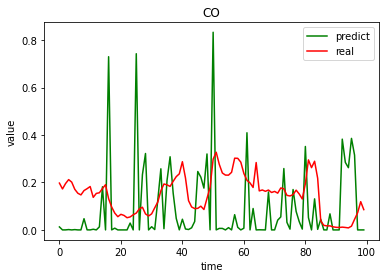

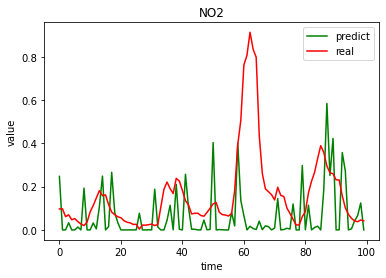

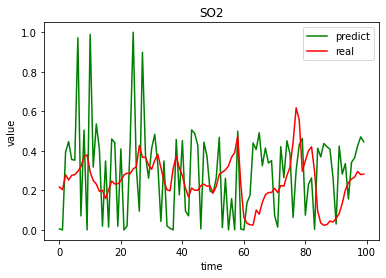

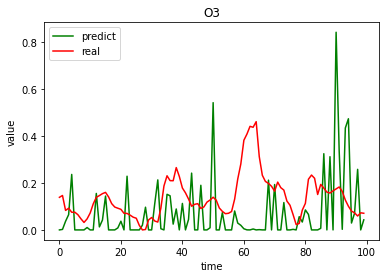

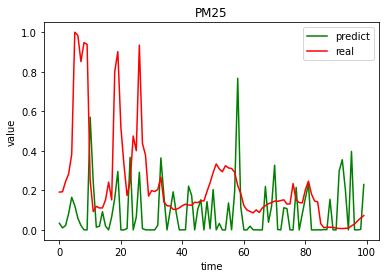

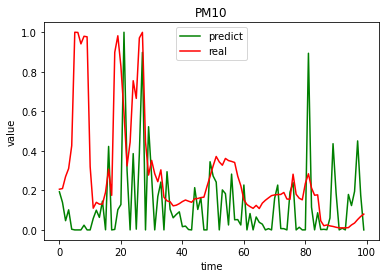

In [10]:
print(errorLp(2,data_pre,data_test))
drawPre("CO",data_pre[:,0],data_test[:,0],dataNum = data_test.shape[0])
drawPre("NO2",data_pre[:,1],data_test[:,1],dataNum = data_test.shape[0])
drawPre("SO2",data_pre[:,2],data_test[:,2],dataNum = data_test.shape[0])
drawPre("O3",data_pre[:,3],data_test[:,3],dataNum = data_test.shape[0])
drawPre("PM25",data_pre[:,4],data_test[:,4],dataNum = data_test.shape[0])
drawPre("PM10",data_pre[:,5],data_test[:,5],dataNum = data_test.shape[0])